# Filtering Example

## Import Required Modules

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import System tools

In [2]:
import os
import sys
import gc
import cProfile
import warnings

In [3]:
current_dir = os.getcwd()
helpers = os.path.join(current_dir, "helpers")
sys.path.insert(0,helpers)

## Importing libraries

In [29]:
from enum import Enum, IntEnum
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import seaborn as sns
import json
import pickle
from tabulate import tabulate
from logger import logger
import directory_manager as dm
import object_manager as om
import data_structures as ds
import df_manager as dfm
from data_model import Metrics, CSVHeader,HandWashingType
from sliding_window import get_windows
from scipy.signal import butter, lfilter, filtfilt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
from filters import band_pass_filter
from scipy.fft import fft

## Load single data

In [16]:
df = pd.read_csv("data/test.csv")
#df.loc[6,"datetime"] = "2023-05-28 00:51:11.980"

### Windowing

In [18]:
windows = get_windows(df, 150, 0.0, True)
len(windows)

High time differences:  Int64Index([1, 6], dtype='int64')
High time differences:  Int64Index([6], dtype='int64')
Ignored rows:  9
Appended:0
Appended:1
High time differences:  Int64Index([343], dtype='int64')
Ignored rows:  481


2

In [25]:
windows[0]

timestamp                datetime     acc x     acc y     acc z  \
9    5120000000 2022-05-28 00:51:06.120  3.527864  4.713399  7.932305   
10   5140000000 2022-05-28 00:51:06.140  3.379373  4.756509  8.049661   
11   5160000000 2022-05-28 00:51:06.160  3.290757  4.852310  8.059241   
12   5180000000 2022-05-28 00:51:06.180  3.321892  4.825965  8.008945   
13   5200000000 2022-05-28 00:51:06.200  3.398533  4.883445  7.862849   
..          ...                     ...       ...       ...       ...   
154  8020000000 2022-05-28 00:51:09.020  3.487148  7.120393  5.592371   
155  8040000000 2022-05-28 00:51:09.040  3.932622  6.124065  5.889353   
156  8060000000 2022-05-28 00:51:09.060  4.215235  6.569539  6.389913   
157  8080000000 2022-05-28 00:51:09.080  4.346960  7.958650  5.206773   
158  8100000000 2022-05-28 00:51:09.100  3.812871  7.795789  4.696633   

       gyro x    gyro y    gyro z  user yes/no  compulsive  urge  tense  \
9    0.069639  0.029322  0.028100          NaN         NaN   NaN    NaN   
10   0.015882  0.001222  0.026878          NaN         NaN   NaN    NaN   
11   0.008552  0.030543  0.023213          NaN         NaN   NaN    NaN   
12   0.020769  0.053756  0.008552          NaN         NaN   NaN    NaN   
13  -0.029322 -0.014661  0.019548          NaN         NaN   NaN    NaN   
..        ...       ...       ...          ...         ...   ...    ...   
154  0.560774 -0.223577 -0.109956          NaN         NaN   NaN    NaN   
155  0.759916 -0.266337 -0.350637          NaN         NaN   NaN    NaN   
156  0.503353 -0.483805 -0.229685          NaN         NaN   NaN    NaN   
157  0.227242 -0.579100 -0.105069          NaN         NaN   NaN    NaN   
158  0.299324 -0.525344 -0.213803          NaN         NaN   NaN    NaN   

     relabeled  window_id  
9            0          0  
10           0          0  
11           0          0  
12           0          0  
13           0          0  
..         ...        ...  
154          0          0  
155          0          0  
156          0          0  
157          0          0  
158          0          0  

[150 rows x 14 columns]

## Fast Fourier Transform (FFT)

In [57]:
def compute_fft(dataframe, column):
    """
    Computes the Fast Fourier Transform (FFT) of a specific column in the DataFrame.
    
    Args:
    dataframe (pd.DataFrame): The DataFrame containing sensor data.
    column (str): The column name for which FFT will be computed.
    
    Returns:
    np.array: The frequency values.
    np.array: The corresponding magnitude spectrum.
    """
    signal = dataframe[column].values
    fs = 50  # Sampling rate
    
    n = len(signal)
    freqs = np.fft.fftfreq(n, 1/fs)
    magnitude = np.abs(fft(signal))
    
    return freqs, magnitude

def plot_fft(freqs, magnitude, column_name):
    """
    Plots the Fast Fourier Transform (FFT) magnitude spectrum.
    
    Args:
    freqs (np.array): The frequency values.
    magnitude (np.array): The magnitude spectrum.
    column_name (str): The name of the column for which FFT was computed.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, magnitude)
    plt.title(f'FFT of {column_name}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()


In [49]:
def create_fft(df):
    """
    Creates the FFT of a dataframe.

    Args:
    df: The dataframe to create the FFT of.

    Returns:
    The FFT of the dataframe.
    """

    # Get the time series data from the dataframe
    time_series = df.iloc[:,2:5]

    # Create the FFT of the time series
    fft = np.fft.fft(time_series)

    # Return the FFT
    return fft

def plot_fft(fft):
    """
    Plots the FFT of a dataframe.

    Args:
    fft: The FFT to plot.
    """

    # Get the frequencies from the FFT
    frequencies = np.fft.fftfreq(len(fft))

    # Plot the FFT
    plt.plot(frequencies, abs(fft))
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('FFT of the DataFrame')
    plt.show()


## Compute FFT on selected column

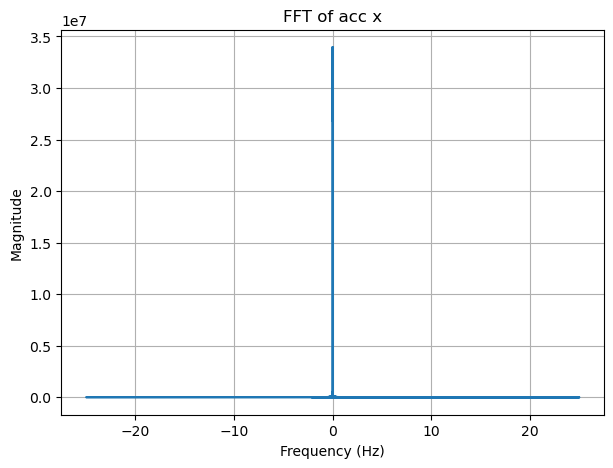

In [55]:
# Select the column for which FFT will be computed
selected_column = 'acc x'

# Compute FFT
freqs, magnitude = compute_fft(df, selected_column)

# Plot FFT
plot_fft(freqs, magnitude, selected_column)

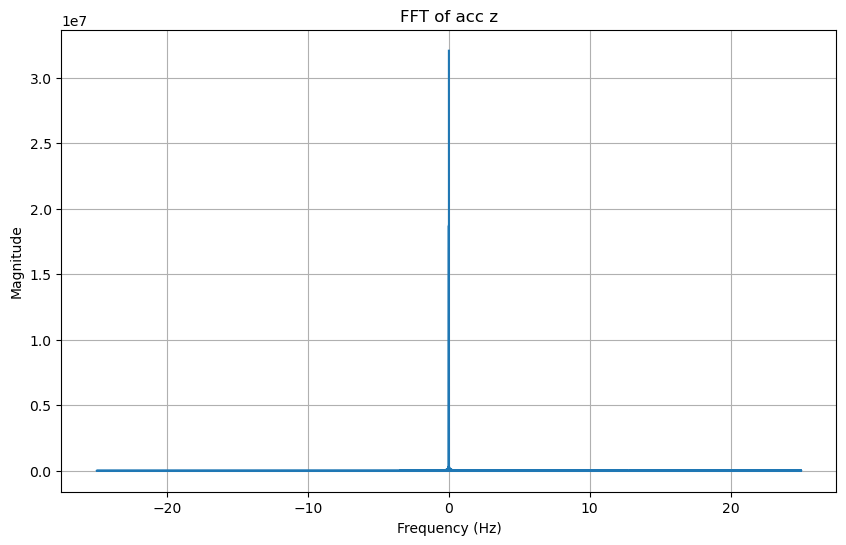

In [60]:
# Sample usage
# Assuming you have loaded the IMU sensor data into a DataFrame called "imu_data"
# with columns 'time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'

# Select the column for which FFT will be computed
selected_column = 'acc z'

# Compute FFT
freqs, magnitude = compute_fft(df, selected_column)

# Plot FFT
plot_fft(freqs, magnitude, selected_column)


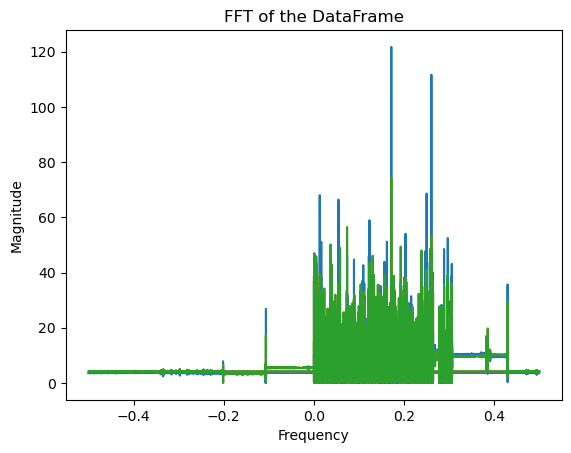

In [50]:
# Create the FFT of the dataframe
fft = create_fft(df)

# Plot the FFT of the dataframe
plot_fft(fft)

In [63]:
freqs.min()

-24.999997327265728

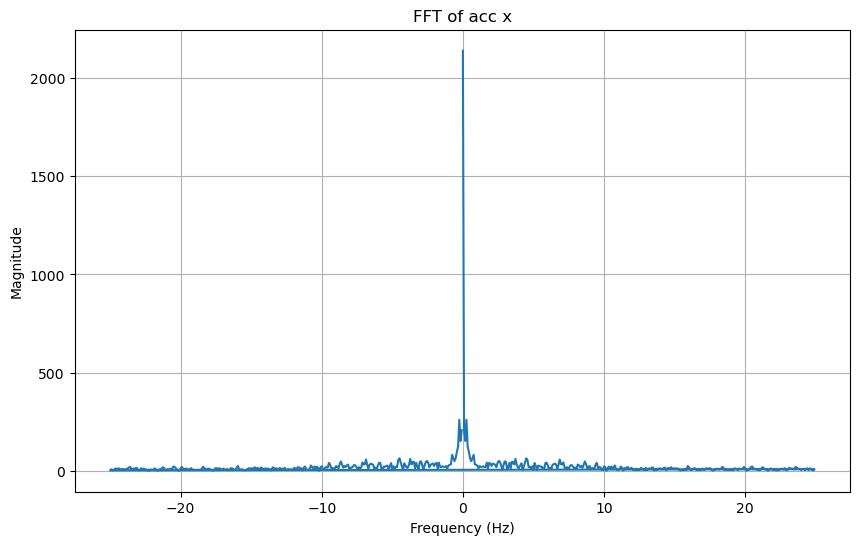

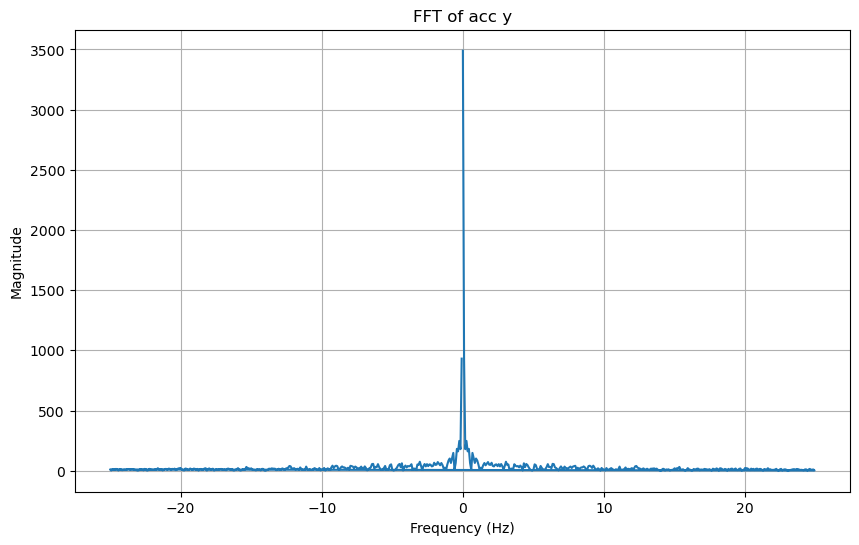

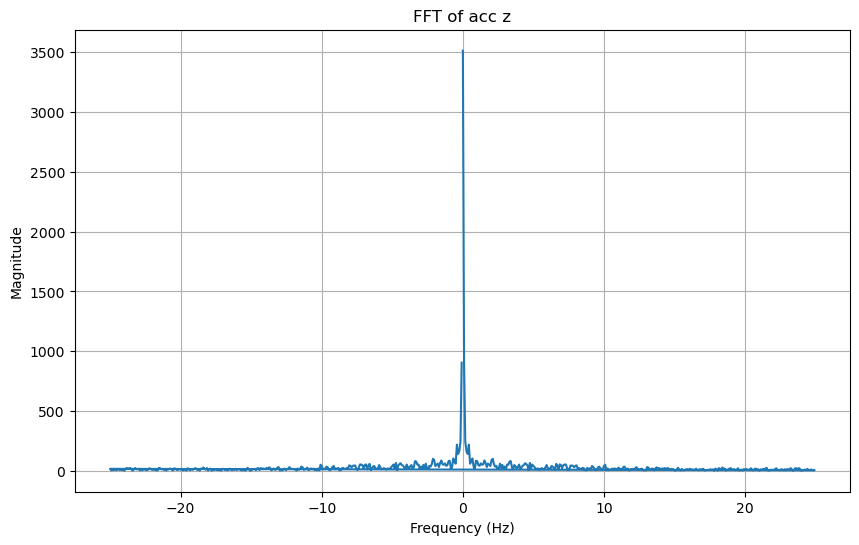

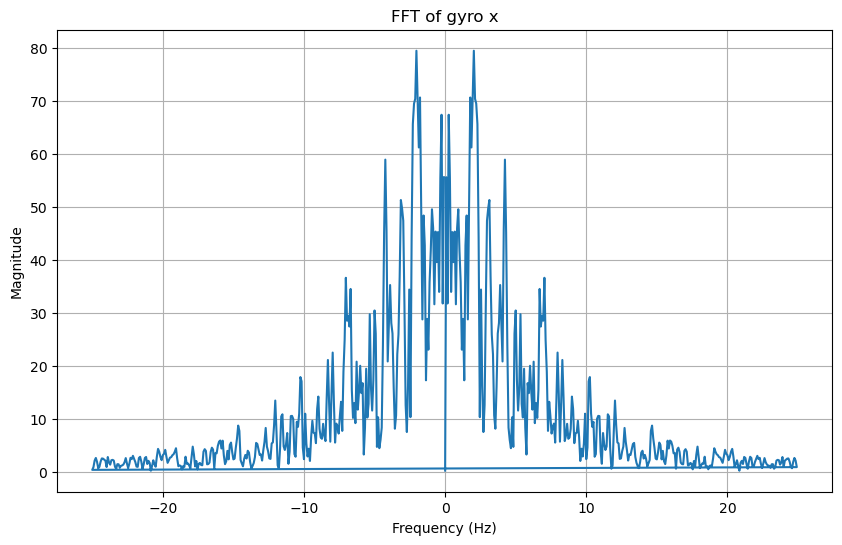

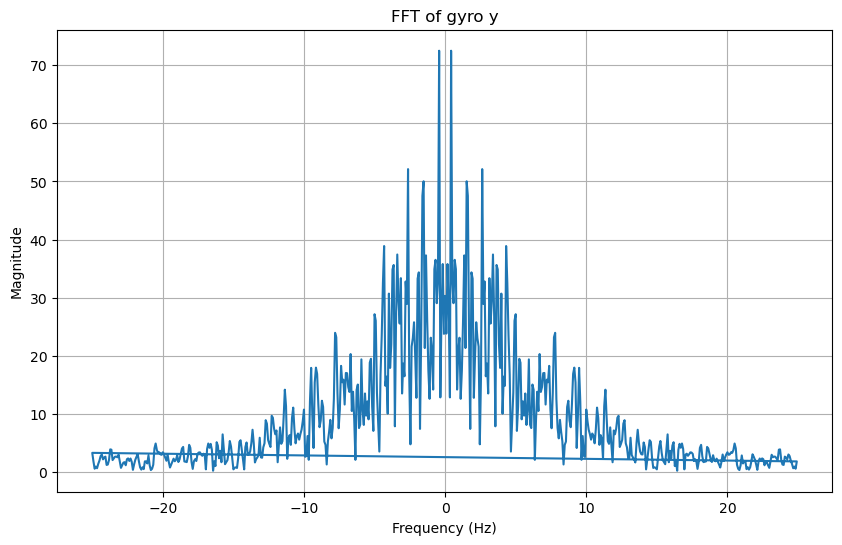

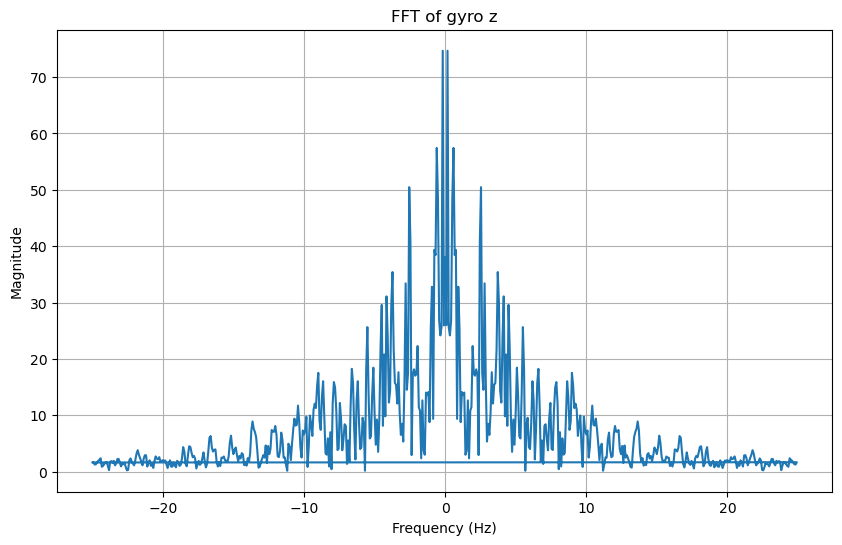

In [28]:
def compute_fft(dataframe, columns):
    """
    Computes the Fast Fourier Transform (FFT) of specified columns in the DataFrame.
    
    Args:
    dataframe (pd.DataFrame): The DataFrame containing sensor data.
    columns (list): List of column names for which FFT will be computed.
    
    Returns:
    dict: A dictionary containing frequency values and corresponding magnitude spectra for each column.
    """
    fs = 50  # Sampling rate
    fft_results = {}
    
    for column in columns:
        signal = dataframe[column].values
        n = len(signal)
        freqs = np.fft.fftfreq(n, 1/fs)
        magnitude = np.abs(np.fft.fft(signal))
        
        fft_results[column] = {'freqs': freqs, 'magnitude': magnitude}
    
    return fft_results

def plot_fft_results(fft_results):
    """
    Plots the FFT magnitude spectra for each column.
    
    Args:
    fft_results (dict): A dictionary containing frequency values and magnitude spectra for each column.
    """
    for column, result in fft_results.items():
        freqs = result['freqs']
        magnitude = result['magnitude']
        
        plt.figure(figsize=(10, 6))
        plt.plot(freqs, magnitude)
        plt.title(f'FFT of {column}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.show()

# Sample usage
# Assuming you have loaded the IMU sensor data into a DataFrame called "imu_data"
# with columns 'time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'

# Select columns for which FFT will be computed
selected_columns = df.columns[2:8]

# Compute FFT results
fft_results = compute_fft(df, selected_columns)

# Plot FFT results
plot_fft_results(fft_results)

In [31]:
df_filtered = band_pass_filter(df, 5, 15, 0.3,selected_columns)

2023-09-01 21:33:36 - INFO - Signal Filtering with band_pass filter:
Order=5
Upper Threshold=15, Lower Threshold=0.3
Sampling rate = fs


In [34]:
import fnmatch
fnmatch.fnmatch([""], pattern)

## Filter Noise

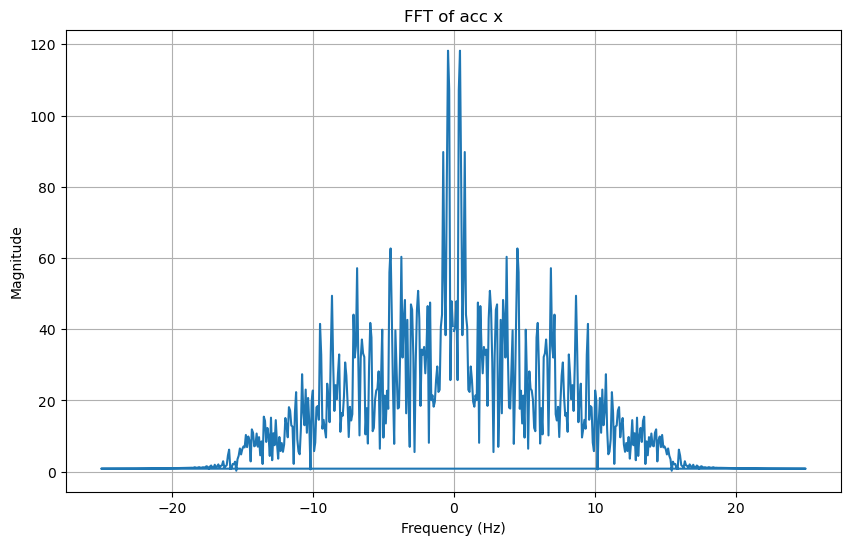

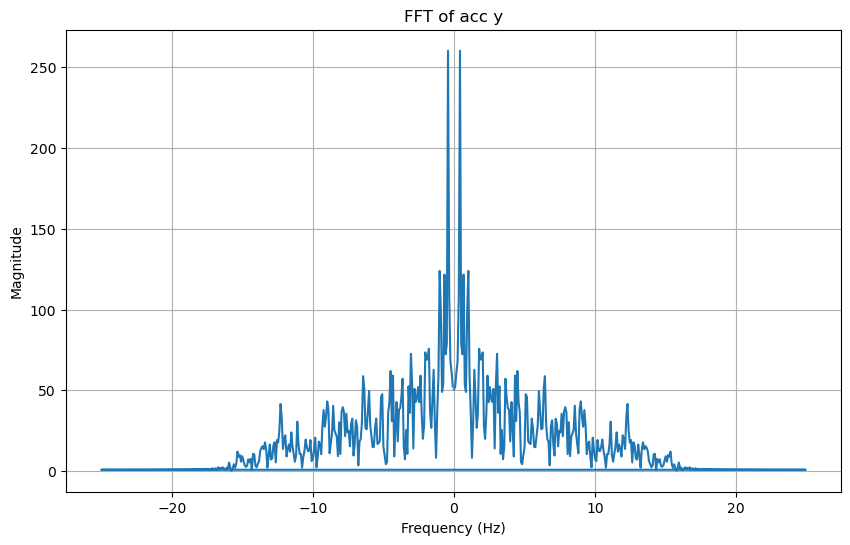

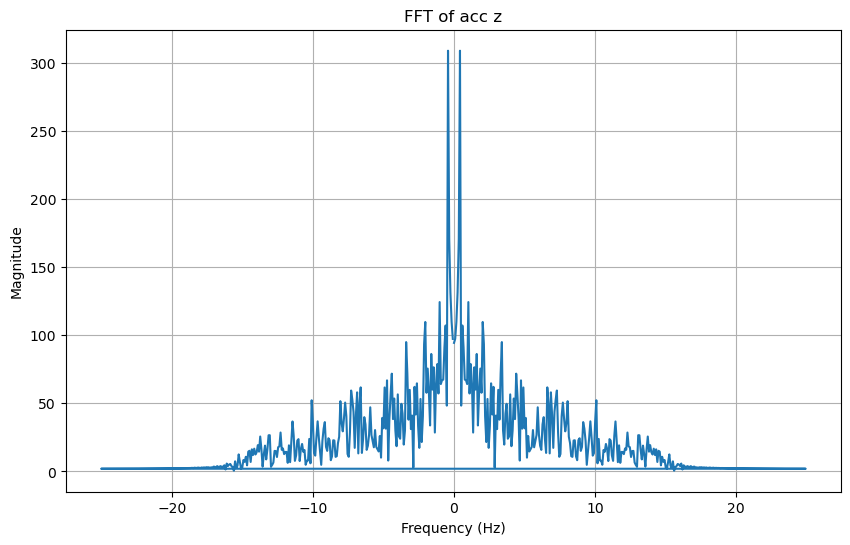

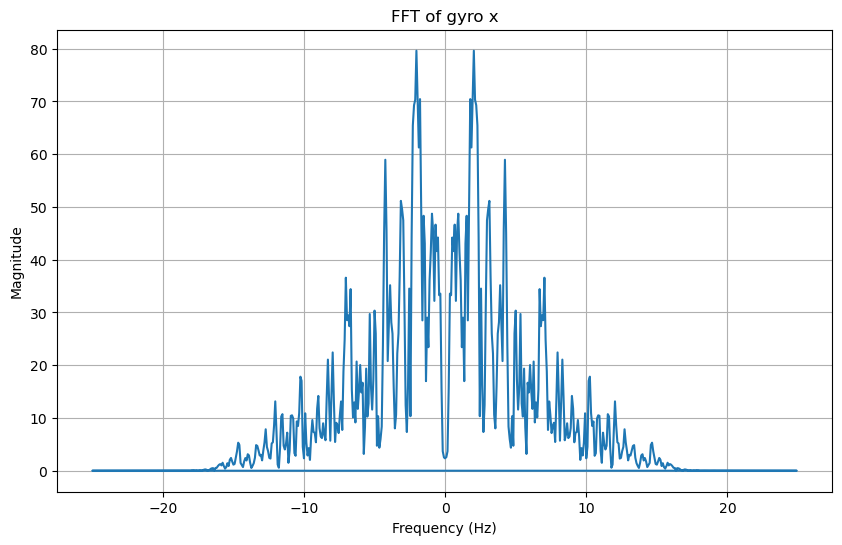

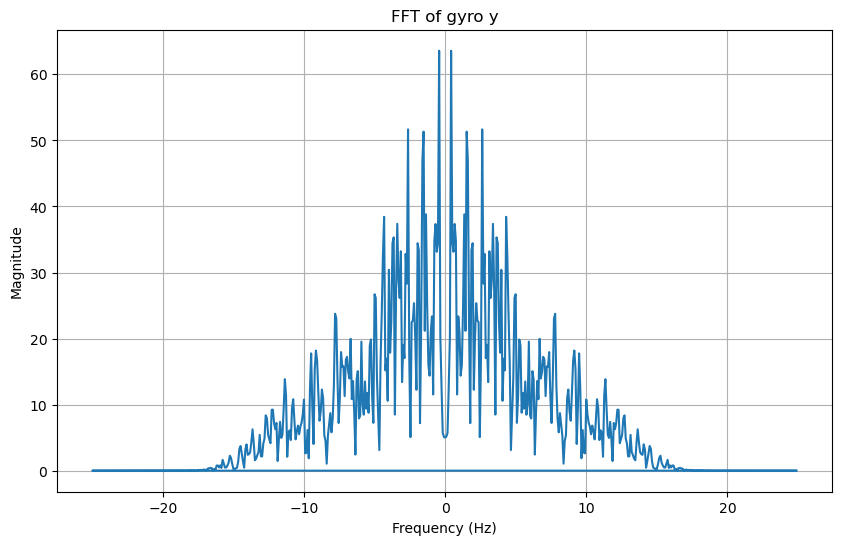

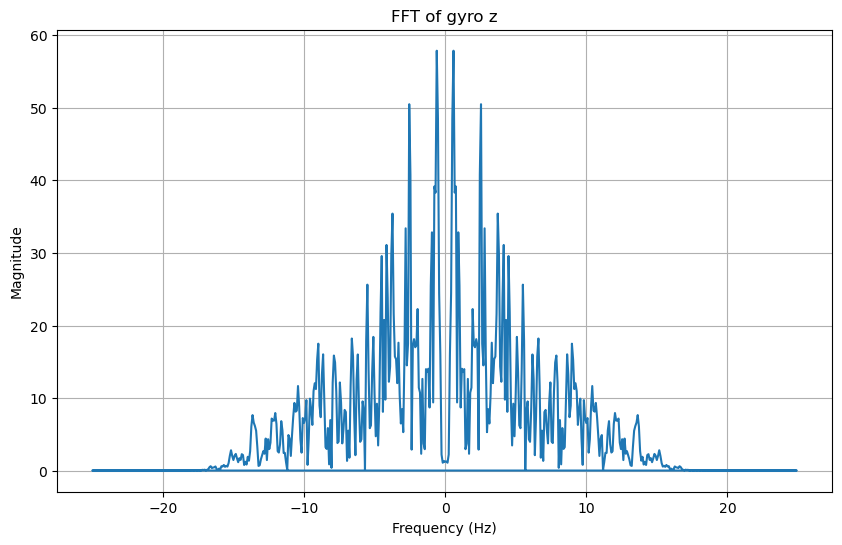

In [33]:
# Select columns for which FFT will be computed
selected_columns = df_filtered.columns[2:8]

# Compute FFT results
fft_results = compute_fft(df_filtered, selected_columns)

# Plot FFT results
plot_fft_results(fft_results)

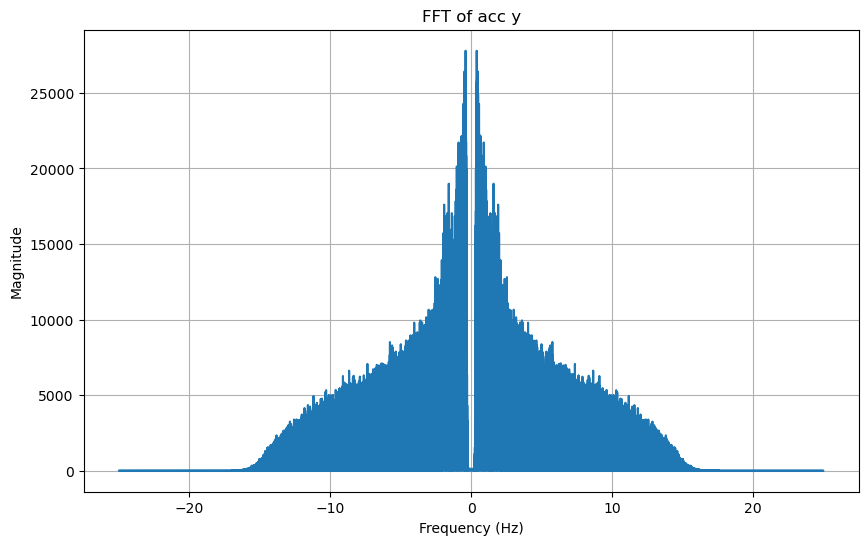

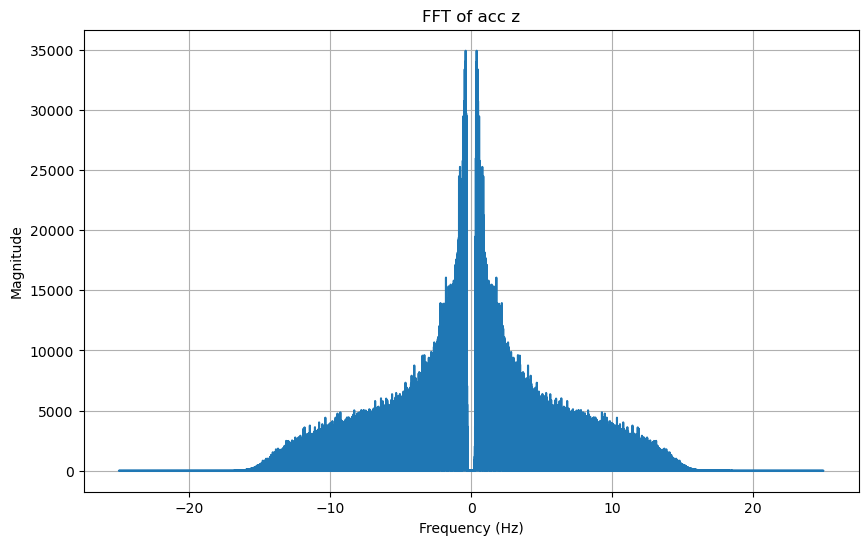

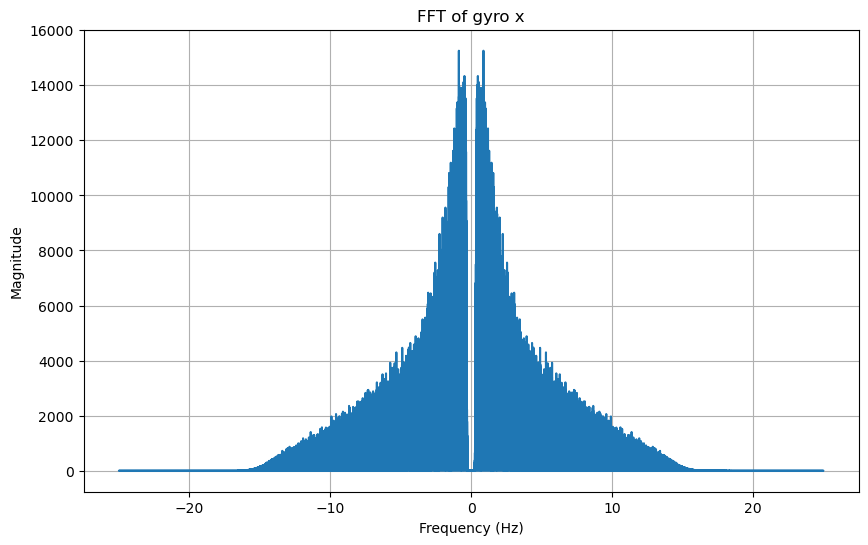

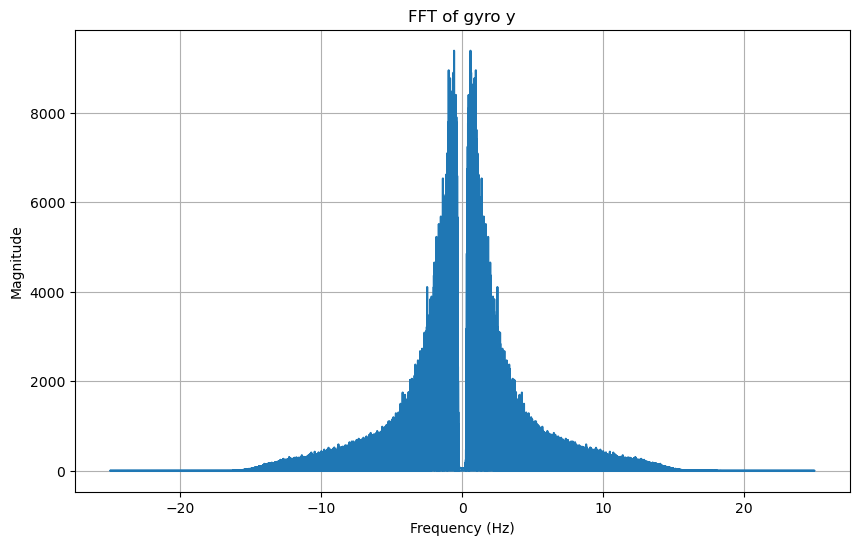

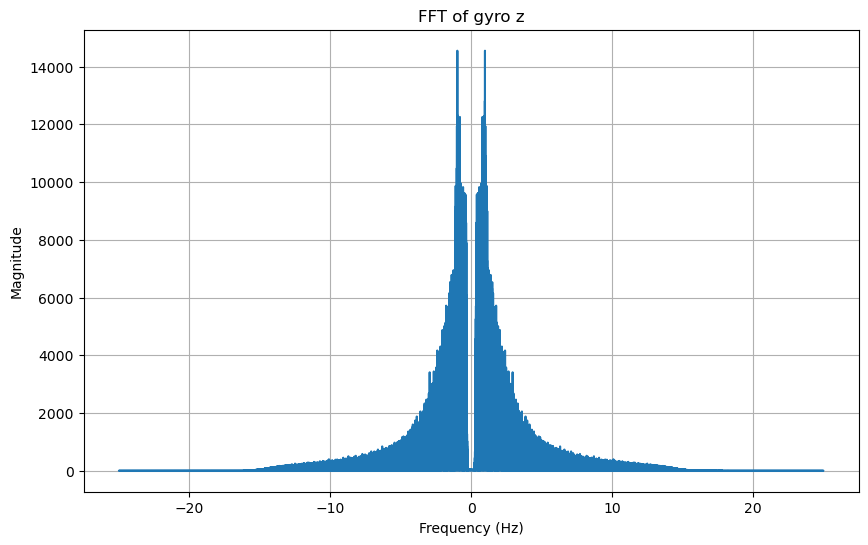

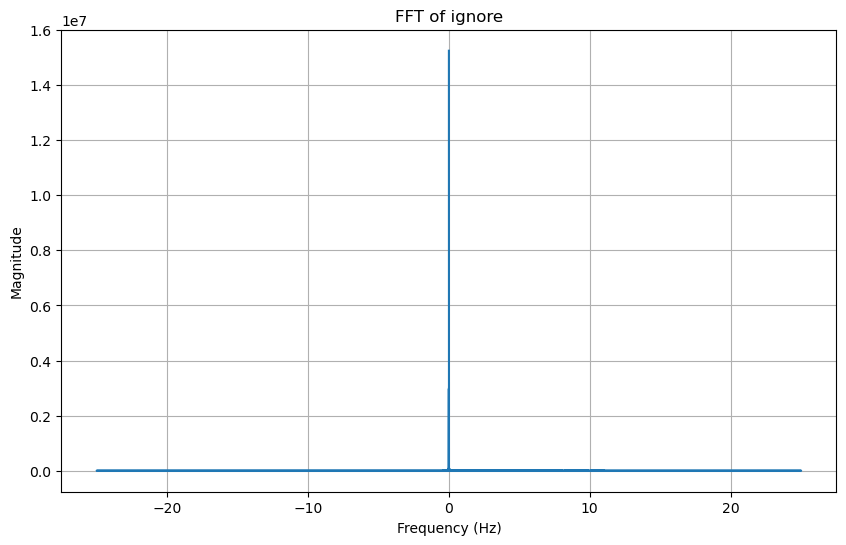

In [72]:
# Select columns for which FFT will be computed
selected_columns = zf.columns[2:8]

# Compute FFT results
fft_results = compute_fft(zf, selected_columns)

# Plot FFT results
plot_fft_results(fft_results)

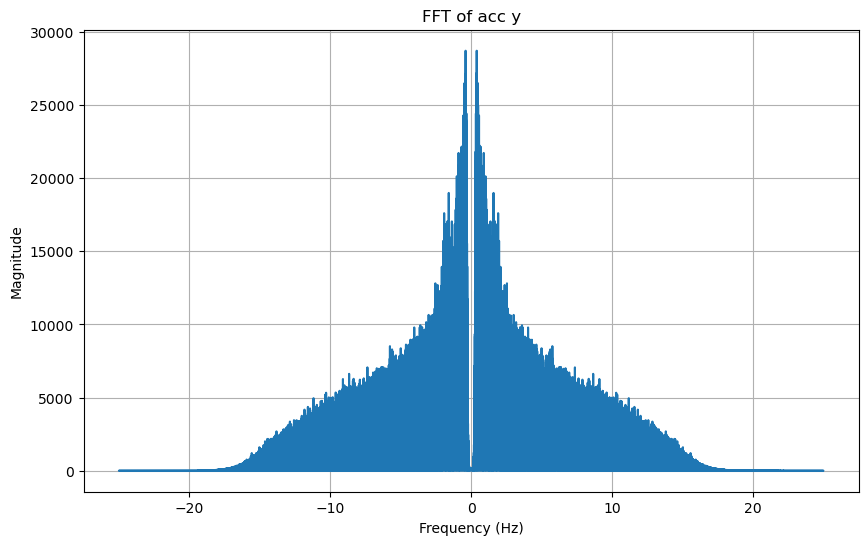

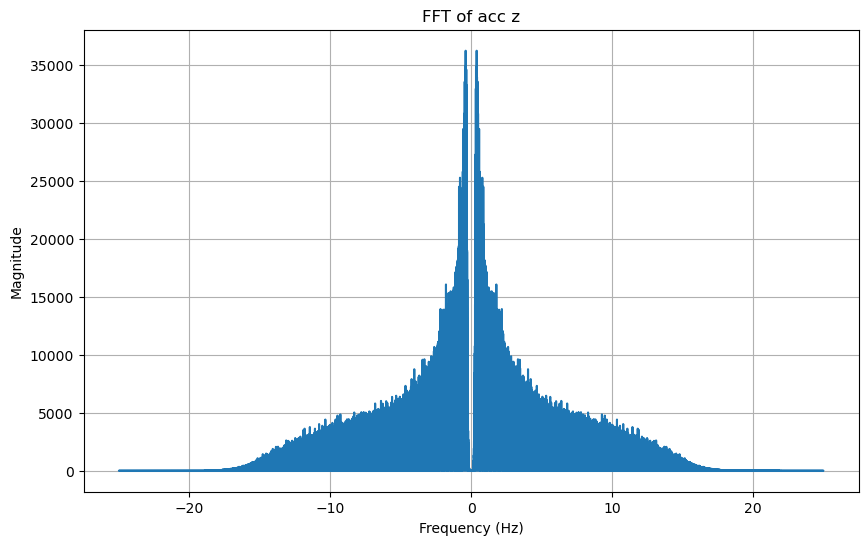

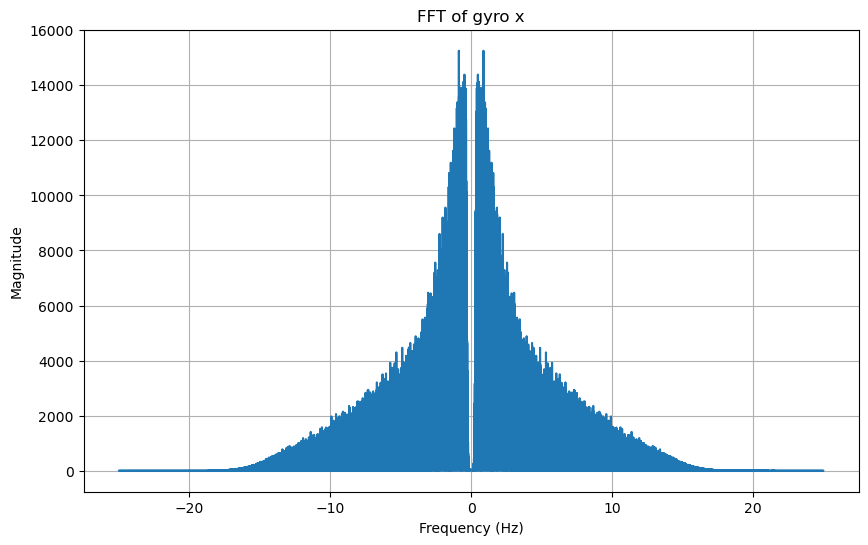

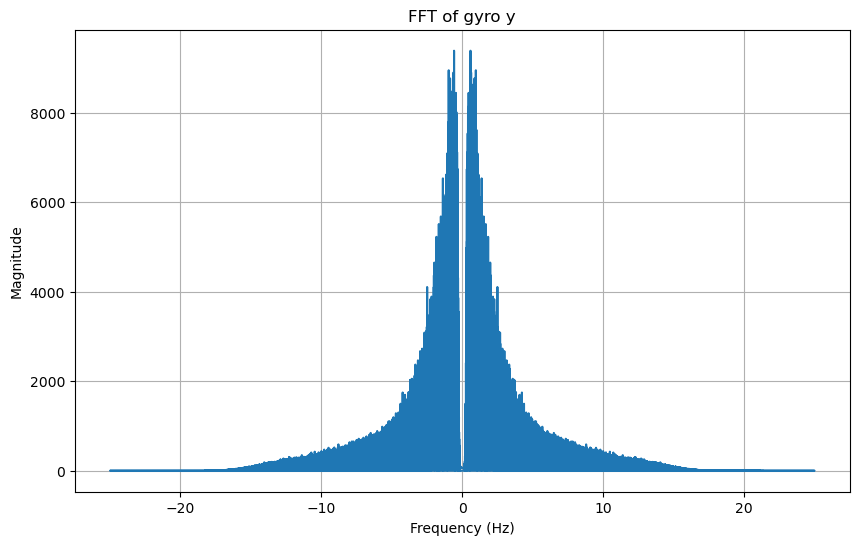

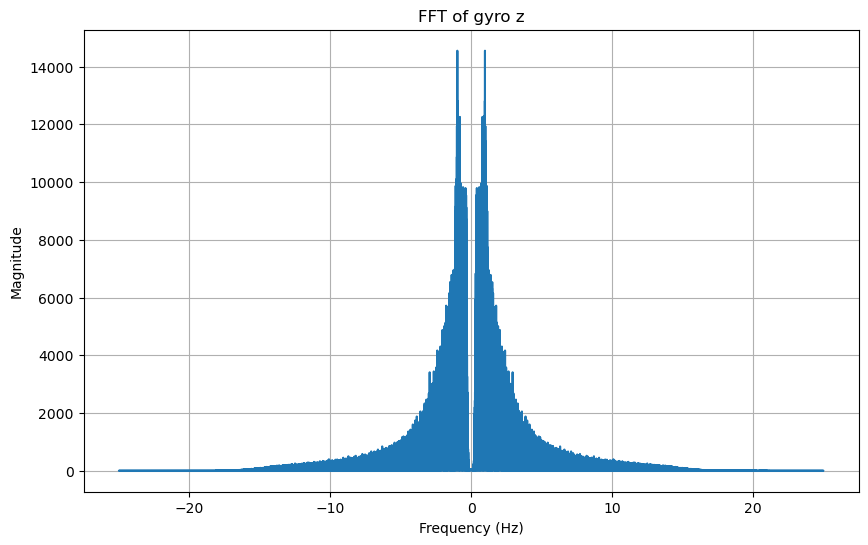

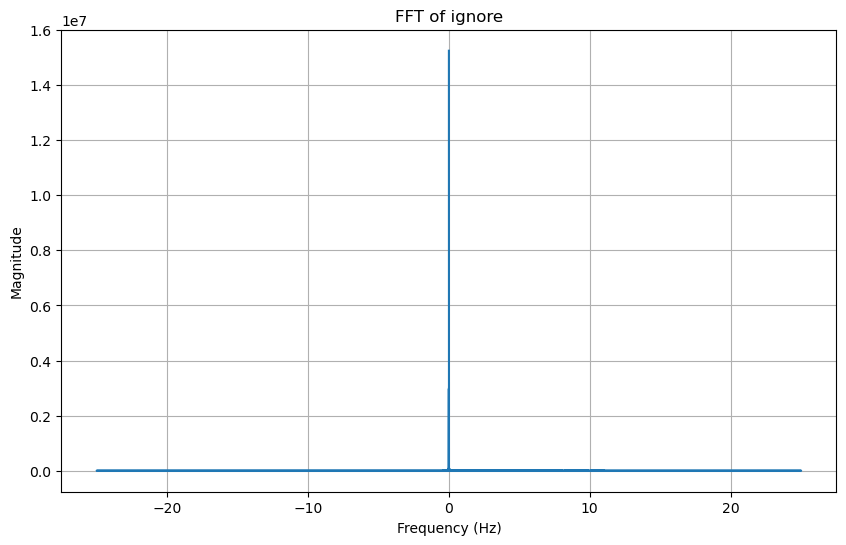

In [70]:
# Select columns for which FFT will be computed
selected_columns = rf.columns[2:8]

# Compute FFT results
fft_results = compute_fft(rf, selected_columns)

# Plot FFT results
plot_fft_results(fft_results)

In [38]:
cHW = df[df["relabeled"]==2][150:300]
ids = cHW.index-cHW.index[0]+1

In [39]:
cols = ['acc x', 'acc y', 'acc z']
for col in cols:
    print(cHW[col].max())
    print(cHW[col].min())

-0.76161623
-7.2616997
-5.046306
-12.013418
0.20597169
-4.471502


In [40]:
cols = ['acc x', 'acc y', 'acc z']
for col in cols:
    print(ndf[col].max())
    print(ndf[col].min())

37.459304971655484
-40.241458404680905
56.965682491024154
-81.14273589603451
41.88857126909613
-67.89391774120723


In [41]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(name='acc x', showlegend=True), hf_x=ids, hf_y=cHW.iloc[:,2])
fig.add_trace(go.Scattergl(name='acc y', showlegend=True), hf_x=ids, hf_y=cHW.iloc[:,3])
fig.add_trace(go.Scattergl(name='acc z', showlegend=True), hf_x=ids, hf_y=cHW.iloc[:,4])
fig

FigureWidgetResampler({
    'data': [{'name': 'acc x',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'a9ca2082-6192-4ed4-9e17-91ab3bf77ff8',
              'x': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
                           15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
                           29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
                           43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
                           57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
                           71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
                           85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                           99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
                          113, 114, 115, 116, 1

In [14]:
# Function to apply a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [15]:
# Parameters for filtering
cutoff_frequency = 2.0  # Adjust based on your data and requirements
sampling_rate = 50.0   # Hz
order = 3

rdf = df.copy()
# Apply filtering to accelerometer data
for col in ['acc x', 'acc y', 'acc z']:
    rdf[col] = butter_lowpass_filter(rdf[col], cutoff_frequency, sampling_rate, order)

# Print the filtered data
print(rdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    590 non-null    int64  
 1   datetime     590 non-null    object 
 2   acc x        590 non-null    float64
 3   acc y        590 non-null    float64
 4   acc z        590 non-null    float64
 5   gyro x       590 non-null    float64
 6   gyro y       590 non-null    float64
 7   gyro z       590 non-null    float64
 8   user yes/no  0 non-null      float64
 9   compulsive   0 non-null      float64
 10  urge         0 non-null      float64
 11  tense        0 non-null      float64
 12  ignore       590 non-null    int64  
 13  relabeled    590 non-null    int64  
dtypes: float64(10), int64(3), object(1)
memory usage: 64.7+ KB
None


In [16]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(name='acc x', showlegend=True), hf_x=rdf['timestamp'], hf_y=rdf.iloc[:,2])
fig.add_trace(go.Scattergl(name='acc y', showlegend=True), hf_x=rdf['timestamp'], hf_y=rdf.iloc[:,3])
fig.add_trace(go.Scattergl(name='acc z', showlegend=True), hf_x=rdf['timestamp'], hf_y=rdf.iloc[:,4])
fig

FigureWidgetResampler({
    'data': [{'name': 'acc x',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '0f0a68d1-13d2-4f1d-a1f4-a653666886cb',
              'x': array([          0,  3380000000,  3400000000, ..., 18680000000, 18700000000,
                          18720000000]),
              'y': array([0.00921367, 0.05592032, 0.16880157, ..., 4.65698037, 4.6495163 ,
                          4.6404438 ])},
             {'name': 'acc y',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'd4223dbe-f9fe-43f5-b37b-20a91f779e83',
              'x': array([          0,  3380000000,  3400000000, ..., 18680000000, 18700000000,
                          18720000000]),
              'y': array([0.01266644, 0.07807335, 0.23872241, ..., 2.89764336, 2.9000574 ,
                          2.90416064])},
             {'name': 'acc z',
              'showlegend': True,
              'type': 'scattergl',
              'u

In [65]:
def low_pass_filter(df, order, fc, cols, fs= 50.0):
    """
    Filter data using low_pass filter.
    
    Args:
    df (pd.DataFarme): Input signal.
    order (int): Order of the filter for smoothness.
    fc (float): Cut-off frequency.
    cols (list): Columns to apply.
    fs (float): Sampling rate in Hz.
    
    Returns:
    Low-pass filtered dataframe.
    """
    
    for col in cols:
        # Numerator (b) and denominator (a) polynomials of the IIR filter. 
        b, a = butter(order, fc, 'lowpass', analog=False, fs=fs)
        # Apply a digital filter forward and backward to a signal.
        df[col] = filtfilt(b, a, df[col])
    return df


def high_pass_filter(df, order, fc, cols, fs=50.0):
    """
    Filter data using high_pass filter.
    
    Args:
    df (pd.DataFarme): Input signal.
    order (int): Order of the filter for smoothness.
    fc (float): Cut-off frequency.
    cols (list): Columns to apply.
    fs (float): Sampling rate in Hz.
    
    Returns:
    High-pass filtered dataframe.
    """
    
    for col in cols:
        # Numerator (b) and denominator (a) polynomials of the IIR filter. 
        b, a = butter(order, fc, 'highpass', analog=False, fs=fs)
        # Apply a digital filter forward and backward to a signal.
        df[col] = filtfilt(b, a, df[col])
    return df

            
def band_pass_filter(df, order, fc_high, fc_low, cols, fs=50.0):
    """
    Filter data using band_pass filter.
    
    Args:
    df (pd.DataFarme): Input signal.
    order (int): Order of the filter for smoothness.
    fc_high (float): Upper cut-off frequency.
    fc_low (float): Lower cut-off frequency.
    cols (list): Columns to apply.
    fs (float): Sampling rate in Hz.
    
    Returns:
    High-pass filtered dataframe.
    """
    
    for col in cols:
        # Numerator (b) and denominator (a) polynomials of the IIR filter. 
        b, a = butter(order, [fc_low, fc_high], 'bandpass', analog=False, fs=fs)
        # Apply a digital filter forward and backward to a signal.
        df[col] = filtfilt(b, a, df[col])
    return df

In [66]:
columns = ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']
rf = band_pass_filter(df, 4, 15, 0.3, columns)

In [71]:
zf = band_pass_filter(df, 6, 15, 0.3, columns)

In [67]:
rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353717 entries, 0 to 9353716
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   acc x      float64       
 2   acc y      float64       
 3   acc z      float64       
 4   gyro x     float64       
 5   gyro y     float64       
 6   gyro z     float64       
 7   ignore     uint8         
 8   relabeled  uint8         
dtypes: datetime64[ns](1), float64(6), uint8(2)
memory usage: 517.4 MB


In [69]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(name='acc x', showlegend=True), hf_x=rf.index, hf_y=rf.iloc[:,2])
fig.add_trace(go.Scattergl(name='acc y', showlegend=True), hf_x=rf.index, hf_y=rf.iloc[:,3])
fig.add_trace(go.Scattergl(name='acc z', showlegend=True), hf_x=rf.index, hf_y=rf.iloc[:,4])
fig

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> acc x <i style="color:#fc9944">~9k</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '50208110-0bb9-4873-8d11-95475182f0c4',
              'x': array([      0,    4346,    9510, ..., 9337247, 9345052, 9353716]),
              'y': array([-6.56769532e-01, -2.41285537e+01,  1.65581733e+01, ..., -1.28133055e-02,
                           8.85155005e-02, -1.62043497e-03])},
             {'name': '<b style="color:sandybrown">[R]</b> acc y <i style="color:#fc9944">~9k</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '07e8b057-564a-4dce-872f-e427ccdb4535',
              'x': array([      0,    9036,   10757, ..., 9338179, 9345047, 9353716]),
              'y': array([ 4.59549472e-01,  2.93057671e+01, -1.53009590e+01, ..., -1.05181741e-02,
                           2.93134379e-02,  8.26826926e-04])},
             {'nam

In [ ]:
idx = ndf.index - ndf.index[0] + 1

In [42]:
# butterworth filter
def butter_filter(df, use_lowpass=True, use_highpass=True, inplace=False):

    upper_threshold = 18
    lower_threshold = 1
    order = 3
    columns = ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']

    if not inplace:
        df = df.copy()
    for label in columns:
        if use_lowpass:
            b, a = butter(order, upper_threshold, 'low', analog=False, fs=sampling_rate)
            df[label] = filtfilt(b, a, df[label])
        if use_highpass:
            d, c = butter(order, lower_threshold, 'high', analog=False, fs=sampling_rate)
            df[label] = filtfilt(d, c, df[label])

    return df

In [44]:
ndf = butter_filter(cHW)
idx = ndf.index - ndf.index[0] + 1
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 145682 to 145831
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   150 non-null    datetime64[ns]
 1   acc x      150 non-null    float64       
 2   acc y      150 non-null    float64       
 3   acc z      150 non-null    float64       
 4   gyro x     150 non-null    float64       
 5   gyro y     150 non-null    float64       
 6   gyro z     150 non-null    float64       
 7   ignore     150 non-null    uint8         
 8   relabeled  150 non-null    uint8         
dtypes: datetime64[ns](1), float64(6), uint8(2)
memory usage: 9.7 KB


In [45]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(name='acc x', showlegend=True), hf_x=idx, hf_y=ndf.iloc[:,2])
fig.add_trace(go.Scattergl(name='acc y', showlegend=True), hf_x=idx, hf_y=ndf.iloc[:,3])
fig.add_trace(go.Scattergl(name='acc z', showlegend=True), hf_x=idx, hf_y=ndf.iloc[:,4])
fig

FigureWidgetResampler({
    'data': [{'name': 'acc x',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'e13b11e5-179e-4c33-a211-54e864490700',
              'x': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
                           15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
                           29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
                           43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
                           57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
                           71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
                           85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                           99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
                          113, 114, 115, 116, 1

In [5]:
# Load lists of csv files
data_folder = "OCDetect_Export"
csv_files = dm.get_files_names(dm.get_data_dir(data_folder))
grouped_files = ds.group_by_subjects(csv_files)
subjects = [key for key in grouped_files.keys()]
print(subjects)
print(len(subjects))

['01', '02', '03', '04', '05', '07', '09', '10', '11', '12', '13', '15', '18', '19', '20', '21', '22', '24', '25', '27', '29', '30']
22


In [6]:
df = dfm.load_all_files(grouped_files['01'][3:5])
df.info()

0  :  2867472
1  :  6486245
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353717 entries, 0 to 9353716
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   acc x      float64       
 2   acc y      float64       
 3   acc z      float64       
 4   gyro x     float64       
 5   gyro y     float64       
 6   gyro z     float64       
 7   ignore     uint8         
 8   relabeled  uint8         
dtypes: datetime64[ns](1), float64(6), uint8(2)
memory usage: 517.4 MB


In [8]:
df.head()

datetime     acc x     acc y     acc z    gyro x    gyro y  \
0 2021-12-02 03:34:18.000 -0.126936  0.057480  9.802815 -0.002443 -0.004887   
1 2021-12-02 03:34:18.020 -0.136516  0.055085  9.814791 -0.002443 -0.004887   
2 2021-12-02 03:34:18.040 -0.131726  0.050295  9.819580 -0.002443 -0.003665   
3 2021-12-02 03:34:18.060 -0.126936  0.062271  9.826766 -0.002443 -0.004887   
4 2021-12-02 03:34:18.080 -0.141306  0.069456  9.810000 -0.002443 -0.004887   

     gyro z  ignore  relabeled  
0 -0.001222       0          0  
1 -0.001222       0          0  
2 -0.001222       0          0  
3 -0.001222       0          0  
4 -0.001222       0          0

In [13]:
time_diff = df['datetime'].diff()
time = pd.Timedelta(milliseconds=20)
indices = time_diff.index[(time_diff > time) | (time_diff < time)]
indices

Int64Index([593345, 978106, 2021703, 4889175], dtype='int64')

In [48]:
indices = time_diff.index[time_diff < pd.Timedelta(milliseconds=20)]
len(indices)

39

In [41]:
df_data = df.loc[(df['ignore'] > 0)]
df_data

datetime     acc x     acc y     acc z    gyro x  \
750     2021-12-02 03:34:33.000 -0.143701 -0.023950  9.924961 -0.002443   
751     2021-12-02 03:34:33.020 -0.129331 -0.007185  9.927357 -0.003665   
752     2021-12-02 03:34:33.040 -0.098196  0.052690  9.877061 -0.002443   
753     2021-12-02 03:34:33.060 -0.102986  0.045505  9.889036 -0.003665   
754     2021-12-02 03:34:33.080 -0.122146  0.002395  9.944121 -0.002443   
...                         ...       ...       ...       ...       ...   
4956496 2022-01-10 17:45:15.920 -7.922725  4.327800 -3.901487 -0.003665   
4956497 2022-01-10 17:45:15.940 -7.927515  4.315825 -3.894302 -0.002443   
4956498 2022-01-10 17:45:15.960 -7.929910  4.308641 -3.903882 -0.002443   
4956499 2022-01-10 17:45:15.980 -7.934700  4.315825 -3.899092 -0.003665   
4956500 2022-01-10 17:45:16.000 -7.922725  4.323010 -3.901487 -0.002443   

           gyro y    gyro z  ignore  relabeled  
750     -0.003665 -0.001222       2          0  
751     -0.003665 -0.003665       2          0  
752     -0.004887 -0.002443       2          0  
753     -0.004887 -0.002443       2          0  
754     -0.003665 -0.002443       2          0  
...           ...       ...     ...        ...  
4956496 -0.006109  0.000000       2          0  
4956497 -0.004887  0.001222       2          0  
4956498 -0.006109  0.000000       2          0  
4956499 -0.006109  0.000000       2          0  
4956500 -0.006109  0.000000       2          0  

[48595156 rows x 9 columns]

In [28]:
1729545/150

11530.3

In [27]:
df_temp = df.loc[(df['ignore'] == 0)]
len(df_temp)

1729545

In [30]:
def append_window(df, window_size:int):
    """
    Checks for ignored rows and return last index
    
    Returns:
    
    A boolean indicating whether to proceed, and the index of the last row to consider.
    """
    # Get all rows having ignored label
    df_temp = df.loc[(df['ignore'] > 0)]
    
    # Get time diff
    time_diff = df['datetime'].diff()
    time = pd.Timedelta(milliseconds=20)
    indices = time_diff.index[(time_diff > time) | (time_diff < time)]
    
    # Case I: High time difference, top priority
    if not indices.empty:
        print("High time differences: ", indices)
        return False, indices[0]
    
    # Case II: Ignored rows
    elif len(df_temp) > 0:
        print("Ignored rows: ", df_temp.index[-1]+1)
        return False, df_temp.index[-1]+1
    else:
        return True, df.index[-1]+1
        

def get_windows(df, window_size:int, overlapping_ratio:float):
    """
    Returns a list of windows with window_size and overlap_ratio.
    
    Args:
    df: The dataframe to get windows from.
    window_size: The size of each window.
    overlapping: The amount of overlapping ratio between windows.

    Returns:
    A list of windows.
    """
    
    overlapping = int(window_size * overlapping_ratio)
    windows = []
    start = 0
    end = window_size
    window_id = 0
    
    while end <= df.shape[0]:
        temp_df = df.iloc[start:end, :].copy()
        
        # TO do: check
        append, start = append_window(temp_df, window_size)
        
        if append:
            print(f"Appended:{window_id}")
            
            # Label window based on majority voting
            temp_df["relabeled"] = temp_df['relabeled'].mode()[0]
            
            # Append unique id 
            temp_df["window_id"] = window_id
            
            # Remove ignore column
            temp_df.drop(['ignore'], axis=1, inplace=True)
            
            # Append window to list
            windows.append(temp_df)
            
            # Reindexing
            start -= overlapping
            window_id += 1
            
        end = start + window_size

    return windows
    

In [31]:
windows = get_windows(df,150,0)

Appended:0
Ignored rows:  300
Ignored rows:  450
Ignored rows:  600
Ignored rows:  750
Ignored rows:  900
Ignored rows:  1050
Ignored rows:  1200
Ignored rows:  1251
Appended:1
Appended:2
Appended:3
Appended:4
Appended:5
Appended:6
Appended:7
Appended:8
Appended:9
Appended:10
Appended:11
Appended:12
Appended:13
Appended:14
Appended:15
Appended:16
Appended:17
Appended:18
Appended:19
Appended:20
Appended:21
Appended:22
Appended:23
Appended:24
Appended:25
Appended:26
Appended:27
Appended:28
Appended:29
Appended:30
Appended:31
Appended:32
Appended:33
Appended:34
Appended:35
Appended:36
Appended:37
Appended:38
Appended:39
Appended:40
Appended:41
Appended:42
Appended:43
Appended:44
Appended:45
Appended:46
Appended:47
Appended:48
Appended:49
Appended:50
Appended:51
Appended:52
Appended:53
Appended:54
Appended:55
Appended:56
Appended:57
Appended:58
Appended:59
Appended:60
Appended:61
Appended:62
Appended:63
Appended:64
Appended:65
Appended:66
Appended:67
Appended:68
Appended:69
Appended:70
App

Appended:519
Appended:520
Appended:521
Appended:522
Appended:523
Appended:524
Appended:525
Appended:526
Appended:527
Appended:528
Appended:529
Appended:530
Appended:531
Appended:532
Appended:533
Appended:534
Appended:535
Appended:536
Appended:537
Appended:538
Appended:539
Appended:540
Appended:541
Appended:542
Appended:543
Appended:544
Appended:545
Appended:546
Appended:547
Appended:548
Appended:549
Appended:550
Appended:551
Appended:552
Appended:553
Appended:554
Appended:555
Appended:556
Appended:557
Appended:558
Appended:559
Appended:560
Appended:561
Appended:562
Appended:563
Appended:564
Appended:565
Appended:566
Appended:567
Appended:568
Ignored rows:  121301
Ignored rows:  121451
Ignored rows:  121601
Ignored rows:  121751
Ignored rows:  121901
Ignored rows:  122001
Appended:569
Appended:570
Appended:571
Appended:572
Appended:573
Appended:574
Appended:575
Appended:576
Appended:577
Appended:578
Appended:579
Appended:580
Appended:581
Appended:582
Appended:583
Appended:584
Appended:5

Appended:1077
Appended:1078
Appended:1079
Appended:1080
Appended:1081
Appended:1082
Appended:1083
Appended:1084
Appended:1085
Appended:1086
Appended:1087
Appended:1088
Appended:1089
Appended:1090
Appended:1091
Appended:1092
Appended:1093
Appended:1094
Appended:1095
Appended:1096
Appended:1097
Appended:1098
Appended:1099
Appended:1100
Appended:1101
Appended:1102
Appended:1103
Appended:1104
Appended:1105
Appended:1106
Appended:1107
Appended:1108
Appended:1109
Appended:1110
Appended:1111
Appended:1112
Appended:1113
Appended:1114
Appended:1115
Appended:1116
Appended:1117
Appended:1118
Appended:1119
Appended:1120
Appended:1121
Appended:1122
Appended:1123
Appended:1124
Appended:1125
Appended:1126
Appended:1127
Appended:1128
Appended:1129
Ignored rows:  211601
Ignored rows:  211751
Ignored rows:  211901
Ignored rows:  212051
Ignored rows:  212201
Ignored rows:  212351
Ignored rows:  212501
Appended:1130
Appended:1131
Appended:1132
Ignored rows:  213101
Ignored rows:  213251
Ignored rows:  213

Appended:1178
Ignored rows:  269551
Ignored rows:  269701
Ignored rows:  269851
Ignored rows:  270001
Appended:1179
Appended:1180
Appended:1181
Appended:1182
Appended:1183
Appended:1184
Ignored rows:  271051
Ignored rows:  271201
Ignored rows:  271351
Ignored rows:  271501
Appended:1185
Ignored rows:  271801
Ignored rows:  271951
Ignored rows:  272101
Ignored rows:  272251
Ignored rows:  272401
Ignored rows:  272501
Appended:1186
Appended:1187
Appended:1188
Appended:1189
Ignored rows:  273251
Ignored rows:  273401
Ignored rows:  273551
Ignored rows:  273701
Ignored rows:  273851
Ignored rows:  274001
Ignored rows:  274151
Ignored rows:  274301
Ignored rows:  274451
Ignored rows:  274501
Appended:1190
Ignored rows:  274801
Ignored rows:  274951
Ignored rows:  275101
Ignored rows:  275251
Appended:1191
Appended:1192
Appended:1193
Appended:1194
Appended:1195
Appended:1196
Ignored rows:  276301
Ignored rows:  276451
Ignored rows:  276601
Ignored rows:  276751
Ignored rows:  276901
Ignored 

Appended:1382
Appended:1383
Appended:1384
Appended:1385
Appended:1386
Appended:1387
Appended:1388
Appended:1389
Appended:1390
Appended:1391
Appended:1392
Appended:1393
Appended:1394
Appended:1395
Appended:1396
Appended:1397
Ignored rows:  358001
Ignored rows:  358151
Ignored rows:  358301
Ignored rows:  358451
Ignored rows:  358501
Appended:1398
Appended:1399
Appended:1400
Appended:1401
Appended:1402
Appended:1403
Appended:1404
Appended:1405
Appended:1406
Appended:1407
Appended:1408
Appended:1409
Appended:1410
Ignored rows:  360601
Ignored rows:  360751
Ignored rows:  360901
Ignored rows:  361051
Ignored rows:  361201
Ignored rows:  361351
Ignored rows:  361501
Appended:1411
Appended:1412
Appended:1413
Appended:1414
Ignored rows:  362251
Ignored rows:  362401
Ignored rows:  362551
Ignored rows:  362701
Ignored rows:  362851
Ignored rows:  363001
Ignored rows:  363151
Ignored rows:  363301
Ignored rows:  363451
Ignored rows:  363601
Ignored rows:  363751
Ignored rows:  363901
Ignored ro

Ignored rows:  436301
Ignored rows:  436451
Ignored rows:  436601
Ignored rows:  436751
Ignored rows:  436901
Ignored rows:  437001
Appended:1598
Appended:1599
Appended:1600
Appended:1601
Appended:1602
Appended:1603
Appended:1604
Appended:1605
Appended:1606
Ignored rows:  438501
Ignored rows:  438651
Ignored rows:  438801
Ignored rows:  438951
Ignored rows:  439101
Ignored rows:  439251
Ignored rows:  439401
Ignored rows:  439501
Appended:1607
Appended:1608
Appended:1609
Appended:1610
Appended:1611
Appended:1612
Appended:1613
Appended:1614
Appended:1615
Appended:1616
Appended:1617
Appended:1618
Appended:1619
Appended:1620
Appended:1621
Appended:1622
Appended:1623
Appended:1624
Appended:1625
Appended:1626
Appended:1627
Appended:1628
Appended:1629
Appended:1630
Appended:1631
Appended:1632
Appended:1633
Appended:1634
Appended:1635
Appended:1636
Appended:1637
Appended:1638
Appended:1639
Appended:1640
Appended:1641
Appended:1642
Appended:1643
Appended:1644
Appended:1645
Appended:1646
Append

Appended:1903
Appended:1904
Appended:1905
Appended:1906
Appended:1907
Appended:1908
Appended:1909
Appended:1910
Appended:1911
Appended:1912
Appended:1913
Appended:1914
Appended:1915
Appended:1916
Appended:1917
Appended:1918
Appended:1919
Appended:1920
Appended:1921
Appended:1922
Appended:1923
Appended:1924
Appended:1925
Appended:1926
Appended:1927
Appended:1928
Appended:1929
Appended:1930
Appended:1931
Appended:1932
Appended:1933
Appended:1934
Appended:1935
Appended:1936
Appended:1937
Appended:1938
Appended:1939
Appended:1940
Appended:1941
Appended:1942
Appended:1943
Appended:1944
Appended:1945
Appended:1946
Appended:1947
Appended:1948
Appended:1949
Appended:1950
Appended:1951
Appended:1952
Appended:1953
Appended:1954
Appended:1955
Appended:1956
Appended:1957
Appended:1958
Appended:1959
Appended:1960
Appended:1961
Appended:1962
Appended:1963
Appended:1964
Appended:1965
Appended:1966
Appended:1967
Appended:1968
Appended:1969
Appended:1970
Appended:1971
Appended:1972
Appended:1973
Append

Ignored rows:  593851
Ignored rows:  594001
Ignored rows:  594151
Ignored rows:  594251
Appended:2223
Appended:2224
Appended:2225
Ignored rows:  594851
Ignored rows:  595001
Ignored rows:  595151
Ignored rows:  595251
Appended:2226
Appended:2227
Appended:2228
Appended:2229
Appended:2230
Appended:2231
Appended:2232
Appended:2233
Appended:2234
Appended:2235
Appended:2236
Appended:2237
Appended:2238
Appended:2239
Appended:2240
Appended:2241
Appended:2242
Appended:2243
Appended:2244
Appended:2245
Appended:2246
Appended:2247
Appended:2248
Appended:2249
Appended:2250
Appended:2251
Appended:2252
Appended:2253
Appended:2254
Appended:2255
Appended:2256
Appended:2257
Appended:2258
Appended:2259
Appended:2260
Appended:2261
Appended:2262
Appended:2263
Appended:2264
Appended:2265
Appended:2266
Appended:2267
Appended:2268
Appended:2269
Appended:2270
Appended:2271
Appended:2272
Appended:2273
Appended:2274
Appended:2275
Appended:2276
Ignored rows:  603051
Ignored rows:  603201
Ignored rows:  603351
Ig

Appended:2444
Appended:2445
Appended:2446
Appended:2447
Appended:2448
Appended:2449
Appended:2450
Appended:2451
Appended:2452
Appended:2453
Appended:2454
Appended:2455
Appended:2456
Appended:2457
Appended:2458
Appended:2459
Appended:2460
Appended:2461
Appended:2462
Appended:2463
Appended:2464
Appended:2465
Appended:2466
Appended:2467
Appended:2468
Appended:2469
Appended:2470
Appended:2471
Appended:2472
Appended:2473
Appended:2474
Appended:2475
Appended:2476
Appended:2477
Appended:2478
Appended:2479
Appended:2480
Appended:2481
Appended:2482
Appended:2483
Appended:2484
Appended:2485
Appended:2486
Appended:2487
Appended:2488
Ignored rows:  689301
Ignored rows:  689451
Ignored rows:  689601
Ignored rows:  689751
Ignored rows:  689901
Ignored rows:  690051
Ignored rows:  690201
Ignored rows:  690351
Ignored rows:  690501
Ignored rows:  690651
Ignored rows:  690801
Ignored rows:  690951
Ignored rows:  691101
Ignored rows:  691251
Ignored rows:  691401
Ignored rows:  691551
Ignored rows:  691

Ignored rows:  772351
Ignored rows:  772501
Ignored rows:  772651
Ignored rows:  772801
Ignored rows:  772951
Ignored rows:  773101
Ignored rows:  773251
Ignored rows:  773401
Ignored rows:  773551
Ignored rows:  773701
Ignored rows:  773851
Ignored rows:  774001
Ignored rows:  774151
Ignored rows:  774301
Ignored rows:  774451
Ignored rows:  774601
Ignored rows:  774751
Ignored rows:  774901
Ignored rows:  775051
Ignored rows:  775201
Ignored rows:  775351
Ignored rows:  775501
Ignored rows:  775651
Ignored rows:  775801
Ignored rows:  775951
Ignored rows:  776101
Ignored rows:  776251
Ignored rows:  776401
Ignored rows:  776551
Ignored rows:  776701
Ignored rows:  776851
Ignored rows:  777001
Ignored rows:  777151
Ignored rows:  777301
Ignored rows:  777451
Ignored rows:  777601
Ignored rows:  777751
Ignored rows:  777901
Ignored rows:  778051
Ignored rows:  778201
Ignored rows:  778251
Appended:2671
Appended:2672
Appended:2673
Appended:2674
Appended:2675
Appended:2676
Ignored rows: 

Appended:2810
Appended:2811
Appended:2812
Ignored rows:  841801
Ignored rows:  841951
Ignored rows:  842101
Ignored rows:  842251
Ignored rows:  842401
Ignored rows:  842551
Ignored rows:  842701
Ignored rows:  842751
Appended:2813
Appended:2814
Appended:2815
Appended:2816
Ignored rows:  843501
Ignored rows:  843651
Ignored rows:  843801
Ignored rows:  843951
Ignored rows:  844101
Ignored rows:  844251
Ignored rows:  844401
Ignored rows:  844551
Ignored rows:  844701
Ignored rows:  844851
Ignored rows:  845001
Ignored rows:  845151
Ignored rows:  845301
Ignored rows:  845451
Ignored rows:  845501
Appended:2817
Ignored rows:  845801
Ignored rows:  845951
Ignored rows:  846101
Ignored rows:  846251
Ignored rows:  846401
Ignored rows:  846551
Ignored rows:  846701
Ignored rows:  846751
Appended:2818
Ignored rows:  847051
Ignored rows:  847201
Ignored rows:  847351
Ignored rows:  847501
Ignored rows:  847651
Ignored rows:  847801
Ignored rows:  847951
Ignored rows:  848101
Ignored rows:  8

Appended:2902
Ignored rows:  907001
Ignored rows:  907151
Ignored rows:  907301
Ignored rows:  907451
Ignored rows:  907501
Appended:2903
Appended:2904
Appended:2905
Appended:2906
Appended:2907
Appended:2908
Appended:2909
Appended:2910
Appended:2911
Appended:2912
Appended:2913
Appended:2914
Appended:2915
Ignored rows:  909601
Ignored rows:  909751
Ignored rows:  909901
Ignored rows:  910001
Appended:2916
Appended:2917
Appended:2918
Appended:2919
Appended:2920
Appended:2921
Ignored rows:  911051
Ignored rows:  911201
Ignored rows:  911351
Ignored rows:  911501
Ignored rows:  911651
Ignored rows:  911801
Ignored rows:  911951
Ignored rows:  912101
Ignored rows:  912251
Ignored rows:  912401
Ignored rows:  912551
Ignored rows:  912701
Ignored rows:  912851
Ignored rows:  913001
Ignored rows:  913151
Ignored rows:  913251
Appended:2922
Ignored rows:  913551
Ignored rows:  913701
Ignored rows:  913851
Ignored rows:  914001
Ignored rows:  914151
Ignored rows:  914301
Ignored rows:  914451
Ig

Appended:3186
Appended:3187
Appended:3188
Appended:3189
Appended:3190
Appended:3191
Appended:3192
Appended:3193
Appended:3194
Appended:3195
Appended:3196
Appended:3197
Appended:3198
Appended:3199
Appended:3200
Appended:3201
Appended:3202
Appended:3203
Appended:3204
Appended:3205
Appended:3206
Appended:3207
Appended:3208
Appended:3209
Appended:3210
Appended:3211
Appended:3212
Appended:3213
Appended:3214
Appended:3215
Appended:3216
Appended:3217
Appended:3218
Appended:3219
Appended:3220
Appended:3221
Appended:3222
Appended:3223
Ignored rows:  991601
Ignored rows:  991751
Ignored rows:  991901
Ignored rows:  992051
Ignored rows:  992201
Ignored rows:  992351
Ignored rows:  992501
Appended:3224
Appended:3225
Appended:3226
Ignored rows:  993101
Ignored rows:  993251
Ignored rows:  993401
Ignored rows:  993551
Ignored rows:  993701
Ignored rows:  993751
Appended:3227
Appended:3228
Appended:3229
Appended:3230
Ignored rows:  994501
Ignored rows:  994651
Ignored rows:  994801
Ignored rows:  994

Ignored rows:  1080051
Ignored rows:  1080201
Ignored rows:  1080351
Ignored rows:  1080501
Ignored rows:  1080651
Ignored rows:  1080801
Ignored rows:  1080951
Ignored rows:  1081101
Ignored rows:  1081251
Appended:3650
Appended:3651
Appended:3652
Appended:3653
Appended:3654
Appended:3655
Appended:3656
Appended:3657
Appended:3658
Appended:3659
Appended:3660
Appended:3661
Appended:3662
Appended:3663
Appended:3664
Appended:3665
Appended:3666
Appended:3667
Ignored rows:  1084101
Ignored rows:  1084251
Ignored rows:  1084401
Ignored rows:  1084551
Ignored rows:  1084701
Ignored rows:  1084851
Ignored rows:  1085001
Appended:3668
Ignored rows:  1085301
Ignored rows:  1085451
Ignored rows:  1085601
Ignored rows:  1085751
Ignored rows:  1085901
Ignored rows:  1086051
Ignored rows:  1086201
Ignored rows:  1086351
Ignored rows:  1086501
Appended:3669
Appended:3670
Appended:3671
Ignored rows:  1087101
Ignored rows:  1087251
Ignored rows:  1087401
Ignored rows:  1087551
Ignored rows:  1087701
Ig

Appended:3944
Appended:3945
Appended:3946
Appended:3947
Appended:3948
Appended:3949
Appended:3950
Appended:3951
Appended:3952
Appended:3953
Appended:3954
Appended:3955
Appended:3956
Appended:3957
Appended:3958
Appended:3959
Appended:3960
Appended:3961
Appended:3962
Appended:3963
Appended:3964
Appended:3965
Appended:3966
Appended:3967
Appended:3968
Appended:3969
Appended:3970
Appended:3971
Appended:3972
Appended:3973
Appended:3974
Appended:3975
Appended:3976
Appended:3977
Appended:3978
Appended:3979
Appended:3980
Appended:3981
Appended:3982
Appended:3983
Appended:3984
Appended:3985
Appended:3986
Ignored rows:  1162851
Ignored rows:  1163001
Ignored rows:  1163151
Ignored rows:  1163301
Ignored rows:  1163451
Ignored rows:  1163601
Ignored rows:  1163751
Ignored rows:  1163901
Ignored rows:  1164051
Ignored rows:  1164201
Ignored rows:  1164351
Ignored rows:  1164501
Ignored rows:  1164651
Ignored rows:  1164801
Ignored rows:  1164951
Ignored rows:  1165101
Ignored rows:  1165251
Ignored

Appended:4484
Appended:4485
Appended:4486
Appended:4487
Appended:4488
Appended:4489
Appended:4490
Appended:4491
Appended:4492
Appended:4493
Appended:4494
Appended:4495
Appended:4496
Appended:4497
Appended:4498
Appended:4499
Appended:4500
Appended:4501
Appended:4502
Appended:4503
Appended:4504
Appended:4505
Appended:4506
Appended:4507
Appended:4508
Appended:4509
Appended:4510
Appended:4511
Appended:4512
Appended:4513
Appended:4514
Appended:4515
Appended:4516
Appended:4517
Appended:4518
Appended:4519
Appended:4520
Appended:4521
Appended:4522
Appended:4523
Appended:4524
Appended:4525
Appended:4526
Appended:4527
Appended:4528
Appended:4529
Appended:4530
Appended:4531
Appended:4532
Appended:4533
Appended:4534
Appended:4535
Appended:4536
Appended:4537
Appended:4538
Appended:4539
Appended:4540
Appended:4541
Appended:4542
Appended:4543
Appended:4544
Appended:4545
Appended:4546
Appended:4547
Appended:4548
Appended:4549
Appended:4550
Appended:4551
Appended:4552
Appended:4553
Appended:4554
Append

Appended:4791
Appended:4792
Appended:4793
Appended:4794
Appended:4795
Appended:4796
Appended:4797
Ignored rows:  1319501
Ignored rows:  1319651
Ignored rows:  1319801
Ignored rows:  1319951
Ignored rows:  1320101
Ignored rows:  1320251
Ignored rows:  1320401
Ignored rows:  1320551
Ignored rows:  1320701
Ignored rows:  1320851
Ignored rows:  1321001
Ignored rows:  1321151
Ignored rows:  1321301
Ignored rows:  1321451
Ignored rows:  1321601
Ignored rows:  1321751
Appended:4798
Appended:4799
Appended:4800
Appended:4801
Appended:4802
Appended:4803
Appended:4804
Appended:4805
Appended:4806
Appended:4807
Appended:4808
Appended:4809
Appended:4810
Appended:4811
Appended:4812
Appended:4813
Appended:4814
Appended:4815
Appended:4816
Appended:4817
Appended:4818
Appended:4819
Appended:4820
Appended:4821
Appended:4822
Appended:4823
Appended:4824
Appended:4825
Appended:4826
Appended:4827
Appended:4828
Appended:4829
Appended:4830
Appended:4831
Appended:4832
Appended:4833
Appended:4834
Appended:4835
Ap

Appended:5244
Ignored rows:  1402551
Ignored rows:  1402701
Ignored rows:  1402851
Ignored rows:  1403001
Ignored rows:  1403151
Ignored rows:  1403301
Ignored rows:  1403451
Ignored rows:  1403501
Appended:5245
Appended:5246
Appended:5247
Appended:5248
Appended:5249
Appended:5250
Appended:5251
Appended:5252
Appended:5253
Appended:5254
Appended:5255
Appended:5256
Appended:5257
Appended:5258
Appended:5259
Appended:5260
Appended:5261
Appended:5262
Appended:5263
Appended:5264
Appended:5265
Appended:5266
Appended:5267
Appended:5268
Appended:5269
Appended:5270
Appended:5271
Appended:5272
Appended:5273
Appended:5274
Appended:5275
Appended:5276
Appended:5277
Appended:5278
Appended:5279
Appended:5280
Appended:5281
Appended:5282
Appended:5283
Appended:5284
Appended:5285
Appended:5286
Appended:5287
Appended:5288
Appended:5289
Appended:5290
Appended:5291
Appended:5292
Appended:5293
Appended:5294
Appended:5295
Appended:5296
Appended:5297
Appended:5298
Appended:5299
Appended:5300
Appended:5301
Appe

Appended:5545
Appended:5546
Appended:5547
Appended:5548
Appended:5549
Appended:5550
Appended:5551
Appended:5552
Appended:5553
Appended:5554
Appended:5555
Appended:5556
Appended:5557
Appended:5558
Appended:5559
Appended:5560
Appended:5561
Appended:5562
Appended:5563
Appended:5564
Appended:5565
Appended:5566
Appended:5567
Appended:5568
Appended:5569
Appended:5570
Appended:5571
Appended:5572
Appended:5573
Appended:5574
Appended:5575
Appended:5576
Appended:5577
Appended:5578
Appended:5579
Appended:5580
Appended:5581
Appended:5582
Appended:5583
Appended:5584
Appended:5585
Appended:5586
Appended:5587
Appended:5588
Appended:5589
Appended:5590
Appended:5591
Appended:5592
Appended:5593
Appended:5594
Appended:5595
Appended:5596
Appended:5597
Appended:5598
Appended:5599
Appended:5600
Appended:5601
Ignored rows:  1483251
Ignored rows:  1483401
Ignored rows:  1483551
Ignored rows:  1483701
Ignored rows:  1483851
Ignored rows:  1484001
Ignored rows:  1484151
Ignored rows:  1484251
Appended:5602
Appe

Appended:5871
Appended:5872
Appended:5873
Appended:5874
Appended:5875
Appended:5876
Appended:5877
Appended:5878
Appended:5879
Ignored rows:  1548251
Ignored rows:  1548401
Ignored rows:  1548551
Ignored rows:  1548701
Ignored rows:  1548851
Ignored rows:  1549001
Appended:5880
Appended:5881
Appended:5882
Appended:5883
Appended:5884
Appended:5885
Appended:5886
Appended:5887
Appended:5888
Appended:5889
Appended:5890
Appended:5891
Appended:5892
Appended:5893
Appended:5894
Appended:5895
Appended:5896
Appended:5897
Ignored rows:  1551851
Ignored rows:  1552001
Ignored rows:  1552151
Ignored rows:  1552301
Ignored rows:  1552451
Ignored rows:  1552601
Ignored rows:  1552751
Ignored rows:  1552901
Ignored rows:  1553051
Ignored rows:  1553201
Ignored rows:  1553351
Ignored rows:  1553501
Appended:5898
Appended:5899
Appended:5900
Appended:5901
Appended:5902
Appended:5903
Appended:5904
Appended:5905
Appended:5906
Appended:5907
Appended:5908
Appended:5909
Appended:5910
Appended:5911
Appended:591

Appended:6210
Appended:6211
Appended:6212
Appended:6213
Appended:6214
Appended:6215
Appended:6216
Appended:6217
Appended:6218
Appended:6219
Appended:6220
Appended:6221
Appended:6222
Appended:6223
Appended:6224
Appended:6225
Appended:6226
Appended:6227
Appended:6228
Appended:6229
Appended:6230
Appended:6231
Appended:6232
Appended:6233
Appended:6234
Appended:6235
Appended:6236
Appended:6237
Appended:6238
Appended:6239
Appended:6240
Appended:6241
Appended:6242
Appended:6243
Appended:6244
Appended:6245
Appended:6246
Appended:6247
Appended:6248
Appended:6249
Appended:6250
Appended:6251
Appended:6252
Appended:6253
Appended:6254
Appended:6255
Appended:6256
Appended:6257
Appended:6258
Appended:6259
Appended:6260
Ignored rows:  1627801
Ignored rows:  1627951
Ignored rows:  1628101
Ignored rows:  1628251
Ignored rows:  1628401
Ignored rows:  1628501
Appended:6261
Appended:6262
Appended:6263
Appended:6264
Appended:6265
Appended:6266
Appended:6267
Appended:6268
Appended:6269
Ignored rows:  1630001

Ignored rows:  1707001
Appended:6665
Appended:6666
Appended:6667
Ignored rows:  1707601
Ignored rows:  1707751
Ignored rows:  1707901
Ignored rows:  1708001
Appended:6668
Appended:6669
Appended:6670
Appended:6671
Appended:6672
Appended:6673
Appended:6674
Appended:6675
Appended:6676
Ignored rows:  1709501
Ignored rows:  1709651
Ignored rows:  1709801
Ignored rows:  1709951
Ignored rows:  1710101
Ignored rows:  1710251
Ignored rows:  1710401
Ignored rows:  1710501
Appended:6677
Appended:6678
Appended:6679
Ignored rows:  1711101
Ignored rows:  1711251
Ignored rows:  1711401
Ignored rows:  1711551
Ignored rows:  1711701
Ignored rows:  1711851
Ignored rows:  1712001
Ignored rows:  1712151
Ignored rows:  1712301
Ignored rows:  1712451
Ignored rows:  1712501
Appended:6680
Ignored rows:  1712801
Ignored rows:  1712951
Ignored rows:  1713101
Ignored rows:  1713251
Ignored rows:  1713401
Ignored rows:  1713551
Ignored rows:  1713701
Ignored rows:  1713851
Ignored rows:  1714001
Ignored rows:  17

Appended:6945
Appended:6946
Appended:6947
Appended:6948
Appended:6949
Appended:6950
Appended:6951
Appended:6952
Appended:6953
Appended:6954
Appended:6955
Appended:6956
Appended:6957
Appended:6958
Appended:6959
Appended:6960
Appended:6961
Appended:6962
Appended:6963
Appended:6964
Appended:6965
Appended:6966
Appended:6967
Appended:6968
Appended:6969
Appended:6970
Appended:6971
Appended:6972
Appended:6973
Appended:6974
Appended:6975
Appended:6976
Appended:6977
Appended:6978
Appended:6979
Appended:6980
Ignored rows:  1793301
Ignored rows:  1793451
Ignored rows:  1793601
Ignored rows:  1793751
Ignored rows:  1793901
Ignored rows:  1794001
Appended:6981
Appended:6982
Appended:6983
Appended:6984
Ignored rows:  1794751
Ignored rows:  1794901
Ignored rows:  1795051
Ignored rows:  1795201
Ignored rows:  1795251
Appended:6985
Ignored rows:  1795551
Ignored rows:  1795701
Ignored rows:  1795851
Ignored rows:  1796001
Ignored rows:  1796151
Ignored rows:  1796301
Ignored rows:  1796451
Ignored rows

Ignored rows:  1866751
Ignored rows:  1866901
Ignored rows:  1867051
Ignored rows:  1867201
Ignored rows:  1867351
Ignored rows:  1867501
Ignored rows:  1867651
Ignored rows:  1867751
Appended:7268
Appended:7269
Appended:7270
Appended:7271
Appended:7272
Appended:7273
Ignored rows:  1868801
Ignored rows:  1868951
Ignored rows:  1869101
Ignored rows:  1869251
Appended:7274
Ignored rows:  1869551
Ignored rows:  1869701
Ignored rows:  1869851
Ignored rows:  1870001
Appended:7275
Appended:7276
Appended:7277
Appended:7278
Appended:7279
Appended:7280
Appended:7281
Appended:7282
Ignored rows:  1871351
Ignored rows:  1871501
Ignored rows:  1871651
Ignored rows:  1871801
Ignored rows:  1871951
Ignored rows:  1872101
Ignored rows:  1872251
Ignored rows:  1872401
Ignored rows:  1872551
Ignored rows:  1872701
Ignored rows:  1872751
Appended:7283
Appended:7284
Appended:7285
Appended:7286
Appended:7287
Appended:7288
Appended:7289
Appended:7290
Ignored rows:  1874101
Ignored rows:  1874251
Ignored row

Appended:7750
Appended:7751
Appended:7752
Appended:7753
Appended:7754
Appended:7755
Appended:7756
Appended:7757
Appended:7758
Appended:7759
Appended:7760
Appended:7761
Appended:7762
Appended:7763
Appended:7764
Appended:7765
Appended:7766
Appended:7767
Appended:7768
Appended:7769
Appended:7770
Appended:7771
Appended:7772
Appended:7773
Appended:7774
Appended:7775
Appended:7776
Appended:7777
Appended:7778
Appended:7779
Appended:7780
Appended:7781
Appended:7782
Appended:7783
Appended:7784
Appended:7785
Appended:7786
Appended:7787
Appended:7788
Appended:7789
Appended:7790
Appended:7791
Appended:7792
Appended:7793
Appended:7794
Appended:7795
Appended:7796
Appended:7797
Appended:7798
Appended:7799
Appended:7800
Appended:7801
Appended:7802
Appended:7803
Appended:7804
Appended:7805
Appended:7806
Appended:7807
Appended:7808
Appended:7809
Appended:7810
Appended:7811
Appended:7812
Appended:7813
Appended:7814
Appended:7815
Appended:7816
Appended:7817
Appended:7818
Appended:7819
Appended:7820
Append

Ignored rows:  2039501
Ignored rows:  2039651
Ignored rows:  2039801
Ignored rows:  2039951
Ignored rows:  2040101
Ignored rows:  2040251
Ignored rows:  2040401
Ignored rows:  2040551
Ignored rows:  2040701
Ignored rows:  2040851
Ignored rows:  2041001
Ignored rows:  2041151
Ignored rows:  2041301
Ignored rows:  2041451
Ignored rows:  2041601
Ignored rows:  2041751
Ignored rows:  2041901
Ignored rows:  2042051
Ignored rows:  2042201
Ignored rows:  2042351
Ignored rows:  2042501
Ignored rows:  2042651
Ignored rows:  2042801
Ignored rows:  2042951
Ignored rows:  2043101
Ignored rows:  2043251
Ignored rows:  2043401
Ignored rows:  2043551
Ignored rows:  2043701
Ignored rows:  2043851
Ignored rows:  2044001
Appended:8242
Appended:8243
Appended:8244
Appended:8245
Appended:8246
Appended:8247
Appended:8248
Appended:8249
Appended:8250
Appended:8251
Appended:8252
Ignored rows:  2045801
Ignored rows:  2045951
Ignored rows:  2046101
Ignored rows:  2046251
Ignored rows:  2046401
Ignored rows:  204

Ignored rows:  2100401
Ignored rows:  2100501
Appended:8347
Ignored rows:  2100801
Ignored rows:  2100951
Ignored rows:  2101101
Ignored rows:  2101251
Ignored rows:  2101401
Ignored rows:  2101551
Ignored rows:  2101701
Ignored rows:  2101851
Ignored rows:  2102001
Appended:8348
Ignored rows:  2102301
Ignored rows:  2102451
Ignored rows:  2102601
Ignored rows:  2102751
Ignored rows:  2102901
Ignored rows:  2103001
Appended:8349
Appended:8350
Appended:8351
Appended:8352
Appended:8353
Appended:8354
Ignored rows:  2104051
Ignored rows:  2104201
Ignored rows:  2104351
Ignored rows:  2104501
Ignored rows:  2104651
Ignored rows:  2104801
Ignored rows:  2104951
Ignored rows:  2105101
Ignored rows:  2105251
Ignored rows:  2105401
Ignored rows:  2105551
Ignored rows:  2105701
Ignored rows:  2105851
Ignored rows:  2106001
Ignored rows:  2106151
Ignored rows:  2106251
Appended:8355
Appended:8356
Appended:8357
Ignored rows:  2106851
Ignored rows:  2107001
Ignored rows:  2107151
Ignored rows:  210

Ignored rows:  2185551
Ignored rows:  2185701
Ignored rows:  2185851
Ignored rows:  2186001
Ignored rows:  2186151
Ignored rows:  2186301
Ignored rows:  2186451
Ignored rows:  2186601
Ignored rows:  2186751
Appended:8581
Ignored rows:  2187051
Ignored rows:  2187201
Ignored rows:  2187351
Ignored rows:  2187501
Ignored rows:  2187651
Ignored rows:  2187751
Appended:8582
Appended:8583
Appended:8584
Appended:8585
Appended:8586
Appended:8587
Appended:8588
Appended:8589
Ignored rows:  2189101
Ignored rows:  2189251
Ignored rows:  2189401
Ignored rows:  2189551
Ignored rows:  2189701
Ignored rows:  2189851
Ignored rows:  2190001
Ignored rows:  2190151
Ignored rows:  2190301
Ignored rows:  2190451
Ignored rows:  2190601
Ignored rows:  2190751
Ignored rows:  2190901
Ignored rows:  2191051
Ignored rows:  2191201
Ignored rows:  2191351
Ignored rows:  2191501
Ignored rows:  2191651
Ignored rows:  2191751
Appended:8590
Appended:8591
Appended:8592
Appended:8593
Ignored rows:  2192501
Ignored rows:

Appended:8819
Appended:8820
Appended:8821
Appended:8822
Appended:8823
Appended:8824
Appended:8825
Appended:8826
Appended:8827
Appended:8828
Appended:8829
Appended:8830
Appended:8831
Appended:8832
Appended:8833
Appended:8834
Appended:8835
Appended:8836
Appended:8837
Appended:8838
Appended:8839
Appended:8840
Appended:8841
Appended:8842
Appended:8843
Appended:8844
Appended:8845
Appended:8846
Appended:8847
Appended:8848
Appended:8849
Appended:8850
Appended:8851
Appended:8852
Appended:8853
Appended:8854
Appended:8855
Appended:8856
Appended:8857
Appended:8858
Appended:8859
Appended:8860
Appended:8861
Appended:8862
Appended:8863
Appended:8864
Appended:8865
Appended:8866
Appended:8867
Appended:8868
Appended:8869
Appended:8870
Appended:8871
Appended:8872
Appended:8873
Appended:8874
Appended:8875
Appended:8876
Appended:8877
Appended:8878
Appended:8879
Appended:8880
Appended:8881
Appended:8882
Appended:8883
Appended:8884
Appended:8885
Appended:8886
Appended:8887
Appended:8888
Appended:8889
Append

Appended:9337
Appended:9338
Appended:9339
Appended:9340
Appended:9341
Appended:9342
Ignored rows:  2338851
Ignored rows:  2339001
Ignored rows:  2339151
Ignored rows:  2339251
Appended:9343
Appended:9344
Appended:9345
Appended:9346
Appended:9347
Appended:9348
Appended:9349
Appended:9350
Appended:9351
Appended:9352
Appended:9353
Appended:9354
Appended:9355
Appended:9356
Appended:9357
Appended:9358
Appended:9359
Appended:9360
Appended:9361
Appended:9362
Appended:9363
Appended:9364
Appended:9365
Appended:9366
Appended:9367
Appended:9368
Appended:9369
Appended:9370
Appended:9371
Appended:9372
Appended:9373
Appended:9374
Appended:9375
Appended:9376
Appended:9377
Appended:9378
Appended:9379
Appended:9380
Appended:9381
Appended:9382
Appended:9383
Appended:9384
Appended:9385
Appended:9386
Appended:9387
Appended:9388
Appended:9389
Appended:9390
Appended:9391
Appended:9392
Appended:9393
Appended:9394
Appended:9395
Ignored rows:  2347351
Ignored rows:  2347501
Ignored rows:  2347651
Ignored rows:

Appended:9662
Appended:9663
Appended:9664
Appended:9665
Appended:9666
Appended:9667
Appended:9668
Appended:9669
Appended:9670
Appended:9671
Appended:9672
Appended:9673
Appended:9674
Appended:9675
Appended:9676
Appended:9677
Appended:9678
Appended:9679
Appended:9680
Appended:9681
Appended:9682
Appended:9683
Appended:9684
Appended:9685
Appended:9686
Appended:9687
Appended:9688
Appended:9689
Appended:9690
Appended:9691
Appended:9692
Appended:9693
Appended:9694
Appended:9695
Appended:9696
Appended:9697
Appended:9698
Appended:9699
Appended:9700
Appended:9701
Appended:9702
Appended:9703
Appended:9704
Appended:9705
Appended:9706
Appended:9707
Appended:9708
Appended:9709
Appended:9710
Appended:9711
Appended:9712
Appended:9713
Ignored rows:  2422601
Ignored rows:  2422751
Ignored rows:  2422901
Ignored rows:  2423051
Ignored rows:  2423201
Ignored rows:  2423351
Ignored rows:  2423501
Appended:9714
Appended:9715
Appended:9716
Appended:9717
Appended:9718
Appended:9719
Appended:9720
Appended:9721

Ignored rows:  2503851
Ignored rows:  2504001
Ignored rows:  2504151
Ignored rows:  2504301
Ignored rows:  2504451
Ignored rows:  2504601
Ignored rows:  2504751
Ignored rows:  2504901
Ignored rows:  2505051
Ignored rows:  2505201
Ignored rows:  2505351
Ignored rows:  2505501
Ignored rows:  2505651
Ignored rows:  2505801
Ignored rows:  2505951
Ignored rows:  2506101
Ignored rows:  2506251
Ignored rows:  2506401
Ignored rows:  2506551
Ignored rows:  2506701
Ignored rows:  2506851
Ignored rows:  2507001
Ignored rows:  2507151
Ignored rows:  2507301
Ignored rows:  2507451
Ignored rows:  2507601
Ignored rows:  2507751
Ignored rows:  2507901
Ignored rows:  2508051
Ignored rows:  2508201
Ignored rows:  2508351
Ignored rows:  2508501
Ignored rows:  2508651
Ignored rows:  2508801
Ignored rows:  2508951
Ignored rows:  2509101
Ignored rows:  2509251
Ignored rows:  2509401
Ignored rows:  2509551
Ignored rows:  2509701
Ignored rows:  2509851
Ignored rows:  2510001
Ignored rows:  2510151
Ignored row

Appended:9942
Appended:9943
Appended:9944
Appended:9945
Appended:9946
Appended:9947
Appended:9948
Appended:9949
Appended:9950
Appended:9951
Appended:9952
Appended:9953
Appended:9954
Appended:9955
Appended:9956
Appended:9957
Appended:9958
Appended:9959
Appended:9960
Appended:9961
Appended:9962
Appended:9963
Appended:9964
Appended:9965
Appended:9966
Appended:9967
Appended:9968
Appended:9969
Appended:9970
Appended:9971
Appended:9972
Appended:9973
Appended:9974
Appended:9975
Appended:9976
Appended:9977
Appended:9978
Appended:9979
Appended:9980
Appended:9981
Appended:9982
Appended:9983
Appended:9984
Appended:9985
Appended:9986
Appended:9987
Appended:9988
Appended:9989
Appended:9990
Appended:9991
Appended:9992
Appended:9993
Appended:9994
Appended:9995
Appended:9996
Appended:9997
Appended:9998
Appended:9999
Appended:10000
Appended:10001
Appended:10002
Appended:10003
Appended:10004
Appended:10005
Appended:10006
Appended:10007
Appended:10008
Appended:10009
Appended:10010
Appended:10011
Appended

Appended:10435
Appended:10436
Appended:10437
Appended:10438
Appended:10439
Appended:10440
Appended:10441
Appended:10442
Appended:10443
Appended:10444
Appended:10445
Appended:10446
Appended:10447
Appended:10448
Appended:10449
Appended:10450
Appended:10451
Appended:10452
Appended:10453
Appended:10454
Appended:10455
Appended:10456
Appended:10457
Appended:10458
Appended:10459
Ignored rows:  2688301
Ignored rows:  2688451
Ignored rows:  2688601
Ignored rows:  2688751
Appended:10460
Appended:10461
Appended:10462
Ignored rows:  2689351
Ignored rows:  2689501
Ignored rows:  2689651
Ignored rows:  2689751
Appended:10463
Appended:10464
Appended:10465
Appended:10466
Appended:10467
Appended:10468
Appended:10469
Appended:10470
Appended:10471
Appended:10472
Appended:10473
Appended:10474
Appended:10475
Appended:10476
Appended:10477
Appended:10478
Appended:10479
Appended:10480
Appended:10481
Appended:10482
Appended:10483
Appended:10484
Appended:10485
Appended:10486
Appended:10487
Appended:10488
Append

Appended:10723
Appended:10724
Appended:10725
Appended:10726
Appended:10727
Appended:10728
Appended:10729
Appended:10730
Appended:10731
Appended:10732
Appended:10733
Appended:10734
Appended:10735
Appended:10736
Appended:10737
Appended:10738
Appended:10739
Appended:10740
Appended:10741
Appended:10742
Appended:10743
Appended:10744
Appended:10745
Appended:10746
Appended:10747
Appended:10748
Ignored rows:  2760551
Ignored rows:  2760701
Ignored rows:  2760851
Ignored rows:  2761001
Ignored rows:  2761151
Ignored rows:  2761301
Ignored rows:  2761451
Ignored rows:  2761601
Ignored rows:  2761751
Ignored rows:  2761901
Ignored rows:  2762001
Appended:10749
Appended:10750
Appended:10751
Appended:10752
Appended:10753
Appended:10754
Appended:10755
Appended:10756
Appended:10757
Appended:10758
Appended:10759
Appended:10760
Appended:10761
Appended:10762
Appended:10763
Appended:10764
Appended:10765
Appended:10766
Appended:10767
Appended:10768
Appended:10769
Appended:10770
Appended:10771
Appended:107

Ignored rows:  2843701
Ignored rows:  2843751
Appended:10969
Ignored rows:  2844051
Ignored rows:  2844201
Ignored rows:  2844351
Ignored rows:  2844501
Ignored rows:  2844651
Ignored rows:  2844751
Appended:10970
Appended:10971
Appended:10972
Appended:10973
Appended:10974
Appended:10975
Ignored rows:  2845801
Ignored rows:  2845951
Ignored rows:  2846101
Ignored rows:  2846251
Appended:10976
Appended:10977
Appended:10978
Appended:10979
Appended:10980
Appended:10981
Ignored rows:  2847301
Ignored rows:  2847451
Ignored rows:  2847601
Ignored rows:  2847751
Ignored rows:  2847901
Ignored rows:  2848001
Appended:10982
Appended:10983
Appended:10984
Appended:10985
Appended:10986
Appended:10987
Appended:10988
Appended:10989
Appended:10990
Appended:10991
Appended:10992
Appended:10993
Appended:10994
Appended:10995
Appended:10996
Appended:10997
Appended:10998
Appended:10999
Appended:11000
Appended:11001
Appended:11002
Appended:11003
Appended:11004
Appended:11005
Appended:11006
Appended:11007
A

Ignored rows:  2925972
Ignored rows:  2926122
Ignored rows:  2926272
Ignored rows:  2926422
Ignored rows:  2926572
Ignored rows:  2926722
Ignored rows:  2926872
Ignored rows:  2927022
Ignored rows:  2927172
Ignored rows:  2927322
Ignored rows:  2927472
Ignored rows:  2927622
Ignored rows:  2927772
Ignored rows:  2927922
Ignored rows:  2928072
Ignored rows:  2928222
Ignored rows:  2928372
Ignored rows:  2928522
Ignored rows:  2928672
Ignored rows:  2928822
Ignored rows:  2928972
Ignored rows:  2929122
Ignored rows:  2929272
Ignored rows:  2929422
Ignored rows:  2929572
Ignored rows:  2929722
Ignored rows:  2929872
Ignored rows:  2930022
Ignored rows:  2930172
Ignored rows:  2930322
Ignored rows:  2930472
Ignored rows:  2930622
Ignored rows:  2930772
Ignored rows:  2930922
Ignored rows:  2931072
Ignored rows:  2931222
Ignored rows:  2931372
Ignored rows:  2931522
Ignored rows:  2931672
Ignored rows:  2931822
Ignored rows:  2931972
Ignored rows:  2932122
Ignored rows:  2932272
Ignored row

Ignored rows:  3000222
Ignored rows:  3000372
Ignored rows:  3000522
Ignored rows:  3000672
Ignored rows:  3000822
Ignored rows:  3000972
Ignored rows:  3001122
Ignored rows:  3001272
Ignored rows:  3001422
Ignored rows:  3001572
Ignored rows:  3001722
Ignored rows:  3001872
Ignored rows:  3002022
Ignored rows:  3002172
Ignored rows:  3002322
Ignored rows:  3002472
Ignored rows:  3002622
Ignored rows:  3002772
Ignored rows:  3002922
Ignored rows:  3003072
Ignored rows:  3003222
Ignored rows:  3003372
Ignored rows:  3003522
Ignored rows:  3003672
Ignored rows:  3003822
Ignored rows:  3003972
Ignored rows:  3004122
Ignored rows:  3004272
Ignored rows:  3004422
Ignored rows:  3004572
Ignored rows:  3004722
Ignored rows:  3004872
Ignored rows:  3005022
Ignored rows:  3005172
Ignored rows:  3005322
Ignored rows:  3005472
Ignored rows:  3005622
Ignored rows:  3005772
Ignored rows:  3005922
Ignored rows:  3006072
Ignored rows:  3006222
Ignored rows:  3006372
Ignored rows:  3006522
Ignored row

Ignored rows:  3074022
Ignored rows:  3074172
Ignored rows:  3074322
Ignored rows:  3074472
Ignored rows:  3074622
Ignored rows:  3074772
Ignored rows:  3074922
Ignored rows:  3075072
Ignored rows:  3075222
Ignored rows:  3075372
Ignored rows:  3075522
Ignored rows:  3075672
Ignored rows:  3075822
Ignored rows:  3075972
Ignored rows:  3076122
Ignored rows:  3076272
Ignored rows:  3076422
Ignored rows:  3076572
Ignored rows:  3076722
Ignored rows:  3076872
Ignored rows:  3077022
Ignored rows:  3077172
Ignored rows:  3077322
Ignored rows:  3077472
Ignored rows:  3077622
Ignored rows:  3077772
Ignored rows:  3077922
Ignored rows:  3078072
Ignored rows:  3078222
Ignored rows:  3078372
Ignored rows:  3078522
Ignored rows:  3078672
Ignored rows:  3078822
Ignored rows:  3078972
Ignored rows:  3079122
Ignored rows:  3079272
Ignored rows:  3079422
Ignored rows:  3079572
Ignored rows:  3079722
Ignored rows:  3079872
Ignored rows:  3080022
Ignored rows:  3080172
Ignored rows:  3080322
Ignored row

Ignored rows:  3147222
Ignored rows:  3147372
Ignored rows:  3147522
Ignored rows:  3147672
Ignored rows:  3147822
Ignored rows:  3147972
Ignored rows:  3148122
Ignored rows:  3148272
Ignored rows:  3148422
Ignored rows:  3148572
Ignored rows:  3148722
Ignored rows:  3148872
Ignored rows:  3149022
Ignored rows:  3149172
Ignored rows:  3149322
Ignored rows:  3149472
Ignored rows:  3149622
Ignored rows:  3149772
Ignored rows:  3149922
Ignored rows:  3150072
Ignored rows:  3150222
Ignored rows:  3150372
Ignored rows:  3150522
Ignored rows:  3150672
Ignored rows:  3150822
Ignored rows:  3150972
Ignored rows:  3151122
Ignored rows:  3151272
Ignored rows:  3151422
Ignored rows:  3151572
Ignored rows:  3151722
Ignored rows:  3151872
Ignored rows:  3152022
Ignored rows:  3152172
Ignored rows:  3152322
Ignored rows:  3152472
Ignored rows:  3152622
Ignored rows:  3152772
Ignored rows:  3152922
Ignored rows:  3153072
Ignored rows:  3153222
Ignored rows:  3153372
Ignored rows:  3153522
Ignored row

Ignored rows:  3260172
Ignored rows:  3260322
Ignored rows:  3260472
Ignored rows:  3260622
Ignored rows:  3260772
Ignored rows:  3260922
Ignored rows:  3261072
Ignored rows:  3261222
Ignored rows:  3261372
Ignored rows:  3261522
Ignored rows:  3261672
Ignored rows:  3261822
Ignored rows:  3261972
Ignored rows:  3262122
Ignored rows:  3262272
Ignored rows:  3262422
Ignored rows:  3262572
Ignored rows:  3262722
Ignored rows:  3262872
Ignored rows:  3263022
Ignored rows:  3263172
Ignored rows:  3263322
Ignored rows:  3263472
Ignored rows:  3263622
Ignored rows:  3263772
Ignored rows:  3263922
Ignored rows:  3264072
Ignored rows:  3264222
Ignored rows:  3264372
Ignored rows:  3264522
Ignored rows:  3264672
Ignored rows:  3264822
Ignored rows:  3264972
Ignored rows:  3265122
Ignored rows:  3265272
Ignored rows:  3265422
Ignored rows:  3265572
Ignored rows:  3265722
Ignored rows:  3265872
Ignored rows:  3266022
Ignored rows:  3266172
Ignored rows:  3266322
Ignored rows:  3266472
Ignored row

Ignored rows:  3352722
Ignored rows:  3352872
Ignored rows:  3353022
Ignored rows:  3353172
Ignored rows:  3353322
Ignored rows:  3353472
Ignored rows:  3353622
Ignored rows:  3353772
Ignored rows:  3353922
Ignored rows:  3354072
Ignored rows:  3354222
Ignored rows:  3354372
Ignored rows:  3354522
Ignored rows:  3354672
Ignored rows:  3354822
Ignored rows:  3354972
Ignored rows:  3355122
Ignored rows:  3355272
Ignored rows:  3355422
Ignored rows:  3355572
Ignored rows:  3355722
Ignored rows:  3355872
Ignored rows:  3356022
Ignored rows:  3356172
Ignored rows:  3356322
Ignored rows:  3356472
Ignored rows:  3356622
Ignored rows:  3356772
Ignored rows:  3356922
Ignored rows:  3357072
Ignored rows:  3357222
Ignored rows:  3357372
Ignored rows:  3357522
Ignored rows:  3357672
Ignored rows:  3357822
Ignored rows:  3357972
Ignored rows:  3358122
Ignored rows:  3358272
Ignored rows:  3358422
Ignored rows:  3358572
Ignored rows:  3358722
Ignored rows:  3358872
Ignored rows:  3359022
Ignored row

Ignored rows:  3434772
Ignored rows:  3434922
Ignored rows:  3435072
Ignored rows:  3435222
Ignored rows:  3435372
Ignored rows:  3435522
Ignored rows:  3435672
Ignored rows:  3435822
Ignored rows:  3435972
Ignored rows:  3436122
Ignored rows:  3436272
Ignored rows:  3436422
Ignored rows:  3436572
Ignored rows:  3436722
Ignored rows:  3436872
Ignored rows:  3437022
Ignored rows:  3437172
Ignored rows:  3437322
Ignored rows:  3437472
Ignored rows:  3437622
Ignored rows:  3437772
Ignored rows:  3437922
Ignored rows:  3438072
Ignored rows:  3438222
Ignored rows:  3438372
Ignored rows:  3438522
Ignored rows:  3438672
Ignored rows:  3438822
Ignored rows:  3438972
Ignored rows:  3439122
Ignored rows:  3439272
Ignored rows:  3439422
Ignored rows:  3439572
Ignored rows:  3439722
Ignored rows:  3439872
Ignored rows:  3440022
Ignored rows:  3440172
Ignored rows:  3440322
Ignored rows:  3440472
Ignored rows:  3440622
Ignored rows:  3440772
Ignored rows:  3440922
Ignored rows:  3441072
Ignored row

Ignored rows:  3498222
Ignored rows:  3498372
Ignored rows:  3498522
Ignored rows:  3498672
Ignored rows:  3498822
Ignored rows:  3498972
Ignored rows:  3499122
Ignored rows:  3499272
Ignored rows:  3499422
Ignored rows:  3499572
Ignored rows:  3499722
Ignored rows:  3499872
Ignored rows:  3500022
Ignored rows:  3500172
Ignored rows:  3500322
Ignored rows:  3500472
Ignored rows:  3500622
Ignored rows:  3500772
Ignored rows:  3500922
Ignored rows:  3501072
Ignored rows:  3501222
Ignored rows:  3501372
Ignored rows:  3501522
Ignored rows:  3501672
Ignored rows:  3501822
Ignored rows:  3501972
Ignored rows:  3502122
Ignored rows:  3502272
Ignored rows:  3502422
Ignored rows:  3502572
Ignored rows:  3502722
Ignored rows:  3502872
Ignored rows:  3503022
Ignored rows:  3503172
Ignored rows:  3503322
Ignored rows:  3503472
Ignored rows:  3503622
Ignored rows:  3503772
Ignored rows:  3503922
Ignored rows:  3504072
Ignored rows:  3504222
Ignored rows:  3504372
Ignored rows:  3504522
Ignored row

Ignored rows:  3581923
Ignored rows:  3582073
Ignored rows:  3582223
Ignored rows:  3582373
Ignored rows:  3582523
Ignored rows:  3582673
Ignored rows:  3582823
Ignored rows:  3582973
Ignored rows:  3583123
Ignored rows:  3583273
Ignored rows:  3583423
Ignored rows:  3583573
Ignored rows:  3583723
Ignored rows:  3583873
Ignored rows:  3584023
Ignored rows:  3584173
Ignored rows:  3584323
Ignored rows:  3584473
Ignored rows:  3584623
Ignored rows:  3584773
Ignored rows:  3584923
Ignored rows:  3585073
Ignored rows:  3585223
Ignored rows:  3585373
Ignored rows:  3585523
Ignored rows:  3585673
Ignored rows:  3585823
Ignored rows:  3585973
Ignored rows:  3586123
Ignored rows:  3586273
Ignored rows:  3586423
Ignored rows:  3586573
Ignored rows:  3586723
Ignored rows:  3586873
Ignored rows:  3587023
Ignored rows:  3587173
Ignored rows:  3587323
Ignored rows:  3587473
Ignored rows:  3587623
Ignored rows:  3587773
Ignored rows:  3587923
Ignored rows:  3588073
Ignored rows:  3588223
Ignored row

Ignored rows:  3692073
Ignored rows:  3692223
Ignored rows:  3692373
Ignored rows:  3692523
Ignored rows:  3692673
Ignored rows:  3692823
Ignored rows:  3692973
Ignored rows:  3693123
Ignored rows:  3693273
Ignored rows:  3693423
Ignored rows:  3693573
Ignored rows:  3693723
Ignored rows:  3693873
Ignored rows:  3694023
Ignored rows:  3694173
Ignored rows:  3694323
Ignored rows:  3694473
Ignored rows:  3694623
Ignored rows:  3694773
Ignored rows:  3694923
Ignored rows:  3695073
Ignored rows:  3695223
Ignored rows:  3695373
Ignored rows:  3695523
Ignored rows:  3695673
Ignored rows:  3695823
Ignored rows:  3695973
Ignored rows:  3696123
Ignored rows:  3696273
Ignored rows:  3696423
Ignored rows:  3696573
Ignored rows:  3696723
Ignored rows:  3696873
Ignored rows:  3697023
Ignored rows:  3697173
Ignored rows:  3697323
Ignored rows:  3697473
Ignored rows:  3697623
Ignored rows:  3697773
Ignored rows:  3697923
Ignored rows:  3698073
Ignored rows:  3698223
Ignored rows:  3698373
Ignored row

Ignored rows:  3818523
Ignored rows:  3818673
Ignored rows:  3818823
Ignored rows:  3818973
Ignored rows:  3819123
Ignored rows:  3819273
Ignored rows:  3819423
Ignored rows:  3819573
Ignored rows:  3819723
Ignored rows:  3819873
Ignored rows:  3820023
Ignored rows:  3820173
Ignored rows:  3820323
Ignored rows:  3820473
Ignored rows:  3820623
Ignored rows:  3820773
Ignored rows:  3820923
Ignored rows:  3821073
Ignored rows:  3821223
Ignored rows:  3821373
Ignored rows:  3821523
Ignored rows:  3821673
Ignored rows:  3821823
Ignored rows:  3821973
Ignored rows:  3822123
Ignored rows:  3822273
Ignored rows:  3822423
Ignored rows:  3822573
Ignored rows:  3822723
Ignored rows:  3822873
Ignored rows:  3823023
Ignored rows:  3823173
Ignored rows:  3823323
Ignored rows:  3823473
Ignored rows:  3823623
Ignored rows:  3823773
Ignored rows:  3823923
Ignored rows:  3824073
Ignored rows:  3824223
Ignored rows:  3824373
Ignored rows:  3824523
Ignored rows:  3824673
Ignored rows:  3824823
Ignored row

Ignored rows:  3944973
Ignored rows:  3945123
Ignored rows:  3945273
Ignored rows:  3945423
Ignored rows:  3945573
Ignored rows:  3945723
Ignored rows:  3945873
Ignored rows:  3946023
Ignored rows:  3946173
Ignored rows:  3946323
Ignored rows:  3946473
Ignored rows:  3946623
Ignored rows:  3946773
Ignored rows:  3946923
Ignored rows:  3947073
Ignored rows:  3947223
Ignored rows:  3947373
Ignored rows:  3947523
Ignored rows:  3947673
Ignored rows:  3947823
Ignored rows:  3947973
Ignored rows:  3948123
Ignored rows:  3948273
Ignored rows:  3948423
Ignored rows:  3948573
Ignored rows:  3948723
Ignored rows:  3948873
Ignored rows:  3949023
Ignored rows:  3949173
Ignored rows:  3949323
Ignored rows:  3949473
Ignored rows:  3949623
Ignored rows:  3949773
Ignored rows:  3949923
Ignored rows:  3950073
Ignored rows:  3950223
Ignored rows:  3950373
Ignored rows:  3950523
Ignored rows:  3950673
Ignored rows:  3950823
Ignored rows:  3950973
Ignored rows:  3951123
Ignored rows:  3951273
Ignored row

Ignored rows:  4044373
Ignored rows:  4044523
Ignored rows:  4044673
Ignored rows:  4044823
Ignored rows:  4044973
Ignored rows:  4045123
Ignored rows:  4045273
Ignored rows:  4045423
Ignored rows:  4045573
Ignored rows:  4045723
Ignored rows:  4045873
Ignored rows:  4046023
Ignored rows:  4046173
Ignored rows:  4046323
Ignored rows:  4046473
Ignored rows:  4046623
Ignored rows:  4046773
Ignored rows:  4046923
Ignored rows:  4047073
Ignored rows:  4047223
Ignored rows:  4047373
Ignored rows:  4047523
Ignored rows:  4047673
Ignored rows:  4047823
Ignored rows:  4047973
Ignored rows:  4048123
Ignored rows:  4048273
Ignored rows:  4048423
Ignored rows:  4048573
Ignored rows:  4048723
Ignored rows:  4048873
Ignored rows:  4049023
Ignored rows:  4049173
Ignored rows:  4049323
Ignored rows:  4049473
Ignored rows:  4049623
Ignored rows:  4049773
Ignored rows:  4049923
Ignored rows:  4050073
Ignored rows:  4050223
Ignored rows:  4050373
Ignored rows:  4050523
Ignored rows:  4050673
Ignored row

Ignored rows:  4136323
Ignored rows:  4136473
Ignored rows:  4136623
Ignored rows:  4136773
Ignored rows:  4136923
Ignored rows:  4137073
Ignored rows:  4137223
Ignored rows:  4137373
Ignored rows:  4137523
Ignored rows:  4137673
Ignored rows:  4137823
Ignored rows:  4137973
Ignored rows:  4138123
Ignored rows:  4138273
Ignored rows:  4138423
Ignored rows:  4138573
Ignored rows:  4138723
Ignored rows:  4138873
Ignored rows:  4139023
Ignored rows:  4139173
Ignored rows:  4139323
Ignored rows:  4139473
Ignored rows:  4139623
Ignored rows:  4139773
Ignored rows:  4139923
Ignored rows:  4140073
Ignored rows:  4140223
Ignored rows:  4140373
Ignored rows:  4140523
Ignored rows:  4140673
Ignored rows:  4140823
Ignored rows:  4140973
Ignored rows:  4141123
Ignored rows:  4141273
Ignored rows:  4141423
Ignored rows:  4141573
Ignored rows:  4141723
Ignored rows:  4141873
Ignored rows:  4142023
Ignored rows:  4142173
Ignored rows:  4142323
Ignored rows:  4142473
Ignored rows:  4142623
Ignored row

Ignored rows:  4261873
Ignored rows:  4262023
Ignored rows:  4262173
Ignored rows:  4262323
Ignored rows:  4262473
Ignored rows:  4262623
Ignored rows:  4262773
Ignored rows:  4262923
Ignored rows:  4263073
Ignored rows:  4263223
Ignored rows:  4263373
Ignored rows:  4263523
Ignored rows:  4263673
Ignored rows:  4263823
Ignored rows:  4263973
Ignored rows:  4264123
Ignored rows:  4264273
Ignored rows:  4264423
Ignored rows:  4264573
Ignored rows:  4264723
Ignored rows:  4264873
Ignored rows:  4265023
Ignored rows:  4265173
Ignored rows:  4265323
Ignored rows:  4265473
Ignored rows:  4265623
Ignored rows:  4265773
Ignored rows:  4265923
Ignored rows:  4266073
Ignored rows:  4266223
Ignored rows:  4266373
Ignored rows:  4266523
Ignored rows:  4266673
Ignored rows:  4266823
Ignored rows:  4266973
Ignored rows:  4267123
Ignored rows:  4267273
Ignored rows:  4267423
Ignored rows:  4267573
Ignored rows:  4267723
Ignored rows:  4267873
Ignored rows:  4268023
Ignored rows:  4268173
Ignored row

Ignored rows:  4334923
Ignored rows:  4335073
Ignored rows:  4335223
Ignored rows:  4335373
Ignored rows:  4335523
Ignored rows:  4335673
Ignored rows:  4335823
Ignored rows:  4335973
Ignored rows:  4336123
Ignored rows:  4336273
Ignored rows:  4336423
Ignored rows:  4336573
Ignored rows:  4336723
Ignored rows:  4336873
Ignored rows:  4337023
Ignored rows:  4337173
Ignored rows:  4337323
Ignored rows:  4337473
Ignored rows:  4337623
Ignored rows:  4337773
Ignored rows:  4337923
Ignored rows:  4338073
Ignored rows:  4338223
Ignored rows:  4338373
Ignored rows:  4338523
Ignored rows:  4338673
Ignored rows:  4338823
Ignored rows:  4338973
Ignored rows:  4339123
Ignored rows:  4339273
Ignored rows:  4339423
Ignored rows:  4339573
Ignored rows:  4339723
Ignored rows:  4339873
Ignored rows:  4340023
Ignored rows:  4340173
Ignored rows:  4340323
Ignored rows:  4340473
Ignored rows:  4340623
Ignored rows:  4340773
Ignored rows:  4340923
Ignored rows:  4341073
Ignored rows:  4341223
Ignored row

Ignored rows:  4449973
Ignored rows:  4450123
Ignored rows:  4450273
Ignored rows:  4450423
Ignored rows:  4450573
Ignored rows:  4450723
Ignored rows:  4450873
Ignored rows:  4451023
Ignored rows:  4451173
Ignored rows:  4451323
Ignored rows:  4451473
Ignored rows:  4451623
Ignored rows:  4451773
Ignored rows:  4451923
Ignored rows:  4452073
Ignored rows:  4452223
Ignored rows:  4452373
Ignored rows:  4452523
Ignored rows:  4452673
Ignored rows:  4452823
Ignored rows:  4452973
Ignored rows:  4453123
Ignored rows:  4453273
Ignored rows:  4453423
Ignored rows:  4453573
Ignored rows:  4453723
Ignored rows:  4453873
Ignored rows:  4454023
Ignored rows:  4454173
Ignored rows:  4454323
Ignored rows:  4454473
Ignored rows:  4454623
Ignored rows:  4454773
Ignored rows:  4454923
Ignored rows:  4455073
Ignored rows:  4455223
Ignored rows:  4455373
Ignored rows:  4455523
Ignored rows:  4455673
Ignored rows:  4455823
Ignored rows:  4455973
Ignored rows:  4456123
Ignored rows:  4456273
Ignored row

Ignored rows:  4659823
Ignored rows:  4659973
Ignored rows:  4660123
Ignored rows:  4660273
Ignored rows:  4660423
Ignored rows:  4660573
Ignored rows:  4660723
Ignored rows:  4660873
Ignored rows:  4661023
Ignored rows:  4661173
Ignored rows:  4661323
Ignored rows:  4661473
Ignored rows:  4661623
Ignored rows:  4661773
Ignored rows:  4661923
Ignored rows:  4662073
Ignored rows:  4662223
Ignored rows:  4662373
Ignored rows:  4662523
Ignored rows:  4662673
Ignored rows:  4662823
Ignored rows:  4662973
Ignored rows:  4663123
Ignored rows:  4663273
Ignored rows:  4663423
Ignored rows:  4663573
Ignored rows:  4663723
Ignored rows:  4663873
Ignored rows:  4664023
Ignored rows:  4664173
Ignored rows:  4664323
Ignored rows:  4664473
Ignored rows:  4664623
Ignored rows:  4664773
Ignored rows:  4664923
Ignored rows:  4665073
Ignored rows:  4665223
Ignored rows:  4665373
Ignored rows:  4665523
Ignored rows:  4665673
Ignored rows:  4665823
Ignored rows:  4665973
Ignored rows:  4666123
Ignored row

Ignored rows:  4781323
Ignored rows:  4781473
Ignored rows:  4781623
Ignored rows:  4781773
Ignored rows:  4781923
Ignored rows:  4782073
Ignored rows:  4782223
Ignored rows:  4782373
Ignored rows:  4782523
Ignored rows:  4782673
Ignored rows:  4782823
Ignored rows:  4782973
Ignored rows:  4783123
Ignored rows:  4783273
Ignored rows:  4783423
Ignored rows:  4783573
Ignored rows:  4783723
Ignored rows:  4783873
Ignored rows:  4784023
Ignored rows:  4784173
Ignored rows:  4784323
Ignored rows:  4784473
Ignored rows:  4784623
Ignored rows:  4784773
Ignored rows:  4784923
Ignored rows:  4785073
Ignored rows:  4785223
Ignored rows:  4785373
Ignored rows:  4785523
Ignored rows:  4785673
Ignored rows:  4785823
Ignored rows:  4785973
Ignored rows:  4786123
Ignored rows:  4786273
Ignored rows:  4786423
Ignored rows:  4786573
Ignored rows:  4786723
Ignored rows:  4786873
Ignored rows:  4787023
Ignored rows:  4787173
Ignored rows:  4787323
Ignored rows:  4787473
Ignored rows:  4787623
Ignored row

Ignored rows:  4842523
Ignored rows:  4842673
Ignored rows:  4842823
Ignored rows:  4842973
Ignored rows:  4843123
Ignored rows:  4843273
Ignored rows:  4843423
Ignored rows:  4843573
Ignored rows:  4843723
Ignored rows:  4843873
Ignored rows:  4844023
Ignored rows:  4844173
Ignored rows:  4844323
Ignored rows:  4844473
Ignored rows:  4844623
Ignored rows:  4844773
Ignored rows:  4844923
Ignored rows:  4845073
Ignored rows:  4845223
Ignored rows:  4845373
Ignored rows:  4845523
Ignored rows:  4845673
Ignored rows:  4845823
Ignored rows:  4845973
Ignored rows:  4846123
Ignored rows:  4846273
Ignored rows:  4846423
Ignored rows:  4846573
Ignored rows:  4846723
Ignored rows:  4846873
Ignored rows:  4847023
Ignored rows:  4847173
Ignored rows:  4847323
Ignored rows:  4847473
Ignored rows:  4847623
Ignored rows:  4847773
Ignored rows:  4847923
Ignored rows:  4848073
Ignored rows:  4848223
Ignored rows:  4848373
Ignored rows:  4848523
Ignored rows:  4848673
Ignored rows:  4848823
Ignored row

Ignored rows:  4972723
Ignored rows:  4972873
Ignored rows:  4973023
Ignored rows:  4973173
Ignored rows:  4973323
Ignored rows:  4973473
Ignored rows:  4973623
Ignored rows:  4973773
Ignored rows:  4973923
Ignored rows:  4974073
Ignored rows:  4974223
Ignored rows:  4974373
Ignored rows:  4974523
Ignored rows:  4974673
Ignored rows:  4974823
Ignored rows:  4974973
Ignored rows:  4975123
Ignored rows:  4975273
Ignored rows:  4975423
Ignored rows:  4975573
Ignored rows:  4975723
Ignored rows:  4975873
Ignored rows:  4976023
Ignored rows:  4976173
Ignored rows:  4976323
Ignored rows:  4976473
Ignored rows:  4976623
Ignored rows:  4976773
Ignored rows:  4976923
Ignored rows:  4977073
Ignored rows:  4977223
Ignored rows:  4977373
Ignored rows:  4977523
Ignored rows:  4977673
Ignored rows:  4977823
Ignored rows:  4977973
Ignored rows:  4978123
Ignored rows:  4978273
Ignored rows:  4978423
Ignored rows:  4978573
Ignored rows:  4978723
Ignored rows:  4978873
Ignored rows:  4979023
Ignored row

Ignored rows:  5225023
Ignored rows:  5225173
Ignored rows:  5225323
Ignored rows:  5225473
Ignored rows:  5225623
Ignored rows:  5225773
Ignored rows:  5225923
Ignored rows:  5226073
Ignored rows:  5226223
Ignored rows:  5226373
Ignored rows:  5226523
Ignored rows:  5226673
Ignored rows:  5226823
Ignored rows:  5226973
Ignored rows:  5227123
Ignored rows:  5227273
Ignored rows:  5227423
Ignored rows:  5227573
Ignored rows:  5227723
Ignored rows:  5227873
Ignored rows:  5228023
Ignored rows:  5228173
Ignored rows:  5228323
Ignored rows:  5228473
Ignored rows:  5228623
Ignored rows:  5228773
Ignored rows:  5228923
Ignored rows:  5229073
Ignored rows:  5229223
Ignored rows:  5229373
Ignored rows:  5229523
Ignored rows:  5229673
Ignored rows:  5229823
Ignored rows:  5229973
Ignored rows:  5230123
Ignored rows:  5230273
Ignored rows:  5230423
Ignored rows:  5230573
Ignored rows:  5230723
Ignored rows:  5230873
Ignored rows:  5231023
Ignored rows:  5231173
Ignored rows:  5231323
Ignored row

Ignored rows:  5288773
Ignored rows:  5288923
Ignored rows:  5289073
Ignored rows:  5289223
Ignored rows:  5289373
Ignored rows:  5289523
Ignored rows:  5289673
Ignored rows:  5289823
Ignored rows:  5289973
Ignored rows:  5290123
Ignored rows:  5290273
Ignored rows:  5290423
Ignored rows:  5290573
Ignored rows:  5290723
Ignored rows:  5290873
Ignored rows:  5291023
Ignored rows:  5291173
Ignored rows:  5291323
Ignored rows:  5291473
Ignored rows:  5291623
Ignored rows:  5291773
Ignored rows:  5291923
Ignored rows:  5292073
Ignored rows:  5292223
Ignored rows:  5292373
Ignored rows:  5292523
Ignored rows:  5292673
Ignored rows:  5292823
Ignored rows:  5292973
Ignored rows:  5293123
Ignored rows:  5293273
Ignored rows:  5293423
Ignored rows:  5293573
Ignored rows:  5293723
Ignored rows:  5293873
Ignored rows:  5294023
Ignored rows:  5294173
Ignored rows:  5294323
Ignored rows:  5294473
Ignored rows:  5294623
Ignored rows:  5294773
Ignored rows:  5294923
Ignored rows:  5295073
Ignored row

Ignored rows:  5356273
Ignored rows:  5356423
Ignored rows:  5356573
Ignored rows:  5356723
Ignored rows:  5356873
Ignored rows:  5357023
Ignored rows:  5357173
Ignored rows:  5357323
Ignored rows:  5357473
Ignored rows:  5357623
Ignored rows:  5357773
Ignored rows:  5357923
Ignored rows:  5358073
Ignored rows:  5358223
Ignored rows:  5358373
Ignored rows:  5358523
Ignored rows:  5358673
Ignored rows:  5358823
Ignored rows:  5358973
Ignored rows:  5359123
Ignored rows:  5359273
Ignored rows:  5359423
Ignored rows:  5359573
Ignored rows:  5359723
Ignored rows:  5359873
Ignored rows:  5360023
Ignored rows:  5360173
Ignored rows:  5360323
Ignored rows:  5360473
Ignored rows:  5360623
Ignored rows:  5360773
Ignored rows:  5360923
Ignored rows:  5361073
Ignored rows:  5361223
Ignored rows:  5361373
Ignored rows:  5361523
Ignored rows:  5361673
Ignored rows:  5361823
Ignored rows:  5361973
Ignored rows:  5362123
Ignored rows:  5362273
Ignored rows:  5362423
Ignored rows:  5362573
Ignored row

Ignored rows:  5416873
Ignored rows:  5417023
Ignored rows:  5417173
Ignored rows:  5417323
Ignored rows:  5417473
Ignored rows:  5417623
Ignored rows:  5417773
Ignored rows:  5417923
Ignored rows:  5418073
Ignored rows:  5418223
Ignored rows:  5418373
Ignored rows:  5418523
Ignored rows:  5418673
Ignored rows:  5418823
Ignored rows:  5418973
Ignored rows:  5419123
Ignored rows:  5419273
Ignored rows:  5419423
Ignored rows:  5419573
Ignored rows:  5419723
Ignored rows:  5419873
Ignored rows:  5420023
Ignored rows:  5420173
Ignored rows:  5420323
Ignored rows:  5420473
Ignored rows:  5420623
Ignored rows:  5420773
Ignored rows:  5420923
Ignored rows:  5421073
Ignored rows:  5421223
Ignored rows:  5421373
Ignored rows:  5421523
Ignored rows:  5421673
Ignored rows:  5421823
Ignored rows:  5421973
Ignored rows:  5422123
Ignored rows:  5422273
Ignored rows:  5422423
Ignored rows:  5422573
Ignored rows:  5422723
Ignored rows:  5422873
Ignored rows:  5423023
Ignored rows:  5423173
Ignored row

Ignored rows:  5481223
Ignored rows:  5481373
Ignored rows:  5481523
Ignored rows:  5481673
Ignored rows:  5481823
Ignored rows:  5481973
Ignored rows:  5482123
Ignored rows:  5482273
Ignored rows:  5482423
Ignored rows:  5482573
Ignored rows:  5482723
Ignored rows:  5482873
Ignored rows:  5483023
Ignored rows:  5483173
Ignored rows:  5483323
Ignored rows:  5483473
Ignored rows:  5483623
Ignored rows:  5483773
Ignored rows:  5483923
Ignored rows:  5484073
Ignored rows:  5484223
Ignored rows:  5484373
Ignored rows:  5484523
Ignored rows:  5484673
Ignored rows:  5484823
Ignored rows:  5484973
Ignored rows:  5485123
Ignored rows:  5485273
Ignored rows:  5485423
Ignored rows:  5485573
Ignored rows:  5485723
Ignored rows:  5485873
Ignored rows:  5486023
Ignored rows:  5486173
Ignored rows:  5486323
Ignored rows:  5486473
Ignored rows:  5486623
Ignored rows:  5486773
Ignored rows:  5486923
Ignored rows:  5487073
Ignored rows:  5487223
Ignored rows:  5487373
Ignored rows:  5487523
Ignored row

Ignored rows:  5671273
Ignored rows:  5671423
Ignored rows:  5671573
Ignored rows:  5671723
Ignored rows:  5671873
Ignored rows:  5672023
Ignored rows:  5672173
Ignored rows:  5672323
Ignored rows:  5672473
Ignored rows:  5672623
Ignored rows:  5672773
Ignored rows:  5672923
Ignored rows:  5673073
Ignored rows:  5673223
Ignored rows:  5673373
Ignored rows:  5673523
Ignored rows:  5673673
Ignored rows:  5673823
Ignored rows:  5673973
Ignored rows:  5674123
Ignored rows:  5674273
Ignored rows:  5674423
Ignored rows:  5674573
Ignored rows:  5674723
Ignored rows:  5674873
Ignored rows:  5675023
Ignored rows:  5675173
Ignored rows:  5675323
Ignored rows:  5675473
Ignored rows:  5675623
Ignored rows:  5675773
Ignored rows:  5675923
Ignored rows:  5676073
Ignored rows:  5676223
Ignored rows:  5676373
Ignored rows:  5676523
Ignored rows:  5676673
Ignored rows:  5676823
Ignored rows:  5676973
Ignored rows:  5677123
Ignored rows:  5677273
Ignored rows:  5677423
Ignored rows:  5677573
Ignored row

Ignored rows:  5736673
Ignored rows:  5736823
Ignored rows:  5736973
Ignored rows:  5737123
Ignored rows:  5737273
Ignored rows:  5737423
Ignored rows:  5737573
Ignored rows:  5737723
Ignored rows:  5737873
Ignored rows:  5738023
Ignored rows:  5738173
Ignored rows:  5738323
Ignored rows:  5738473
Ignored rows:  5738623
Ignored rows:  5738773
Ignored rows:  5738923
Ignored rows:  5739073
Ignored rows:  5739223
Ignored rows:  5739373
Ignored rows:  5739523
Ignored rows:  5739673
Ignored rows:  5739823
Ignored rows:  5739973
Ignored rows:  5740123
Ignored rows:  5740273
Ignored rows:  5740423
Ignored rows:  5740573
Ignored rows:  5740723
Ignored rows:  5740873
Ignored rows:  5741023
Ignored rows:  5741173
Ignored rows:  5741323
Ignored rows:  5741473
Ignored rows:  5741623
Ignored rows:  5741773
Ignored rows:  5741923
Ignored rows:  5742073
Ignored rows:  5742223
Ignored rows:  5742373
Ignored rows:  5742523
Ignored rows:  5742673
Ignored rows:  5742823
Ignored rows:  5742973
Ignored row

Ignored rows:  5790523
Ignored rows:  5790673
Ignored rows:  5790823
Ignored rows:  5790973
Ignored rows:  5791123
Ignored rows:  5791273
Ignored rows:  5791423
Ignored rows:  5791573
Ignored rows:  5791723
Ignored rows:  5791873
Ignored rows:  5792023
Ignored rows:  5792173
Ignored rows:  5792323
Ignored rows:  5792473
Ignored rows:  5792623
Ignored rows:  5792773
Ignored rows:  5792923
Ignored rows:  5793073
Ignored rows:  5793223
Ignored rows:  5793373
Ignored rows:  5793523
Ignored rows:  5793673
Ignored rows:  5793823
Ignored rows:  5793973
Ignored rows:  5794123
Ignored rows:  5794273
Ignored rows:  5794423
Ignored rows:  5794573
Ignored rows:  5794723
Ignored rows:  5794873
Ignored rows:  5795023
Ignored rows:  5795173
Ignored rows:  5795323
Ignored rows:  5795473
Ignored rows:  5795623
Ignored rows:  5795773
Ignored rows:  5795923
Ignored rows:  5796073
Ignored rows:  5796223
Ignored rows:  5796373
Ignored rows:  5796523
Ignored rows:  5796673
Ignored rows:  5796823
Ignored row

Ignored rows:  5906623
Ignored rows:  5906773
Ignored rows:  5906923
Ignored rows:  5907073
Ignored rows:  5907223
Ignored rows:  5907373
Ignored rows:  5907523
Ignored rows:  5907673
Ignored rows:  5907823
Ignored rows:  5907973
Ignored rows:  5908123
Ignored rows:  5908273
Ignored rows:  5908423
Ignored rows:  5908573
Ignored rows:  5908723
Ignored rows:  5908873
Ignored rows:  5909023
Ignored rows:  5909173
Ignored rows:  5909323
Ignored rows:  5909473
Ignored rows:  5909623
Ignored rows:  5909773
Ignored rows:  5909923
Ignored rows:  5910073
Ignored rows:  5910223
Ignored rows:  5910373
Ignored rows:  5910523
Ignored rows:  5910673
Ignored rows:  5910823
Ignored rows:  5910973
Ignored rows:  5911123
Ignored rows:  5911273
Ignored rows:  5911423
Ignored rows:  5911573
Ignored rows:  5911723
Ignored rows:  5911873
Ignored rows:  5912023
Ignored rows:  5912173
Ignored rows:  5912323
Ignored rows:  5912473
Ignored rows:  5912623
Ignored rows:  5912773
Ignored rows:  5912923
Ignored row

Ignored rows:  5972173
Ignored rows:  5972323
Ignored rows:  5972473
Ignored rows:  5972623
Ignored rows:  5972773
Ignored rows:  5972923
Ignored rows:  5973073
Ignored rows:  5973223
Ignored rows:  5973373
Ignored rows:  5973523
Ignored rows:  5973673
Ignored rows:  5973823
Ignored rows:  5973973
Ignored rows:  5974123
Ignored rows:  5974273
Ignored rows:  5974423
Ignored rows:  5974573
Ignored rows:  5974723
Ignored rows:  5974873
Ignored rows:  5975023
Ignored rows:  5975173
Ignored rows:  5975323
Ignored rows:  5975473
Ignored rows:  5975623
Ignored rows:  5975773
Ignored rows:  5975923
Ignored rows:  5976073
Ignored rows:  5976223
Ignored rows:  5976373
Ignored rows:  5976523
Ignored rows:  5976673
Ignored rows:  5976823
Ignored rows:  5976973
Ignored rows:  5977123
Ignored rows:  5977273
Ignored rows:  5977423
Ignored rows:  5977573
Ignored rows:  5977723
Ignored rows:  5977873
Ignored rows:  5978023
Ignored rows:  5978173
Ignored rows:  5978323
Ignored rows:  5978473
Ignored row

Ignored rows:  6051673
Ignored rows:  6051823
Ignored rows:  6051973
Ignored rows:  6052123
Ignored rows:  6052273
Ignored rows:  6052423
Ignored rows:  6052573
Ignored rows:  6052723
Ignored rows:  6052873
Ignored rows:  6053023
Ignored rows:  6053173
Ignored rows:  6053323
Ignored rows:  6053473
Ignored rows:  6053623
Ignored rows:  6053773
Ignored rows:  6053923
Ignored rows:  6054073
Ignored rows:  6054223
Ignored rows:  6054373
Ignored rows:  6054523
Ignored rows:  6054673
Ignored rows:  6054823
Ignored rows:  6054973
Ignored rows:  6055123
Ignored rows:  6055273
Ignored rows:  6055423
Ignored rows:  6055573
Ignored rows:  6055723
Ignored rows:  6055873
Ignored rows:  6056023
Ignored rows:  6056173
Ignored rows:  6056323
Ignored rows:  6056473
Ignored rows:  6056623
Ignored rows:  6056773
Ignored rows:  6056923
Ignored rows:  6057073
Ignored rows:  6057223
Ignored rows:  6057373
Ignored rows:  6057523
Ignored rows:  6057673
Ignored rows:  6057823
Ignored rows:  6057973
Ignored row

Ignored rows:  6122923
Ignored rows:  6123073
Ignored rows:  6123223
Ignored rows:  6123373
Ignored rows:  6123523
Ignored rows:  6123673
Ignored rows:  6123823
Ignored rows:  6123973
Ignored rows:  6124123
Ignored rows:  6124273
Ignored rows:  6124423
Ignored rows:  6124573
Ignored rows:  6124723
Ignored rows:  6124873
Ignored rows:  6125023
Ignored rows:  6125173
Ignored rows:  6125323
Ignored rows:  6125473
Ignored rows:  6125623
Ignored rows:  6125773
Ignored rows:  6125923
Ignored rows:  6126073
Ignored rows:  6126223
Ignored rows:  6126373
Ignored rows:  6126523
Ignored rows:  6126673
Ignored rows:  6126823
Ignored rows:  6126973
Ignored rows:  6127123
Ignored rows:  6127273
Ignored rows:  6127423
Ignored rows:  6127573
Ignored rows:  6127723
Ignored rows:  6127873
Ignored rows:  6128023
Ignored rows:  6128173
Ignored rows:  6128323
Ignored rows:  6128473
Ignored rows:  6128623
Ignored rows:  6128773
Ignored rows:  6128923
Ignored rows:  6129073
Ignored rows:  6129223
Ignored row

Ignored rows:  6237223
Ignored rows:  6237373
Ignored rows:  6237523
Ignored rows:  6237673
Ignored rows:  6237823
Ignored rows:  6237973
Ignored rows:  6238123
Ignored rows:  6238273
Ignored rows:  6238423
Ignored rows:  6238573
Ignored rows:  6238723
Ignored rows:  6238873
Ignored rows:  6239023
Ignored rows:  6239173
Ignored rows:  6239323
Ignored rows:  6239473
Ignored rows:  6239623
Ignored rows:  6239773
Ignored rows:  6239923
Ignored rows:  6240073
Ignored rows:  6240223
Ignored rows:  6240373
Ignored rows:  6240523
Ignored rows:  6240673
Ignored rows:  6240823
Ignored rows:  6240973
Ignored rows:  6241123
Ignored rows:  6241273
Ignored rows:  6241423
Ignored rows:  6241573
Ignored rows:  6241723
Ignored rows:  6241873
Ignored rows:  6242023
Ignored rows:  6242173
Ignored rows:  6242323
Ignored rows:  6242473
Ignored rows:  6242623
Ignored rows:  6242773
Ignored rows:  6242923
Ignored rows:  6243073
Ignored rows:  6243223
Ignored rows:  6243373
Ignored rows:  6243523
Ignored row

Ignored rows:  6294973
Ignored rows:  6295123
Ignored rows:  6295273
Ignored rows:  6295423
Ignored rows:  6295573
Ignored rows:  6295723
Ignored rows:  6295873
Ignored rows:  6296023
Ignored rows:  6296173
Ignored rows:  6296323
Ignored rows:  6296473
Ignored rows:  6296623
Ignored rows:  6296773
Ignored rows:  6296923
Ignored rows:  6297073
Ignored rows:  6297223
Ignored rows:  6297373
Ignored rows:  6297523
Ignored rows:  6297673
Ignored rows:  6297823
Ignored rows:  6297973
Ignored rows:  6298123
Ignored rows:  6298273
Ignored rows:  6298423
Ignored rows:  6298573
Ignored rows:  6298723
Ignored rows:  6298873
Ignored rows:  6299023
Ignored rows:  6299173
Ignored rows:  6299323
Ignored rows:  6299473
Ignored rows:  6299623
Ignored rows:  6299773
Ignored rows:  6299923
Ignored rows:  6300073
Ignored rows:  6300223
Ignored rows:  6300373
Ignored rows:  6300523
Ignored rows:  6300673
Ignored rows:  6300823
Ignored rows:  6300973
Ignored rows:  6301123
Ignored rows:  6301273
Ignored row

Ignored rows:  6504973
Ignored rows:  6505123
Ignored rows:  6505273
Ignored rows:  6505423
Ignored rows:  6505573
Ignored rows:  6505723
Ignored rows:  6505873
Ignored rows:  6506023
Ignored rows:  6506173
Ignored rows:  6506323
Ignored rows:  6506473
Ignored rows:  6506623
Ignored rows:  6506773
Ignored rows:  6506923
Ignored rows:  6507073
Ignored rows:  6507223
Ignored rows:  6507373
Ignored rows:  6507523
Ignored rows:  6507673
Ignored rows:  6507823
Ignored rows:  6507973
Ignored rows:  6508123
Ignored rows:  6508273
Ignored rows:  6508423
Ignored rows:  6508573
Ignored rows:  6508723
Ignored rows:  6508873
Ignored rows:  6509023
Ignored rows:  6509173
Ignored rows:  6509323
Ignored rows:  6509473
Ignored rows:  6509623
Ignored rows:  6509773
Ignored rows:  6509923
Ignored rows:  6510073
Ignored rows:  6510223
Ignored rows:  6510373
Ignored rows:  6510523
Ignored rows:  6510673
Ignored rows:  6510823
Ignored rows:  6510973
Ignored rows:  6511123
Ignored rows:  6511273
Ignored row

Ignored rows:  6646723
Ignored rows:  6646873
Ignored rows:  6647023
Ignored rows:  6647173
Ignored rows:  6647323
Ignored rows:  6647473
Ignored rows:  6647623
Ignored rows:  6647773
Ignored rows:  6647923
Ignored rows:  6648073
Ignored rows:  6648223
Ignored rows:  6648373
Ignored rows:  6648523
Ignored rows:  6648673
Ignored rows:  6648823
Ignored rows:  6648973
Ignored rows:  6649123
Ignored rows:  6649273
Ignored rows:  6649423
Ignored rows:  6649573
Ignored rows:  6649723
Ignored rows:  6649873
Ignored rows:  6650023
Ignored rows:  6650173
Ignored rows:  6650323
Ignored rows:  6650473
Ignored rows:  6650623
Ignored rows:  6650773
Ignored rows:  6650923
Ignored rows:  6651073
Ignored rows:  6651223
Ignored rows:  6651373
Ignored rows:  6651523
Ignored rows:  6651673
Ignored rows:  6651823
Ignored rows:  6651973
Ignored rows:  6652123
Ignored rows:  6652273
Ignored rows:  6652423
Ignored rows:  6652573
Ignored rows:  6652723
Ignored rows:  6652873
Ignored rows:  6653023
Ignored row

Ignored rows:  6735523
Ignored rows:  6735673
Ignored rows:  6735823
Ignored rows:  6735973
Ignored rows:  6736123
Ignored rows:  6736273
Ignored rows:  6736423
Ignored rows:  6736573
Ignored rows:  6736723
Ignored rows:  6736873
Ignored rows:  6737023
Ignored rows:  6737173
Ignored rows:  6737323
Ignored rows:  6737473
Ignored rows:  6737623
Ignored rows:  6737773
Ignored rows:  6737923
Ignored rows:  6738073
Ignored rows:  6738223
Ignored rows:  6738373
Ignored rows:  6738523
Ignored rows:  6738673
Ignored rows:  6738823
Ignored rows:  6738973
Ignored rows:  6739123
Ignored rows:  6739273
Ignored rows:  6739423
Ignored rows:  6739573
Ignored rows:  6739723
Ignored rows:  6739873
Ignored rows:  6740023
Ignored rows:  6740173
Ignored rows:  6740323
Ignored rows:  6740473
Ignored rows:  6740623
Ignored rows:  6740773
Ignored rows:  6740923
Ignored rows:  6741073
Ignored rows:  6741223
Ignored rows:  6741373
Ignored rows:  6741523
Ignored rows:  6741673
Ignored rows:  6741823
Ignored row

Ignored rows:  6887923
Ignored rows:  6888073
Ignored rows:  6888223
Ignored rows:  6888373
Ignored rows:  6888523
Ignored rows:  6888673
Ignored rows:  6888823
Ignored rows:  6888973
Ignored rows:  6889123
Ignored rows:  6889273
Ignored rows:  6889423
Ignored rows:  6889573
Ignored rows:  6889723
Ignored rows:  6889873
Ignored rows:  6890023
Ignored rows:  6890173
Ignored rows:  6890323
Ignored rows:  6890473
Ignored rows:  6890623
Ignored rows:  6890773
Ignored rows:  6890923
Ignored rows:  6891073
Ignored rows:  6891223
Ignored rows:  6891373
Ignored rows:  6891523
Ignored rows:  6891673
Ignored rows:  6891823
Ignored rows:  6891973
Ignored rows:  6892123
Ignored rows:  6892273
Ignored rows:  6892423
Ignored rows:  6892573
Ignored rows:  6892723
Ignored rows:  6892873
Ignored rows:  6893023
Ignored rows:  6893173
Ignored rows:  6893323
Ignored rows:  6893473
Ignored rows:  6893623
Ignored rows:  6893773
Ignored rows:  6893923
Ignored rows:  6894073
Ignored rows:  6894223
Ignored row

Ignored rows:  6989773
Ignored rows:  6989923
Ignored rows:  6990073
Ignored rows:  6990223
Ignored rows:  6990373
Ignored rows:  6990523
Ignored rows:  6990673
Ignored rows:  6990823
Ignored rows:  6990973
Ignored rows:  6991123
Ignored rows:  6991273
Ignored rows:  6991423
Ignored rows:  6991573
Ignored rows:  6991723
Ignored rows:  6991873
Ignored rows:  6992023
Ignored rows:  6992173
Ignored rows:  6992323
Ignored rows:  6992473
Ignored rows:  6992623
Ignored rows:  6992773
Ignored rows:  6992923
Ignored rows:  6993073
Ignored rows:  6993223
Ignored rows:  6993373
Ignored rows:  6993523
Ignored rows:  6993673
Ignored rows:  6993823
Ignored rows:  6993973
Ignored rows:  6994123
Ignored rows:  6994273
Ignored rows:  6994423
Ignored rows:  6994573
Ignored rows:  6994723
Ignored rows:  6994873
Ignored rows:  6995023
Ignored rows:  6995173
Ignored rows:  6995323
Ignored rows:  6995473
Ignored rows:  6995623
Ignored rows:  6995773
Ignored rows:  6995923
Ignored rows:  6996073
Ignored row

Ignored rows:  7057573
Ignored rows:  7057723
Ignored rows:  7057873
Ignored rows:  7058023
Ignored rows:  7058173
Ignored rows:  7058323
Ignored rows:  7058473
Ignored rows:  7058623
Ignored rows:  7058773
Ignored rows:  7058923
Ignored rows:  7059073
Ignored rows:  7059223
Ignored rows:  7059373
Ignored rows:  7059523
Ignored rows:  7059673
Ignored rows:  7059823
Ignored rows:  7059973
Ignored rows:  7060123
Ignored rows:  7060273
Ignored rows:  7060423
Ignored rows:  7060573
Ignored rows:  7060723
Ignored rows:  7060873
Ignored rows:  7061023
Ignored rows:  7061173
Ignored rows:  7061323
Ignored rows:  7061473
Ignored rows:  7061623
Ignored rows:  7061773
Ignored rows:  7061923
Ignored rows:  7062073
Ignored rows:  7062223
Ignored rows:  7062373
Ignored rows:  7062523
Ignored rows:  7062673
Ignored rows:  7062823
Ignored rows:  7062973
Ignored rows:  7063123
Ignored rows:  7063273
Ignored rows:  7063423
Ignored rows:  7063573
Ignored rows:  7063723
Ignored rows:  7063873
Ignored row

Ignored rows:  7155973
Ignored rows:  7156123
Ignored rows:  7156273
Ignored rows:  7156423
Ignored rows:  7156573
Ignored rows:  7156723
Ignored rows:  7156873
Ignored rows:  7157023
Ignored rows:  7157173
Ignored rows:  7157323
Ignored rows:  7157473
Ignored rows:  7157623
Ignored rows:  7157773
Ignored rows:  7157923
Ignored rows:  7158073
Ignored rows:  7158223
Ignored rows:  7158373
Ignored rows:  7158523
Ignored rows:  7158673
Ignored rows:  7158823
Ignored rows:  7158973
Ignored rows:  7159123
Ignored rows:  7159273
Ignored rows:  7159423
Ignored rows:  7159573
Ignored rows:  7159723
Ignored rows:  7159873
Ignored rows:  7160023
Ignored rows:  7160173
Ignored rows:  7160323
Ignored rows:  7160473
Ignored rows:  7160623
Ignored rows:  7160773
Ignored rows:  7160923
Ignored rows:  7161073
Ignored rows:  7161223
Ignored rows:  7161373
Ignored rows:  7161523
Ignored rows:  7161673
Ignored rows:  7161823
Ignored rows:  7161973
Ignored rows:  7162123
Ignored rows:  7162273
Ignored row

Ignored rows:  7264573
Ignored rows:  7264723
Ignored rows:  7264873
Ignored rows:  7265023
Ignored rows:  7265173
Ignored rows:  7265323
Ignored rows:  7265473
Ignored rows:  7265623
Ignored rows:  7265773
Ignored rows:  7265923
Ignored rows:  7266073
Ignored rows:  7266223
Ignored rows:  7266373
Ignored rows:  7266523
Ignored rows:  7266673
Ignored rows:  7266823
Ignored rows:  7266973
Ignored rows:  7267123
Ignored rows:  7267273
Ignored rows:  7267423
Ignored rows:  7267573
Ignored rows:  7267723
Ignored rows:  7267873
Ignored rows:  7268023
Ignored rows:  7268173
Ignored rows:  7268323
Ignored rows:  7268473
Ignored rows:  7268623
Ignored rows:  7268773
Ignored rows:  7268923
Ignored rows:  7269073
Ignored rows:  7269223
Ignored rows:  7269373
Ignored rows:  7269523
Ignored rows:  7269673
Ignored rows:  7269823
Ignored rows:  7269973
Ignored rows:  7270123
Ignored rows:  7270273
Ignored rows:  7270423
Ignored rows:  7270573
Ignored rows:  7270723
Ignored rows:  7270873
Ignored row

Ignored rows:  7457773
Ignored rows:  7457923
Ignored rows:  7458073
Ignored rows:  7458223
Ignored rows:  7458373
Ignored rows:  7458523
Ignored rows:  7458673
Ignored rows:  7458823
Ignored rows:  7458973
Ignored rows:  7459123
Ignored rows:  7459273
Ignored rows:  7459423
Ignored rows:  7459573
Ignored rows:  7459723
Ignored rows:  7459873
Ignored rows:  7460023
Ignored rows:  7460173
Ignored rows:  7460323
Ignored rows:  7460473
Ignored rows:  7460623
Ignored rows:  7460773
Ignored rows:  7460923
Ignored rows:  7461073
Ignored rows:  7461223
Ignored rows:  7461373
Ignored rows:  7461523
Ignored rows:  7461673
Ignored rows:  7461823
Ignored rows:  7461973
Ignored rows:  7462123
Ignored rows:  7462273
Ignored rows:  7462423
Ignored rows:  7462573
Ignored rows:  7462723
Ignored rows:  7462873
Ignored rows:  7463023
Ignored rows:  7463173
Ignored rows:  7463323
Ignored rows:  7463473
Ignored rows:  7463623
Ignored rows:  7463773
Ignored rows:  7463923
Ignored rows:  7464073
Ignored row

Ignored rows:  7647673
Ignored rows:  7647823
Ignored rows:  7647973
Ignored rows:  7648123
Ignored rows:  7648273
Ignored rows:  7648423
Ignored rows:  7648573
Ignored rows:  7648723
Ignored rows:  7648873
Ignored rows:  7649023
Ignored rows:  7649173
Ignored rows:  7649323
Ignored rows:  7649473
Ignored rows:  7649623
Ignored rows:  7649773
Ignored rows:  7649923
Ignored rows:  7650073
Ignored rows:  7650223
Ignored rows:  7650373
Ignored rows:  7650523
Ignored rows:  7650673
Ignored rows:  7650823
Ignored rows:  7650973
Ignored rows:  7651123
Ignored rows:  7651273
Ignored rows:  7651423
Ignored rows:  7651573
Ignored rows:  7651723
Ignored rows:  7651873
Ignored rows:  7652023
Ignored rows:  7652173
Ignored rows:  7652323
Ignored rows:  7652473
Ignored rows:  7652623
Ignored rows:  7652773
Ignored rows:  7652923
Ignored rows:  7653073
Ignored rows:  7653223
Ignored rows:  7653373
Ignored rows:  7653523
Ignored rows:  7653673
Ignored rows:  7653823
Ignored rows:  7653973
Ignored row

Ignored rows:  7799923
Ignored rows:  7800073
Ignored rows:  7800223
Ignored rows:  7800373
Ignored rows:  7800523
Ignored rows:  7800673
Ignored rows:  7800823
Ignored rows:  7800973
Ignored rows:  7801123
Ignored rows:  7801273
Ignored rows:  7801423
Ignored rows:  7801573
Ignored rows:  7801723
Ignored rows:  7801873
Ignored rows:  7802023
Ignored rows:  7802173
Ignored rows:  7802323
Ignored rows:  7802473
Ignored rows:  7802623
Ignored rows:  7802773
Ignored rows:  7802923
Ignored rows:  7803073
Ignored rows:  7803223
Ignored rows:  7803373
Ignored rows:  7803523
Ignored rows:  7803673
Ignored rows:  7803823
Ignored rows:  7803973
Ignored rows:  7804123
Ignored rows:  7804273
Ignored rows:  7804423
Ignored rows:  7804573
Ignored rows:  7804723
Ignored rows:  7804873
Ignored rows:  7805023
Ignored rows:  7805173
Ignored rows:  7805323
Ignored rows:  7805473
Ignored rows:  7805623
Ignored rows:  7805773
Ignored rows:  7805923
Ignored rows:  7806073
Ignored rows:  7806223
Ignored row

Ignored rows:  7877323
Ignored rows:  7877473
Ignored rows:  7877623
Ignored rows:  7877773
Ignored rows:  7877923
Ignored rows:  7878073
Ignored rows:  7878223
Ignored rows:  7878373
Ignored rows:  7878523
Ignored rows:  7878673
Ignored rows:  7878823
Ignored rows:  7878973
Ignored rows:  7879123
Ignored rows:  7879273
Ignored rows:  7879423
Ignored rows:  7879573
Ignored rows:  7879723
Ignored rows:  7879873
Ignored rows:  7880023
Ignored rows:  7880173
Ignored rows:  7880323
Ignored rows:  7880473
Ignored rows:  7880623
Ignored rows:  7880773
Ignored rows:  7880923
Ignored rows:  7881073
Ignored rows:  7881223
Ignored rows:  7881373
Ignored rows:  7881523
Ignored rows:  7881673
Ignored rows:  7881823
Ignored rows:  7881973
Ignored rows:  7882123
Ignored rows:  7882273
Ignored rows:  7882423
Ignored rows:  7882573
Ignored rows:  7882723
Ignored rows:  7882873
Ignored rows:  7883023
Ignored rows:  7883173
Ignored rows:  7883323
Ignored rows:  7883473
Ignored rows:  7883623
Ignored row

Ignored rows:  7962223
Ignored rows:  7962373
Ignored rows:  7962523
Ignored rows:  7962673
Ignored rows:  7962823
Ignored rows:  7962973
Ignored rows:  7963123
Ignored rows:  7963273
Ignored rows:  7963423
Ignored rows:  7963573
Ignored rows:  7963723
Ignored rows:  7963873
Ignored rows:  7964023
Ignored rows:  7964173
Ignored rows:  7964323
Ignored rows:  7964473
Ignored rows:  7964623
Ignored rows:  7964773
Ignored rows:  7964923
Ignored rows:  7965073
Ignored rows:  7965223
Ignored rows:  7965373
Ignored rows:  7965523
Ignored rows:  7965673
Ignored rows:  7965823
Ignored rows:  7965973
Ignored rows:  7966123
Ignored rows:  7966273
Ignored rows:  7966423
Ignored rows:  7966573
Ignored rows:  7966723
Ignored rows:  7966873
Ignored rows:  7967023
Ignored rows:  7967173
Ignored rows:  7967323
Ignored rows:  7967473
Ignored rows:  7967623
Ignored rows:  7967773
Ignored rows:  7967923
Ignored rows:  7968073
Ignored rows:  7968223
Ignored rows:  7968373
Ignored rows:  7968523
Ignored row

Ignored rows:  8030473
Ignored rows:  8030623
Ignored rows:  8030773
Ignored rows:  8030923
Ignored rows:  8031073
Ignored rows:  8031223
Ignored rows:  8031373
Ignored rows:  8031523
Ignored rows:  8031673
Ignored rows:  8031823
Ignored rows:  8031973
Ignored rows:  8032123
Ignored rows:  8032273
Ignored rows:  8032423
Ignored rows:  8032573
Ignored rows:  8032723
Ignored rows:  8032873
Ignored rows:  8033023
Ignored rows:  8033173
Ignored rows:  8033323
Ignored rows:  8033473
Ignored rows:  8033623
Ignored rows:  8033773
Ignored rows:  8033923
Ignored rows:  8034073
Ignored rows:  8034223
Ignored rows:  8034373
Ignored rows:  8034523
Ignored rows:  8034673
Ignored rows:  8034823
Ignored rows:  8034973
Ignored rows:  8035123
Ignored rows:  8035273
Ignored rows:  8035423
Ignored rows:  8035573
Ignored rows:  8035723
Ignored rows:  8035873
Ignored rows:  8036023
Ignored rows:  8036173
Ignored rows:  8036323
Ignored rows:  8036473
Ignored rows:  8036623
Ignored rows:  8036773
Ignored row

Ignored rows:  8119723
Ignored rows:  8119873
Ignored rows:  8120023
Ignored rows:  8120173
Ignored rows:  8120323
Ignored rows:  8120473
Ignored rows:  8120623
Ignored rows:  8120773
Ignored rows:  8120923
Ignored rows:  8121073
Ignored rows:  8121223
Ignored rows:  8121373
Ignored rows:  8121523
Ignored rows:  8121673
Ignored rows:  8121823
Ignored rows:  8121973
Ignored rows:  8122123
Ignored rows:  8122273
Ignored rows:  8122423
Ignored rows:  8122573
Ignored rows:  8122723
Ignored rows:  8122873
Ignored rows:  8123023
Ignored rows:  8123173
Ignored rows:  8123323
Ignored rows:  8123473
Ignored rows:  8123623
Ignored rows:  8123773
Ignored rows:  8123923
Ignored rows:  8124073
Ignored rows:  8124223
Ignored rows:  8124373
Ignored rows:  8124523
Ignored rows:  8124673
Ignored rows:  8124823
Ignored rows:  8124973
Ignored rows:  8125123
Ignored rows:  8125273
Ignored rows:  8125423
Ignored rows:  8125573
Ignored rows:  8125723
Ignored rows:  8125873
Ignored rows:  8126023
Ignored row

Ignored rows:  8219173
Ignored rows:  8219323
Ignored rows:  8219473
Ignored rows:  8219623
Ignored rows:  8219773
Ignored rows:  8219923
Ignored rows:  8220073
Ignored rows:  8220223
Ignored rows:  8220373
Ignored rows:  8220523
Ignored rows:  8220673
Ignored rows:  8220823
Ignored rows:  8220973
Ignored rows:  8221123
Ignored rows:  8221273
Ignored rows:  8221423
Ignored rows:  8221573
Ignored rows:  8221723
Ignored rows:  8221873
Ignored rows:  8222023
Ignored rows:  8222173
Ignored rows:  8222323
Ignored rows:  8222473
Ignored rows:  8222623
Ignored rows:  8222773
Ignored rows:  8222923
Ignored rows:  8223073
Ignored rows:  8223223
Ignored rows:  8223373
Ignored rows:  8223523
Ignored rows:  8223673
Ignored rows:  8223823
Ignored rows:  8223973
Ignored rows:  8224123
Ignored rows:  8224273
Ignored rows:  8224423
Ignored rows:  8224573
Ignored rows:  8224723
Ignored rows:  8224873
Ignored rows:  8225023
Ignored rows:  8225173
Ignored rows:  8225323
Ignored rows:  8225473
Ignored row

Ignored rows:  8283223
Ignored rows:  8283373
Ignored rows:  8283523
Ignored rows:  8283673
Ignored rows:  8283823
Ignored rows:  8283973
Ignored rows:  8284123
Ignored rows:  8284273
Ignored rows:  8284423
Ignored rows:  8284573
Ignored rows:  8284723
Ignored rows:  8284873
Ignored rows:  8285023
Ignored rows:  8285173
Ignored rows:  8285323
Ignored rows:  8285473
Ignored rows:  8285623
Ignored rows:  8285773
Ignored rows:  8285923
Ignored rows:  8286073
Ignored rows:  8286223
Ignored rows:  8286373
Ignored rows:  8286523
Ignored rows:  8286673
Ignored rows:  8286823
Ignored rows:  8286973
Ignored rows:  8287123
Ignored rows:  8287273
Ignored rows:  8287423
Ignored rows:  8287573
Ignored rows:  8287723
Ignored rows:  8287873
Ignored rows:  8288023
Ignored rows:  8288173
Ignored rows:  8288323
Ignored rows:  8288473
Ignored rows:  8288623
Ignored rows:  8288773
Ignored rows:  8288923
Ignored rows:  8289073
Ignored rows:  8289223
Ignored rows:  8289373
Ignored rows:  8289523
Ignored row

Ignored rows:  8346223
Ignored rows:  8346373
Ignored rows:  8346523
Ignored rows:  8346673
Ignored rows:  8346823
Ignored rows:  8346973
Ignored rows:  8347123
Ignored rows:  8347273
Ignored rows:  8347423
Ignored rows:  8347573
Ignored rows:  8347723
Ignored rows:  8347873
Ignored rows:  8348023
Ignored rows:  8348173
Ignored rows:  8348323
Ignored rows:  8348473
Ignored rows:  8348623
Ignored rows:  8348773
Ignored rows:  8348923
Ignored rows:  8349073
Ignored rows:  8349223
Ignored rows:  8349373
Ignored rows:  8349473
Appended:11104
Ignored rows:  8349773
Ignored rows:  8349923
Ignored rows:  8350073
Ignored rows:  8350223
Ignored rows:  8350373
Ignored rows:  8350523
Ignored rows:  8350673
Ignored rows:  8350823
Ignored rows:  8350973
Ignored rows:  8351123
Ignored rows:  8351273
Ignored rows:  8351423
Ignored rows:  8351573
Ignored rows:  8351723
Ignored rows:  8351873
Ignored rows:  8352023
Ignored rows:  8352173
Ignored rows:  8352323
Ignored rows:  8352473
Ignored rows:  8352

Ignored rows:  8438473
Ignored rows:  8438623
Ignored rows:  8438773
Ignored rows:  8438923
Ignored rows:  8439073
Ignored rows:  8439223
Ignored rows:  8439373
Ignored rows:  8439523
Ignored rows:  8439673
Ignored rows:  8439823
Ignored rows:  8439973
Ignored rows:  8440123
Ignored rows:  8440273
Ignored rows:  8440423
Ignored rows:  8440573
Ignored rows:  8440723
Ignored rows:  8440873
Ignored rows:  8441023
Ignored rows:  8441173
Ignored rows:  8441323
Ignored rows:  8441473
Ignored rows:  8441623
Ignored rows:  8441773
Ignored rows:  8441923
Ignored rows:  8442073
Ignored rows:  8442223
Ignored rows:  8442373
Ignored rows:  8442523
Ignored rows:  8442673
Ignored rows:  8442823
Ignored rows:  8442973
Ignored rows:  8443123
Ignored rows:  8443273
Ignored rows:  8443423
Ignored rows:  8443573
Ignored rows:  8443723
Ignored rows:  8443873
Ignored rows:  8444023
Ignored rows:  8444173
Ignored rows:  8444323
Ignored rows:  8444473
Ignored rows:  8444623
Ignored rows:  8444773
Ignored row

Ignored rows:  8611123
Ignored rows:  8611273
Ignored rows:  8611423
Ignored rows:  8611573
Ignored rows:  8611723
Ignored rows:  8611873
Ignored rows:  8612023
Ignored rows:  8612173
Ignored rows:  8612323
Ignored rows:  8612473
Ignored rows:  8612623
Ignored rows:  8612773
Ignored rows:  8612923
Ignored rows:  8613073
Ignored rows:  8613223
Ignored rows:  8613373
Ignored rows:  8613523
Ignored rows:  8613673
Ignored rows:  8613823
Ignored rows:  8613973
Ignored rows:  8614123
Ignored rows:  8614273
Ignored rows:  8614423
Ignored rows:  8614573
Ignored rows:  8614723
Ignored rows:  8614873
Ignored rows:  8615023
Ignored rows:  8615173
Ignored rows:  8615323
Ignored rows:  8615473
Ignored rows:  8615623
Ignored rows:  8615773
Ignored rows:  8615923
Ignored rows:  8616073
Ignored rows:  8616223
Ignored rows:  8616373
Ignored rows:  8616523
Ignored rows:  8616673
Ignored rows:  8616823
Ignored rows:  8616973
Ignored rows:  8617123
Ignored rows:  8617273
Ignored rows:  8617423
Ignored row

Ignored rows:  8684923
Ignored rows:  8685073
Ignored rows:  8685223
Ignored rows:  8685373
Ignored rows:  8685523
Ignored rows:  8685673
Ignored rows:  8685823
Ignored rows:  8685973
Ignored rows:  8686123
Ignored rows:  8686273
Ignored rows:  8686423
Ignored rows:  8686573
Ignored rows:  8686723
Ignored rows:  8686873
Ignored rows:  8687023
Ignored rows:  8687173
Ignored rows:  8687323
Ignored rows:  8687473
Ignored rows:  8687623
Ignored rows:  8687773
Ignored rows:  8687923
Ignored rows:  8688073
Ignored rows:  8688223
Ignored rows:  8688373
Ignored rows:  8688523
Ignored rows:  8688673
Ignored rows:  8688823
Ignored rows:  8688973
Ignored rows:  8689123
Ignored rows:  8689273
Ignored rows:  8689423
Ignored rows:  8689573
Ignored rows:  8689723
Ignored rows:  8689873
Ignored rows:  8690023
Ignored rows:  8690173
Ignored rows:  8690323
Ignored rows:  8690473
Ignored rows:  8690623
Ignored rows:  8690773
Ignored rows:  8690923
Ignored rows:  8691073
Ignored rows:  8691223
Ignored row

Ignored rows:  8827423
Ignored rows:  8827573
Ignored rows:  8827723
Ignored rows:  8827873
Ignored rows:  8828023
Ignored rows:  8828173
Ignored rows:  8828323
Ignored rows:  8828473
Ignored rows:  8828623
Ignored rows:  8828773
Ignored rows:  8828923
Ignored rows:  8829073
Ignored rows:  8829223
Ignored rows:  8829373
Ignored rows:  8829523
Ignored rows:  8829673
Ignored rows:  8829823
Ignored rows:  8829973
Ignored rows:  8830123
Ignored rows:  8830273
Ignored rows:  8830423
Ignored rows:  8830573
Ignored rows:  8830723
Ignored rows:  8830873
Ignored rows:  8831023
Ignored rows:  8831173
Ignored rows:  8831323
Ignored rows:  8831473
Ignored rows:  8831623
Ignored rows:  8831773
Ignored rows:  8831923
Ignored rows:  8832073
Ignored rows:  8832223
Ignored rows:  8832373
Ignored rows:  8832523
Ignored rows:  8832673
Ignored rows:  8832823
Ignored rows:  8832973
Ignored rows:  8833123
Ignored rows:  8833273
Ignored rows:  8833423
Ignored rows:  8833573
Ignored rows:  8833723
Ignored row

Ignored rows:  8955373
Ignored rows:  8955523
Ignored rows:  8955673
Ignored rows:  8955823
Ignored rows:  8955973
Ignored rows:  8956123
Ignored rows:  8956273
Ignored rows:  8956423
Ignored rows:  8956573
Ignored rows:  8956723
Ignored rows:  8956873
Ignored rows:  8957023
Ignored rows:  8957173
Ignored rows:  8957323
Ignored rows:  8957473
Ignored rows:  8957623
Ignored rows:  8957773
Ignored rows:  8957923
Ignored rows:  8958073
Ignored rows:  8958223
Ignored rows:  8958373
Ignored rows:  8958523
Ignored rows:  8958673
Ignored rows:  8958823
Ignored rows:  8958973
Ignored rows:  8959123
Ignored rows:  8959273
Ignored rows:  8959423
Ignored rows:  8959573
Ignored rows:  8959723
Ignored rows:  8959873
Ignored rows:  8960023
Ignored rows:  8960173
Ignored rows:  8960323
Ignored rows:  8960473
Ignored rows:  8960623
Ignored rows:  8960773
Ignored rows:  8960923
Ignored rows:  8961073
Ignored rows:  8961223
Ignored rows:  8961373
Ignored rows:  8961523
Ignored rows:  8961673
Ignored row

Ignored rows:  9031423
Ignored rows:  9031573
Ignored rows:  9031723
Ignored rows:  9031873
Ignored rows:  9032023
Ignored rows:  9032173
Ignored rows:  9032323
Ignored rows:  9032473
Ignored rows:  9032623
Ignored rows:  9032773
Ignored rows:  9032923
Ignored rows:  9033073
Ignored rows:  9033223
Ignored rows:  9033373
Ignored rows:  9033523
Ignored rows:  9033673
Ignored rows:  9033823
Ignored rows:  9033973
Ignored rows:  9034123
Ignored rows:  9034273
Ignored rows:  9034423
Ignored rows:  9034573
Ignored rows:  9034723
Ignored rows:  9034873
Ignored rows:  9035023
Ignored rows:  9035173
Ignored rows:  9035323
Ignored rows:  9035473
Ignored rows:  9035623
Ignored rows:  9035773
Ignored rows:  9035923
Ignored rows:  9036073
Ignored rows:  9036223
Ignored rows:  9036373
Ignored rows:  9036523
Ignored rows:  9036673
Ignored rows:  9036823
Ignored rows:  9036973
Ignored rows:  9037123
Ignored rows:  9037273
Ignored rows:  9037423
Ignored rows:  9037573
Ignored rows:  9037723
Ignored row

Ignored rows:  9176623
Ignored rows:  9176773
Ignored rows:  9176923
Ignored rows:  9177073
Ignored rows:  9177223
Ignored rows:  9177373
Ignored rows:  9177523
Ignored rows:  9177673
Ignored rows:  9177823
Ignored rows:  9177973
Ignored rows:  9178123
Ignored rows:  9178273
Ignored rows:  9178423
Ignored rows:  9178573
Ignored rows:  9178723
Ignored rows:  9178873
Ignored rows:  9179023
Ignored rows:  9179173
Ignored rows:  9179323
Ignored rows:  9179473
Ignored rows:  9179623
Ignored rows:  9179773
Ignored rows:  9179923
Ignored rows:  9180073
Ignored rows:  9180223
Ignored rows:  9180373
Ignored rows:  9180523
Ignored rows:  9180673
Ignored rows:  9180823
Ignored rows:  9180973
Ignored rows:  9181123
Ignored rows:  9181273
Ignored rows:  9181423
Ignored rows:  9181573
Ignored rows:  9181723
Ignored rows:  9181873
Ignored rows:  9182023
Ignored rows:  9182173
Ignored rows:  9182323
Ignored rows:  9182473
Ignored rows:  9182623
Ignored rows:  9182773
Ignored rows:  9182923
Ignored row

Ignored rows:  9272473
Ignored rows:  9272623
Ignored rows:  9272773
Ignored rows:  9272923
Ignored rows:  9273073
Ignored rows:  9273223
Ignored rows:  9273373
Ignored rows:  9273523
Ignored rows:  9273673
Ignored rows:  9273823
Ignored rows:  9273973
Ignored rows:  9274123
Ignored rows:  9274273
Ignored rows:  9274423
Ignored rows:  9274573
Ignored rows:  9274723
Ignored rows:  9274873
Ignored rows:  9275023
Ignored rows:  9275173
Ignored rows:  9275323
Ignored rows:  9275473
Ignored rows:  9275623
Ignored rows:  9275773
Ignored rows:  9275923
Ignored rows:  9276073
Ignored rows:  9276223
Ignored rows:  9276373
Ignored rows:  9276523
Ignored rows:  9276673
Ignored rows:  9276823
Ignored rows:  9276973
Ignored rows:  9277123
Ignored rows:  9277273
Ignored rows:  9277423
Ignored rows:  9277573
Ignored rows:  9277723
Ignored rows:  9277873
Ignored rows:  9278023
Ignored rows:  9278173
Ignored rows:  9278323
Ignored rows:  9278473
Ignored rows:  9278623
Ignored rows:  9278773
Ignored row

Ignored rows:  9334723
Ignored rows:  9334873
Ignored rows:  9335023
Ignored rows:  9335173
Ignored rows:  9335323
Ignored rows:  9335473
Ignored rows:  9335623
Ignored rows:  9335773
Ignored rows:  9335923
Ignored rows:  9336073
Ignored rows:  9336223
Ignored rows:  9336373
Ignored rows:  9336523
Ignored rows:  9336673
Ignored rows:  9336823
Ignored rows:  9336973
Ignored rows:  9337123
Ignored rows:  9337273
Ignored rows:  9337423
Ignored rows:  9337573
Ignored rows:  9337723
Ignored rows:  9337873
Ignored rows:  9338023
Ignored rows:  9338173
Ignored rows:  9338323
Ignored rows:  9338473
Ignored rows:  9338623
Ignored rows:  9338773
Ignored rows:  9338923
Ignored rows:  9339073
Ignored rows:  9339223
Ignored rows:  9339373
Ignored rows:  9339523
Ignored rows:  9339673
Ignored rows:  9339823
Ignored rows:  9339973
Ignored rows:  9340123
Ignored rows:  9340273
Ignored rows:  9340423
Ignored rows:  9340573
Ignored rows:  9340723
Ignored rows:  9340873
Ignored rows:  9341023
Ignored row

In [98]:
windows = get_windows(df,150,0)

Appended:0
Found ignored rows:  300
Found ignored rows:  450
Found ignored rows:  600
Found ignored rows:  750
Found ignored rows:  900
Found ignored rows:  1050
Found ignored rows:  1200
Found ignored rows:  1251
Appended:1
Appended:2
Appended:3
Appended:4
Appended:5
Appended:6
Appended:7
Appended:8
Appended:9
Appended:10
Appended:11
Appended:12
Appended:13
Appended:14
Appended:15
Appended:16
Appended:17
Appended:18
Appended:19
Appended:20
Appended:21
Appended:22
Appended:23
Appended:24
Appended:25
Appended:26
Appended:27
Appended:28
Appended:29
Appended:30
Appended:31
Appended:32
Appended:33
Appended:34
Appended:35
Appended:36
Appended:37
Appended:38
Appended:39
Appended:40
Appended:41
Appended:42
Appended:43
Appended:44
Appended:45
Appended:46
Appended:47
Appended:48
Appended:49
Appended:50
Appended:51
Appended:52
Appended:53
Appended:54
Appended:55
Appended:56
Appended:57
Appended:58
Appended:59
Appended:60
Appended:61
Appended:62
Appended:63
Appended:64
Appended:65
Appended:66
App

Appended:515
Appended:516
Found ignored rows:  105601
Found ignored rows:  105751
Found ignored rows:  105901
Found ignored rows:  106051
Found ignored rows:  106201
Found ignored rows:  106351
Found ignored rows:  106501
Found ignored rows:  106651
Found ignored rows:  106801
Found ignored rows:  106951
Found ignored rows:  107101
Found ignored rows:  107251
Found ignored rows:  107401
Found ignored rows:  107551
Found ignored rows:  107701
Found ignored rows:  107851
Found ignored rows:  108001
Found ignored rows:  108151
Found ignored rows:  108301
Found ignored rows:  108451
Found ignored rows:  108601
Found ignored rows:  108751
Found ignored rows:  108901
Found ignored rows:  109051
Found ignored rows:  109201
Found ignored rows:  109351
Found ignored rows:  109501
Found ignored rows:  109651
Found ignored rows:  109801
Found ignored rows:  109951
Found ignored rows:  110101
Found ignored rows:  110251
Found ignored rows:  110401
Found ignored rows:  110551
Found ignored rows:  1

Appended:1019
Appended:1020
Found ignored rows:  193001
Found ignored rows:  193151
Found ignored rows:  193301
Found ignored rows:  193451
Found ignored rows:  193601
Found ignored rows:  193751
Found ignored rows:  193901
Found ignored rows:  194001
Appended:1021
Found ignored rows:  194301
Found ignored rows:  194451
Found ignored rows:  194601
Found ignored rows:  194751
Found ignored rows:  194901
Found ignored rows:  195051
Found ignored rows:  195201
Found ignored rows:  195251
Appended:1022
Appended:1023
Appended:1024
Appended:1025
Appended:1026
Appended:1027
Appended:1028
Appended:1029
Appended:1030
Appended:1031
Appended:1032
Appended:1033
Appended:1034
Appended:1035
Appended:1036
Appended:1037
Appended:1038
Appended:1039
Appended:1040
Appended:1041
Appended:1042
Appended:1043
Appended:1044
Appended:1045
Appended:1046
Appended:1047
Appended:1048
Appended:1049
Appended:1050
Appended:1051
Appended:1052
Appended:1053
Appended:1054
Appended:1055
Appended:1056
Appended:1057
Append

Found ignored rows:  271801
Found ignored rows:  271951
Found ignored rows:  272101
Found ignored rows:  272251
Found ignored rows:  272401
Found ignored rows:  272501
Appended:1186
Appended:1187
Appended:1188
Appended:1189
Found ignored rows:  273251
Found ignored rows:  273401
Found ignored rows:  273551
Found ignored rows:  273701
Found ignored rows:  273851
Found ignored rows:  274001
Found ignored rows:  274151
Found ignored rows:  274301
Found ignored rows:  274451
Found ignored rows:  274501
Appended:1190
Found ignored rows:  274801
Found ignored rows:  274951
Found ignored rows:  275101
Found ignored rows:  275251
Appended:1191
Appended:1192
Appended:1193
Appended:1194
Appended:1195
Appended:1196
Found ignored rows:  276301
Found ignored rows:  276451
Found ignored rows:  276601
Found ignored rows:  276751
Found ignored rows:  276901
Found ignored rows:  277051
Found ignored rows:  277201
Found ignored rows:  277351
Found ignored rows:  277501
Found ignored rows:  277651
Found 

Found ignored rows:  331201
Found ignored rows:  331351
Found ignored rows:  331501
Appended:1293
Found ignored rows:  331801
Found ignored rows:  331951
Found ignored rows:  332101
Found ignored rows:  332251
Appended:1294
Appended:1295
Appended:1296
Appended:1297
Appended:1298
Appended:1299
Appended:1300
Appended:1301
Appended:1302
Found ignored rows:  333751
Found ignored rows:  333901
Found ignored rows:  334051
Found ignored rows:  334201
Found ignored rows:  334251
Appended:1303
Found ignored rows:  334551
Found ignored rows:  334701
Found ignored rows:  334851
Found ignored rows:  335001
Found ignored rows:  335151
Found ignored rows:  335301
Found ignored rows:  335451
Found ignored rows:  335601
Found ignored rows:  335751
Found ignored rows:  335901
Found ignored rows:  336051
Found ignored rows:  336201
Found ignored rows:  336351
Found ignored rows:  336501
Appended:1304
Appended:1305
Appended:1306
Found ignored rows:  337101
Found ignored rows:  337251
Found ignored rows: 

Appended:1525
Appended:1526
Found ignored rows:  407001
Found ignored rows:  407151
Found ignored rows:  407301
Found ignored rows:  407451
Found ignored rows:  407601
Found ignored rows:  407751
Found ignored rows:  407901
Found ignored rows:  408001
Appended:1527
Appended:1528
Appended:1529
Appended:1530
Appended:1531
Appended:1532
Appended:1533
Appended:1534
Appended:1535
Appended:1536
Appended:1537
Appended:1538
Appended:1539
Appended:1540
Appended:1541
Appended:1542
Appended:1543
Appended:1544
Appended:1545
Appended:1546
Appended:1547
Appended:1548
Appended:1549
Appended:1550
Appended:1551
Appended:1552
Appended:1553
Appended:1554
Appended:1555
Appended:1556
Appended:1557
Appended:1558
Appended:1559
Appended:1560
Appended:1561
Appended:1562
Appended:1563
Appended:1564
Found ignored rows:  413851
Found ignored rows:  414001
Found ignored rows:  414151
Found ignored rows:  414301
Found ignored rows:  414451
Found ignored rows:  414601
Found ignored rows:  414751
Found ignored rows: 

Appended:1797
Found ignored rows:  495851
Found ignored rows:  496001
Found ignored rows:  496151
Found ignored rows:  496301
Found ignored rows:  496451
Found ignored rows:  496501
Appended:1798
Appended:1799
Appended:1800
Appended:1801
Appended:1802
Appended:1803
Appended:1804
Appended:1805
Appended:1806
Appended:1807
Appended:1808
Appended:1809
Appended:1810
Appended:1811
Appended:1812
Appended:1813
Appended:1814
Appended:1815
Appended:1816
Found ignored rows:  499501
Found ignored rows:  499651
Found ignored rows:  499801
Found ignored rows:  499951
Found ignored rows:  500101
Found ignored rows:  500251
Found ignored rows:  500401
Found ignored rows:  500551
Found ignored rows:  500701
Found ignored rows:  500851
Found ignored rows:  501001
Appended:1817
Appended:1818
Appended:1819
Appended:1820
Appended:1821
Appended:1822
Appended:1823
Appended:1824
Appended:1825
Appended:1826
Appended:1827
Appended:1828
Appended:1829
Appended:1830
Found ignored rows:  503251
Found ignored rows: 

Appended:2115
Appended:2116
Appended:2117
Appended:2118
Appended:2119
Found ignored rows:  564801
Found ignored rows:  564951
Found ignored rows:  565101
Found ignored rows:  565251
Appended:2120
Appended:2121
Appended:2122
Found ignored rows:  565851
Found ignored rows:  566001
Found ignored rows:  566151
Found ignored rows:  566301
Found ignored rows:  566451
Found ignored rows:  566601
Found ignored rows:  566751
Found ignored rows:  566901
Found ignored rows:  567001
Appended:2123
Found ignored rows:  567301
Found ignored rows:  567451
Found ignored rows:  567601
Found ignored rows:  567751
Found ignored rows:  567901
Found ignored rows:  568051
Found ignored rows:  568201
Found ignored rows:  568251
Appended:2124
Appended:2125
Appended:2126
Found ignored rows:  568851
Found ignored rows:  569001
Found ignored rows:  569151
Found ignored rows:  569301
Found ignored rows:  569451
Found ignored rows:  569601
Found ignored rows:  569751
Appended:2127
Appended:2128
Appended:2129
Found 

Found ignored rows:  641501
Appended:2339
Appended:2340
Appended:2341
Appended:2342
Appended:2343
Appended:2344
Appended:2345
Appended:2346
Found ignored rows:  642851
Found ignored rows:  643001
Found ignored rows:  643151
Found ignored rows:  643301
Found ignored rows:  643451
Found ignored rows:  643601
Found ignored rows:  643751
Found ignored rows:  643901
Found ignored rows:  644051
Found ignored rows:  644201
Found ignored rows:  644351
Found ignored rows:  644501
Found ignored rows:  644651
Found ignored rows:  644801
Found ignored rows:  644951
Found ignored rows:  645101
Found ignored rows:  645251
Found ignored rows:  645401
Found ignored rows:  645551
Found ignored rows:  645701
Found ignored rows:  645851
Found ignored rows:  646001
Found ignored rows:  646151
Found ignored rows:  646251
Appended:2347
Appended:2348
Appended:2349
Appended:2350
Appended:2351
Appended:2352
Appended:2353
Appended:2354
Found ignored rows:  647601
Found ignored rows:  647751
Found ignored rows: 

Found ignored rows:  699051
Found ignored rows:  699201
Found ignored rows:  699351
Found ignored rows:  699501
Found ignored rows:  699651
Found ignored rows:  699751
Appended:2495
Appended:2496
Appended:2497
Found ignored rows:  700351
Found ignored rows:  700501
Found ignored rows:  700651
Found ignored rows:  700751
Appended:2498
Appended:2499
Appended:2500
Appended:2501
Found ignored rows:  701501
Found ignored rows:  701651
Found ignored rows:  701801
Found ignored rows:  701951
Found ignored rows:  702001
Appended:2502
Appended:2503
Appended:2504
Appended:2505
Found ignored rows:  702751
Found ignored rows:  702901
Found ignored rows:  703051
Found ignored rows:  703201
Found ignored rows:  703351
Found ignored rows:  703501
Found ignored rows:  703651
Found ignored rows:  703801
Found ignored rows:  703951
Found ignored rows:  704101
Found ignored rows:  704251
Found ignored rows:  704401
Found ignored rows:  704551
Found ignored rows:  704701
Found ignored rows:  704851
Found 

Found ignored rows:  781601
Found ignored rows:  781751
Found ignored rows:  781901
Found ignored rows:  782051
Found ignored rows:  782201
Found ignored rows:  782351
Found ignored rows:  782501
Found ignored rows:  782651
Found ignored rows:  782751
Appended:2678
Found ignored rows:  783051
Found ignored rows:  783201
Found ignored rows:  783351
Found ignored rows:  783501
Found ignored rows:  783651
Found ignored rows:  783801
Found ignored rows:  783951
Found ignored rows:  784101
Found ignored rows:  784251
Appended:2679
Found ignored rows:  784551
Found ignored rows:  784701
Found ignored rows:  784851
Found ignored rows:  785001
Found ignored rows:  785151
Found ignored rows:  785301
Found ignored rows:  785451
Found ignored rows:  785601
Found ignored rows:  785751
Found ignored rows:  785901
Found ignored rows:  786001
Appended:2680
Appended:2681
Appended:2682
Found ignored rows:  786601
Found ignored rows:  786751
Found ignored rows:  786901
Found ignored rows:  787001
Append

Appended:2756
Appended:2757
Appended:2758
Appended:2759
Appended:2760
Appended:2761
Appended:2762
Appended:2763
Appended:2764
Appended:2765
Appended:2766
Appended:2767
Appended:2768
Found ignored rows:  833101
Found ignored rows:  833251
Found ignored rows:  833401
Found ignored rows:  833551
Found ignored rows:  833701
Found ignored rows:  833851
Found ignored rows:  834001
Appended:2769
Appended:2770
Appended:2771
Appended:2772
Appended:2773
Appended:2774
Appended:2775
Appended:2776
Appended:2777
Appended:2778
Appended:2779
Appended:2780
Appended:2781
Appended:2782
Appended:2783
Appended:2784
Appended:2785
Appended:2786
Appended:2787
Appended:2788
Appended:2789
Appended:2790
Appended:2791
Appended:2792
Appended:2793
Appended:2794
Appended:2795
Appended:2796
Appended:2797
Appended:2798
Appended:2799
Appended:2800
Appended:2801
Appended:2802
Appended:2803
Appended:2804
Appended:2805
Appended:2806
Found ignored rows:  839851
Found ignored rows:  840001
Found ignored rows:  840151
Found 

Found ignored rows:  884351
Found ignored rows:  884501
Found ignored rows:  884651
Found ignored rows:  884801
Found ignored rows:  884951
Found ignored rows:  885101
Found ignored rows:  885251
Found ignored rows:  885401
Found ignored rows:  885551
Found ignored rows:  885701
Found ignored rows:  885851
Found ignored rows:  886001
Found ignored rows:  886151
Found ignored rows:  886301
Found ignored rows:  886451
Found ignored rows:  886601
Found ignored rows:  886751
Appended:2844
Appended:2845
Appended:2846
Found ignored rows:  887351
Found ignored rows:  887501
Found ignored rows:  887651
Found ignored rows:  887801
Found ignored rows:  887951
Found ignored rows:  888101
Found ignored rows:  888251
Found ignored rows:  888401
Found ignored rows:  888551
Found ignored rows:  888701
Found ignored rows:  888851
Found ignored rows:  889001
Found ignored rows:  889151
Found ignored rows:  889301
Found ignored rows:  889451
Found ignored rows:  889601
Found ignored rows:  889751
Found 

Appended:3011
Appended:3012
Appended:3013
Appended:3014
Appended:3015
Appended:3016
Found ignored rows:  948601
Found ignored rows:  948751
Found ignored rows:  948901
Found ignored rows:  949051
Found ignored rows:  949201
Found ignored rows:  949351
Found ignored rows:  949501
Appended:3017
Appended:3018
Appended:3019
Found ignored rows:  950101
Found ignored rows:  950251
Found ignored rows:  950401
Found ignored rows:  950551
Found ignored rows:  950701
Found ignored rows:  950851
Found ignored rows:  951001
Found ignored rows:  951151
Found ignored rows:  951301
Found ignored rows:  951451
Found ignored rows:  951501
Appended:3020
Appended:3021
Appended:3022
Appended:3023
Found ignored rows:  952251
Found ignored rows:  952401
Found ignored rows:  952551
Found ignored rows:  952701
Found ignored rows:  952851
Found ignored rows:  953001
Found ignored rows:  953151
Found ignored rows:  953301
Found ignored rows:  953451
Found ignored rows:  953601
Found ignored rows:  953751
Found 

Appended:3377
Appended:3378
Appended:3379
Appended:3380
Appended:3381
Appended:3382
Appended:3383
Appended:3384
Appended:3385
Appended:3386
Appended:3387
Appended:3388
Appended:3389
Appended:3390
Appended:3391
Appended:3392
Found ignored rows:  1021251
Found ignored rows:  1021401
Found ignored rows:  1021551
Found ignored rows:  1021701
Found ignored rows:  1021851
Found ignored rows:  1022001
Appended:3393
Appended:3394
Appended:3395
Appended:3396
Appended:3397
Appended:3398
Appended:3399
Appended:3400
Appended:3401
Appended:3402
Appended:3403
Appended:3404
Appended:3405
Appended:3406
Appended:3407
Appended:3408
Appended:3409
Appended:3410
Appended:3411
Found ignored rows:  1025001
Found ignored rows:  1025151
Found ignored rows:  1025301
Found ignored rows:  1025451
Found ignored rows:  1025501
Appended:3412
Appended:3413
Appended:3414
Appended:3415
Appended:3416
Appended:3417
Found ignored rows:  1026551
Found ignored rows:  1026701
Found ignored rows:  1026851
Found ignored rows: 

Appended:3691
Appended:3692
Appended:3693
Found ignored rows:  1102551
Found ignored rows:  1102701
Found ignored rows:  1102851
Found ignored rows:  1103001
Appended:3694
Found ignored rows:  1103301
Found ignored rows:  1103451
Found ignored rows:  1103601
Found ignored rows:  1103751
Found ignored rows:  1103901
Found ignored rows:  1104051
Found ignored rows:  1104201
Found ignored rows:  1104351
Found ignored rows:  1104501
Found ignored rows:  1104651
Found ignored rows:  1104801
Found ignored rows:  1104951
Found ignored rows:  1105101
Found ignored rows:  1105251
Found ignored rows:  1105401
Found ignored rows:  1105551
Found ignored rows:  1105701
Found ignored rows:  1105851
Found ignored rows:  1106001
Found ignored rows:  1106151
Found ignored rows:  1106301
Found ignored rows:  1106451
Found ignored rows:  1106601
Found ignored rows:  1106751
Found ignored rows:  1106901
Found ignored rows:  1107051
Found ignored rows:  1107201
Found ignored rows:  1107351
Found ignored ro

Appended:4100
Appended:4101
Appended:4102
Appended:4103
Appended:4104
Appended:4105
Appended:4106
Appended:4107
Appended:4108
Appended:4109
Appended:4110
Appended:4111
Appended:4112
Appended:4113
Appended:4114
Appended:4115
Appended:4116
Appended:4117
Appended:4118
Appended:4119
Appended:4120
Appended:4121
Appended:4122
Appended:4123
Appended:4124
Appended:4125
Appended:4126
Appended:4127
Appended:4128
Appended:4129
Appended:4130
Appended:4131
Appended:4132
Appended:4133
Appended:4134
Appended:4135
Appended:4136
Appended:4137
Appended:4138
Appended:4139
Appended:4140
Appended:4141
Appended:4142
Appended:4143
Appended:4144
Appended:4145
Appended:4146
Appended:4147
Appended:4148
Appended:4149
Appended:4150
Appended:4151
Appended:4152
Appended:4153
Appended:4154
Appended:4155
Appended:4156
Appended:4157
Appended:4158
Appended:4159
Appended:4160
Appended:4161
Appended:4162
Appended:4163
Appended:4164
Appended:4165
Appended:4166
Appended:4167
Appended:4168
Appended:4169
Appended:4170
Append

Found ignored rows:  1312551
Found ignored rows:  1312701
Found ignored rows:  1312851
Found ignored rows:  1313001
Found ignored rows:  1313151
Found ignored rows:  1313301
Found ignored rows:  1313451
Found ignored rows:  1313601
Found ignored rows:  1313751
Found ignored rows:  1313901
Found ignored rows:  1314051
Found ignored rows:  1314201
Found ignored rows:  1314251
Appended:4764
Appended:4765
Appended:4766
Appended:4767
Appended:4768
Appended:4769
Appended:4770
Appended:4771
Appended:4772
Appended:4773
Appended:4774
Appended:4775
Appended:4776
Appended:4777
Appended:4778
Appended:4779
Appended:4780
Appended:4781
Appended:4782
Appended:4783
Appended:4784
Appended:4785
Appended:4786
Appended:4787
Appended:4788
Appended:4789
Appended:4790
Appended:4791
Appended:4792
Appended:4793
Appended:4794
Appended:4795
Appended:4796
Appended:4797
Found ignored rows:  1319501
Found ignored rows:  1319651
Found ignored rows:  1319801
Found ignored rows:  1319951
Found ignored rows:  1320101
Fo

Appended:5200
Appended:5201
Appended:5202
Appended:5203
Appended:5204
Appended:5205
Appended:5206
Appended:5207
Appended:5208
Appended:5209
Appended:5210
Appended:5211
Appended:5212
Appended:5213
Appended:5214
Appended:5215
Appended:5216
Appended:5217
Appended:5218
Appended:5219
Appended:5220
Appended:5221
Appended:5222
Appended:5223
Appended:5224
Appended:5225
Appended:5226
Appended:5227
Appended:5228
Appended:5229
Appended:5230
Appended:5231
Appended:5232
Appended:5233
Appended:5234
Appended:5235
Appended:5236
Appended:5237
Appended:5238
Appended:5239
Appended:5240
Appended:5241
Appended:5242
Appended:5243
Appended:5244
Found ignored rows:  1402551
Found ignored rows:  1402701
Found ignored rows:  1402851
Found ignored rows:  1403001
Found ignored rows:  1403151
Found ignored rows:  1403301
Found ignored rows:  1403451
Found ignored rows:  1403501
Appended:5245
Appended:5246
Appended:5247
Appended:5248
Appended:5249
Appended:5250
Appended:5251
Appended:5252
Appended:5253
Appended:525

Appended:5646
Appended:5647
Appended:5648
Appended:5649
Appended:5650
Appended:5651
Appended:5652
Appended:5653
Appended:5654
Appended:5655
Appended:5656
Appended:5657
Appended:5658
Appended:5659
Appended:5660
Appended:5661
Appended:5662
Appended:5663
Appended:5664
Appended:5665
Appended:5666
Appended:5667
Appended:5668
Appended:5669
Appended:5670
Appended:5671
Appended:5672
Appended:5673
Appended:5674
Appended:5675
Appended:5676
Appended:5677
Appended:5678
Appended:5679
Found ignored rows:  1500751
Found ignored rows:  1500901
Found ignored rows:  1501051
Found ignored rows:  1501201
Found ignored rows:  1501251
Appended:5680
Appended:5681
Appended:5682
Appended:5683
Appended:5684
Appended:5685
Appended:5686
Appended:5687
Appended:5688
Appended:5689
Appended:5690
Appended:5691
Appended:5692
Appended:5693
Appended:5694
Appended:5695
Appended:5696
Appended:5697
Appended:5698
Found ignored rows:  1504251
Found ignored rows:  1504401
Found ignored rows:  1504551
Found ignored rows:  15047

Appended:5963
Appended:5964
Appended:5965
Appended:5966
Appended:5967
Appended:5968
Appended:5969
Appended:5970
Found ignored rows:  1571801
Found ignored rows:  1571951
Found ignored rows:  1572101
Found ignored rows:  1572251
Found ignored rows:  1572401
Found ignored rows:  1572551
Found ignored rows:  1572701
Found ignored rows:  1572851
Found ignored rows:  1573001
Found ignored rows:  1573151
Found ignored rows:  1573301
Found ignored rows:  1573451
Found ignored rows:  1573601
Found ignored rows:  1573751
Appended:5971
Appended:5972
Appended:5973
Appended:5974
Appended:5975
Appended:5976
Appended:5977
Appended:5978
Appended:5979
Appended:5980
Appended:5981
Appended:5982
Appended:5983
Appended:5984
Found ignored rows:  1576001
Found ignored rows:  1576151
Found ignored rows:  1576301
Found ignored rows:  1576451
Found ignored rows:  1576601
Found ignored rows:  1576751
Found ignored rows:  1576901
Found ignored rows:  1577001
Appended:5985
Appended:5986
Appended:5987
Appended:598

Appended:6358
Appended:6359
Appended:6360
Appended:6361
Appended:6362
Appended:6363
Appended:6364
Appended:6365
Appended:6366
Appended:6367
Appended:6368
Appended:6369
Appended:6370
Appended:6371
Appended:6372
Appended:6373
Appended:6374
Appended:6375
Appended:6376
Appended:6377
Appended:6378
Appended:6379
Appended:6380
Appended:6381
Appended:6382
Appended:6383
Appended:6384
Appended:6385
Appended:6386
Appended:6387
Appended:6388
Appended:6389
Appended:6390
Appended:6391
Appended:6392
Appended:6393
Appended:6394
Appended:6395
Appended:6396
Appended:6397
Appended:6398
Appended:6399
Appended:6400
Appended:6401
Appended:6402
Appended:6403
Appended:6404
Appended:6405
Appended:6406
Appended:6407
Appended:6408
Appended:6409
Appended:6410
Appended:6411
Appended:6412
Appended:6413
Appended:6414
Appended:6415
Appended:6416
Appended:6417
Appended:6418
Appended:6419
Appended:6420
Appended:6421
Appended:6422
Appended:6423
Appended:6424
Appended:6425
Appended:6426
Appended:6427
Appended:6428
Append

Found ignored rows:  1732451
Found ignored rows:  1732601
Found ignored rows:  1732751
Found ignored rows:  1732901
Found ignored rows:  1733051
Found ignored rows:  1733201
Found ignored rows:  1733351
Found ignored rows:  1733501
Found ignored rows:  1733651
Found ignored rows:  1733801
Found ignored rows:  1733951
Found ignored rows:  1734101
Found ignored rows:  1734251
Found ignored rows:  1734401
Found ignored rows:  1734551
Found ignored rows:  1734701
Found ignored rows:  1734851
Found ignored rows:  1735001
Appended:6692
Appended:6693
Appended:6694
Found ignored rows:  1735601
Found ignored rows:  1735751
Found ignored rows:  1735901
Found ignored rows:  1736051
Found ignored rows:  1736201
Found ignored rows:  1736351
Found ignored rows:  1736501
Found ignored rows:  1736651
Found ignored rows:  1736801
Found ignored rows:  1736951
Found ignored rows:  1737001
Appended:6695
Appended:6696
Appended:6697
Appended:6698
Appended:6699
Appended:6700
Appended:6701
Appended:6702
Found

Appended:7027
Appended:7028
Appended:7029
Appended:7030
Appended:7031
Appended:7032
Appended:7033
Appended:7034
Appended:7035
Appended:7036
Appended:7037
Appended:7038
Appended:7039
Appended:7040
Appended:7041
Appended:7042
Appended:7043
Appended:7044
Appended:7045
Appended:7046
Appended:7047
Appended:7048
Appended:7049
Appended:7050
Appended:7051
Appended:7052
Appended:7053
Appended:7054
Appended:7055
Appended:7056
Appended:7057
Appended:7058
Appended:7059
Appended:7060
Appended:7061
Appended:7062
Appended:7063
Appended:7064
Appended:7065
Appended:7066
Appended:7067
Appended:7068
Appended:7069
Appended:7070
Appended:7071
Appended:7072
Appended:7073
Appended:7074
Appended:7075
Appended:7076
Appended:7077
Appended:7078
Appended:7079
Appended:7080
Appended:7081
Appended:7082
Appended:7083
Appended:7084
Appended:7085
Appended:7086
Appended:7087
Appended:7088
Appended:7089
Appended:7090
Appended:7091
Appended:7092
Appended:7093
Appended:7094
Appended:7095
Appended:7096
Appended:7097
Append

Appended:7338
Appended:7339
Appended:7340
Appended:7341
Appended:7342
Appended:7343
Appended:7344
Appended:7345
Appended:7346
Appended:7347
Appended:7348
Appended:7349
Appended:7350
Appended:7351
Appended:7352
Appended:7353
Appended:7354
Appended:7355
Appended:7356
Appended:7357
Appended:7358
Appended:7359
Appended:7360
Appended:7361
Appended:7362
Appended:7363
Appended:7364
Appended:7365
Appended:7366
Appended:7367
Appended:7368
Appended:7369
Appended:7370
Appended:7371
Appended:7372
Appended:7373
Appended:7374
Appended:7375
Appended:7376
Appended:7377
Appended:7378
Appended:7379
Appended:7380
Appended:7381
Appended:7382
Appended:7383
Appended:7384
Appended:7385
Appended:7386
Appended:7387
Appended:7388
Appended:7389
Appended:7390
Appended:7391
Appended:7392
Appended:7393
Appended:7394
Appended:7395
Appended:7396
Appended:7397
Appended:7398
Appended:7399
Appended:7400
Appended:7401
Appended:7402
Appended:7403
Appended:7404
Appended:7405
Appended:7406
Appended:7407
Appended:7408
Append

Appended:7976
Appended:7977
Appended:7978
Appended:7979
Appended:7980
Appended:7981
Appended:7982
Appended:7983
Appended:7984
Appended:7985
Appended:7986
Appended:7987
Appended:7988
Appended:7989
Appended:7990
Appended:7991
Appended:7992
Appended:7993
Appended:7994
Appended:7995
Appended:7996
Appended:7997
Appended:7998
Appended:7999
Appended:8000
Appended:8001
Appended:8002
Appended:8003
Appended:8004
Appended:8005
Appended:8006
Appended:8007
Appended:8008
Appended:8009
Appended:8010
Appended:8011
Appended:8012
Appended:8013
Appended:8014
Appended:8015
Appended:8016
Appended:8017
Appended:8018
Appended:8019
Appended:8020
Appended:8021
Appended:8022
Appended:8023
Appended:8024
Appended:8025
Appended:8026
Appended:8027
Appended:8028
Appended:8029
Appended:8030
Appended:8031
Appended:8032
Appended:8033
Appended:8034
Appended:8035
Appended:8036
Appended:8037
Appended:8038
Appended:8039
Appended:8040
Appended:8041
Appended:8042
Appended:8043
Appended:8044
Appended:8045
Appended:8046
Append

Found ignored rows:  2060101
Found ignored rows:  2060251
Found ignored rows:  2060401
Found ignored rows:  2060551
Found ignored rows:  2060701
Found ignored rows:  2060851
Found ignored rows:  2061001
Found ignored rows:  2061151
Found ignored rows:  2061301
Found ignored rows:  2061451
Found ignored rows:  2061601
Found ignored rows:  2061751
Found ignored rows:  2061901
Found ignored rows:  2062051
Found ignored rows:  2062201
Found ignored rows:  2062351
Found ignored rows:  2062501
Found ignored rows:  2062651
Found ignored rows:  2062801
Found ignored rows:  2062951
Found ignored rows:  2063101
Found ignored rows:  2063251
Found ignored rows:  2063401
Found ignored rows:  2063551
Found ignored rows:  2063701
Found ignored rows:  2063851
Found ignored rows:  2064001
Found ignored rows:  2064151
Found ignored rows:  2064301
Found ignored rows:  2064451
Found ignored rows:  2064601
Found ignored rows:  2064751
Found ignored rows:  2064901
Found ignored rows:  2065051
Found ignored 

Appended:8436
Appended:8437
Appended:8438
Appended:8439
Appended:8440
Appended:8441
Appended:8442
Appended:8443
Appended:8444
Appended:8445
Appended:8446
Appended:8447
Appended:8448
Appended:8449
Found ignored rows:  2129801
Found ignored rows:  2129951
Found ignored rows:  2130101
Found ignored rows:  2130251
Appended:8450
Appended:8451
Appended:8452
Appended:8453
Found ignored rows:  2131001
Found ignored rows:  2131151
Found ignored rows:  2131301
Found ignored rows:  2131451
Found ignored rows:  2131601
Found ignored rows:  2131751
Appended:8454
Appended:8455
Appended:8456
Appended:8457
Appended:8458
Appended:8459
Appended:8460
Appended:8461
Appended:8462
Appended:8463
Appended:8464
Appended:8465
Appended:8466
Appended:8467
Appended:8468
Appended:8469
Appended:8470
Appended:8471
Appended:8472
Appended:8473
Appended:8474
Appended:8475
Appended:8476
Appended:8477
Appended:8478
Appended:8479
Appended:8480
Appended:8481
Appended:8482
Appended:8483
Appended:8484
Appended:8485
Appended:8

Appended:8595
Appended:8596
Appended:8597
Appended:8598
Appended:8599
Appended:8600
Appended:8601
Appended:8602
Found ignored rows:  2194751
Found ignored rows:  2194901
Found ignored rows:  2195051
Found ignored rows:  2195201
Found ignored rows:  2195351
Found ignored rows:  2195501
Found ignored rows:  2195651
Found ignored rows:  2195801
Found ignored rows:  2195951
Found ignored rows:  2196101
Found ignored rows:  2196251
Found ignored rows:  2196401
Found ignored rows:  2196551
Found ignored rows:  2196701
Found ignored rows:  2196851
Found ignored rows:  2197001
Appended:8603
Found ignored rows:  2197301
Found ignored rows:  2197451
Found ignored rows:  2197601
Found ignored rows:  2197751
Found ignored rows:  2197901
Found ignored rows:  2198001
Appended:8604
Appended:8605
Appended:8606
Appended:8607
Appended:8608
Appended:8609
Appended:8610
Appended:8611
Appended:8612
Found ignored rows:  2199501
Found ignored rows:  2199651
Found ignored rows:  2199801
Found ignored rows:  21

Appended:8960
Appended:8961
Appended:8962
Appended:8963
Appended:8964
Appended:8965
Appended:8966
Appended:8967
Appended:8968
Appended:8969
Appended:8970
Appended:8971
Appended:8972
Appended:8973
Found ignored rows:  2275751
Found ignored rows:  2275901
Found ignored rows:  2276051
Found ignored rows:  2276201
Found ignored rows:  2276351
Found ignored rows:  2276501
Found ignored rows:  2276651
Found ignored rows:  2276801
Found ignored rows:  2276951
Found ignored rows:  2277101
Found ignored rows:  2277251
Appended:8974
Appended:8975
Appended:8976
Appended:8977
Appended:8978
Appended:8979
Appended:8980
Appended:8981
Appended:8982
Appended:8983
Appended:8984
Appended:8985
Appended:8986
Appended:8987
Appended:8988
Appended:8989
Appended:8990
Appended:8991
Appended:8992
Appended:8993
Appended:8994
Appended:8995
Appended:8996
Appended:8997
Appended:8998
Appended:8999
Appended:9000
Appended:9001
Appended:9002
Appended:9003
Appended:9004
Appended:9005
Appended:9006
Appended:9007
Appended:

Appended:9438
Appended:9439
Appended:9440
Appended:9441
Appended:9442
Appended:9443
Appended:9444
Appended:9445
Found ignored rows:  2370351
Found ignored rows:  2370501
Found ignored rows:  2370651
Found ignored rows:  2370751
Appended:9446
Appended:9447
Appended:9448
Found ignored rows:  2371351
Found ignored rows:  2371501
Found ignored rows:  2371651
Found ignored rows:  2371801
Found ignored rows:  2371951
Found ignored rows:  2372001
Appended:9449
Found ignored rows:  2372301
Found ignored rows:  2372451
Found ignored rows:  2372601
Found ignored rows:  2372751
Found ignored rows:  2372901
Found ignored rows:  2373051
Found ignored rows:  2373201
Found ignored rows:  2373351
Found ignored rows:  2373501
Found ignored rows:  2373651
Found ignored rows:  2373801
Found ignored rows:  2373951
Found ignored rows:  2374101
Found ignored rows:  2374251
Found ignored rows:  2374401
Found ignored rows:  2374501
Appended:9450
Found ignored rows:  2374801
Found ignored rows:  2374951
Found 

Found ignored rows:  2451651
Found ignored rows:  2451801
Found ignored rows:  2451951
Found ignored rows:  2452001
Appended:9823
Appended:9824
Appended:9825
Appended:9826
Appended:9827
Appended:9828
Appended:9829
Appended:9830
Appended:9831
Appended:9832
Appended:9833
Appended:9834
Appended:9835
Appended:9836
Appended:9837
Appended:9838
Appended:9839
Appended:9840
Appended:9841
Appended:9842
Appended:9843
Appended:9844
Appended:9845
Appended:9846
Appended:9847
Appended:9848
Appended:9849
Appended:9850
Appended:9851
Found ignored rows:  2456501
Found ignored rows:  2456651
Found ignored rows:  2456801
Found ignored rows:  2456951
Found ignored rows:  2457101
Found ignored rows:  2457251
Appended:9852
Appended:9853
Appended:9854
Appended:9855
Found ignored rows:  2458001
Found ignored rows:  2458151
Found ignored rows:  2458301
Found ignored rows:  2458451
Found ignored rows:  2458601
Found ignored rows:  2458751
Found ignored rows:  2458901
Found ignored rows:  2459051
Found ignored ro

Found ignored rows:  2560951
Found ignored rows:  2561101
Found ignored rows:  2561251
Found ignored rows:  2561401
Found ignored rows:  2561551
Found ignored rows:  2561701
Found ignored rows:  2561851
Found ignored rows:  2562001
Found ignored rows:  2562151
Found ignored rows:  2562301
Found ignored rows:  2562451
Found ignored rows:  2562601
Found ignored rows:  2562751
Found ignored rows:  2562901
Found ignored rows:  2563051
Found ignored rows:  2563201
Found ignored rows:  2563351
Found ignored rows:  2563501
Found ignored rows:  2563651
Found ignored rows:  2563801
Found ignored rows:  2563951
Found ignored rows:  2564101
Found ignored rows:  2564251
Found ignored rows:  2564401
Found ignored rows:  2564551
Found ignored rows:  2564701
Found ignored rows:  2564851
Found ignored rows:  2565001
Found ignored rows:  2565151
Found ignored rows:  2565301
Found ignored rows:  2565451
Found ignored rows:  2565601
Found ignored rows:  2565751
Found ignored rows:  2565901
Found ignored 

Found ignored rows:  2622301
Found ignored rows:  2622451
Found ignored rows:  2622601
Found ignored rows:  2622751
Appended:10074
Appended:10075
Appended:10076
Found ignored rows:  2623351
Found ignored rows:  2623501
Found ignored rows:  2623651
Found ignored rows:  2623751
Appended:10077
Appended:10078
Appended:10079
Appended:10080
Appended:10081
Appended:10082
Appended:10083
Appended:10084
Appended:10085
Appended:10086
Appended:10087
Appended:10088
Appended:10089
Appended:10090
Appended:10091
Appended:10092
Appended:10093
Appended:10094
Appended:10095
Appended:10096
Appended:10097
Appended:10098
Appended:10099
Appended:10100
Appended:10101
Appended:10102
Appended:10103
Appended:10104
Appended:10105
Appended:10106
Appended:10107
Appended:10108
Appended:10109
Appended:10110
Appended:10111
Appended:10112
Appended:10113
Appended:10114
Appended:10115
Appended:10116
Appended:10117
Appended:10118
Appended:10119
Appended:10120
Appended:10121
Appended:10122
Appended:10123
Appended:10124
App

Found ignored rows:  2710901
Found ignored rows:  2711051
Found ignored rows:  2711201
Found ignored rows:  2711351
Found ignored rows:  2711501
Appended:10556
Appended:10557
Appended:10558
Appended:10559
Found ignored rows:  2712251
Found ignored rows:  2712401
Found ignored rows:  2712551
Found ignored rows:  2712701
Found ignored rows:  2712751
Appended:10560
Found ignored rows:  2713051
Found ignored rows:  2713201
Found ignored rows:  2713351
Found ignored rows:  2713501
Found ignored rows:  2713651
Found ignored rows:  2713801
Found ignored rows:  2713951
Found ignored rows:  2714001
Appended:10561
Appended:10562
Appended:10563
Found ignored rows:  2714601
Found ignored rows:  2714751
Found ignored rows:  2714901
Found ignored rows:  2715051
Found ignored rows:  2715201
Found ignored rows:  2715351
Found ignored rows:  2715501
Found ignored rows:  2715651
Found ignored rows:  2715801
Found ignored rows:  2715951
Found ignored rows:  2716001
Appended:10564
Appended:10565
Appended:

Found ignored rows:  2780251
Found ignored rows:  2780401
Found ignored rows:  2780551
Found ignored rows:  2780701
Found ignored rows:  2780851
Found ignored rows:  2781001
Appended:10865
Appended:10866
Appended:10867
Appended:10868
Appended:10869
Appended:10870
Appended:10871
Appended:10872
Appended:10873
Found ignored rows:  2782501
Found ignored rows:  2782651
Found ignored rows:  2782801
Found ignored rows:  2782951
Found ignored rows:  2783001
Appended:10874
Appended:10875
Appended:10876
Appended:10877
Found ignored rows:  2783751
Found ignored rows:  2783901
Found ignored rows:  2784051
Found ignored rows:  2784201
Found ignored rows:  2784251
Appended:10878
Appended:10879
Appended:10880
Appended:10881
Appended:10882
Appended:10883
Appended:10884
Appended:10885
Appended:10886
Appended:10887
Appended:10888
Appended:10889
Appended:10890
Appended:10891
Appended:10892
Appended:10893
Appended:10894
Appended:10895
Appended:10896
Appended:10897
Appended:10898
Appended:10899
Appended:10

Appended:10975
Found ignored rows:  2845801
Found ignored rows:  2845951
Found ignored rows:  2846101
Found ignored rows:  2846251
Appended:10976
Appended:10977
Appended:10978
Appended:10979
Appended:10980
Appended:10981
Found ignored rows:  2847301
Found ignored rows:  2847451
Found ignored rows:  2847601
Found ignored rows:  2847751
Found ignored rows:  2847901
Found ignored rows:  2848001
Appended:10982
Appended:10983
Appended:10984
Appended:10985
Appended:10986
Appended:10987
Appended:10988
Appended:10989
Appended:10990
Appended:10991
Appended:10992
Appended:10993
Appended:10994
Appended:10995
Appended:10996
Appended:10997
Appended:10998
Appended:10999
Appended:11000
Appended:11001
Appended:11002
Appended:11003
Appended:11004
Appended:11005
Appended:11006
Appended:11007
Appended:11008
Appended:11009
Appended:11010
Appended:11011
Appended:11012
Appended:11013
Appended:11014
Appended:11015
Appended:11016
Appended:11017
Appended:11018
Appended:11019
Appended:11020
Appended:11021
Appen

Found ignored rows:  2915022
Found ignored rows:  2915172
Found ignored rows:  2915322
Found ignored rows:  2915472
Found ignored rows:  2915622
Found ignored rows:  2915772
Found ignored rows:  2915922
Found ignored rows:  2916072
Found ignored rows:  2916222
Found ignored rows:  2916372
Found ignored rows:  2916522
Found ignored rows:  2916672
Found ignored rows:  2916822
Found ignored rows:  2916972
Found ignored rows:  2917122
Found ignored rows:  2917272
Found ignored rows:  2917422
Found ignored rows:  2917572
Found ignored rows:  2917722
Found ignored rows:  2917872
Found ignored rows:  2918022
Found ignored rows:  2918172
Found ignored rows:  2918322
Found ignored rows:  2918472
Found ignored rows:  2918622
Found ignored rows:  2918772
Found ignored rows:  2918922
Found ignored rows:  2919072
Found ignored rows:  2919222
Found ignored rows:  2919372
Found ignored rows:  2919522
Found ignored rows:  2919672
Found ignored rows:  2919822
Found ignored rows:  2919972
Found ignored 

Found ignored rows:  2987622
Found ignored rows:  2987772
Found ignored rows:  2987922
Found ignored rows:  2988072
Found ignored rows:  2988222
Found ignored rows:  2988372
Found ignored rows:  2988522
Found ignored rows:  2988672
Found ignored rows:  2988822
Found ignored rows:  2988972
Found ignored rows:  2989122
Found ignored rows:  2989272
Found ignored rows:  2989422
Found ignored rows:  2989572
Found ignored rows:  2989722
Found ignored rows:  2989872
Found ignored rows:  2990022
Found ignored rows:  2990172
Found ignored rows:  2990322
Found ignored rows:  2990472
Found ignored rows:  2990622
Found ignored rows:  2990772
Found ignored rows:  2990922
Found ignored rows:  2991072
Found ignored rows:  2991222
Found ignored rows:  2991372
Found ignored rows:  2991522
Found ignored rows:  2991672
Found ignored rows:  2991822
Found ignored rows:  2991972
Found ignored rows:  2992122
Found ignored rows:  2992272
Found ignored rows:  2992422
Found ignored rows:  2992572
Found ignored 

Found ignored rows:  3032322
Found ignored rows:  3032472
Found ignored rows:  3032622
Found ignored rows:  3032772
Found ignored rows:  3032922
Found ignored rows:  3033072
Found ignored rows:  3033222
Found ignored rows:  3033372
Found ignored rows:  3033522
Found ignored rows:  3033672
Found ignored rows:  3033822
Found ignored rows:  3033972
Found ignored rows:  3034122
Found ignored rows:  3034272
Found ignored rows:  3034422
Found ignored rows:  3034572
Found ignored rows:  3034722
Found ignored rows:  3034872
Found ignored rows:  3035022
Found ignored rows:  3035172
Found ignored rows:  3035322
Found ignored rows:  3035472
Found ignored rows:  3035622
Found ignored rows:  3035772
Found ignored rows:  3035922
Found ignored rows:  3036072
Found ignored rows:  3036222
Found ignored rows:  3036372
Found ignored rows:  3036522
Found ignored rows:  3036672
Found ignored rows:  3036822
Found ignored rows:  3036972
Found ignored rows:  3037122
Found ignored rows:  3037272
Found ignored 

Found ignored rows:  3106122
Found ignored rows:  3106272
Found ignored rows:  3106422
Found ignored rows:  3106572
Found ignored rows:  3106722
Found ignored rows:  3106872
Found ignored rows:  3107022
Found ignored rows:  3107172
Found ignored rows:  3107322
Found ignored rows:  3107472
Found ignored rows:  3107622
Found ignored rows:  3107772
Found ignored rows:  3107922
Found ignored rows:  3108072
Found ignored rows:  3108222
Found ignored rows:  3108372
Found ignored rows:  3108522
Found ignored rows:  3108672
Found ignored rows:  3108822
Found ignored rows:  3108972
Found ignored rows:  3109122
Found ignored rows:  3109272
Found ignored rows:  3109422
Found ignored rows:  3109572
Found ignored rows:  3109722
Found ignored rows:  3109872
Found ignored rows:  3110022
Found ignored rows:  3110172
Found ignored rows:  3110322
Found ignored rows:  3110472
Found ignored rows:  3110622
Found ignored rows:  3110772
Found ignored rows:  3110922
Found ignored rows:  3111072
Found ignored 

Found ignored rows:  3212622
Found ignored rows:  3212772
Found ignored rows:  3212922
Found ignored rows:  3213072
Found ignored rows:  3213222
Found ignored rows:  3213372
Found ignored rows:  3213522
Found ignored rows:  3213672
Found ignored rows:  3213822
Found ignored rows:  3213972
Found ignored rows:  3214122
Found ignored rows:  3214272
Found ignored rows:  3214422
Found ignored rows:  3214572
Found ignored rows:  3214722
Found ignored rows:  3214872
Found ignored rows:  3215022
Found ignored rows:  3215172
Found ignored rows:  3215322
Found ignored rows:  3215472
Found ignored rows:  3215622
Found ignored rows:  3215772
Found ignored rows:  3215922
Found ignored rows:  3216072
Found ignored rows:  3216222
Found ignored rows:  3216372
Found ignored rows:  3216522
Found ignored rows:  3216672
Found ignored rows:  3216822
Found ignored rows:  3216972
Found ignored rows:  3217122
Found ignored rows:  3217272
Found ignored rows:  3217422
Found ignored rows:  3217572
Found ignored 

Found ignored rows:  3275172
Found ignored rows:  3275322
Found ignored rows:  3275472
Found ignored rows:  3275622
Found ignored rows:  3275772
Found ignored rows:  3275922
Found ignored rows:  3276072
Found ignored rows:  3276222
Found ignored rows:  3276372
Found ignored rows:  3276522
Found ignored rows:  3276672
Found ignored rows:  3276822
Found ignored rows:  3276972
Found ignored rows:  3277122
Found ignored rows:  3277272
Found ignored rows:  3277422
Found ignored rows:  3277572
Found ignored rows:  3277722
Found ignored rows:  3277872
Found ignored rows:  3278022
Found ignored rows:  3278172
Found ignored rows:  3278322
Found ignored rows:  3278472
Found ignored rows:  3278622
Found ignored rows:  3278772
Found ignored rows:  3278922
Found ignored rows:  3279072
Found ignored rows:  3279222
Found ignored rows:  3279372
Found ignored rows:  3279522
Found ignored rows:  3279672
Found ignored rows:  3279822
Found ignored rows:  3279972
Found ignored rows:  3280122
Found ignored 

Found ignored rows:  3379272
Found ignored rows:  3379422
Found ignored rows:  3379572
Found ignored rows:  3379722
Found ignored rows:  3379872
Found ignored rows:  3380022
Found ignored rows:  3380172
Found ignored rows:  3380322
Found ignored rows:  3380472
Found ignored rows:  3380622
Found ignored rows:  3380772
Found ignored rows:  3380922
Found ignored rows:  3381072
Found ignored rows:  3381222
Found ignored rows:  3381372
Found ignored rows:  3381522
Found ignored rows:  3381672
Found ignored rows:  3381822
Found ignored rows:  3381972
Found ignored rows:  3382122
Found ignored rows:  3382272
Found ignored rows:  3382422
Found ignored rows:  3382572
Found ignored rows:  3382722
Found ignored rows:  3382872
Found ignored rows:  3383022
Found ignored rows:  3383172
Found ignored rows:  3383322
Found ignored rows:  3383472
Found ignored rows:  3383622
Found ignored rows:  3383772
Found ignored rows:  3383922
Found ignored rows:  3384072
Found ignored rows:  3384222
Found ignored 

Found ignored rows:  3427122
Found ignored rows:  3427272
Found ignored rows:  3427422
Found ignored rows:  3427572
Found ignored rows:  3427722
Found ignored rows:  3427872
Found ignored rows:  3428022
Found ignored rows:  3428172
Found ignored rows:  3428322
Found ignored rows:  3428472
Found ignored rows:  3428622
Found ignored rows:  3428772
Found ignored rows:  3428922
Found ignored rows:  3429072
Found ignored rows:  3429222
Found ignored rows:  3429372
Found ignored rows:  3429522
Found ignored rows:  3429672
Found ignored rows:  3429822
Found ignored rows:  3429972
Found ignored rows:  3430122
Found ignored rows:  3430272
Found ignored rows:  3430422
Found ignored rows:  3430572
Found ignored rows:  3430722
Found ignored rows:  3430872
Found ignored rows:  3431022
Found ignored rows:  3431172
Found ignored rows:  3431322
Found ignored rows:  3431472
Found ignored rows:  3431622
Found ignored rows:  3431772
Found ignored rows:  3431922
Found ignored rows:  3432072
Found ignored 

Found ignored rows:  3474972
Found ignored rows:  3475122
Found ignored rows:  3475272
Found ignored rows:  3475422
Found ignored rows:  3475572
Found ignored rows:  3475722
Found ignored rows:  3475872
Found ignored rows:  3476022
Found ignored rows:  3476172
Found ignored rows:  3476322
Found ignored rows:  3476472
Found ignored rows:  3476622
Found ignored rows:  3476772
Found ignored rows:  3476922
Found ignored rows:  3477072
Found ignored rows:  3477222
Found ignored rows:  3477372
Found ignored rows:  3477522
Found ignored rows:  3477672
Found ignored rows:  3477822
Found ignored rows:  3477972
Found ignored rows:  3478122
Found ignored rows:  3478272
Found ignored rows:  3478422
Found ignored rows:  3478572
Found ignored rows:  3478722
Found ignored rows:  3478872
Found ignored rows:  3479022
Found ignored rows:  3479172
Found ignored rows:  3479322
Found ignored rows:  3479472
Found ignored rows:  3479622
Found ignored rows:  3479772
Found ignored rows:  3479922
Found ignored 

Found ignored rows:  3518172
Found ignored rows:  3518322
Found ignored rows:  3518472
Found ignored rows:  3518622
Found ignored rows:  3518772
Found ignored rows:  3518922
Found ignored rows:  3519072
Found ignored rows:  3519222
Found ignored rows:  3519372
Found ignored rows:  3519522
Found ignored rows:  3519672
Found ignored rows:  3519822
Found ignored rows:  3519972
Found ignored rows:  3520122
Found ignored rows:  3520272
Found ignored rows:  3520422
Found ignored rows:  3520572
Found ignored rows:  3520722
Found ignored rows:  3520872
Found ignored rows:  3521022
Found ignored rows:  3521172
Found ignored rows:  3521322
Found ignored rows:  3521472
Found ignored rows:  3521622
Found ignored rows:  3521772
Found ignored rows:  3521922
Found ignored rows:  3522072
Found ignored rows:  3522222
Found ignored rows:  3522372
Found ignored rows:  3522522
Found ignored rows:  3522672
Found ignored rows:  3522822
Found ignored rows:  3522972
Found ignored rows:  3523122
Found ignored 

Found ignored rows:  3612573
Found ignored rows:  3612723
Found ignored rows:  3612873
Found ignored rows:  3613023
Found ignored rows:  3613173
Found ignored rows:  3613323
Found ignored rows:  3613473
Found ignored rows:  3613623
Found ignored rows:  3613773
Found ignored rows:  3613923
Found ignored rows:  3614073
Found ignored rows:  3614223
Found ignored rows:  3614373
Found ignored rows:  3614523
Found ignored rows:  3614673
Found ignored rows:  3614823
Found ignored rows:  3614973
Found ignored rows:  3615123
Found ignored rows:  3615273
Found ignored rows:  3615423
Found ignored rows:  3615573
Found ignored rows:  3615723
Found ignored rows:  3615873
Found ignored rows:  3616023
Found ignored rows:  3616173
Found ignored rows:  3616323
Found ignored rows:  3616473
Found ignored rows:  3616623
Found ignored rows:  3616773
Found ignored rows:  3616923
Found ignored rows:  3617073
Found ignored rows:  3617223
Found ignored rows:  3617373
Found ignored rows:  3617523
Found ignored 

Found ignored rows:  3669273
Found ignored rows:  3669423
Found ignored rows:  3669573
Found ignored rows:  3669723
Found ignored rows:  3669873
Found ignored rows:  3670023
Found ignored rows:  3670173
Found ignored rows:  3670323
Found ignored rows:  3670473
Found ignored rows:  3670623
Found ignored rows:  3670773
Found ignored rows:  3670923
Found ignored rows:  3671073
Found ignored rows:  3671223
Found ignored rows:  3671373
Found ignored rows:  3671523
Found ignored rows:  3671673
Found ignored rows:  3671823
Found ignored rows:  3671973
Found ignored rows:  3672123
Found ignored rows:  3672273
Found ignored rows:  3672423
Found ignored rows:  3672573
Found ignored rows:  3672723
Found ignored rows:  3672873
Found ignored rows:  3673023
Found ignored rows:  3673173
Found ignored rows:  3673323
Found ignored rows:  3673473
Found ignored rows:  3673623
Found ignored rows:  3673773
Found ignored rows:  3673923
Found ignored rows:  3674073
Found ignored rows:  3674223
Found ignored 

Found ignored rows:  3732573
Found ignored rows:  3732723
Found ignored rows:  3732873
Found ignored rows:  3733023
Found ignored rows:  3733173
Found ignored rows:  3733323
Found ignored rows:  3733473
Found ignored rows:  3733623
Found ignored rows:  3733773
Found ignored rows:  3733923
Found ignored rows:  3734073
Found ignored rows:  3734223
Found ignored rows:  3734373
Found ignored rows:  3734523
Found ignored rows:  3734673
Found ignored rows:  3734823
Found ignored rows:  3734973
Found ignored rows:  3735123
Found ignored rows:  3735273
Found ignored rows:  3735423
Found ignored rows:  3735573
Found ignored rows:  3735723
Found ignored rows:  3735873
Found ignored rows:  3736023
Found ignored rows:  3736173
Found ignored rows:  3736323
Found ignored rows:  3736473
Found ignored rows:  3736623
Found ignored rows:  3736773
Found ignored rows:  3736923
Found ignored rows:  3737073
Found ignored rows:  3737223
Found ignored rows:  3737373
Found ignored rows:  3737523
Found ignored 

Found ignored rows:  3808023
Found ignored rows:  3808173
Found ignored rows:  3808323
Found ignored rows:  3808473
Found ignored rows:  3808623
Found ignored rows:  3808773
Found ignored rows:  3808923
Found ignored rows:  3809073
Found ignored rows:  3809223
Found ignored rows:  3809373
Found ignored rows:  3809523
Found ignored rows:  3809673
Found ignored rows:  3809823
Found ignored rows:  3809973
Found ignored rows:  3810123
Found ignored rows:  3810273
Found ignored rows:  3810423
Found ignored rows:  3810573
Found ignored rows:  3810723
Found ignored rows:  3810873
Found ignored rows:  3811023
Found ignored rows:  3811173
Found ignored rows:  3811323
Found ignored rows:  3811473
Found ignored rows:  3811623
Found ignored rows:  3811773
Found ignored rows:  3811923
Found ignored rows:  3812073
Found ignored rows:  3812223
Found ignored rows:  3812373
Found ignored rows:  3812523
Found ignored rows:  3812673
Found ignored rows:  3812823
Found ignored rows:  3812973
Found ignored 

Found ignored rows:  3853923
Found ignored rows:  3854073
Found ignored rows:  3854223
Found ignored rows:  3854373
Found ignored rows:  3854523
Found ignored rows:  3854673
Found ignored rows:  3854823
Found ignored rows:  3854973
Found ignored rows:  3855123
Found ignored rows:  3855273
Found ignored rows:  3855423
Found ignored rows:  3855573
Found ignored rows:  3855723
Found ignored rows:  3855873
Found ignored rows:  3856023
Found ignored rows:  3856173
Found ignored rows:  3856323
Found ignored rows:  3856473
Found ignored rows:  3856623
Found ignored rows:  3856773
Found ignored rows:  3856923
Found ignored rows:  3857073
Found ignored rows:  3857223
Found ignored rows:  3857373
Found ignored rows:  3857523
Found ignored rows:  3857673
Found ignored rows:  3857823
Found ignored rows:  3857973
Found ignored rows:  3858123
Found ignored rows:  3858273
Found ignored rows:  3858423
Found ignored rows:  3858573
Found ignored rows:  3858723
Found ignored rows:  3858873
Found ignored 

Found ignored rows:  3931473
Found ignored rows:  3931623
Found ignored rows:  3931773
Found ignored rows:  3931923
Found ignored rows:  3932073
Found ignored rows:  3932223
Found ignored rows:  3932373
Found ignored rows:  3932523
Found ignored rows:  3932673
Found ignored rows:  3932823
Found ignored rows:  3932973
Found ignored rows:  3933123
Found ignored rows:  3933273
Found ignored rows:  3933423
Found ignored rows:  3933573
Found ignored rows:  3933723
Found ignored rows:  3933873
Found ignored rows:  3934023
Found ignored rows:  3934173
Found ignored rows:  3934323
Found ignored rows:  3934473
Found ignored rows:  3934623
Found ignored rows:  3934773
Found ignored rows:  3934923
Found ignored rows:  3935073
Found ignored rows:  3935223
Found ignored rows:  3935373
Found ignored rows:  3935523
Found ignored rows:  3935673
Found ignored rows:  3935823
Found ignored rows:  3935973
Found ignored rows:  3936123
Found ignored rows:  3936273
Found ignored rows:  3936423
Found ignored 

Found ignored rows:  3975273
Found ignored rows:  3975423
Found ignored rows:  3975573
Found ignored rows:  3975723
Found ignored rows:  3975873
Found ignored rows:  3976023
Found ignored rows:  3976173
Found ignored rows:  3976323
Found ignored rows:  3976473
Found ignored rows:  3976623
Found ignored rows:  3976773
Found ignored rows:  3976923
Found ignored rows:  3977073
Found ignored rows:  3977223
Found ignored rows:  3977373
Found ignored rows:  3977523
Found ignored rows:  3977673
Found ignored rows:  3977823
Found ignored rows:  3977973
Found ignored rows:  3978123
Found ignored rows:  3978273
Found ignored rows:  3978423
Found ignored rows:  3978573
Found ignored rows:  3978723
Found ignored rows:  3978873
Found ignored rows:  3979023
Found ignored rows:  3979173
Found ignored rows:  3979323
Found ignored rows:  3979473
Found ignored rows:  3979623
Found ignored rows:  3979773
Found ignored rows:  3979923
Found ignored rows:  3980073
Found ignored rows:  3980223
Found ignored 

Found ignored rows:  4066723
Found ignored rows:  4066873
Found ignored rows:  4067023
Found ignored rows:  4067173
Found ignored rows:  4067323
Found ignored rows:  4067473
Found ignored rows:  4067623
Found ignored rows:  4067773
Found ignored rows:  4067923
Found ignored rows:  4068073
Found ignored rows:  4068223
Found ignored rows:  4068373
Found ignored rows:  4068523
Found ignored rows:  4068673
Found ignored rows:  4068823
Found ignored rows:  4068973
Found ignored rows:  4069123
Found ignored rows:  4069273
Found ignored rows:  4069423
Found ignored rows:  4069573
Found ignored rows:  4069723
Found ignored rows:  4069873
Found ignored rows:  4070023
Found ignored rows:  4070173
Found ignored rows:  4070323
Found ignored rows:  4070473
Found ignored rows:  4070623
Found ignored rows:  4070773
Found ignored rows:  4070923
Found ignored rows:  4071073
Found ignored rows:  4071223
Found ignored rows:  4071373
Found ignored rows:  4071523
Found ignored rows:  4071673
Found ignored 

Found ignored rows:  4135123
Found ignored rows:  4135273
Found ignored rows:  4135423
Found ignored rows:  4135573
Found ignored rows:  4135723
Found ignored rows:  4135873
Found ignored rows:  4136023
Found ignored rows:  4136173
Found ignored rows:  4136323
Found ignored rows:  4136473
Found ignored rows:  4136623
Found ignored rows:  4136773
Found ignored rows:  4136923
Found ignored rows:  4137073
Found ignored rows:  4137223
Found ignored rows:  4137373
Found ignored rows:  4137523
Found ignored rows:  4137673
Found ignored rows:  4137823
Found ignored rows:  4137973
Found ignored rows:  4138123
Found ignored rows:  4138273
Found ignored rows:  4138423
Found ignored rows:  4138573
Found ignored rows:  4138723
Found ignored rows:  4138873
Found ignored rows:  4139023
Found ignored rows:  4139173
Found ignored rows:  4139323
Found ignored rows:  4139473
Found ignored rows:  4139623
Found ignored rows:  4139773
Found ignored rows:  4139923
Found ignored rows:  4140073
Found ignored 

Found ignored rows:  4178623
Found ignored rows:  4178773
Found ignored rows:  4178923
Found ignored rows:  4179073
Found ignored rows:  4179223
Found ignored rows:  4179373
Found ignored rows:  4179523
Found ignored rows:  4179673
Found ignored rows:  4179823
Found ignored rows:  4179973
Found ignored rows:  4180123
Found ignored rows:  4180273
Found ignored rows:  4180423
Found ignored rows:  4180573
Found ignored rows:  4180723
Found ignored rows:  4180873
Found ignored rows:  4181023
Found ignored rows:  4181173
Found ignored rows:  4181323
Found ignored rows:  4181473
Found ignored rows:  4181623
Found ignored rows:  4181773
Found ignored rows:  4181923
Found ignored rows:  4182073
Found ignored rows:  4182223
Found ignored rows:  4182373
Found ignored rows:  4182523
Found ignored rows:  4182673
Found ignored rows:  4182823
Found ignored rows:  4182973
Found ignored rows:  4183123
Found ignored rows:  4183273
Found ignored rows:  4183423
Found ignored rows:  4183573
Found ignored 

Found ignored rows:  4256773
Found ignored rows:  4256923
Found ignored rows:  4257073
Found ignored rows:  4257223
Found ignored rows:  4257373
Found ignored rows:  4257523
Found ignored rows:  4257673
Found ignored rows:  4257823
Found ignored rows:  4257973
Found ignored rows:  4258123
Found ignored rows:  4258273
Found ignored rows:  4258423
Found ignored rows:  4258573
Found ignored rows:  4258723
Found ignored rows:  4258873
Found ignored rows:  4259023
Found ignored rows:  4259173
Found ignored rows:  4259323
Found ignored rows:  4259473
Found ignored rows:  4259623
Found ignored rows:  4259773
Found ignored rows:  4259923
Found ignored rows:  4260073
Found ignored rows:  4260223
Found ignored rows:  4260373
Found ignored rows:  4260523
Found ignored rows:  4260673
Found ignored rows:  4260823
Found ignored rows:  4260973
Found ignored rows:  4261123
Found ignored rows:  4261273
Found ignored rows:  4261423
Found ignored rows:  4261573
Found ignored rows:  4261723
Found ignored 

Found ignored rows:  4300573
Found ignored rows:  4300723
Found ignored rows:  4300873
Found ignored rows:  4301023
Found ignored rows:  4301173
Found ignored rows:  4301323
Found ignored rows:  4301473
Found ignored rows:  4301623
Found ignored rows:  4301773
Found ignored rows:  4301923
Found ignored rows:  4302073
Found ignored rows:  4302223
Found ignored rows:  4302373
Found ignored rows:  4302523
Found ignored rows:  4302673
Found ignored rows:  4302823
Found ignored rows:  4302973
Found ignored rows:  4303123
Found ignored rows:  4303273
Found ignored rows:  4303423
Found ignored rows:  4303573
Found ignored rows:  4303723
Found ignored rows:  4303873
Found ignored rows:  4304023
Found ignored rows:  4304173
Found ignored rows:  4304323
Found ignored rows:  4304473
Found ignored rows:  4304623
Found ignored rows:  4304773
Found ignored rows:  4304923
Found ignored rows:  4305073
Found ignored rows:  4305223
Found ignored rows:  4305373
Found ignored rows:  4305523
Found ignored 

Found ignored rows:  4369873
Found ignored rows:  4370023
Found ignored rows:  4370173
Found ignored rows:  4370323
Found ignored rows:  4370473
Found ignored rows:  4370623
Found ignored rows:  4370773
Found ignored rows:  4370923
Found ignored rows:  4371073
Found ignored rows:  4371223
Found ignored rows:  4371373
Found ignored rows:  4371523
Found ignored rows:  4371673
Found ignored rows:  4371823
Found ignored rows:  4371973
Found ignored rows:  4372123
Found ignored rows:  4372273
Found ignored rows:  4372423
Found ignored rows:  4372573
Found ignored rows:  4372723
Found ignored rows:  4372873
Found ignored rows:  4373023
Found ignored rows:  4373173
Found ignored rows:  4373323
Found ignored rows:  4373473
Found ignored rows:  4373623
Found ignored rows:  4373773
Found ignored rows:  4373923
Found ignored rows:  4374073
Found ignored rows:  4374223
Found ignored rows:  4374373
Found ignored rows:  4374523
Found ignored rows:  4374673
Found ignored rows:  4374823
Found ignored 

Found ignored rows:  4454473
Found ignored rows:  4454623
Found ignored rows:  4454773
Found ignored rows:  4454923
Found ignored rows:  4455073
Found ignored rows:  4455223
Found ignored rows:  4455373
Found ignored rows:  4455523
Found ignored rows:  4455673
Found ignored rows:  4455823
Found ignored rows:  4455973
Found ignored rows:  4456123
Found ignored rows:  4456273
Found ignored rows:  4456423
Found ignored rows:  4456573
Found ignored rows:  4456723
Found ignored rows:  4456873
Found ignored rows:  4457023
Found ignored rows:  4457173
Found ignored rows:  4457323
Found ignored rows:  4457473
Found ignored rows:  4457623
Found ignored rows:  4457773
Found ignored rows:  4457923
Found ignored rows:  4458073
Found ignored rows:  4458223
Found ignored rows:  4458373
Found ignored rows:  4458523
Found ignored rows:  4458673
Found ignored rows:  4458823
Found ignored rows:  4458973
Found ignored rows:  4459123
Found ignored rows:  4459273
Found ignored rows:  4459423
Found ignored 

Found ignored rows:  4496923
Found ignored rows:  4497073
Found ignored rows:  4497223
Found ignored rows:  4497373
Found ignored rows:  4497523
Found ignored rows:  4497673
Found ignored rows:  4497823
Found ignored rows:  4497973
Found ignored rows:  4498123
Found ignored rows:  4498273
Found ignored rows:  4498423
Found ignored rows:  4498573
Found ignored rows:  4498723
Found ignored rows:  4498873
Found ignored rows:  4499023
Found ignored rows:  4499173
Found ignored rows:  4499323
Found ignored rows:  4499473
Found ignored rows:  4499623
Found ignored rows:  4499773
Found ignored rows:  4499923
Found ignored rows:  4500073
Found ignored rows:  4500223
Found ignored rows:  4500373
Found ignored rows:  4500523
Found ignored rows:  4500673
Found ignored rows:  4500823
Found ignored rows:  4500973
Found ignored rows:  4501123
Found ignored rows:  4501273
Found ignored rows:  4501423
Found ignored rows:  4501573
Found ignored rows:  4501723
Found ignored rows:  4501873
Found ignored 

Found ignored rows:  4572373
Found ignored rows:  4572523
Found ignored rows:  4572673
Found ignored rows:  4572823
Found ignored rows:  4572973
Found ignored rows:  4573123
Found ignored rows:  4573273
Found ignored rows:  4573423
Found ignored rows:  4573573
Found ignored rows:  4573723
Found ignored rows:  4573873
Found ignored rows:  4574023
Found ignored rows:  4574173
Found ignored rows:  4574323
Found ignored rows:  4574473
Found ignored rows:  4574623
Found ignored rows:  4574773
Found ignored rows:  4574923
Found ignored rows:  4575073
Found ignored rows:  4575223
Found ignored rows:  4575373
Found ignored rows:  4575523
Found ignored rows:  4575673
Found ignored rows:  4575823
Found ignored rows:  4575973
Found ignored rows:  4576123
Found ignored rows:  4576273
Found ignored rows:  4576423
Found ignored rows:  4576573
Found ignored rows:  4576723
Found ignored rows:  4576873
Found ignored rows:  4577023
Found ignored rows:  4577173
Found ignored rows:  4577323
Found ignored 

Found ignored rows:  4641373
Found ignored rows:  4641523
Found ignored rows:  4641673
Found ignored rows:  4641823
Found ignored rows:  4641973
Found ignored rows:  4642123
Found ignored rows:  4642273
Found ignored rows:  4642423
Found ignored rows:  4642573
Found ignored rows:  4642723
Found ignored rows:  4642873
Found ignored rows:  4643023
Found ignored rows:  4643173
Found ignored rows:  4643323
Found ignored rows:  4643473
Found ignored rows:  4643623
Found ignored rows:  4643773
Found ignored rows:  4643923
Found ignored rows:  4644073
Found ignored rows:  4644223
Found ignored rows:  4644373
Found ignored rows:  4644523
Found ignored rows:  4644673
Found ignored rows:  4644823
Found ignored rows:  4644973
Found ignored rows:  4645123
Found ignored rows:  4645273
Found ignored rows:  4645423
Found ignored rows:  4645573
Found ignored rows:  4645723
Found ignored rows:  4645873
Found ignored rows:  4646023
Found ignored rows:  4646173
Found ignored rows:  4646323
Found ignored 

Found ignored rows:  4710523
Found ignored rows:  4710673
Found ignored rows:  4710823
Found ignored rows:  4710973
Found ignored rows:  4711123
Found ignored rows:  4711273
Found ignored rows:  4711423
Found ignored rows:  4711573
Found ignored rows:  4711723
Found ignored rows:  4711873
Found ignored rows:  4712023
Found ignored rows:  4712173
Found ignored rows:  4712323
Found ignored rows:  4712473
Found ignored rows:  4712623
Found ignored rows:  4712773
Found ignored rows:  4712923
Found ignored rows:  4713073
Found ignored rows:  4713223
Found ignored rows:  4713373
Found ignored rows:  4713523
Found ignored rows:  4713673
Found ignored rows:  4713823
Found ignored rows:  4713973
Found ignored rows:  4714123
Found ignored rows:  4714273
Found ignored rows:  4714423
Found ignored rows:  4714573
Found ignored rows:  4714723
Found ignored rows:  4714873
Found ignored rows:  4715023
Found ignored rows:  4715173
Found ignored rows:  4715323
Found ignored rows:  4715473
Found ignored 

Found ignored rows:  4779523
Found ignored rows:  4779673
Found ignored rows:  4779823
Found ignored rows:  4779973
Found ignored rows:  4780123
Found ignored rows:  4780273
Found ignored rows:  4780423
Found ignored rows:  4780573
Found ignored rows:  4780723
Found ignored rows:  4780873
Found ignored rows:  4781023
Found ignored rows:  4781173
Found ignored rows:  4781323
Found ignored rows:  4781473
Found ignored rows:  4781623
Found ignored rows:  4781773
Found ignored rows:  4781923
Found ignored rows:  4782073
Found ignored rows:  4782223
Found ignored rows:  4782373
Found ignored rows:  4782523
Found ignored rows:  4782673
Found ignored rows:  4782823
Found ignored rows:  4782973
Found ignored rows:  4783123
Found ignored rows:  4783273
Found ignored rows:  4783423
Found ignored rows:  4783573
Found ignored rows:  4783723
Found ignored rows:  4783873
Found ignored rows:  4784023
Found ignored rows:  4784173
Found ignored rows:  4784323
Found ignored rows:  4784473
Found ignored 

Found ignored rows:  4868473
Found ignored rows:  4868623
Found ignored rows:  4868773
Found ignored rows:  4868923
Found ignored rows:  4869073
Found ignored rows:  4869223
Found ignored rows:  4869373
Found ignored rows:  4869523
Found ignored rows:  4869673
Found ignored rows:  4869823
Found ignored rows:  4869973
Found ignored rows:  4870123
Found ignored rows:  4870273
Found ignored rows:  4870423
Found ignored rows:  4870573
Found ignored rows:  4870723
Found ignored rows:  4870873
Found ignored rows:  4871023
Found ignored rows:  4871173
Found ignored rows:  4871323
Found ignored rows:  4871473
Found ignored rows:  4871623
Found ignored rows:  4871773
Found ignored rows:  4871923
Found ignored rows:  4872073
Found ignored rows:  4872223
Found ignored rows:  4872373
Found ignored rows:  4872523
Found ignored rows:  4872673
Found ignored rows:  4872823
Found ignored rows:  4872973
Found ignored rows:  4873123
Found ignored rows:  4873273
Found ignored rows:  4873423
Found ignored 

Found ignored rows:  4979623
Found ignored rows:  4979773
Found ignored rows:  4979923
Found ignored rows:  4980073
Found ignored rows:  4980223
Found ignored rows:  4980373
Found ignored rows:  4980523
Found ignored rows:  4980673
Found ignored rows:  4980823
Found ignored rows:  4980973
Found ignored rows:  4981123
Found ignored rows:  4981273
Found ignored rows:  4981423
Found ignored rows:  4981573
Found ignored rows:  4981723
Found ignored rows:  4981873
Found ignored rows:  4982023
Found ignored rows:  4982173
Found ignored rows:  4982323
Found ignored rows:  4982473
Found ignored rows:  4982623
Found ignored rows:  4982773
Found ignored rows:  4982923
Found ignored rows:  4983073
Found ignored rows:  4983223
Found ignored rows:  4983373
Found ignored rows:  4983523
Found ignored rows:  4983673
Found ignored rows:  4983823
Found ignored rows:  4983973
Found ignored rows:  4984123
Found ignored rows:  4984273
Found ignored rows:  4984423
Found ignored rows:  4984573
Found ignored 

Found ignored rows:  5108023
Found ignored rows:  5108173
Found ignored rows:  5108323
Found ignored rows:  5108473
Found ignored rows:  5108623
Found ignored rows:  5108773
Found ignored rows:  5108923
Found ignored rows:  5109073
Found ignored rows:  5109223
Found ignored rows:  5109373
Found ignored rows:  5109523
Found ignored rows:  5109673
Found ignored rows:  5109823
Found ignored rows:  5109973
Found ignored rows:  5110123
Found ignored rows:  5110273
Found ignored rows:  5110423
Found ignored rows:  5110573
Found ignored rows:  5110723
Found ignored rows:  5110873
Found ignored rows:  5111023
Found ignored rows:  5111173
Found ignored rows:  5111323
Found ignored rows:  5111473
Found ignored rows:  5111623
Found ignored rows:  5111773
Found ignored rows:  5111923
Found ignored rows:  5112073
Found ignored rows:  5112223
Found ignored rows:  5112373
Found ignored rows:  5112523
Found ignored rows:  5112673
Found ignored rows:  5112823
Found ignored rows:  5112973
Found ignored 

Found ignored rows:  5182573
Found ignored rows:  5182723
Found ignored rows:  5182873
Found ignored rows:  5183023
Found ignored rows:  5183173
Found ignored rows:  5183323
Found ignored rows:  5183473
Found ignored rows:  5183623
Found ignored rows:  5183773
Found ignored rows:  5183923
Found ignored rows:  5184073
Found ignored rows:  5184223
Found ignored rows:  5184373
Found ignored rows:  5184523
Found ignored rows:  5184673
Found ignored rows:  5184823
Found ignored rows:  5184973
Found ignored rows:  5185123
Found ignored rows:  5185273
Found ignored rows:  5185423
Found ignored rows:  5185573
Found ignored rows:  5185723
Found ignored rows:  5185873
Found ignored rows:  5186023
Found ignored rows:  5186173
Found ignored rows:  5186323
Found ignored rows:  5186473
Found ignored rows:  5186623
Found ignored rows:  5186773
Found ignored rows:  5186923
Found ignored rows:  5187073
Found ignored rows:  5187223
Found ignored rows:  5187373
Found ignored rows:  5187523
Found ignored 

Found ignored rows:  5274973
Found ignored rows:  5275123
Found ignored rows:  5275273
Found ignored rows:  5275423
Found ignored rows:  5275573
Found ignored rows:  5275723
Found ignored rows:  5275873
Found ignored rows:  5276023
Found ignored rows:  5276173
Found ignored rows:  5276323
Found ignored rows:  5276473
Found ignored rows:  5276623
Found ignored rows:  5276773
Found ignored rows:  5276923
Found ignored rows:  5277073
Found ignored rows:  5277223
Found ignored rows:  5277373
Found ignored rows:  5277523
Found ignored rows:  5277673
Found ignored rows:  5277823
Found ignored rows:  5277973
Found ignored rows:  5278123
Found ignored rows:  5278273
Found ignored rows:  5278423
Found ignored rows:  5278573
Found ignored rows:  5278723
Found ignored rows:  5278873
Found ignored rows:  5279023
Found ignored rows:  5279173
Found ignored rows:  5279323
Found ignored rows:  5279473
Found ignored rows:  5279623
Found ignored rows:  5279773
Found ignored rows:  5279923
Found ignored 

Found ignored rows:  5355973
Found ignored rows:  5356123
Found ignored rows:  5356273
Found ignored rows:  5356423
Found ignored rows:  5356573
Found ignored rows:  5356723
Found ignored rows:  5356873
Found ignored rows:  5357023
Found ignored rows:  5357173
Found ignored rows:  5357323
Found ignored rows:  5357473
Found ignored rows:  5357623
Found ignored rows:  5357773
Found ignored rows:  5357923
Found ignored rows:  5358073
Found ignored rows:  5358223
Found ignored rows:  5358373
Found ignored rows:  5358523
Found ignored rows:  5358673
Found ignored rows:  5358823
Found ignored rows:  5358973
Found ignored rows:  5359123
Found ignored rows:  5359273
Found ignored rows:  5359423
Found ignored rows:  5359573
Found ignored rows:  5359723
Found ignored rows:  5359873
Found ignored rows:  5360023
Found ignored rows:  5360173
Found ignored rows:  5360323
Found ignored rows:  5360473
Found ignored rows:  5360623
Found ignored rows:  5360773
Found ignored rows:  5360923
Found ignored 

Found ignored rows:  5412223
Found ignored rows:  5412373
Found ignored rows:  5412523
Found ignored rows:  5412673
Found ignored rows:  5412823
Found ignored rows:  5412973
Found ignored rows:  5413123
Found ignored rows:  5413273
Found ignored rows:  5413423
Found ignored rows:  5413573
Found ignored rows:  5413723
Found ignored rows:  5413873
Found ignored rows:  5414023
Found ignored rows:  5414173
Found ignored rows:  5414323
Found ignored rows:  5414473
Found ignored rows:  5414623
Found ignored rows:  5414773
Found ignored rows:  5414923
Found ignored rows:  5415073
Found ignored rows:  5415223
Found ignored rows:  5415373
Found ignored rows:  5415523
Found ignored rows:  5415673
Found ignored rows:  5415823
Found ignored rows:  5415973
Found ignored rows:  5416123
Found ignored rows:  5416273
Found ignored rows:  5416423
Found ignored rows:  5416573
Found ignored rows:  5416723
Found ignored rows:  5416873
Found ignored rows:  5417023
Found ignored rows:  5417173
Found ignored 

Found ignored rows:  5518423
Found ignored rows:  5518573
Found ignored rows:  5518723
Found ignored rows:  5518873
Found ignored rows:  5519023
Found ignored rows:  5519173
Found ignored rows:  5519323
Found ignored rows:  5519473
Found ignored rows:  5519623
Found ignored rows:  5519773
Found ignored rows:  5519923
Found ignored rows:  5520073
Found ignored rows:  5520223
Found ignored rows:  5520373
Found ignored rows:  5520523
Found ignored rows:  5520673
Found ignored rows:  5520823
Found ignored rows:  5520973
Found ignored rows:  5521123
Found ignored rows:  5521273
Found ignored rows:  5521423
Found ignored rows:  5521573
Found ignored rows:  5521723
Found ignored rows:  5521873
Found ignored rows:  5522023
Found ignored rows:  5522173
Found ignored rows:  5522323
Found ignored rows:  5522473
Found ignored rows:  5522623
Found ignored rows:  5522773
Found ignored rows:  5522923
Found ignored rows:  5523073
Found ignored rows:  5523223
Found ignored rows:  5523373
Found ignored 

Found ignored rows:  5616073
Found ignored rows:  5616223
Found ignored rows:  5616373
Found ignored rows:  5616523
Found ignored rows:  5616673
Found ignored rows:  5616823
Found ignored rows:  5616973
Found ignored rows:  5617123
Found ignored rows:  5617273
Found ignored rows:  5617423
Found ignored rows:  5617573
Found ignored rows:  5617723
Found ignored rows:  5617873
Found ignored rows:  5618023
Found ignored rows:  5618173
Found ignored rows:  5618323
Found ignored rows:  5618473
Found ignored rows:  5618623
Found ignored rows:  5618773
Found ignored rows:  5618923
Found ignored rows:  5619073
Found ignored rows:  5619223
Found ignored rows:  5619373
Found ignored rows:  5619523
Found ignored rows:  5619673
Found ignored rows:  5619823
Found ignored rows:  5619973
Found ignored rows:  5620123
Found ignored rows:  5620273
Found ignored rows:  5620423
Found ignored rows:  5620573
Found ignored rows:  5620723
Found ignored rows:  5620873
Found ignored rows:  5621023
Found ignored 

Found ignored rows:  5659423
Found ignored rows:  5659573
Found ignored rows:  5659723
Found ignored rows:  5659873
Found ignored rows:  5660023
Found ignored rows:  5660173
Found ignored rows:  5660323
Found ignored rows:  5660473
Found ignored rows:  5660623
Found ignored rows:  5660773
Found ignored rows:  5660923
Found ignored rows:  5661073
Found ignored rows:  5661223
Found ignored rows:  5661373
Found ignored rows:  5661523
Found ignored rows:  5661673
Found ignored rows:  5661823
Found ignored rows:  5661973
Found ignored rows:  5662123
Found ignored rows:  5662273
Found ignored rows:  5662423
Found ignored rows:  5662573
Found ignored rows:  5662723
Found ignored rows:  5662873
Found ignored rows:  5663023
Found ignored rows:  5663173
Found ignored rows:  5663323
Found ignored rows:  5663473
Found ignored rows:  5663623
Found ignored rows:  5663773
Found ignored rows:  5663923
Found ignored rows:  5664073
Found ignored rows:  5664223
Found ignored rows:  5664373
Found ignored 

Found ignored rows:  5710873
Found ignored rows:  5711023
Found ignored rows:  5711173
Found ignored rows:  5711323
Found ignored rows:  5711473
Found ignored rows:  5711623
Found ignored rows:  5711773
Found ignored rows:  5711923
Found ignored rows:  5712073
Found ignored rows:  5712223
Found ignored rows:  5712373
Found ignored rows:  5712523
Found ignored rows:  5712673
Found ignored rows:  5712823
Found ignored rows:  5712973
Found ignored rows:  5713123
Found ignored rows:  5713273
Found ignored rows:  5713423
Found ignored rows:  5713573
Found ignored rows:  5713723
Found ignored rows:  5713873
Found ignored rows:  5714023
Found ignored rows:  5714173
Found ignored rows:  5714323
Found ignored rows:  5714473
Found ignored rows:  5714623
Found ignored rows:  5714773
Found ignored rows:  5714923
Found ignored rows:  5715073
Found ignored rows:  5715223
Found ignored rows:  5715373
Found ignored rows:  5715523
Found ignored rows:  5715673
Found ignored rows:  5715823
Found ignored 

Found ignored rows:  5756323
Found ignored rows:  5756473
Found ignored rows:  5756623
Found ignored rows:  5756773
Found ignored rows:  5756923
Found ignored rows:  5757073
Found ignored rows:  5757223
Found ignored rows:  5757373
Found ignored rows:  5757523
Found ignored rows:  5757673
Found ignored rows:  5757823
Found ignored rows:  5757973
Found ignored rows:  5758123
Found ignored rows:  5758273
Found ignored rows:  5758423
Found ignored rows:  5758573
Found ignored rows:  5758723
Found ignored rows:  5758873
Found ignored rows:  5759023
Found ignored rows:  5759173
Found ignored rows:  5759323
Found ignored rows:  5759473
Found ignored rows:  5759623
Found ignored rows:  5759773
Found ignored rows:  5759923
Found ignored rows:  5760073
Found ignored rows:  5760223
Found ignored rows:  5760373
Found ignored rows:  5760523
Found ignored rows:  5760673
Found ignored rows:  5760823
Found ignored rows:  5760973
Found ignored rows:  5761123
Found ignored rows:  5761273
Found ignored 

Found ignored rows:  5801173
Found ignored rows:  5801323
Found ignored rows:  5801473
Found ignored rows:  5801623
Found ignored rows:  5801773
Found ignored rows:  5801923
Found ignored rows:  5802073
Found ignored rows:  5802223
Found ignored rows:  5802373
Found ignored rows:  5802523
Found ignored rows:  5802673
Found ignored rows:  5802823
Found ignored rows:  5802973
Found ignored rows:  5803123
Found ignored rows:  5803273
Found ignored rows:  5803423
Found ignored rows:  5803573
Found ignored rows:  5803723
Found ignored rows:  5803873
Found ignored rows:  5804023
Found ignored rows:  5804173
Found ignored rows:  5804323
Found ignored rows:  5804473
Found ignored rows:  5804623
Found ignored rows:  5804773
Found ignored rows:  5804923
Found ignored rows:  5805073
Found ignored rows:  5805223
Found ignored rows:  5805373
Found ignored rows:  5805523
Found ignored rows:  5805673
Found ignored rows:  5805823
Found ignored rows:  5805973
Found ignored rows:  5806123
Found ignored 

Found ignored rows:  5848873
Found ignored rows:  5849023
Found ignored rows:  5849173
Found ignored rows:  5849323
Found ignored rows:  5849473
Found ignored rows:  5849623
Found ignored rows:  5849773
Found ignored rows:  5849923
Found ignored rows:  5850073
Found ignored rows:  5850223
Found ignored rows:  5850373
Found ignored rows:  5850523
Found ignored rows:  5850673
Found ignored rows:  5850823
Found ignored rows:  5850973
Found ignored rows:  5851123
Found ignored rows:  5851273
Found ignored rows:  5851423
Found ignored rows:  5851573
Found ignored rows:  5851723
Found ignored rows:  5851873
Found ignored rows:  5852023
Found ignored rows:  5852173
Found ignored rows:  5852323
Found ignored rows:  5852473
Found ignored rows:  5852623
Found ignored rows:  5852773
Found ignored rows:  5852923
Found ignored rows:  5853073
Found ignored rows:  5853223
Found ignored rows:  5853373
Found ignored rows:  5853523
Found ignored rows:  5853673
Found ignored rows:  5853823
Found ignored 

Found ignored rows:  5934673
Found ignored rows:  5934823
Found ignored rows:  5934973
Found ignored rows:  5935123
Found ignored rows:  5935273
Found ignored rows:  5935423
Found ignored rows:  5935573
Found ignored rows:  5935723
Found ignored rows:  5935873
Found ignored rows:  5936023
Found ignored rows:  5936173
Found ignored rows:  5936323
Found ignored rows:  5936473
Found ignored rows:  5936623
Found ignored rows:  5936773
Found ignored rows:  5936923
Found ignored rows:  5937073
Found ignored rows:  5937223
Found ignored rows:  5937373
Found ignored rows:  5937523
Found ignored rows:  5937673
Found ignored rows:  5937823
Found ignored rows:  5937973
Found ignored rows:  5938123
Found ignored rows:  5938273
Found ignored rows:  5938423
Found ignored rows:  5938573
Found ignored rows:  5938723
Found ignored rows:  5938873
Found ignored rows:  5939023
Found ignored rows:  5939173
Found ignored rows:  5939323
Found ignored rows:  5939473
Found ignored rows:  5939623
Found ignored 

Found ignored rows:  6093223
Found ignored rows:  6093373
Found ignored rows:  6093523
Found ignored rows:  6093673
Found ignored rows:  6093823
Found ignored rows:  6093973
Found ignored rows:  6094123
Found ignored rows:  6094273
Found ignored rows:  6094423
Found ignored rows:  6094573
Found ignored rows:  6094723
Found ignored rows:  6094873
Found ignored rows:  6095023
Found ignored rows:  6095173
Found ignored rows:  6095323
Found ignored rows:  6095473
Found ignored rows:  6095623
Found ignored rows:  6095773
Found ignored rows:  6095923
Found ignored rows:  6096073
Found ignored rows:  6096223
Found ignored rows:  6096373
Found ignored rows:  6096523
Found ignored rows:  6096673
Found ignored rows:  6096823
Found ignored rows:  6096973
Found ignored rows:  6097123
Found ignored rows:  6097273
Found ignored rows:  6097423
Found ignored rows:  6097573
Found ignored rows:  6097723
Found ignored rows:  6097873
Found ignored rows:  6098023
Found ignored rows:  6098173
Found ignored 

Found ignored rows:  6177973
Found ignored rows:  6178123
Found ignored rows:  6178273
Found ignored rows:  6178423
Found ignored rows:  6178573
Found ignored rows:  6178723
Found ignored rows:  6178873
Found ignored rows:  6179023
Found ignored rows:  6179173
Found ignored rows:  6179323
Found ignored rows:  6179473
Found ignored rows:  6179623
Found ignored rows:  6179773
Found ignored rows:  6179923
Found ignored rows:  6180073
Found ignored rows:  6180223
Found ignored rows:  6180373
Found ignored rows:  6180523
Found ignored rows:  6180673
Found ignored rows:  6180823
Found ignored rows:  6180973
Found ignored rows:  6181123
Found ignored rows:  6181273
Found ignored rows:  6181423
Found ignored rows:  6181573
Found ignored rows:  6181723
Found ignored rows:  6181873
Found ignored rows:  6182023
Found ignored rows:  6182173
Found ignored rows:  6182323
Found ignored rows:  6182473
Found ignored rows:  6182623
Found ignored rows:  6182773
Found ignored rows:  6182923
Found ignored 

Found ignored rows:  6247723
Found ignored rows:  6247873
Found ignored rows:  6248023
Found ignored rows:  6248173
Found ignored rows:  6248323
Found ignored rows:  6248473
Found ignored rows:  6248623
Found ignored rows:  6248773
Found ignored rows:  6248923
Found ignored rows:  6249073
Found ignored rows:  6249223
Found ignored rows:  6249373
Found ignored rows:  6249523
Found ignored rows:  6249673
Found ignored rows:  6249823
Found ignored rows:  6249973
Found ignored rows:  6250123
Found ignored rows:  6250273
Found ignored rows:  6250423
Found ignored rows:  6250573
Found ignored rows:  6250723
Found ignored rows:  6250873
Found ignored rows:  6251023
Found ignored rows:  6251173
Found ignored rows:  6251323
Found ignored rows:  6251473
Found ignored rows:  6251623
Found ignored rows:  6251773
Found ignored rows:  6251923
Found ignored rows:  6252073
Found ignored rows:  6252223
Found ignored rows:  6252373
Found ignored rows:  6252523
Found ignored rows:  6252673
Found ignored 

Found ignored rows:  6320173
Found ignored rows:  6320323
Found ignored rows:  6320473
Found ignored rows:  6320623
Found ignored rows:  6320773
Found ignored rows:  6320923
Found ignored rows:  6321073
Found ignored rows:  6321223
Found ignored rows:  6321373
Found ignored rows:  6321523
Found ignored rows:  6321673
Found ignored rows:  6321823
Found ignored rows:  6321973
Found ignored rows:  6322123
Found ignored rows:  6322273
Found ignored rows:  6322423
Found ignored rows:  6322573
Found ignored rows:  6322723
Found ignored rows:  6322873
Found ignored rows:  6323023
Found ignored rows:  6323173
Found ignored rows:  6323323
Found ignored rows:  6323473
Found ignored rows:  6323623
Found ignored rows:  6323773
Found ignored rows:  6323923
Found ignored rows:  6324073
Found ignored rows:  6324223
Found ignored rows:  6324373
Found ignored rows:  6324523
Found ignored rows:  6324673
Found ignored rows:  6324823
Found ignored rows:  6324973
Found ignored rows:  6325123
Found ignored 

Found ignored rows:  6406723
Found ignored rows:  6406873
Found ignored rows:  6407023
Found ignored rows:  6407173
Found ignored rows:  6407323
Found ignored rows:  6407473
Found ignored rows:  6407623
Found ignored rows:  6407773
Found ignored rows:  6407923
Found ignored rows:  6408073
Found ignored rows:  6408223
Found ignored rows:  6408373
Found ignored rows:  6408523
Found ignored rows:  6408673
Found ignored rows:  6408823
Found ignored rows:  6408973
Found ignored rows:  6409123
Found ignored rows:  6409273
Found ignored rows:  6409423
Found ignored rows:  6409573
Found ignored rows:  6409723
Found ignored rows:  6409873
Found ignored rows:  6410023
Found ignored rows:  6410173
Found ignored rows:  6410323
Found ignored rows:  6410473
Found ignored rows:  6410623
Found ignored rows:  6410773
Found ignored rows:  6410923
Found ignored rows:  6411073
Found ignored rows:  6411223
Found ignored rows:  6411373
Found ignored rows:  6411523
Found ignored rows:  6411673
Found ignored 

Found ignored rows:  6477973
Found ignored rows:  6478123
Found ignored rows:  6478273
Found ignored rows:  6478423
Found ignored rows:  6478573
Found ignored rows:  6478723
Found ignored rows:  6478873
Found ignored rows:  6479023
Found ignored rows:  6479173
Found ignored rows:  6479323
Found ignored rows:  6479473
Found ignored rows:  6479623
Found ignored rows:  6479773
Found ignored rows:  6479923
Found ignored rows:  6480073
Found ignored rows:  6480223
Found ignored rows:  6480373
Found ignored rows:  6480523
Found ignored rows:  6480673
Found ignored rows:  6480823
Found ignored rows:  6480973
Found ignored rows:  6481123
Found ignored rows:  6481273
Found ignored rows:  6481423
Found ignored rows:  6481573
Found ignored rows:  6481723
Found ignored rows:  6481873
Found ignored rows:  6482023
Found ignored rows:  6482173
Found ignored rows:  6482323
Found ignored rows:  6482473
Found ignored rows:  6482623
Found ignored rows:  6482773
Found ignored rows:  6482923
Found ignored 

Found ignored rows:  6551323
Found ignored rows:  6551473
Found ignored rows:  6551623
Found ignored rows:  6551773
Found ignored rows:  6551923
Found ignored rows:  6552073
Found ignored rows:  6552223
Found ignored rows:  6552373
Found ignored rows:  6552523
Found ignored rows:  6552673
Found ignored rows:  6552823
Found ignored rows:  6552973
Found ignored rows:  6553123
Found ignored rows:  6553273
Found ignored rows:  6553423
Found ignored rows:  6553573
Found ignored rows:  6553723
Found ignored rows:  6553873
Found ignored rows:  6554023
Found ignored rows:  6554173
Found ignored rows:  6554323
Found ignored rows:  6554473
Found ignored rows:  6554623
Found ignored rows:  6554773
Found ignored rows:  6554923
Found ignored rows:  6555073
Found ignored rows:  6555223
Found ignored rows:  6555373
Found ignored rows:  6555523
Found ignored rows:  6555673
Found ignored rows:  6555823
Found ignored rows:  6555973
Found ignored rows:  6556123
Found ignored rows:  6556273
Found ignored 

Found ignored rows:  6627223
Found ignored rows:  6627373
Found ignored rows:  6627523
Found ignored rows:  6627673
Found ignored rows:  6627823
Found ignored rows:  6627973
Found ignored rows:  6628123
Found ignored rows:  6628273
Found ignored rows:  6628423
Found ignored rows:  6628573
Found ignored rows:  6628723
Found ignored rows:  6628873
Found ignored rows:  6629023
Found ignored rows:  6629173
Found ignored rows:  6629323
Found ignored rows:  6629473
Found ignored rows:  6629623
Found ignored rows:  6629773
Found ignored rows:  6629923
Found ignored rows:  6630073
Found ignored rows:  6630223
Found ignored rows:  6630373
Found ignored rows:  6630523
Found ignored rows:  6630673
Found ignored rows:  6630823
Found ignored rows:  6630973
Found ignored rows:  6631123
Found ignored rows:  6631273
Found ignored rows:  6631423
Found ignored rows:  6631573
Found ignored rows:  6631723
Found ignored rows:  6631873
Found ignored rows:  6632023
Found ignored rows:  6632173
Found ignored 

Found ignored rows:  6704623
Found ignored rows:  6704773
Found ignored rows:  6704923
Found ignored rows:  6705073
Found ignored rows:  6705223
Found ignored rows:  6705373
Found ignored rows:  6705523
Found ignored rows:  6705673
Found ignored rows:  6705823
Found ignored rows:  6705973
Found ignored rows:  6706123
Found ignored rows:  6706273
Found ignored rows:  6706423
Found ignored rows:  6706573
Found ignored rows:  6706723
Found ignored rows:  6706873
Found ignored rows:  6707023
Found ignored rows:  6707173
Found ignored rows:  6707323
Found ignored rows:  6707473
Found ignored rows:  6707623
Found ignored rows:  6707773
Found ignored rows:  6707923
Found ignored rows:  6708073
Found ignored rows:  6708223
Found ignored rows:  6708373
Found ignored rows:  6708523
Found ignored rows:  6708673
Found ignored rows:  6708823
Found ignored rows:  6708973
Found ignored rows:  6709123
Found ignored rows:  6709273
Found ignored rows:  6709423
Found ignored rows:  6709573
Found ignored 

Found ignored rows:  6776023
Found ignored rows:  6776173
Found ignored rows:  6776323
Found ignored rows:  6776473
Found ignored rows:  6776623
Found ignored rows:  6776773
Found ignored rows:  6776923
Found ignored rows:  6777073
Found ignored rows:  6777223
Found ignored rows:  6777373
Found ignored rows:  6777523
Found ignored rows:  6777673
Found ignored rows:  6777823
Found ignored rows:  6777973
Found ignored rows:  6778123
Found ignored rows:  6778273
Found ignored rows:  6778423
Found ignored rows:  6778573
Found ignored rows:  6778723
Found ignored rows:  6778873
Found ignored rows:  6779023
Found ignored rows:  6779173
Found ignored rows:  6779323
Found ignored rows:  6779473
Found ignored rows:  6779623
Found ignored rows:  6779773
Found ignored rows:  6779923
Found ignored rows:  6780073
Found ignored rows:  6780223
Found ignored rows:  6780373
Found ignored rows:  6780523
Found ignored rows:  6780673
Found ignored rows:  6780823
Found ignored rows:  6780973
Found ignored 

Found ignored rows:  6850123
Found ignored rows:  6850273
Found ignored rows:  6850423
Found ignored rows:  6850573
Found ignored rows:  6850723
Found ignored rows:  6850873
Found ignored rows:  6851023
Found ignored rows:  6851173
Found ignored rows:  6851323
Found ignored rows:  6851473
Found ignored rows:  6851623
Found ignored rows:  6851773
Found ignored rows:  6851923
Found ignored rows:  6852073
Found ignored rows:  6852223
Found ignored rows:  6852373
Found ignored rows:  6852523
Found ignored rows:  6852673
Found ignored rows:  6852823
Found ignored rows:  6852973
Found ignored rows:  6853123
Found ignored rows:  6853273
Found ignored rows:  6853423
Found ignored rows:  6853573
Found ignored rows:  6853723
Found ignored rows:  6853873
Found ignored rows:  6854023
Found ignored rows:  6854173
Found ignored rows:  6854323
Found ignored rows:  6854473
Found ignored rows:  6854623
Found ignored rows:  6854773
Found ignored rows:  6854923
Found ignored rows:  6855073
Found ignored 

Found ignored rows:  6899173
Found ignored rows:  6899323
Found ignored rows:  6899473
Found ignored rows:  6899623
Found ignored rows:  6899773
Found ignored rows:  6899923
Found ignored rows:  6900073
Found ignored rows:  6900223
Found ignored rows:  6900373
Found ignored rows:  6900523
Found ignored rows:  6900673
Found ignored rows:  6900823
Found ignored rows:  6900973
Found ignored rows:  6901123
Found ignored rows:  6901273
Found ignored rows:  6901423
Found ignored rows:  6901573
Found ignored rows:  6901723
Found ignored rows:  6901873
Found ignored rows:  6902023
Found ignored rows:  6902173
Found ignored rows:  6902323
Found ignored rows:  6902473
Found ignored rows:  6902623
Found ignored rows:  6902773
Found ignored rows:  6902923
Found ignored rows:  6903073
Found ignored rows:  6903223
Found ignored rows:  6903373
Found ignored rows:  6903523
Found ignored rows:  6903673
Found ignored rows:  6903823
Found ignored rows:  6903973
Found ignored rows:  6904123
Found ignored 

Found ignored rows:  6980323
Found ignored rows:  6980473
Found ignored rows:  6980623
Found ignored rows:  6980773
Found ignored rows:  6980923
Found ignored rows:  6981073
Found ignored rows:  6981223
Found ignored rows:  6981373
Found ignored rows:  6981523
Found ignored rows:  6981673
Found ignored rows:  6981823
Found ignored rows:  6981973
Found ignored rows:  6982123
Found ignored rows:  6982273
Found ignored rows:  6982423
Found ignored rows:  6982573
Found ignored rows:  6982723
Found ignored rows:  6982873
Found ignored rows:  6983023
Found ignored rows:  6983173
Found ignored rows:  6983323
Found ignored rows:  6983473
Found ignored rows:  6983623
Found ignored rows:  6983773
Found ignored rows:  6983923
Found ignored rows:  6984073
Found ignored rows:  6984223
Found ignored rows:  6984373
Found ignored rows:  6984523
Found ignored rows:  6984673
Found ignored rows:  6984823
Found ignored rows:  6984973
Found ignored rows:  6985123
Found ignored rows:  6985273
Found ignored 

Found ignored rows:  7052323
Found ignored rows:  7052473
Found ignored rows:  7052623
Found ignored rows:  7052773
Found ignored rows:  7052923
Found ignored rows:  7053073
Found ignored rows:  7053223
Found ignored rows:  7053373
Found ignored rows:  7053523
Found ignored rows:  7053673
Found ignored rows:  7053823
Found ignored rows:  7053973
Found ignored rows:  7054123
Found ignored rows:  7054273
Found ignored rows:  7054423
Found ignored rows:  7054573
Found ignored rows:  7054723
Found ignored rows:  7054873
Found ignored rows:  7055023
Found ignored rows:  7055173
Found ignored rows:  7055323
Found ignored rows:  7055473
Found ignored rows:  7055623
Found ignored rows:  7055773
Found ignored rows:  7055923
Found ignored rows:  7056073
Found ignored rows:  7056223
Found ignored rows:  7056373
Found ignored rows:  7056523
Found ignored rows:  7056673
Found ignored rows:  7056823
Found ignored rows:  7056973
Found ignored rows:  7057123
Found ignored rows:  7057273
Found ignored 

Found ignored rows:  7167523
Found ignored rows:  7167673
Found ignored rows:  7167823
Found ignored rows:  7167973
Found ignored rows:  7168123
Found ignored rows:  7168273
Found ignored rows:  7168423
Found ignored rows:  7168573
Found ignored rows:  7168723
Found ignored rows:  7168873
Found ignored rows:  7169023
Found ignored rows:  7169173
Found ignored rows:  7169323
Found ignored rows:  7169473
Found ignored rows:  7169623
Found ignored rows:  7169773
Found ignored rows:  7169923
Found ignored rows:  7170073
Found ignored rows:  7170223
Found ignored rows:  7170373
Found ignored rows:  7170523
Found ignored rows:  7170673
Found ignored rows:  7170823
Found ignored rows:  7170973
Found ignored rows:  7171123
Found ignored rows:  7171273
Found ignored rows:  7171423
Found ignored rows:  7171573
Found ignored rows:  7171723
Found ignored rows:  7171873
Found ignored rows:  7172023
Found ignored rows:  7172173
Found ignored rows:  7172323
Found ignored rows:  7172473
Found ignored 

Found ignored rows:  7227673
Found ignored rows:  7227823
Found ignored rows:  7227973
Found ignored rows:  7228123
Found ignored rows:  7228273
Found ignored rows:  7228423
Found ignored rows:  7228573
Found ignored rows:  7228723
Found ignored rows:  7228873
Found ignored rows:  7229023
Found ignored rows:  7229173
Found ignored rows:  7229323
Found ignored rows:  7229473
Found ignored rows:  7229623
Found ignored rows:  7229773
Found ignored rows:  7229923
Found ignored rows:  7230073
Found ignored rows:  7230223
Found ignored rows:  7230373
Found ignored rows:  7230523
Found ignored rows:  7230673
Found ignored rows:  7230823
Found ignored rows:  7230973
Found ignored rows:  7231123
Found ignored rows:  7231273
Found ignored rows:  7231423
Found ignored rows:  7231573
Found ignored rows:  7231723
Found ignored rows:  7231873
Found ignored rows:  7232023
Found ignored rows:  7232173
Found ignored rows:  7232323
Found ignored rows:  7232473
Found ignored rows:  7232623
Found ignored 

Found ignored rows:  7347973
Found ignored rows:  7348123
Found ignored rows:  7348273
Found ignored rows:  7348423
Found ignored rows:  7348573
Found ignored rows:  7348723
Found ignored rows:  7348873
Found ignored rows:  7349023
Found ignored rows:  7349173
Found ignored rows:  7349323
Found ignored rows:  7349473
Found ignored rows:  7349623
Found ignored rows:  7349773
Found ignored rows:  7349923
Found ignored rows:  7350073
Found ignored rows:  7350223
Found ignored rows:  7350373
Found ignored rows:  7350523
Found ignored rows:  7350673
Found ignored rows:  7350823
Found ignored rows:  7350973
Found ignored rows:  7351123
Found ignored rows:  7351273
Found ignored rows:  7351423
Found ignored rows:  7351573
Found ignored rows:  7351723
Found ignored rows:  7351873
Found ignored rows:  7352023
Found ignored rows:  7352173
Found ignored rows:  7352323
Found ignored rows:  7352473
Found ignored rows:  7352623
Found ignored rows:  7352773
Found ignored rows:  7352923
Found ignored 

Found ignored rows:  7402123
Found ignored rows:  7402273
Found ignored rows:  7402423
Found ignored rows:  7402573
Found ignored rows:  7402723
Found ignored rows:  7402873
Found ignored rows:  7403023
Found ignored rows:  7403173
Found ignored rows:  7403323
Found ignored rows:  7403473
Found ignored rows:  7403623
Found ignored rows:  7403773
Found ignored rows:  7403923
Found ignored rows:  7404073
Found ignored rows:  7404223
Found ignored rows:  7404373
Found ignored rows:  7404523
Found ignored rows:  7404673
Found ignored rows:  7404823
Found ignored rows:  7404973
Found ignored rows:  7405123
Found ignored rows:  7405273
Found ignored rows:  7405423
Found ignored rows:  7405573
Found ignored rows:  7405723
Found ignored rows:  7405873
Found ignored rows:  7406023
Found ignored rows:  7406173
Found ignored rows:  7406323
Found ignored rows:  7406473
Found ignored rows:  7406623
Found ignored rows:  7406773
Found ignored rows:  7406923
Found ignored rows:  7407073
Found ignored 

Found ignored rows:  7619923
Found ignored rows:  7620073
Found ignored rows:  7620223
Found ignored rows:  7620373
Found ignored rows:  7620523
Found ignored rows:  7620673
Found ignored rows:  7620823
Found ignored rows:  7620973
Found ignored rows:  7621123
Found ignored rows:  7621273
Found ignored rows:  7621423
Found ignored rows:  7621573
Found ignored rows:  7621723
Found ignored rows:  7621873
Found ignored rows:  7622023
Found ignored rows:  7622173
Found ignored rows:  7622323
Found ignored rows:  7622473
Found ignored rows:  7622623
Found ignored rows:  7622773
Found ignored rows:  7622923
Found ignored rows:  7623073
Found ignored rows:  7623223
Found ignored rows:  7623373
Found ignored rows:  7623523
Found ignored rows:  7623673
Found ignored rows:  7623823
Found ignored rows:  7623973
Found ignored rows:  7624123
Found ignored rows:  7624273
Found ignored rows:  7624423
Found ignored rows:  7624573
Found ignored rows:  7624723
Found ignored rows:  7624873
Found ignored 

Found ignored rows:  7704823
Found ignored rows:  7704973
Found ignored rows:  7705123
Found ignored rows:  7705273
Found ignored rows:  7705423
Found ignored rows:  7705573
Found ignored rows:  7705723
Found ignored rows:  7705873
Found ignored rows:  7706023
Found ignored rows:  7706173
Found ignored rows:  7706323
Found ignored rows:  7706473
Found ignored rows:  7706623
Found ignored rows:  7706773
Found ignored rows:  7706923
Found ignored rows:  7707073
Found ignored rows:  7707223
Found ignored rows:  7707373
Found ignored rows:  7707523
Found ignored rows:  7707673
Found ignored rows:  7707823
Found ignored rows:  7707973
Found ignored rows:  7708123
Found ignored rows:  7708273
Found ignored rows:  7708423
Found ignored rows:  7708573
Found ignored rows:  7708723
Found ignored rows:  7708873
Found ignored rows:  7709023
Found ignored rows:  7709173
Found ignored rows:  7709323
Found ignored rows:  7709473
Found ignored rows:  7709623
Found ignored rows:  7709773
Found ignored 

Found ignored rows:  7771723
Found ignored rows:  7771873
Found ignored rows:  7772023
Found ignored rows:  7772173
Found ignored rows:  7772323
Found ignored rows:  7772473
Found ignored rows:  7772623
Found ignored rows:  7772773
Found ignored rows:  7772923
Found ignored rows:  7773073
Found ignored rows:  7773223
Found ignored rows:  7773373
Found ignored rows:  7773523
Found ignored rows:  7773673
Found ignored rows:  7773823
Found ignored rows:  7773973
Found ignored rows:  7774123
Found ignored rows:  7774273
Found ignored rows:  7774423
Found ignored rows:  7774573
Found ignored rows:  7774723
Found ignored rows:  7774873
Found ignored rows:  7775023
Found ignored rows:  7775173
Found ignored rows:  7775323
Found ignored rows:  7775473
Found ignored rows:  7775623
Found ignored rows:  7775773
Found ignored rows:  7775923
Found ignored rows:  7776073
Found ignored rows:  7776223
Found ignored rows:  7776373
Found ignored rows:  7776523
Found ignored rows:  7776673
Found ignored 

Found ignored rows:  7849123
Found ignored rows:  7849273
Found ignored rows:  7849423
Found ignored rows:  7849573
Found ignored rows:  7849723
Found ignored rows:  7849873
Found ignored rows:  7850023
Found ignored rows:  7850173
Found ignored rows:  7850323
Found ignored rows:  7850473
Found ignored rows:  7850623
Found ignored rows:  7850773
Found ignored rows:  7850923
Found ignored rows:  7851073
Found ignored rows:  7851223
Found ignored rows:  7851373
Found ignored rows:  7851523
Found ignored rows:  7851673
Found ignored rows:  7851823
Found ignored rows:  7851973
Found ignored rows:  7852123
Found ignored rows:  7852273
Found ignored rows:  7852423
Found ignored rows:  7852573
Found ignored rows:  7852723
Found ignored rows:  7852873
Found ignored rows:  7853023
Found ignored rows:  7853173
Found ignored rows:  7853323
Found ignored rows:  7853473
Found ignored rows:  7853623
Found ignored rows:  7853773
Found ignored rows:  7853923
Found ignored rows:  7854073
Found ignored 

Found ignored rows:  7923373
Found ignored rows:  7923523
Found ignored rows:  7923673
Found ignored rows:  7923823
Found ignored rows:  7923973
Found ignored rows:  7924123
Found ignored rows:  7924273
Found ignored rows:  7924423
Found ignored rows:  7924573
Found ignored rows:  7924723
Found ignored rows:  7924873
Found ignored rows:  7925023
Found ignored rows:  7925173
Found ignored rows:  7925323
Found ignored rows:  7925473
Found ignored rows:  7925623
Found ignored rows:  7925773
Found ignored rows:  7925923
Found ignored rows:  7926073
Found ignored rows:  7926223
Found ignored rows:  7926373
Found ignored rows:  7926523
Found ignored rows:  7926673
Found ignored rows:  7926823
Found ignored rows:  7926973
Found ignored rows:  7927123
Found ignored rows:  7927273
Found ignored rows:  7927423
Found ignored rows:  7927573
Found ignored rows:  7927723
Found ignored rows:  7927873
Found ignored rows:  7928023
Found ignored rows:  7928173
Found ignored rows:  7928323
Found ignored 

Found ignored rows:  7980373
Found ignored rows:  7980523
Found ignored rows:  7980673
Found ignored rows:  7980823
Found ignored rows:  7980973
Found ignored rows:  7981123
Found ignored rows:  7981273
Found ignored rows:  7981423
Found ignored rows:  7981573
Found ignored rows:  7981723
Found ignored rows:  7981873
Found ignored rows:  7982023
Found ignored rows:  7982173
Found ignored rows:  7982323
Found ignored rows:  7982473
Found ignored rows:  7982623
Found ignored rows:  7982773
Found ignored rows:  7982923
Found ignored rows:  7983073
Found ignored rows:  7983223
Found ignored rows:  7983373
Found ignored rows:  7983523
Found ignored rows:  7983673
Found ignored rows:  7983823
Found ignored rows:  7983973
Found ignored rows:  7984123
Found ignored rows:  7984273
Found ignored rows:  7984423
Found ignored rows:  7984573
Found ignored rows:  7984723
Found ignored rows:  7984873
Found ignored rows:  7985023
Found ignored rows:  7985173
Found ignored rows:  7985323
Found ignored 

Found ignored rows:  8096173
Found ignored rows:  8096323
Found ignored rows:  8096473
Found ignored rows:  8096623
Found ignored rows:  8096773
Found ignored rows:  8096923
Found ignored rows:  8097073
Found ignored rows:  8097223
Found ignored rows:  8097373
Found ignored rows:  8097523
Found ignored rows:  8097673
Found ignored rows:  8097823
Found ignored rows:  8097973
Found ignored rows:  8098123
Found ignored rows:  8098273
Found ignored rows:  8098423
Found ignored rows:  8098573
Found ignored rows:  8098723
Found ignored rows:  8098873
Found ignored rows:  8099023
Found ignored rows:  8099173
Found ignored rows:  8099323
Found ignored rows:  8099473
Found ignored rows:  8099623
Found ignored rows:  8099773
Found ignored rows:  8099923
Found ignored rows:  8100073
Found ignored rows:  8100223
Found ignored rows:  8100373
Found ignored rows:  8100523
Found ignored rows:  8100673
Found ignored rows:  8100823
Found ignored rows:  8100973
Found ignored rows:  8101123
Found ignored 

Found ignored rows:  8165623
Found ignored rows:  8165773
Found ignored rows:  8165923
Found ignored rows:  8166073
Found ignored rows:  8166223
Found ignored rows:  8166373
Found ignored rows:  8166523
Found ignored rows:  8166673
Found ignored rows:  8166823
Found ignored rows:  8166973
Found ignored rows:  8167123
Found ignored rows:  8167273
Found ignored rows:  8167423
Found ignored rows:  8167573
Found ignored rows:  8167723
Found ignored rows:  8167873
Found ignored rows:  8168023
Found ignored rows:  8168173
Found ignored rows:  8168323
Found ignored rows:  8168473
Found ignored rows:  8168623
Found ignored rows:  8168773
Found ignored rows:  8168923
Found ignored rows:  8169073
Found ignored rows:  8169223
Found ignored rows:  8169373
Found ignored rows:  8169523
Found ignored rows:  8169673
Found ignored rows:  8169823
Found ignored rows:  8169973
Found ignored rows:  8170123
Found ignored rows:  8170273
Found ignored rows:  8170423
Found ignored rows:  8170573
Found ignored 

Found ignored rows:  8252623
Found ignored rows:  8252773
Found ignored rows:  8252923
Found ignored rows:  8253073
Found ignored rows:  8253223
Found ignored rows:  8253373
Found ignored rows:  8253523
Found ignored rows:  8253673
Found ignored rows:  8253823
Found ignored rows:  8253973
Found ignored rows:  8254123
Found ignored rows:  8254273
Found ignored rows:  8254423
Found ignored rows:  8254573
Found ignored rows:  8254723
Found ignored rows:  8254873
Found ignored rows:  8255023
Found ignored rows:  8255173
Found ignored rows:  8255323
Found ignored rows:  8255473
Found ignored rows:  8255623
Found ignored rows:  8255773
Found ignored rows:  8255923
Found ignored rows:  8256073
Found ignored rows:  8256223
Found ignored rows:  8256373
Found ignored rows:  8256523
Found ignored rows:  8256673
Found ignored rows:  8256823
Found ignored rows:  8256973
Found ignored rows:  8257123
Found ignored rows:  8257273
Found ignored rows:  8257423
Found ignored rows:  8257573
Found ignored 

Found ignored rows:  8307673
Found ignored rows:  8307823
Found ignored rows:  8307973
Found ignored rows:  8308123
Found ignored rows:  8308273
Found ignored rows:  8308423
Found ignored rows:  8308573
Found ignored rows:  8308723
Found ignored rows:  8308873
Found ignored rows:  8309023
Found ignored rows:  8309173
Found ignored rows:  8309323
Found ignored rows:  8309473
Found ignored rows:  8309623
Found ignored rows:  8309773
Found ignored rows:  8309923
Found ignored rows:  8310073
Found ignored rows:  8310223
Found ignored rows:  8310373
Found ignored rows:  8310523
Found ignored rows:  8310673
Found ignored rows:  8310823
Found ignored rows:  8310973
Found ignored rows:  8311123
Found ignored rows:  8311273
Found ignored rows:  8311423
Found ignored rows:  8311573
Found ignored rows:  8311723
Found ignored rows:  8311873
Found ignored rows:  8312023
Found ignored rows:  8312173
Found ignored rows:  8312323
Found ignored rows:  8312473
Found ignored rows:  8312623
Found ignored 

Found ignored rows:  8414623
Found ignored rows:  8414773
Found ignored rows:  8414923
Found ignored rows:  8415073
Found ignored rows:  8415223
Found ignored rows:  8415373
Found ignored rows:  8415523
Found ignored rows:  8415673
Found ignored rows:  8415823
Found ignored rows:  8415973
Found ignored rows:  8416123
Found ignored rows:  8416273
Found ignored rows:  8416423
Found ignored rows:  8416573
Found ignored rows:  8416723
Found ignored rows:  8416873
Found ignored rows:  8417023
Found ignored rows:  8417173
Found ignored rows:  8417323
Found ignored rows:  8417473
Found ignored rows:  8417623
Found ignored rows:  8417773
Found ignored rows:  8417923
Found ignored rows:  8418073
Found ignored rows:  8418223
Found ignored rows:  8418373
Found ignored rows:  8418523
Found ignored rows:  8418673
Found ignored rows:  8418823
Found ignored rows:  8418973
Found ignored rows:  8419123
Found ignored rows:  8419273
Found ignored rows:  8419423
Found ignored rows:  8419573
Found ignored 

Found ignored rows:  8535373
Found ignored rows:  8535523
Found ignored rows:  8535673
Found ignored rows:  8535823
Found ignored rows:  8535973
Found ignored rows:  8536123
Found ignored rows:  8536273
Found ignored rows:  8536423
Found ignored rows:  8536573
Found ignored rows:  8536723
Found ignored rows:  8536873
Found ignored rows:  8537023
Found ignored rows:  8537173
Found ignored rows:  8537323
Found ignored rows:  8537473
Found ignored rows:  8537623
Found ignored rows:  8537773
Found ignored rows:  8537923
Found ignored rows:  8538073
Found ignored rows:  8538223
Found ignored rows:  8538373
Found ignored rows:  8538523
Found ignored rows:  8538673
Found ignored rows:  8538823
Found ignored rows:  8538973
Found ignored rows:  8539123
Found ignored rows:  8539273
Found ignored rows:  8539423
Found ignored rows:  8539573
Found ignored rows:  8539723
Found ignored rows:  8539873
Found ignored rows:  8540023
Found ignored rows:  8540173
Found ignored rows:  8540323
Found ignored 

Found ignored rows:  8580073
Found ignored rows:  8580223
Found ignored rows:  8580373
Found ignored rows:  8580523
Found ignored rows:  8580673
Found ignored rows:  8580823
Found ignored rows:  8580973
Found ignored rows:  8581123
Found ignored rows:  8581273
Found ignored rows:  8581423
Found ignored rows:  8581573
Found ignored rows:  8581723
Found ignored rows:  8581873
Found ignored rows:  8582023
Found ignored rows:  8582173
Found ignored rows:  8582323
Found ignored rows:  8582473
Found ignored rows:  8582623
Found ignored rows:  8582773
Found ignored rows:  8582923
Found ignored rows:  8583073
Found ignored rows:  8583223
Found ignored rows:  8583373
Found ignored rows:  8583523
Found ignored rows:  8583673
Found ignored rows:  8583823
Found ignored rows:  8583973
Found ignored rows:  8584123
Found ignored rows:  8584273
Found ignored rows:  8584423
Found ignored rows:  8584573
Found ignored rows:  8584723
Found ignored rows:  8584873
Found ignored rows:  8585023
Found ignored 

Found ignored rows:  8642323
Found ignored rows:  8642473
Found ignored rows:  8642623
Found ignored rows:  8642773
Found ignored rows:  8642923
Found ignored rows:  8643073
Found ignored rows:  8643223
Found ignored rows:  8643373
Found ignored rows:  8643523
Found ignored rows:  8643673
Found ignored rows:  8643823
Found ignored rows:  8643973
Found ignored rows:  8644123
Found ignored rows:  8644273
Found ignored rows:  8644423
Found ignored rows:  8644573
Found ignored rows:  8644723
Found ignored rows:  8644873
Found ignored rows:  8645023
Found ignored rows:  8645173
Found ignored rows:  8645323
Found ignored rows:  8645473
Found ignored rows:  8645623
Found ignored rows:  8645773
Found ignored rows:  8645923
Found ignored rows:  8646073
Found ignored rows:  8646223
Found ignored rows:  8646373
Found ignored rows:  8646523
Found ignored rows:  8646673
Found ignored rows:  8646823
Found ignored rows:  8646973
Found ignored rows:  8647123
Found ignored rows:  8647273
Found ignored 

Found ignored rows:  8769223
Found ignored rows:  8769373
Found ignored rows:  8769523
Found ignored rows:  8769673
Found ignored rows:  8769823
Found ignored rows:  8769973
Found ignored rows:  8770123
Found ignored rows:  8770273
Found ignored rows:  8770423
Found ignored rows:  8770573
Found ignored rows:  8770723
Found ignored rows:  8770873
Found ignored rows:  8771023
Found ignored rows:  8771173
Found ignored rows:  8771323
Found ignored rows:  8771473
Found ignored rows:  8771623
Found ignored rows:  8771773
Found ignored rows:  8771923
Found ignored rows:  8772073
Found ignored rows:  8772223
Found ignored rows:  8772373
Found ignored rows:  8772523
Found ignored rows:  8772673
Found ignored rows:  8772823
Found ignored rows:  8772973
Found ignored rows:  8773123
Found ignored rows:  8773273
Found ignored rows:  8773423
Found ignored rows:  8773573
Found ignored rows:  8773723
Found ignored rows:  8773873
Found ignored rows:  8774023
Found ignored rows:  8774173
Found ignored 

Found ignored rows:  8842123
Found ignored rows:  8842273
Found ignored rows:  8842423
Found ignored rows:  8842573
Found ignored rows:  8842723
Found ignored rows:  8842873
Found ignored rows:  8843023
Found ignored rows:  8843173
Found ignored rows:  8843323
Found ignored rows:  8843473
Found ignored rows:  8843623
Found ignored rows:  8843773
Found ignored rows:  8843923
Found ignored rows:  8844073
Found ignored rows:  8844223
Found ignored rows:  8844373
Found ignored rows:  8844523
Found ignored rows:  8844673
Found ignored rows:  8844823
Found ignored rows:  8844973
Found ignored rows:  8845123
Found ignored rows:  8845273
Found ignored rows:  8845423
Found ignored rows:  8845573
Found ignored rows:  8845723
Found ignored rows:  8845873
Found ignored rows:  8846023
Found ignored rows:  8846173
Found ignored rows:  8846323
Found ignored rows:  8846473
Found ignored rows:  8846623
Found ignored rows:  8846773
Found ignored rows:  8846923
Found ignored rows:  8847073
Found ignored 

Found ignored rows:  8924323
Found ignored rows:  8924473
Found ignored rows:  8924623
Found ignored rows:  8924773
Found ignored rows:  8924923
Found ignored rows:  8925073
Found ignored rows:  8925223
Found ignored rows:  8925373
Found ignored rows:  8925523
Found ignored rows:  8925673
Found ignored rows:  8925823
Found ignored rows:  8925973
Found ignored rows:  8926123
Found ignored rows:  8926273
Found ignored rows:  8926423
Found ignored rows:  8926573
Found ignored rows:  8926723
Found ignored rows:  8926873
Found ignored rows:  8927023
Found ignored rows:  8927173
Found ignored rows:  8927323
Found ignored rows:  8927473
Found ignored rows:  8927623
Found ignored rows:  8927773
Found ignored rows:  8927923
Found ignored rows:  8928073
Found ignored rows:  8928223
Found ignored rows:  8928373
Found ignored rows:  8928523
Found ignored rows:  8928673
Found ignored rows:  8928823
Found ignored rows:  8928973
Found ignored rows:  8929123
Found ignored rows:  8929273
Found ignored 

Found ignored rows:  8971273
Found ignored rows:  8971423
Found ignored rows:  8971573
Found ignored rows:  8971723
Found ignored rows:  8971873
Found ignored rows:  8972023
Found ignored rows:  8972173
Found ignored rows:  8972323
Found ignored rows:  8972473
Found ignored rows:  8972623
Found ignored rows:  8972773
Found ignored rows:  8972923
Found ignored rows:  8973073
Found ignored rows:  8973223
Found ignored rows:  8973373
Found ignored rows:  8973523
Found ignored rows:  8973673
Found ignored rows:  8973823
Found ignored rows:  8973973
Found ignored rows:  8974123
Found ignored rows:  8974273
Found ignored rows:  8974423
Found ignored rows:  8974573
Found ignored rows:  8974723
Found ignored rows:  8974873
Found ignored rows:  8975023
Found ignored rows:  8975173
Found ignored rows:  8975323
Found ignored rows:  8975473
Found ignored rows:  8975623
Found ignored rows:  8975773
Found ignored rows:  8975923
Found ignored rows:  8976073
Found ignored rows:  8976223
Found ignored 

Found ignored rows:  9042973
Found ignored rows:  9043123
Found ignored rows:  9043273
Found ignored rows:  9043423
Found ignored rows:  9043573
Found ignored rows:  9043723
Found ignored rows:  9043873
Found ignored rows:  9044023
Found ignored rows:  9044173
Found ignored rows:  9044323
Found ignored rows:  9044473
Found ignored rows:  9044623
Found ignored rows:  9044773
Found ignored rows:  9044923
Found ignored rows:  9045073
Found ignored rows:  9045223
Found ignored rows:  9045373
Found ignored rows:  9045523
Found ignored rows:  9045673
Found ignored rows:  9045823
Found ignored rows:  9045973
Found ignored rows:  9046123
Found ignored rows:  9046273
Found ignored rows:  9046423
Found ignored rows:  9046573
Found ignored rows:  9046723
Found ignored rows:  9046873
Found ignored rows:  9047023
Found ignored rows:  9047173
Found ignored rows:  9047323
Found ignored rows:  9047473
Found ignored rows:  9047623
Found ignored rows:  9047773
Found ignored rows:  9047923
Found ignored 

Found ignored rows:  9119173
Found ignored rows:  9119323
Found ignored rows:  9119473
Found ignored rows:  9119623
Found ignored rows:  9119773
Found ignored rows:  9119923
Found ignored rows:  9120073
Found ignored rows:  9120223
Found ignored rows:  9120373
Found ignored rows:  9120523
Found ignored rows:  9120673
Found ignored rows:  9120823
Found ignored rows:  9120973
Found ignored rows:  9121123
Found ignored rows:  9121273
Found ignored rows:  9121423
Found ignored rows:  9121573
Found ignored rows:  9121723
Found ignored rows:  9121873
Found ignored rows:  9122023
Found ignored rows:  9122173
Found ignored rows:  9122323
Found ignored rows:  9122473
Found ignored rows:  9122623
Found ignored rows:  9122773
Found ignored rows:  9122923
Found ignored rows:  9123073
Found ignored rows:  9123223
Found ignored rows:  9123373
Found ignored rows:  9123523
Found ignored rows:  9123673
Found ignored rows:  9123823
Found ignored rows:  9123973
Found ignored rows:  9124123
Found ignored 

Found ignored rows:  9235873
Found ignored rows:  9236023
Found ignored rows:  9236173
Found ignored rows:  9236323
Found ignored rows:  9236473
Found ignored rows:  9236623
Found ignored rows:  9236773
Found ignored rows:  9236923
Found ignored rows:  9237073
Found ignored rows:  9237223
Found ignored rows:  9237373
Found ignored rows:  9237523
Found ignored rows:  9237673
Found ignored rows:  9237823
Found ignored rows:  9237973
Found ignored rows:  9238123
Found ignored rows:  9238273
Found ignored rows:  9238423
Found ignored rows:  9238573
Found ignored rows:  9238723
Found ignored rows:  9238873
Found ignored rows:  9239023
Found ignored rows:  9239173
Found ignored rows:  9239323
Found ignored rows:  9239473
Found ignored rows:  9239623
Found ignored rows:  9239773
Found ignored rows:  9239923
Found ignored rows:  9240073
Found ignored rows:  9240223
Found ignored rows:  9240373
Found ignored rows:  9240523
Found ignored rows:  9240673
Found ignored rows:  9240823
Found ignored 

Found ignored rows:  9322873
Found ignored rows:  9323023
Found ignored rows:  9323173
Found ignored rows:  9323323
Found ignored rows:  9323473
Found ignored rows:  9323623
Found ignored rows:  9323773
Found ignored rows:  9323923
Found ignored rows:  9324073
Found ignored rows:  9324223
Found ignored rows:  9324373
Found ignored rows:  9324523
Found ignored rows:  9324673
Found ignored rows:  9324823
Found ignored rows:  9324973
Found ignored rows:  9325123
Found ignored rows:  9325273
Found ignored rows:  9325423
Found ignored rows:  9325573
Found ignored rows:  9325723
Found ignored rows:  9325873
Found ignored rows:  9326023
Found ignored rows:  9326173
Found ignored rows:  9326323
Found ignored rows:  9326473
Found ignored rows:  9326623
Found ignored rows:  9326773
Found ignored rows:  9326923
Found ignored rows:  9327073
Found ignored rows:  9327223
Found ignored rows:  9327373
Found ignored rows:  9327523
Found ignored rows:  9327673
Found ignored rows:  9327823
Found ignored 

In [32]:
len(windows)

11110

In [33]:
windows[-1]

datetime     acc x     acc y     acc z    gyro x  \
9353473 2021-12-15 20:17:58.020  8.013736  0.014370 -5.431904 -0.002443   
9353474 2021-12-15 20:17:58.040  8.020921  0.014370 -5.439090 -0.002443   
9353475 2021-12-15 20:17:58.060  8.013736  0.023950 -5.436695 -0.002443   
9353476 2021-12-15 20:17:58.080  8.013736  0.014370 -5.434299 -0.002443   
9353477 2021-12-15 20:17:58.100  8.013736  0.014370 -5.434299 -0.002443   
...                         ...       ...       ...       ...       ...   
9353618 2021-12-15 20:18:00.920  8.030500  0.011975 -5.434299 -0.002443   
9353619 2021-12-15 20:18:00.940  8.025711  0.014370 -5.446275 -0.002443   
9353620 2021-12-15 20:18:00.960  8.023315  0.009580 -5.436695 -0.002443   
9353621 2021-12-15 20:18:00.980  8.016130  0.014370 -5.434299 -0.002443   
9353622 2021-12-15 20:18:01.000  8.020921  0.019160 -5.431904 -0.002443   

           gyro y    gyro z  relabeled  window_id  
9353473 -0.006109 -0.002443          0      11109  
9353474 -0.006109 -0.003665          0      11109  
9353475 -0.006109 -0.002443          0      11109  
9353476 -0.006109 -0.002443          0      11109  
9353477 -0.006109 -0.002443          0      11109  
...           ...       ...        ...        ...  
9353618 -0.006109 -0.002443          0      11109  
9353619 -0.004887 -0.002443          0      11109  
9353620 -0.006109 -0.002443          0      11109  
9353621 -0.006109 -0.002443          0      11109  
9353622 -0.006109 -0.002443          0      11109  

[150 rows x 9 columns]

In [36]:
df_new = pd.concat(windows)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666500 entries, 0 to 9353622
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   datetime   1666500 non-null  datetime64[ns]
 1   acc x      1666500 non-null  float64       
 2   acc y      1666500 non-null  float64       
 3   acc z      1666500 non-null  float64       
 4   gyro x     1666500 non-null  float64       
 5   gyro y     1666500 non-null  float64       
 6   gyro z     1666500 non-null  float64       
 7   relabeled  1666500 non-null  uint8         
 8   window_id  1666500 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), uint8(1)
memory usage: 116.0 MB


In [37]:
df_new

datetime     acc x      acc y     acc z    gyro x  \
0       2021-12-14 06:36:42.000  9.733359  11.903248  2.835703 -4.796512   
1       2021-12-14 06:36:42.020  7.781419  11.141631  1.923201 -4.689000   
2       2021-12-14 06:36:42.040  6.169570  11.304493  3.187771 -4.783073   
3       2021-12-14 06:36:42.060  7.197034   9.668695  5.285809 -4.973663   
4       2021-12-14 06:36:42.080  7.879615   8.212523  8.531060 -5.359730   
...                         ...       ...        ...       ...       ...   
9353618 2021-12-15 20:18:00.920  8.030500   0.011975 -5.434299 -0.002443   
9353619 2021-12-15 20:18:00.940  8.025711   0.014370 -5.446275 -0.002443   
9353620 2021-12-15 20:18:00.960  8.023315   0.009580 -5.436695 -0.002443   
9353621 2021-12-15 20:18:00.980  8.016130   0.014370 -5.434299 -0.002443   
9353622 2021-12-15 20:18:01.000  8.020921   0.019160 -5.431904 -0.002443   

           gyro y    gyro z  relabeled  window_id  
0        6.415304 -1.461189          0          0  
1        6.368879 -1.189965          0          0  
2        5.716475 -0.360410          0          0  
3        4.996876  0.616974          0          0  
4        4.096461  1.557706          0          0  
...           ...       ...        ...        ...  
9353618 -0.006109 -0.002443          0      11109  
9353619 -0.004887 -0.002443          0      11109  
9353620 -0.006109 -0.002443          0      11109  
9353621 -0.006109 -0.002443          0      11109  
9353622 -0.006109 -0.002443          0      11109  

[1666500 rows x 9 columns]

In [38]:
df_new.describe()

acc x         acc y         acc z        gyro x        gyro y  \
count  1.666500e+06  1.666500e+06  1.666500e+06  1.666500e+06  1.666500e+06   
mean   8.062125e-01 -5.295911e+00  4.233890e+00  1.696977e-04 -5.773922e-03   
std    4.800887e+00  3.494171e+00  4.693773e+00  1.032547e+00  5.762122e-01   
min   -5.685777e+01 -7.744296e+01 -7.536887e+01 -1.663752e+01 -1.587027e+01   
25%   -1.978286e+00 -7.795789e+00  9.340576e-01 -1.820378e-01 -9.529495e-02   
50%    5.053492e-01 -5.367239e+00  5.077442e+00 -2.443460e-03 -6.108650e-03   
75%    3.908672e+00 -3.209326e+00  8.284373e+00  1.832595e-01  8.307764e-02   
max    4.511977e+01  7.129734e+01  4.685856e+01  3.960605e+01  1.356487e+01   

             gyro z     relabeled     window_id  
count  1.666500e+06  1.666500e+06  1.666500e+06  
mean  -1.042200e-02  1.332133e-02  5.554500e+03  
std    6.650370e-01  1.626814e-01  3.207182e+03  
min   -1.027231e+01  0.000000e+00  0.000000e+00  
25%   -8.918629e-02  0.000000e+00  2.777000e+03  
50%   -3.665190e-03  0.000000e+00  5.554500e+03  
75%    7.941245e-02  0.000000e+00  8.332000e+03  
max    9.958322e+00  2.000000e+00  1.110900e+04

In [40]:
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import extract_features, MinimalFCParameters,EfficientFCParameters

In [43]:
raw = windows[5].drop(["datetime", "relabeled"], axis=1)
raw

acc x     acc y     acc z    gyro x    gyro y    gyro z  window_id
1851  7.450906 -1.207090  5.882168 -0.107512  0.053756 -0.045204          5
1852  7.477252 -1.216670  6.260581 -0.076969  0.068417 -0.072082          5
1853  7.508387 -1.513652  6.775510 -0.102625  0.051313 -0.047647          5
1854  7.431746 -1.729204  7.003037 -0.194255  0.019548  0.001222          5
1855  7.388636 -1.719624  6.761140 -0.212581  0.018326  0.015882          5
...        ...       ...       ...       ...       ...       ...        ...
1996  6.059400 -7.082073 -5.441484  0.373849  0.127060 -0.178373          5
1997  5.431904 -7.362290 -4.890630  0.412945  0.151495 -0.185703          5
1998  6.155201 -7.017407 -4.356541  0.386067  0.138055 -0.183259          5
1999  6.023474 -6.852151 -4.608018  0.371406  0.083078 -0.185703          5
2000  5.894143 -7.024592 -4.706213  0.197920  0.031765 -0.164934          5

[150 rows x 7 columns]

In [62]:
raw = df_new.drop(["datetime", "relabeled"], axis=1)
raw

acc x      acc y     acc z    gyro x    gyro y    gyro z  \
0        9.733359  11.903248  2.835703 -4.796512  6.415304 -1.461189   
1        7.781419  11.141631  1.923201 -4.689000  6.368879 -1.189965   
2        6.169570  11.304493  3.187771 -4.783073  5.716475 -0.360410   
3        7.197034   9.668695  5.285809 -4.973663  4.996876  0.616974   
4        7.879615   8.212523  8.531060 -5.359730  4.096461  1.557706   
...           ...        ...       ...       ...       ...       ...   
9353618  8.030500   0.011975 -5.434299 -0.002443 -0.006109 -0.002443   
9353619  8.025711   0.014370 -5.446275 -0.002443 -0.004887 -0.002443   
9353620  8.023315   0.009580 -5.436695 -0.002443 -0.006109 -0.002443   
9353621  8.016130   0.014370 -5.434299 -0.002443 -0.006109 -0.002443   
9353622  8.020921   0.019160 -5.431904 -0.002443 -0.006109 -0.002443   

         window_id  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
9353618      11109  
9353619      11109  
9353620      11109  
9353621      11109  
9353622      11109  

[1666500 rows x 7 columns]

In [113]:
features.describe()

acc x__median  acc x__standard_deviation  acc x__variance  \
count   11110.000000               11110.000000     11110.000000   
mean        0.813298                   1.410320         3.847185   
std         4.490856                   1.363213         7.105936   
min       -10.981165                   0.004625         0.000021   
25%        -1.803450                   0.278045         0.077309   
50%         0.425715                   1.062078         1.128011   
75%         3.626958                   2.092559         4.378802   
max         9.697434                   9.908048        98.169423   

       acc x__root_mean_square  acc x__maximum  acc x__absolute_maximum  \
count             11110.000000    11110.000000             11110.000000   
mean                  4.051246        3.993767                 6.797397   
std                   2.699360        4.395001                 4.146591   
min                   0.018382       -8.990904                 0.040715   
25%                   2.015705        0.874781                 3.786526   
50%                   3.487532        3.770958                 6.393505   
75%                   5.982325        7.328161                 9.422008   
max                  13.158651       45.119774                56.857765   

       acc x__minimum  acc x__skewness  acc x__kurtosis  acc x__abs_energy  \
count    11110.000000     11110.000000     11110.000000       11110.000000   
mean        -2.558973        -0.035513         1.763755        3554.772643   
std          6.137158         1.054699         4.695853        3952.625755   
min        -56.857765        -8.817362        -1.934483           0.050684   
25%         -6.512058        -0.543815        -0.465719         609.460272   
50%         -1.619033        -0.029303         0.460937        1824.431505   
75%          1.683699         0.468644         2.234500        5368.232582   
max          9.606423         8.648497       102.869751       25972.516367   

       ...  gyro z__absolute_maximum  gyro z__minimum  gyro z__skewness  \
count  ...              11110.000000     11110.000000      11110.000000   
mean   ...                  1.422159        -1.061180         -0.022017   
std    ...                  1.448754         1.204555          1.399576   
min    ...                  0.003665       -10.272306         -7.548878   
25%    ...                  0.298102        -1.524719         -0.765969   
50%    ...                  0.875980        -0.554055         -0.005586   
75%    ...                  2.152383        -0.213803          0.694059   
max    ...                 10.272306         0.096517          8.630675   

       gyro z__kurtosis  gyro z__abs_energy  gyro z__last_location_of_maximum  \
count      11110.000000        11110.000000                      11110.000000   
mean           2.737843           66.357389                          0.495836   
std            4.365132          139.031149                          0.309715   
min           -1.470603            0.000769                          0.006667   
25%            0.283878            1.213459                          0.213333   
50%            1.577765           11.241835                          0.486667   
75%            3.768878           71.684153                          0.773333   
max           82.994219         1943.895200                          1.000000   

       gyro z__first_location_of_maximum  gyro z__last_location_of_minimum  \
count                       11110.000000                      11110.000000   
mean                            0.485269                          0.498055   
std                             0.309617                          0.309342   
min                             0.000000                          0.006667   
25%                             0.206667                          0.226667   
50%                             0.473333                          0.493333   
75%                             0.760000                       

In [47]:
y = pd.Series(windows[5]["relabeled"], index=None)
y

1851    0
1852    0
1853    0
1854    0
1855    0
       ..
1996    0
1997    0
1998    0
1999    0
2000    0
Name: relabeled, Length: 150, dtype: uint8

In [114]:
custom_settings= {
    
    #'sum_values': None, 
 'median': None, 
 #'mean': None, 
 #'length': None, 
 'standard_deviation': None, 
 #'variance': None, 
 'root_mean_square': None, 
 'maximum': None, 
 #'absolute_maximum': None, 
 'minimum': None,
 'skewness': None, 
 'kurtosis': None,
 'abs_energy': None,
#  'last_location_of_maximum': None, 
#  'first_location_of_maximum': None, 
#  'last_location_of_minimum': None, 
#  'first_location_of_minimum': None,
 'sample_entropy': None}
# ,
#  "ar_coefficient": [
#      {"coeff": coeff, "k": k} for coeff in range(4) for k in [10]],
#  "number_cwt_peaks": [{"n": n} for n in [1, 5]],
# "number_peaks": [{"n": n} for n in [1, 3, 5, 10, 50]],
# "fft_aggregated": [
#                 {"aggtype": s} for s in ["centroid", "variance", "skew", "kurtosis"]
#                 ]
# }

In [115]:
features = extract_features(raw, column_id='window_id', default_fc_parameters=custom_settings,n_jobs=32)
features

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:13<00:00,  2.18it/s]


gyro x__median  gyro x__standard_deviation  gyro x__variance  \
0           -0.066584                    1.417111      2.008203e+00   
1            0.004887                    0.213841      4.572786e-02   
2           -0.161879                    2.408494      5.800842e+00   
3            0.045204                    1.513285      2.290031e+00   
4           -0.018937                    1.517500      2.302805e+00   
...               ...                         ...               ...   
11105       -0.002443                    1.136602      1.291865e+00   
11106        0.020159                    0.190064      3.612451e-02   
11107        0.012217                    0.917666      8.421103e-01   
11108       -0.004887                    0.921794      8.497040e-01   
11109       -0.002443                    0.000305      9.287442e-08   

       gyro x__root_mean_square  gyro x__maximum  gyro x__minimum  \
0                      1.522919         2.506990        -5.717697   
1                      0.218213         1.506393        -0.438601   
2                      2.543290         4.811173        -6.929653   
3                      1.576721         5.194796        -4.642574   
4                      1.526878         7.012730        -5.101944   
...                         ...              ...              ...   
11105                  1.136640         4.680448        -4.118452   
11106                  0.191367         0.215024        -0.855211   
11107                  0.938587         3.799580        -2.521651   
11108                  0.956916         2.145358        -5.617515   
11109                  0.002543        -0.002443        -0.003665   

       gyro x__skewness  gyro x__kurtosis  gyro x__abs_energy  \
0             -2.016607          4.538125          347.892211   
1              3.592794         19.080574            7.142509   
2              0.089756          0.287288          970.248445   
3              0.452528          2.041231          372.907248   
4              1.570923          7.981943          349.703577   
...                 ...               ...                 ...   
11105          0.735464          6.846654          193.792640   
11106         -3.012681          9.325108            5.493220   
11107          1.169613          3.867684          132.141746   
11108         -2.505819         11.047172          137.353148   
11109         -3.509590         10.456475            0.000970   

       gyro x__sample_entropy  ...  acc z__median  acc z__standard_deviation  \
0                    0.193593  ...       6.324050                   1.309521   
1                    0.516653  ...       6.171966                   0.205677   
2                    0.144342  ...      -2.810556                   6.875285   
3                    0.439000  ...      -0.565225                   3.944091   
4                    0.343808  ...       5.988747                   1.080901   
...                       ...  ...            ...                        ...   
11105                0.400614  ...      -9.261541                   3.135979   
11106                0.233702  ...      -9.466315                   0.251755   
11107                0.197739  ...      -9.529784                   1.311362   
11108                0.172919  ...      -8.854387                   2.644111   
11109                0.107708  ...      -5.436695                   0.003740   

       acc z__variance  acc z__root_mean_square  acc z__maximum  \
0             1.714845                 6.010697        8.964559   
1             0.042303                 6.190695        7.094048   
2            47.269547                 6.879707       36.907253   
3            15.555858                 4.156553        7.003037   
4             1.168346                 5.856640        8.301138   
...                ...                      ...             ...   
11105         9.834367                 8.098014       -1.049019   
11106         0.063380                 9.427078

In [116]:
features.columns

Index(['gyro x__median', 'gyro x__standard_deviation', 'gyro x__variance',
       'gyro x__root_mean_square', 'gyro x__maximum', 'gyro x__minimum',
       'gyro x__skewness', 'gyro x__kurtosis', 'gyro x__abs_energy',
       'gyro x__sample_entropy', 'gyro y__median',
       'gyro y__standard_deviation', 'gyro y__variance',
       'gyro y__root_mean_square', 'gyro y__maximum', 'gyro y__minimum',
       'gyro y__skewness', 'gyro y__kurtosis', 'gyro y__abs_energy',
       'gyro y__sample_entropy', 'gyro z__median',
       'gyro z__standard_deviation', 'gyro z__variance',
       'gyro z__root_mean_square', 'gyro z__maximum', 'gyro z__minimum',
       'gyro z__skewness', 'gyro z__kurtosis', 'gyro z__abs_energy',
       'gyro z__sample_entropy', 'acc x__median', 'acc x__standard_deviation',
       'acc x__variance', 'acc x__root_mean_square', 'acc x__maximum',
       'acc x__minimum', 'acc x__skewness', 'acc x__kurtosis',
       'acc x__abs_energy', 'acc x__sample_entropy', 'acc y__median',


In [ ]:
feat = features.drop([''])

In [105]:
acc = features.filter(regex=("acc*")).drop(['acc x__sum_values', 'acc x__length'], axis=1)
acc

acc x__median  acc x__mean  acc x__standard_deviation  acc x__variance  \
0          -2.484833    -2.680346                   2.867042         8.219932   
1          -1.847758    -1.859781                   0.415219         0.172407   
2           3.119513     2.809757                   3.390593        11.496123   
3           5.561235     5.819451                   0.812130         0.659554   
4           7.660470     7.618334                   1.442257         2.080105   
...              ...          ...                        ...              ...   
11105       0.323328    -2.631536                   4.775180        22.802340   
11106       1.592688     1.655597                   0.578019         0.334105   
11107       1.300496     1.244500                   2.411609         5.815856   
11108       2.418970     3.552213                   3.970811        15.767336   
11109       8.018526     8.017887                   0.004625         0.000021   

       acc x__root_mean_square  acc x__maximum  acc x__absolute_maximum  \
0                     3.924817        9.733359                 9.733359   
1                     1.905568        0.129331                 4.342171   
2                     4.403505       11.742782                11.742782   
3                     5.875845        8.806487                 8.806487   
4                     7.753652       13.632452                13.632452   
...                        ...             ...                      ...   
11105                 5.452277        2.814148                11.936778   
11106                 1.753598        2.830913                 2.830913   
11107                 2.713786       12.351116                12.351116   
11108                 5.327810       26.316475                26.316475   
11109                 8.017888        8.030500                 8.030500   

       acc x__minimum  acc x__skewness  acc x__kurtosis  ...  \
0           -8.720266         1.940038         5.637407  ...   
1           -4.342171        -1.440764        15.514226  ...   
2           -4.327800        -0.152303        -0.756604  ...   
3            4.330195         1.052299         1.419640  ...   
4            1.027463        -0.149067         4.543234  ...   
...               ...              ...              ...  ...   
11105      -11.936778        -0.575323        -1.535020  ...   
11106       -0.373623        -0.420547         0.951167  ...   
11107       -7.232959        -0.216120         4.034854  ...   
11108       -2.280059         2.656848        11.852899  ...   
11109        8.006551         0.097593        -0.087502  ...   

       acc z__absolute_maximum  acc z__minimum  acc z__skewness  \
0                     8.964559        1.817820        -0.617855   
1                     7.094048        5.654641         0.867849   
2                    36.907253      -11.012301         1.237509   
3                     7.003037       -6.325247         0.188235   
4                     8.301138        1.032253        -1.553182   
...                        ...             ...              ...   
11105                13.220509      -13.220509         0.678421   
11106                10.700948      -10.700948        -0.592548   
11107                14.631175      -14.631175         0.794139   
11108                19.495460      -19.495460         0.488585   
11109                 5.446275       -5.446275        -0.254654   

       acc z__kurtosis  acc z__abs_energy  acc z__last_location_of_maximum  \
0             0.576295        5419.271342                         0.140000   
1             3.028798        5748.706380                         0.960000   
2             3.876215        7099.554244                         0.420000   
3            -1.043184        2591.539308                         0.993333   
4             4.176337        5145.035057                         0.653333   
...                ...                ...                              ...   
11105        

<Axes: >

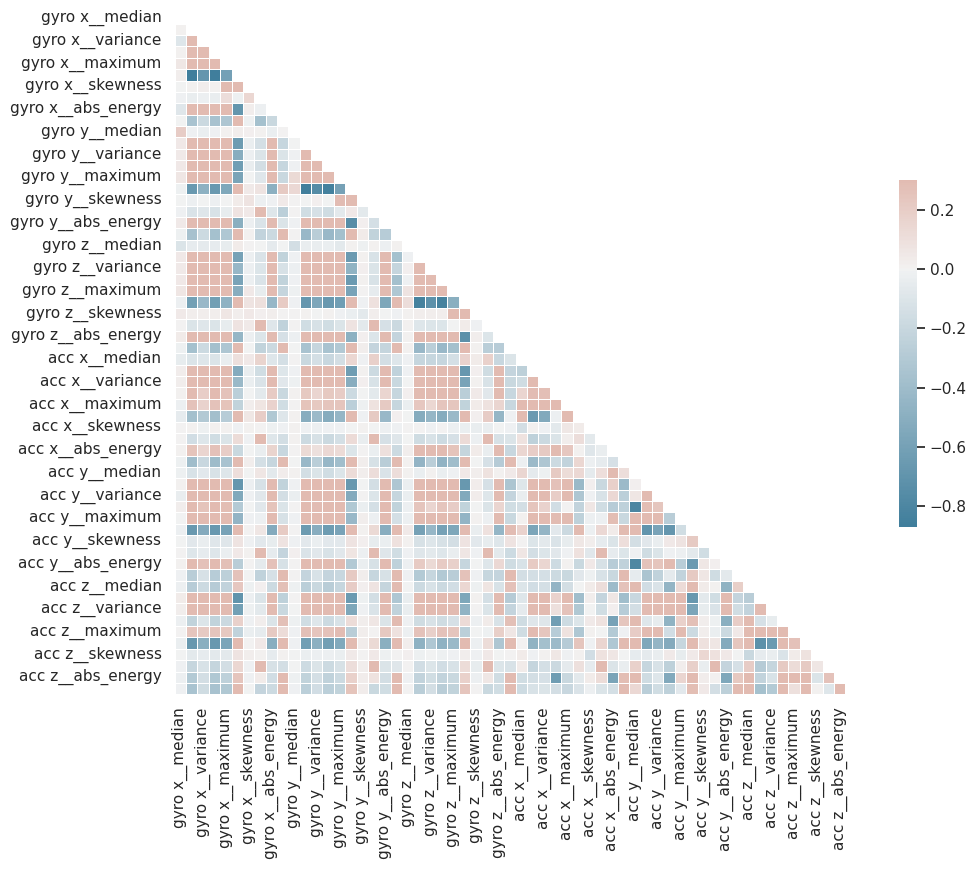

In [117]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

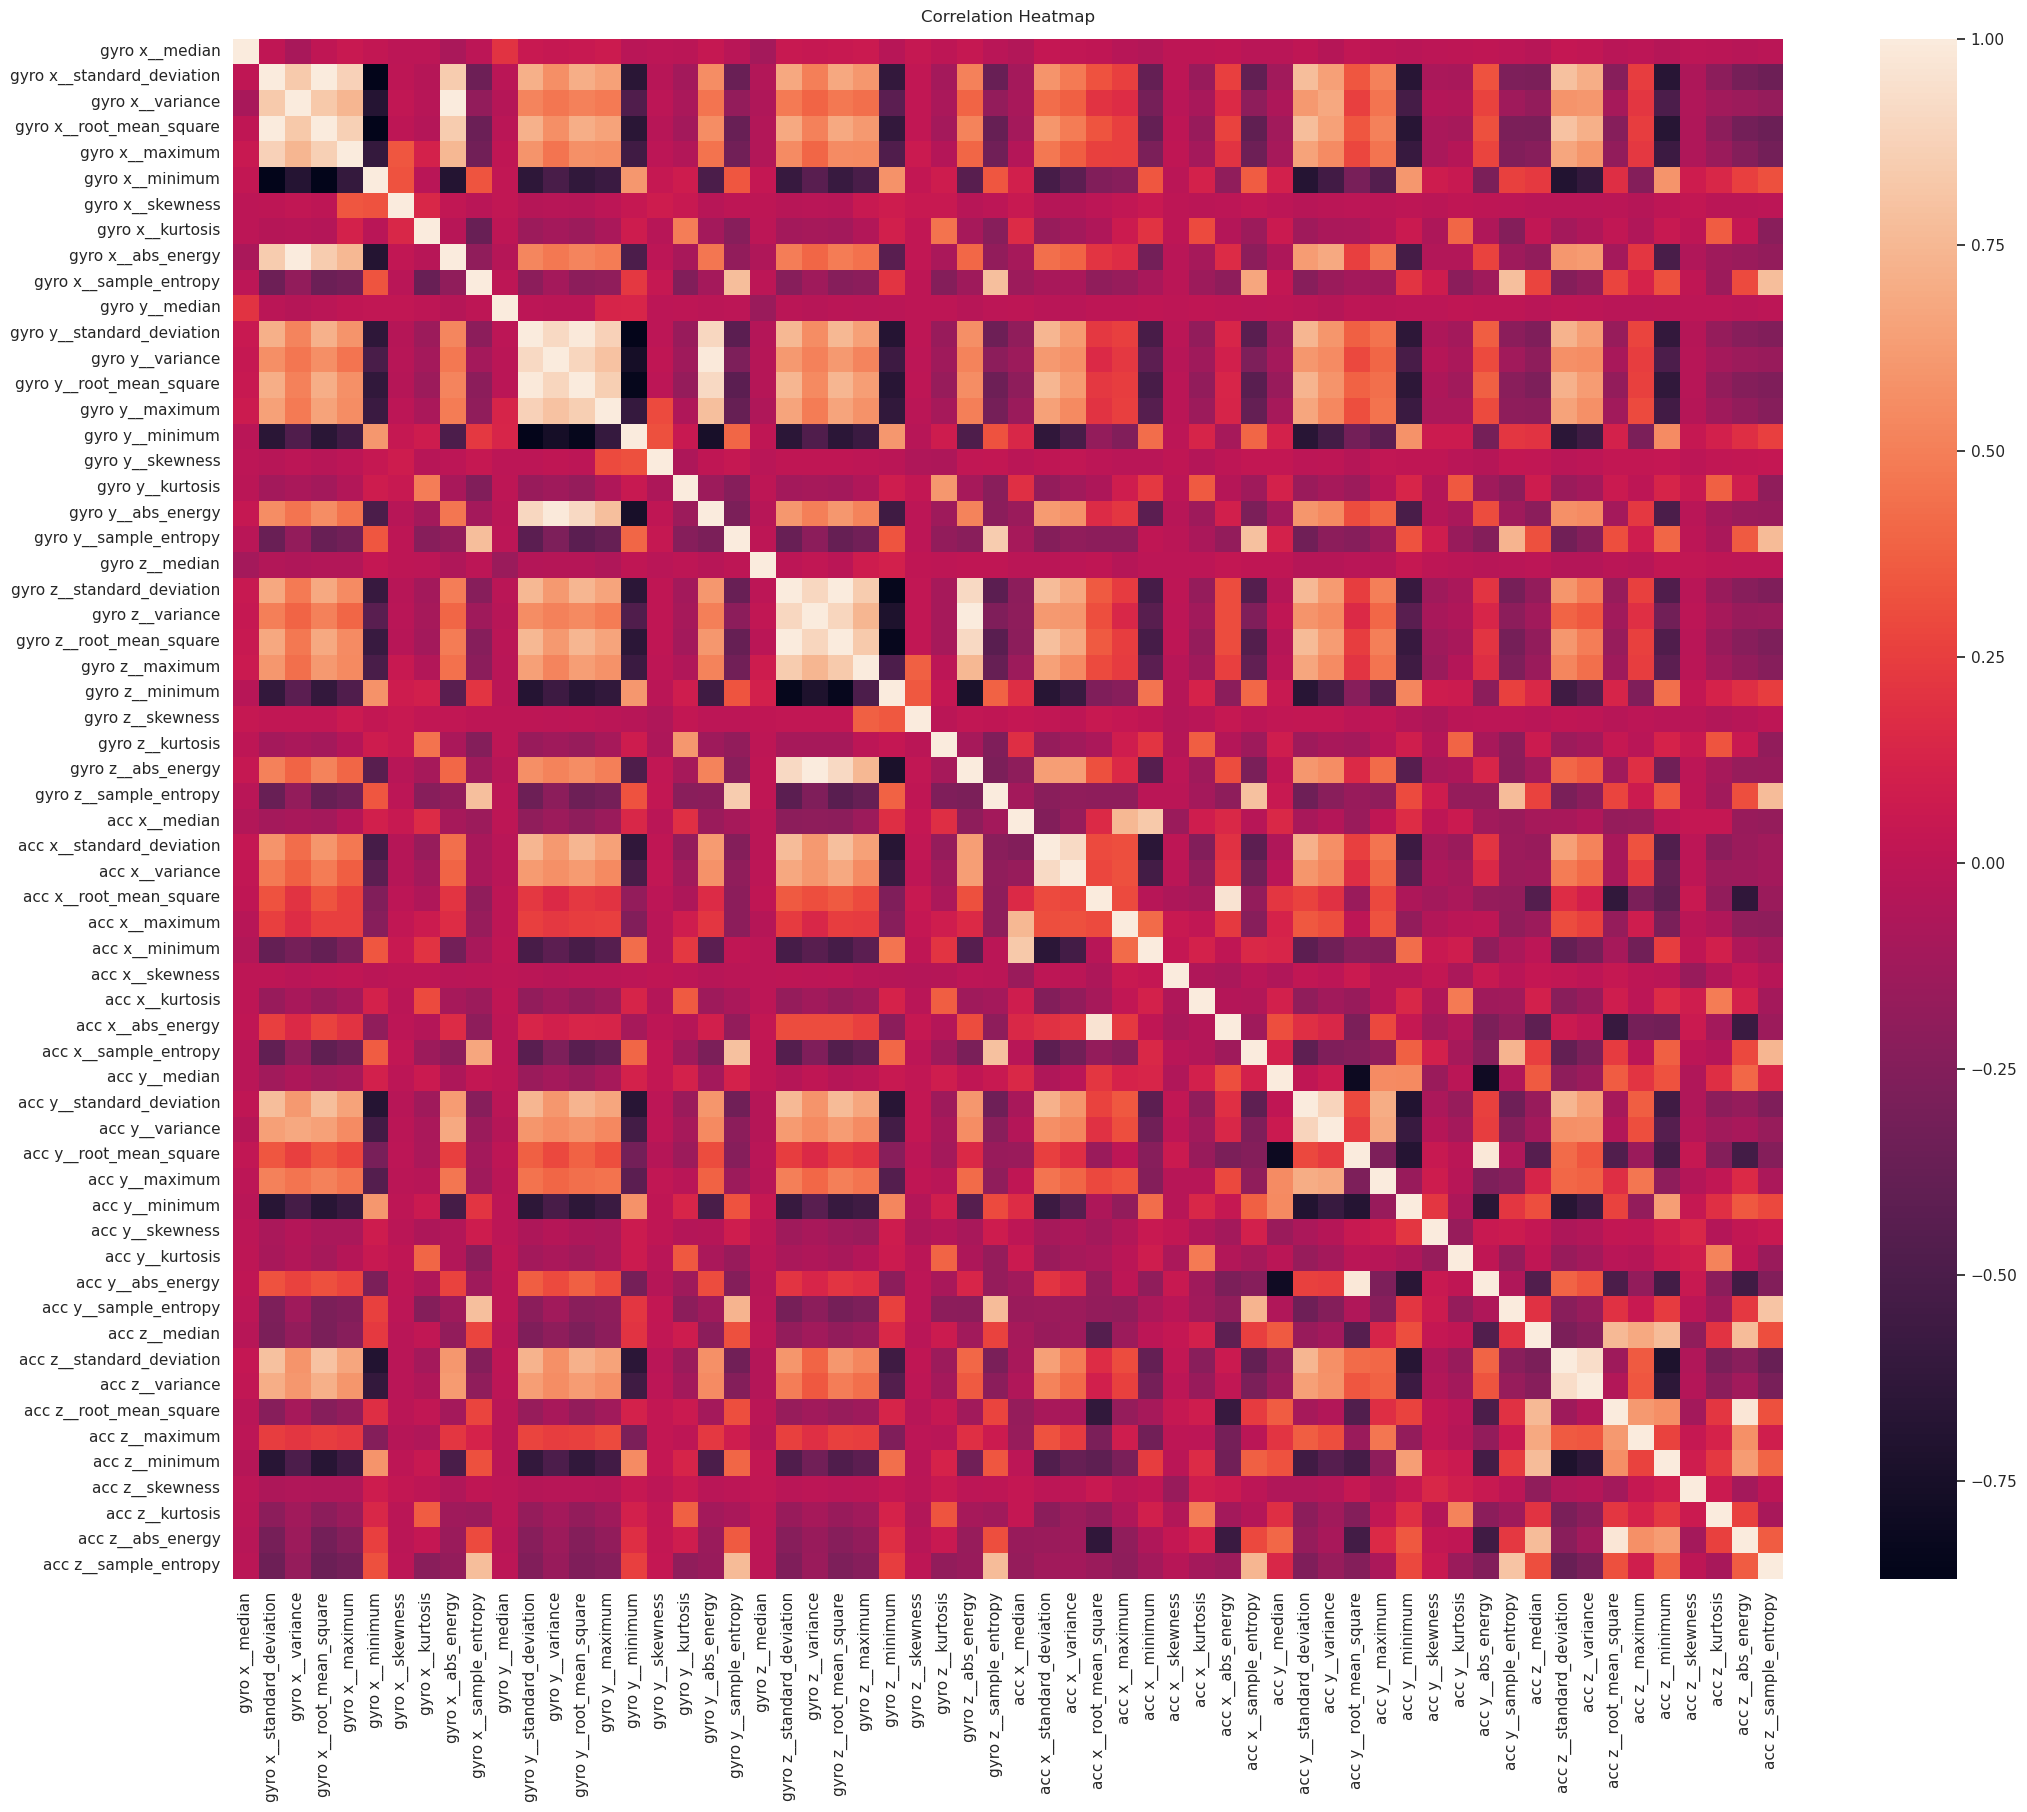

In [118]:
plt.figure(figsize=(25, 20))
heatmap = sns.heatmap(features.corr())
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [85]:
features.isna().any().any()

False

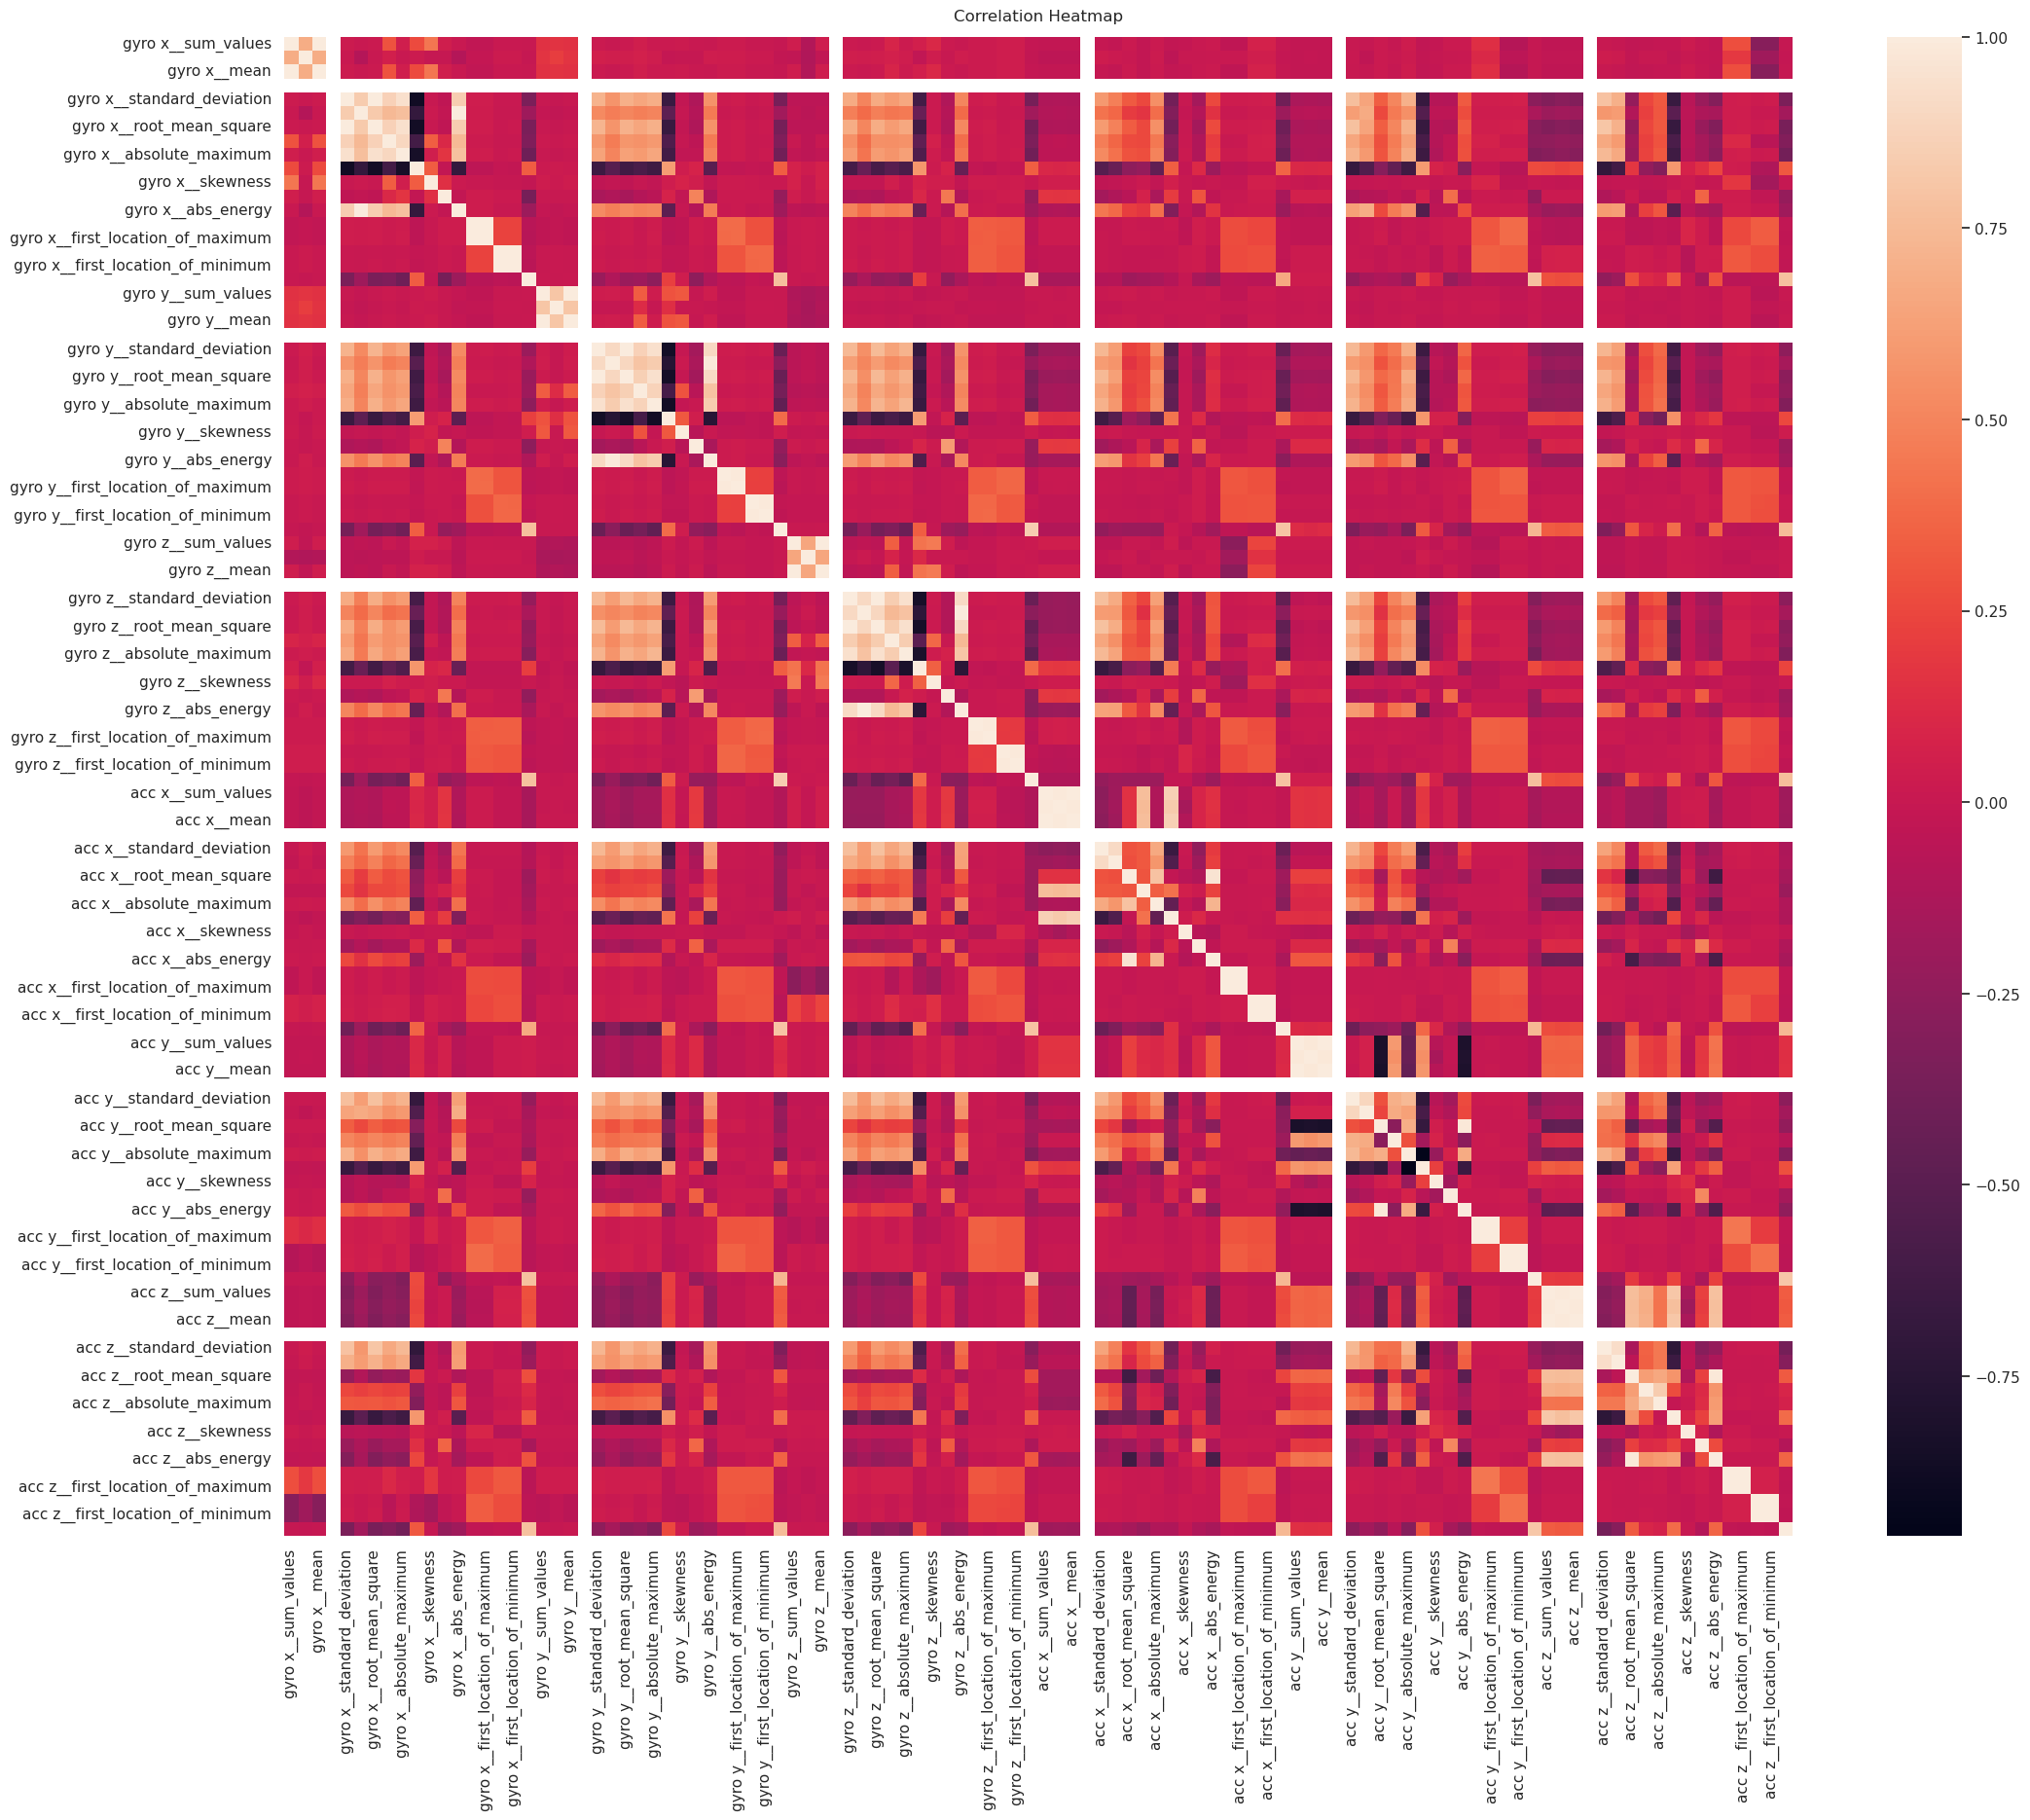

In [86]:
plt.figure(figsize=(25, 20))
crr = features[f].corr()
heatmap = sns.heatmap(corr)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [119]:
def handling_correlation(df,threshold=0.9):

    # creating set to hold the correlated features

    corr_features = set()

    # create the correlation matrix (default to pearson)

    corr_matrix = df.corr()

    #code for selecting all correleated features

    for i in range(len(corr_matrix .columns)):

        for j in range(i):

            if abs(corr_matrix.iloc[i, j]) >threshold:

                colname = corr_matrix.columns[i]

                corr_features.add(colname)

    return list(corr_features)

In [120]:
f = handling_correlation(features,0.9)
f

['acc x__abs_energy',
 'acc y__abs_energy',
 'gyro y__abs_energy',
 'gyro x__abs_energy',
 'gyro z__variance',
 'gyro z__root_mean_square',
 'acc z__variance',
 'acc z__abs_energy',
 'gyro z__abs_energy',
 'gyro y__variance',
 'acc x__variance',
 'gyro x__root_mean_square',
 'gyro y__root_mean_square']

In [92]:
len(f)

38

In [94]:
fff = features.columns.tolist()[:-1]

In [98]:
sel = VarianceThreshold(threshold=0.5)

In [99]:
Xn = pd.DataFrame(sel.fit_transform(features), columns = fff)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [57]:
MinimalFCParameters()

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

In [56]:
ComprehensiveFCParameters()

{'variance_larger_than_standard_deviation': None, 'has_duplicate_max': None, 'has_duplicate_min': None, 'has_duplicate': None, 'sum_values': None, 'abs_energy': None, 'mean_abs_change': None, 'mean_change': None, 'mean_second_derivative_central': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variation_coefficient': None, 'variance': None, 'skewness': None, 'kurtosis': None, 'root_mean_square': None, 'absolute_sum_of_changes': None, 'longest_strike_below_mean': None, 'longest_strike_above_mean': None, 'count_above_mean': None, 'count_below_mean': None, 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'last_location_of_minimum': None, 'first_location_of_minimum': None, 'percentage_of_reoccurring_values_to_all_values': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'sum_of_reoccurring_values': None, 'sum_of_reoccurring_data_points': None, 'ratio_value_number_to_time_series_length': None, 'sample_entropy': None, 

In [55]:
features = extract_features(raw, column_id='window_id', default_fc_parameters=ComprehensiveFCParameters(),n_jobs=32)
for i in features.columns.tolist():
    print(i)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.14it/s]


acc z__variance_larger_than_standard_deviation
acc z__has_duplicate_max
acc z__has_duplicate_min
acc z__has_duplicate
acc z__sum_values
acc z__abs_energy
acc z__mean_abs_change
acc z__mean_change
acc z__mean_second_derivative_central
acc z__median
acc z__mean
acc z__length
acc z__standard_deviation
acc z__variation_coefficient
acc z__variance
acc z__skewness
acc z__kurtosis
acc z__root_mean_square
acc z__absolute_sum_of_changes
acc z__longest_strike_below_mean
acc z__longest_strike_above_mean
acc z__count_above_mean
acc z__count_below_mean
acc z__last_location_of_maximum
acc z__first_location_of_maximum
acc z__last_location_of_minimum
acc z__first_location_of_minimum
acc z__percentage_of_reoccurring_values_to_all_values
acc z__percentage_of_reoccurring_datapoints_to_all_datapoints
acc z__sum_of_reoccurring_values
acc z__sum_of_reoccurring_data_points
acc z__ratio_value_number_to_time_series_length
acc z__sample_entropy
acc z__maximum
acc z__absolute_maximum
acc z__minimum
acc z__benfor

In [58]:
features

acc z__variance_larger_than_standard_deviation  acc z__has_duplicate_max  \
5                                             1.0                       0.0   

   acc z__has_duplicate_min  acc z__has_duplicate  acc z__sum_values  \
5                       0.0                   1.0          80.362489   

   acc z__abs_energy  acc z__mean_abs_change  acc z__mean_change  \
5        3772.965776                0.384987           -0.071063   

   acc z__mean_second_derivative_central  acc z__median  ...  \
5                               -0.00161       -1.80345  ...   

   gyro y__fourier_entropy__bins_5  gyro y__fourier_entropy__bins_10  \
5                          0.45522                          0.672009   

   gyro y__fourier_entropy__bins_100  \
5                           2.247821   

   gyro y__permutation_entropy__dimension_3__tau_1  \
5                                         1.632723   

   gyro y__permutation_entropy__dimension_4__tau_1  \
5                                         2.710507   

   gyro y__permutation_entropy__dimension_5__tau_1  \
5                                         3.688045   

   gyro y__permutation_entropy__dimension_6__tau_1  \
5                                         4.396221   

   gyro y__permutation_entropy__dimension_7__tau_1  \
5                                          4.75263   

   gyro y__query_similarity_count__query_None__threshold_0.0  \
5                                                NaN           

   gyro y__mean_n_absolute_max__number_of_maxima_7  
5                                         0.464432  

[1 rows x 4698 columns]

In [48]:
features_filtered_direct = extract_relevant_features(raw, y,
                                                     column_id='window_id',
                                                     default_fc_parameters=ComprehensiveFCParameters(),n_jobs=32)

AssertionError: Feature selection is only possible if more than 1 label/class is provided

In [41]:
features = extract_features(raw, column_id='window_id', default_fc_parameters=MinimalFCParameters(),n_jobs=32)
features

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:05<00:00, 30.83it/s]


acc x__sum_values  acc x__median  acc x__mean  acc x__length  \
0            -402.051945      -2.484833    -2.680346          150.0   
1            -278.967097      -1.847758    -1.859781          150.0   
2             421.463580       3.119513     2.809757          150.0   
3             872.917595       5.561235     5.819451          150.0   
4            1142.750089       7.660470     7.618334          150.0   
...                  ...            ...          ...            ...   
11105        -394.730369       0.323328    -2.631536          150.0   
11106         248.339586       1.592688     1.655597          150.0   
11107         186.675016       1.300496     1.244500          150.0   
11108         532.831993       2.418970     3.552213          150.0   
11109        1202.683053       8.018526     8.017887          150.0   

       acc x__standard_deviation  acc x__variance  acc x__root_mean_square  \
0                       2.867042         8.219932                 3.924817   
1                       0.415219         0.172407                 1.905568   
2                       3.390593        11.496123                 4.403505   
3                       0.812130         0.659554                 5.875845   
4                       1.442257         2.080105                 7.753652   
...                          ...              ...                      ...   
11105                   4.775180        22.802340                 5.452277   
11106                   0.578019         0.334105                 1.753598   
11107                   2.411609         5.815856                 2.713786   
11108                   3.970811        15.767336                 5.327810   
11109                   0.004625         0.000021                 8.017888   

       acc x__maximum  acc x__absolute_maximum  acc x__minimum  ...  \
0            9.733359                 9.733359       -8.720266  ...   
1            0.129331                 4.342171       -4.342171  ...   
2           11.742782                11.742782       -4.327800  ...   
3            8.806487                 8.806487        4.330195  ...   
4           13.632452                13.632452        1.027463  ...   
...               ...                      ...             ...  ...   
11105        2.814148                11.936778      -11.936778  ...   
11106        2.830913                 2.830913       -0.373623  ...   
11107       12.351116                12.351116       -7.232959  ...   
11108       26.316475                26.316475       -2.280059  ...   
11109        8.030500                 8.030500        8.006551  ...   

       gyro z__sum_values  gyro z__median  gyro z__mean  gyro z__length  \
0              100.018149        0.134390      0.666788           150.0   
1               -1.772730       -0.003665     -0.011818           150.0   
2                8.134278        0.040317      0.054229           150.0   
3              -13.804328       -0.018937     -0.092029           150.0   
4                2.896722        0.035430      0.019311           150.0   
...                   ...             ...           ...             ...   
11105           -7.808077       -0.001222     -0.052054           150.0   
11106           10.049951        0.026267      0.067000           150.0   
11107           29.371612        0.013439      0.195811           150.0   
11108          -25.248273       -0.024435     -0.168322           150.0   
11109           -0.395841       -0.002443     -0.002639           150.0   

       gyro z__standard_deviation  gyro z__variance  gyro z__root_mean_square  \
0                        0.944786      8.926202e-01                  1.156385   
1                        0.171325      2.935235e-02                  0.171732   
2                        0.821637      6.750875e-01                  0.823425   
3                        0.551304      3.039363e-01                  0.558933   
4                        0.600035      3.600415e-01       

In [42]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11110 entries, 0 to 11109
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   acc x__sum_values           11110 non-null  float64
 1   acc x__median               11110 non-null  float64
 2   acc x__mean                 11110 non-null  float64
 3   acc x__length               11110 non-null  float64
 4   acc x__standard_deviation   11110 non-null  float64
 5   acc x__variance             11110 non-null  float64
 6   acc x__root_mean_square     11110 non-null  float64
 7   acc x__maximum              11110 non-null  float64
 8   acc x__absolute_maximum     11110 non-null  float64
 9   acc x__minimum              11110 non-null  float64
 10  acc y__sum_values           11110 non-null  float64
 11  acc y__median               11110 non-null  float64
 12  acc y__mean                 11110 non-null  float64
 13  acc y__length               111

In [85]:
df[df["relabeled"]==2]["relabeled"].mode()[0]

2

In [19]:
settings = {
    'mean': {
        'window_size': 100,
        'min_periods': 10
    },
    'std': {
        'window_size': 100,
        'min_periods': 10
    },
    'mad': {
        'window_size': 100,
        'min_periods': 10
    },
    'max': {
        'window_size': 100,
        'min_periods': 10
    },
    'min': {
        'window_size': 100,
        'min_periods': 10
    },
    'sma': {
        'window_size': 100,
        'min_periods': 10
    },
    'energy': {
        'window_size': 100,
        'min_periods': 10
    },
    'iqr': {
        'window_size': 100,
        'min_periods': 10
    },
    'entropy': {
        'window_size': 100,
        'min_periods': 10
    },
    'arCoeff': {
        'window_size': 100,
        'min_periods': 10,
        'order': 4
    },
    'correlation': {
        'window_size': 100,
        'min_periods': 10
    },
    'maxInds': {
        'window_size': 100,
        'min_periods': 10
    },
    'meanFreq': {
        'window_size': 100,
        'min_periods': 10
    },
    'skewness': {
        'window_size': 100,
        'min_periods': 10
    },
    'kurtosis': {
        'window_size': 100,
        'min_periods': 10
    },
    'bandsEnergy': {
        'window_size': 100,
        'min_periods': 10,
        'bins': 64
    },
    'angle': {
        'window_size': 100,
        'min_periods': 10
    }
}

In [86]:
cc = df[:100].copy()
cc

datetime     acc x     acc y     acc z    gyro x    gyro y  \
0  2021-12-14 06:36:42.000 -0.350948 -0.091122 -0.057664  0.037033  0.031348   
1  2021-12-14 06:36:42.020 -2.258345 -0.281957 -0.968094 -0.019066  0.090931   
2  2021-12-14 06:36:42.040 -2.617663 -0.652827 -0.142485 -0.146803 -0.311150   
3  2021-12-14 06:36:42.060 -1.569570 -1.582325  2.623511 -0.542968 -0.978224   
4  2021-12-14 06:36:42.080 -0.763251 -2.923762  5.022452 -1.093060 -1.657998   
..                     ...       ...       ...       ...       ...       ...   
95 2021-12-14 06:36:43.900  1.802523  0.777967  0.206738 -0.219573  0.467572   
96 2021-12-14 06:36:43.920  1.765069  0.778295  0.213957 -0.102945  0.483700   
97 2021-12-14 06:36:43.940  1.765040  0.802587 -0.208855 -0.097316  0.463509   
98 2021-12-14 06:36:43.960  1.644579  0.699094 -0.475045 -0.131212  0.397427   
99 2021-12-14 06:36:43.980  1.468686  0.475704 -0.228150 -0.163373  0.299845   

      gyro z  ignore  relabeled  
0   0.161043       0          0  
1   0.393886       0          0  
2   0.993344       0          0  
3   1.949535       0          0  
4   2.839213       0          0  
..       ...     ...        ...  
95 -0.449909       0          0  
96 -0.427793       0          0  
97 -0.435773       0          0  
98 -0.436603       0          0  
99 -0.402651       0          0  

[100 rows x 9 columns]

In [87]:
cc["relabeled"]= 2
cc

datetime     acc x     acc y     acc z    gyro x    gyro y  \
0  2021-12-14 06:36:42.000 -0.350948 -0.091122 -0.057664  0.037033  0.031348   
1  2021-12-14 06:36:42.020 -2.258345 -0.281957 -0.968094 -0.019066  0.090931   
2  2021-12-14 06:36:42.040 -2.617663 -0.652827 -0.142485 -0.146803 -0.311150   
3  2021-12-14 06:36:42.060 -1.569570 -1.582325  2.623511 -0.542968 -0.978224   
4  2021-12-14 06:36:42.080 -0.763251 -2.923762  5.022452 -1.093060 -1.657998   
..                     ...       ...       ...       ...       ...       ...   
95 2021-12-14 06:36:43.900  1.802523  0.777967  0.206738 -0.219573  0.467572   
96 2021-12-14 06:36:43.920  1.765069  0.778295  0.213957 -0.102945  0.483700   
97 2021-12-14 06:36:43.940  1.765040  0.802587 -0.208855 -0.097316  0.463509   
98 2021-12-14 06:36:43.960  1.644579  0.699094 -0.475045 -0.131212  0.397427   
99 2021-12-14 06:36:43.980  1.468686  0.475704 -0.228150 -0.163373  0.299845   

      gyro z  ignore  relabeled  
0   0.161043       0          2  
1   0.393886       0          2  
2   0.993344       0          2  
3   1.949535       0          2  
4   2.839213       0          2  
..       ...     ...        ...  
95 -0.449909       0          2  
96 -0.427793       0          2  
97 -0.435773       0          2  
98 -0.436603       0          2  
99 -0.402651       0          2  

[100 rows x 9 columns]

In [80]:
df['relabeled'].mode()

0    0
Name: relabeled, dtype: uint8

In [24]:
len(windows)

14303

In [31]:
def check_any_consecutive_dataframes_equal(df_list):
    """
    Checks if any consecutive DataFrames have the same values.
    
    Args:
    df_list (list): List of consecutive DataFrames.
    
    Returns:
    bool: True if any consecutive DataFrames have the same values, False otherwise.
    """
    for i in range(len(df_list) - 1):
        if df_list[i].equals(df_list[i + 1]):
            print(f"Equal at {i} and {i+1}")
            return True
    return False

In [32]:
check_consecutive_dataframes_equal(windows)

False

In [9]:

# Sample usage
# Load your dataset into a DataFrame
data = {
    'time': [0, 0.02, 0.04, 0.06, 0.08, 0.1],
    'accel_x': [1.2, 1.5, 0.8, 0.7, 1.1, 0.9],
    'accel_y': [0.3, 0.5, 0.2, 0.1, 0.4, 0.6],
    'accel_z': [0.9, 1.2, 0.7, 0.6, 1.0, 0.8]
}
df = pd.DataFrame(data)

# Parameters for filtering
cutoff_frequency = 2.0  # Adjust based on your data and requirements
sampling_rate = 50.0   # Hz
order = 6

# Apply filtering to accelerometer data
for col in ['accel_x', 'accel_y', 'accel_z']:
    df[col] = butter_lowpass_filter(df[col], cutoff_frequency, sampling_rate, order)

# Print the filtered data
print(df)

   time   accel_x       accel_y   accel_z
0  0.00  0.000003  7.491668e-07  0.000002
1  0.02  0.000037  9.511500e-06  0.000028
2  0.04  0.000223  5.911967e-05  0.000169
3  0.06  0.000896  2.423982e-04  0.000686
4  0.08  0.002724  7.466221e-04  0.002101
5  0.10  0.006756  1.866773e-03  0.005248


In [140]:
df_new

datetime     acc x     acc y     acc z    gyro x  \
0       2021-12-14 06:36:42.000 -0.350948 -0.091122 -0.057664  0.037033   
1       2021-12-14 06:36:42.020 -2.258345 -0.281957 -0.968094 -0.019066   
2       2021-12-14 06:36:42.040 -2.617663 -0.652827 -0.142485 -0.146803   
3       2021-12-14 06:36:42.060 -1.569570 -1.582325  2.623511 -0.542968   
4       2021-12-14 06:36:42.080 -0.763251 -2.923762  5.022452 -1.093060   
...                         ...       ...       ...       ...       ...   
9353618 2021-12-15 20:18:00.920  0.010231  0.004656 -0.001566  0.000173   
9353619 2021-12-15 20:18:00.940  0.007179 -0.003588 -0.006952  0.000127   
9353620 2021-12-15 20:18:00.960  0.001033 -0.003791 -0.002939  0.000172   
9353621 2021-12-15 20:18:00.980 -0.001998  0.002827  0.002702  0.000156   
9353622 2021-12-15 20:18:01.000 -0.001369  0.003415  0.003034  0.000137   

           gyro y    gyro z  relabeled  window_id  
0        0.031348  0.161043          0          0  
1        0.090931  0.393886          0          0  
2       -0.311150  0.993344          0          0  
3       -0.978224  1.949535          0          0  
4       -1.657998  2.839213          0          0  
...           ...       ...        ...        ...  
9353618  0.000099  0.000120          0        101  
9353619  0.000376  0.000095          0        101  
9353620  0.000057  0.000149          0        101  
9353621 -0.000384  0.000149          0        101  
9353622 -0.000446  0.000042          0        101  

[1666500 rows x 9 columns]

In [138]:
df_features = df_new.drop(['relabeled','datetime'], axis=1, inplace=False)
features_list = extract_features(df_features, column_id="window_id", default_fc_parameters=MinimalFCParameters(), n_jobs=12)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.58it/s]


In [139]:
features_list

acc z__sum_values  acc z__median  acc z__mean  acc z__length  \
0            39.259067       0.006326     0.005948         6600.0   
1          -103.537823       0.003382    -0.015688         6600.0   
2           -27.433791      -0.000736    -0.004157         6600.0   
3            38.322839       0.001381     0.005806         6600.0   
4           109.014973      -0.007027     0.016517         6600.0   
..                 ...            ...          ...            ...   
251          16.044071       0.001617     0.002487         6450.0   
252          85.114418      -0.012786     0.013196         6450.0   
253          80.992289      -0.004570     0.012557         6450.0   
254         -74.342140       0.016781    -0.011526         6450.0   
255         111.629745       0.003434     0.017307         6450.0   

     acc z__standard_deviation  acc z__variance  acc z__root_mean_square  \
0                     1.628295         2.651345                 1.628306   
1                     1.369714         1.876115                 1.369803   
2                     1.422203         2.022661                 1.422209   
3                     1.434219         2.056983                 1.434231   
4                     1.435924         2.061878                 1.436019   
..                         ...              ...                      ...   
251                   1.496561         2.239694                 1.496563   
252                   1.395463         1.947318                 1.395526   
253                   1.466313         2.150073                 1.466366   
254                   1.407063         1.979827                 1.407110   
255                   1.450334         2.103469                 1.450437   

     acc z__maximum  acc z__absolute_maximum  acc z__minimum  ...  \
0         12.380889                14.644854      -14.644854  ...   
1         12.079421                12.079421       -9.230822  ...   
2         19.895743                19.895743      -11.182761  ...   
3          9.046870                 9.046870       -6.542836  ...   
4         11.695935                11.695935       -8.231382  ...   
..              ...                      ...             ...  ...   
251       14.882106                14.882106      -14.648471  ...   
252       19.155827                19.155827       -7.674570  ...   
253       12.977969                13.386677      -13.386677  ...   
254        9.478109                10.776988      -10.776988  ...   
255       17.852111                17.852111      -10.414147  ...   

     acc y__sum_values  acc y__median  acc y__mean  acc y__length  \
0           -61.981910       0.012631    -0.009391         6600.0   
1          -111.160391      -0.007318    -0.016842         6600.0   
2           112.080649       0.010295     0.016982         6600.0   
3           -62.953113      -0.004341    -0.009538         6600.0   
4           143.763413       0.003155     0.021782         6600.0   
..                 ...            ...          ...            ...   
251          41.229527       0.003333     0.006392         6450.0   
252        -131.199990      -0.002996    -0.020341         6450.0   
253         306.508268       0.023241     0.047521         6450.0   
254        -134.017406       0.014689    -0.020778         6450.0   
255         -95.954929      -0.009749    -0.014877         6450.0   

     acc y__standard_deviation  acc y__variance  acc y__root_mean_square  \
0                     1.568950         2.461604                 1.568978   
1                     1.325122         1.755949                 1.325229   
2                     1.346928         1.814216                 1.347036   
3                     1.408899         1.984997                 1.408931   
4                     1.480794         2.192751                 1.480954   
..                         ...              ...                      ...   
251                   1.696001         2.876421                 1.696013 

In [ ]:
extract_features(df, column_id="id", column_kind="kind", 
                 column_value="value", column_sort="time")

In [126]:
extraction_settings = MinimalFCParameters()
df_features = df_new.drop(['relabeled', 'datetime'], axis=1, inplace=False)
features_filtered_direct = extract_relevant_features(df_features, df_new["relabeled"],
                                                     column_id='window_id',
                                                     default_fc_parameters=extraction_settings)

ValueError: The following ids are in the time series container but are missing in y: {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef,average_precision_score

In [8]:
dm.generate_name("")

'2023-08-30_18-15-51'

## Global Variables

In [9]:
WINDOW_TIME = 3 # Seconds
FREQUENCY = 50 # 50Hz
WINDOW_SIZE = WINDOW_TIME*FREQUENCY
DIR = "/data/OCDetect_Export"
DROP_STATS = ["count"] # Stats to drop
IGNORE_LIST = [val for val in range(1,7)] # Ignore types
LABELS = ['Others','Routine HW', 'Compulsive HW']

## Setup

In [10]:
warnings.filterwarnings("ignore")

## Data Models

## Utils

In [11]:
logger.info("Running Notebook.")

2023-08-30 18:16:04 - INFO - Running Notebook.


### Directory Utils

### Dataframe Utils

### Object's Utils

### List and Dict Utils

## Classical ML

**Supported classifiers:**
- logistic_regression
- random_forest 
- gradient_boosting
- svm 
- kmeans
- neuralnetwork
- SGDClassifier
- MultinominalNB
- PassiveAggressiveClassifier
- Perceptron

In [10]:
def get_labels_counts(grouped_csv_files, folder= "OCDetect_Export"):
    
    #Subjects
    subjects = sorted(grouped_csv_files.keys())
    
    # Empty dict
    labels_counts_by_subject = {}
    
    # Loop and read csv files
    
    print("=="*20)
    if (folder == "OCDetect_Export"):
        print("| Subject | S.NO. | File | Ignored | rHW | cHW | Others | total |")
        print("|---------|-------|------|---------|-----|-----|--------|-------|")
    else:
        print("| Subject | S.NO. | File | rHW | cHW | Others | total |")
        print("|---------|-------|------|-----|-----|--------|-------|")
    
    
    for index, subject in enumerate(subjects):
        
        # Counts
        rHW_count = 0
        cHW_count = 0
        other_count = 0
        
        files_counts = []
    
        files = sorted(grouped_csv_files[subject])
        total = len(files)
        # Loop over files
        for index, file in enumerate(files):
        
            if file in CSV_BLACK_LIST:
                print(f"Skipping CSV file:{file}")
                continue
            
            # Read the CSV file
            df = dfm.read_csv_file(file, folder)
                        
            # Filtered ignored types
            df_filtered = dfm.filter_ignored_rows(df)
            df_filtered_len = len(df_filtered)
            ignored_total = len(df) - df_filtered_len
            
            # Get labels counts without ignored types
            counts = dfm.count_labels(df_filtered)
            
            
            if counts:
                # Get per file counts
                per_file = {file:
                            {"cHW":counts[2],
                            "rHW":counts[1],
                            "NULL":counts[0],
                            "ignored":ignored_total
                            }
                           }

                # Append per files
                files_counts.append(per_file)

                cHW_count += counts[2]
                rHW_count += counts[1]
                other_count += counts[0]
                
                if (folder == "OCDetect_Export"):
                    print(f"| {subject} | {index+1} | {file} | {ignored_total} | {counts[1]} | {counts[2]} | {counts[0]} | {df_filtered_len} |")
                else:
                    print(f"| {subject} | {index+1} | {file} | {counts[1]} | {counts[2]} | {counts[0]} | {df_filtered_len} |")


            else:
                CSV_BLACK_LIST.append(file)
                print(f"File has been black listed {subject} : {file}")
        
                       
        # save counts in dict
        labels_counts = {
                "cHW":cHW_count,
                "rHW":rHW_count,
                "NULL":other_count,
                "files":files_counts
            }
        
        
        
        #print(f"For subject {subject}: {labels_counts}")
        
        labels_counts_by_subject[subject] = labels_counts
    
    return labels_counts_by_subject

In [11]:
labels_distribution = get_labels_counts(grouped_csv_files, "stats")

| Subject | S.NO. | File | rHW | cHW | Others | total |
|---------|-------|------|-----|-----|--------|-------|
| 01 | 1 | OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0-stats.csv | 0 | 0 | 97 | 97 |
| 01 | 2 | OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6-stats.csv | 0 | 0 | 344 | 344 |
| 01 | 3 | OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d-stats.csv | 12 | 37 | 2916 | 2965 |
| 01 | 4 | OCDetect_01_recording_03_1a9d0d33-ff9c-479f-99d0-f0b9c39c92a7-stats.csv | 0 | 75 | 11686 | 11761 |
| 01 | 5 | OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d-stats.csv | 0 | 0 | 22 | 22 |
| 01 | 6 | OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7-stats.csv | 37 | 95 | 11751 | 11883 |
| 01 | 7 | OCDetect_01_recording_06_839c3df9-a71d-4520-9973-9c5344740611-stats.csv | 0 | 94 | 11682 | 11776 |
| 01 | 8 | OCDetect_01_recording_07_2bd04f5f-7069-4f92-964e-59075a36d8fe-stats.csv | 25 | 73 | 11616 | 11714 |
| 01 | 9 | OCDetect_01_rec

| 02 | 35 | OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c-stats.csv | 64 | 0 | 8160 | 8224 |
| 03 | 1 | OCDetect_03_recording_00_c9aacb49-e9ac-473c-8884-470e8e259819-stats.csv | 0 | 0 | 63 | 63 |
| 03 | 2 | OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76-stats.csv | 0 | 0 | 8 | 8 |
| 03 | 3 | OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11-stats.csv | 0 | 0 | 7 | 7 |
| 03 | 4 | OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b946-stats.csv | 0 | 0 | 10 | 10 |
| 03 | 5 | OCDetect_03_recording_04_0a48395d-614f-497c-ab71-0d579d74ce27-stats.csv | 0 | 12 | 115 | 127 |
| 03 | 6 | OCDetect_03_recording_05_382535ec-9a0d-4359-b120-47f7605a22de-stats.csv | 37 | 65 | 5201 | 5303 |
| 03 | 7 | OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3-stats.csv | 153 | 76 | 11664 | 11893 |
| 03 | 8 | OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909-stats.csv | 91 | 38 | 7455 | 7584 |
| 03 | 9 | OCDetect_03_recording_08_f08133be-a4

| 05 | 10 | OCDetect_05_recording_09_299a1895-ee80-4ac8-aa6b-8c52149ee283-stats.csv | 227 | 0 | 5747 | 5974 |
| 05 | 11 | OCDetect_05_recording_10_43ffde6b-8abf-4e8a-b0aa-00516d9a71a0-stats.csv | 239 | 0 | 8641 | 8880 |
| 05 | 12 | OCDetect_05_recording_11_83af51cf-f58d-4710-8793-71c78c1ed302-stats.csv | 13 | 0 | 812 | 825 |
| 05 | 13 | OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5-stats.csv | 77 | 0 | 2559 | 2636 |
| 05 | 14 | OCDetect_05_recording_13_81207860-82a1-4e9b-9d77-471d9c124661-stats.csv | 0 | 0 | 17 | 17 |
| 05 | 15 | OCDetect_05_recording_14_cda9f6d0-12a2-4f90-b16b-a7b837ef5b7e-stats.csv | 0 | 0 | 49 | 49 |
| 05 | 16 | OCDetect_05_recording_15_30007bfa-4f85-49d7-a6ff-b214722ec361-stats.csv | 0 | 0 | 46 | 46 |
| 05 | 17 | OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b-stats.csv | 26 | 0 | 4138 | 4164 |
| 05 | 18 | OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1-stats.csv | 129 | 0 | 9862 | 9991 |
| 05 | 19 | OCDetect_05_recording

| 09 | 19 | OCDetect_09_recording_18_8c249737-cd58-444a-a22d-a2b49bef1a0c-stats.csv | 25 | 0 | 6705 | 6730 |
| 09 | 20 | OCDetect_09_recording_19_cec2f783-3877-4cac-a485-e114357ab17a-stats.csv | 57 | 0 | 4509 | 4566 |
| 09 | 21 | OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815-stats.csv | 45 | 13 | 8462 | 8520 |
| 09 | 22 | OCDetect_09_recording_21_0ccaf391-2a0c-4947-bbd0-e59ffe6b68b3-stats.csv | 0 | 0 | 62 | 62 |
| 09 | 23 | OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3-stats.csv | 3 | 0 | 246 | 249 |
| 09 | 24 | OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5-stats.csv | 0 | 0 | 19 | 19 |
| 09 | 25 | OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21-stats.csv | 2 | 0 | 157 | 159 |
| 09 | 26 | OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71-stats.csv | 0 | 0 | 16 | 16 |
| 09 | 27 | OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c-stats.csv | 0 | 0 | 9 | 9 |
| 09 | 28 | OCDetect_09_recording_27_69974e1d-

| 11 | 35 | OCDetect_11_recording_34_3e84dad6-ddb8-4164-b42b-072a1f0acd83-stats.csv | 25 | 25 | 5878 | 5928 |
| 11 | 36 | OCDetect_11_recording_35_d5ad012a-c063-4896-a987-ef49b2d9f4c5-stats.csv | 12 | 13 | 7495 | 7520 |
| 11 | 37 | OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372-stats.csv | 38 | 25 | 13155 | 13218 |
| 11 | 38 | OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0-stats.csv | 38 | 26 | 16758 | 16822 |
| 11 | 39 | OCDetect_11_recording_38_4531c7b2-1578-485f-adc9-c259f18e35cb-stats.csv | 13 | 13 | 2464 | 2490 |
| 11 | 40 | OCDetect_11_recording_39_56cda679-12d0-40ec-a4c5-971c6db793a9-stats.csv | 30 | 0 | 9791 | 9821 |
| 11 | 41 | OCDetect_11_recording_40_8ad59388-e13d-4329-b082-d64959508b4f-stats.csv | 37 | 13 | 4855 | 4905 |
| 11 | 42 | OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3-stats.csv | 0 | 0 | 697 | 697 |
| 11 | 43 | OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d-stats.csv | 0 | 0 | 408 | 408 |
| 11 | 44 | OCD

| 18 | 7 | OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831-stats.csv | 113 | 178 | 9802 | 10093 |
| 18 | 8 | OCDetect_18_recording_07_54be62f3-759e-41d2-be18-37c74bda3144-stats.csv | 38 | 101 | 6335 | 6474 |
| 18 | 9 | OCDetect_18_recording_08_659f5155-4d9f-4919-988c-4ea4015ecf84-stats.csv | 0 | 0 | 16 | 16 |
| 18 | 10 | OCDetect_18_recording_09_754aa1e0-a657-4871-a39c-9af361e99275-stats.csv | 0 | 0 | 25 | 25 |
| 18 | 11 | OCDetect_18_recording_10_551a84e6-24ab-49b9-aebc-6dcfe43c39a2-stats.csv | 0 | 0 | 41 | 41 |
| 18 | 12 | OCDetect_18_recording_11_96c2f6f5-546e-467b-bc93-9932dc050cdb-stats.csv | 37 | 143 | 5881 | 6061 |
| 18 | 13 | OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45-stats.csv | 38 | 224 | 6506 | 6768 |
| 18 | 14 | OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471-stats.csv | 26 | 113 | 7735 | 7874 |
| 18 | 15 | OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e-stats.csv | 0 | 89 | 7488 | 7577 |
| 18 | 16 | OCDetect_18_r

| 20 | 10 | OCDetect_20_recording_09_304786b1-f5dd-4328-9b4a-995326c91dba-stats.csv | 13 | 176 | 6535 | 6724 |
| 20 | 11 | OCDetect_20_recording_10_10bb8ed5-63db-40c1-a819-5abb8ffeed00-stats.csv | 13 | 192 | 9088 | 9293 |
| 20 | 12 | OCDetect_20_recording_11_e3f1033b-8478-4d5d-9200-2bf8e71e5627-stats.csv | 13 | 63 | 2662 | 2738 |
| 20 | 13 | OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695-stats.csv | 26 | 165 | 9315 | 9506 |
| 20 | 14 | OCDetect_20_recording_13_cce4125c-2272-4624-97c2-122b81cc37fc-stats.csv | 0 | 212 | 10113 | 10325 |
| 20 | 15 | OCDetect_20_recording_14_cea3c57a-8a8c-41ff-8f0b-6b00af3caeaa-stats.csv | 0 | 203 | 10525 | 10728 |
| 20 | 16 | OCDetect_20_recording_15_335c0b28-bdf1-4c49-8dab-603f4912aa7b-stats.csv | 0 | 116 | 11430 | 11546 |
| 20 | 17 | OCDetect_20_recording_16_8dbc0d78-b602-4f38-91de-6f42c9bd2b9d-stats.csv | 0 | 116 | 11430 | 11546 |
| 20 | 18 | OCDetect_20_recording_17_58f04fad-2d28-4f25-8ef8-aca14d48917d-stats.csv | 0 | 0 | 127 | 127 |
| 2

| 22 | 5 | OCDetect_22_recording_04_35bf0e5b-63a5-4123-b816-d5ccd5097389-stats.csv | 22 | 22 | 12845 | 12889 |
| 22 | 6 | OCDetect_22_recording_05_bd7c18a9-cd01-4d92-a7ea-69fa7cd7439d-stats.csv | 6 | 0 | 7 | 13 |
| 22 | 7 | OCDetect_22_recording_06_05881326-aab1-440e-a45b-8900a053047c-stats.csv | 13 | 55 | 2274 | 2342 |
| 22 | 8 | OCDetect_22_recording_07_137e5ee3-df51-439c-a7d0-def62b53961e-stats.csv | 0 | 72 | 7853 | 7925 |
| 22 | 9 | OCDetect_22_recording_08_59db29c1-05dc-4794-9b54-4b441a94a87b-stats.csv | 13 | 26 | 5004 | 5043 |
| 22 | 10 | OCDetect_22_recording_09_e3a1cd9e-f4c2-4640-a24f-53db27f2e562-stats.csv | 0 | 39 | 9198 | 9237 |
| 22 | 11 | OCDetect_22_recording_10_5da2010f-612c-4458-97e4-d6035a66b8de-stats.csv | 0 | 12 | 12086 | 12098 |
| 22 | 12 | OCDetect_22_recording_11_c2d92c42-3884-412a-93fe-b88bea969dd5-stats.csv | 0 | 26 | 4326 | 4352 |
| 22 | 13 | OCDetect_22_recording_12_13945066-ab22-44bb-96ad-1b22ea87c123-stats.csv | 13 | 0 | 20 | 33 |
| 22 | 14 | OCDetect_22_rec

| 29 | 14 | OCDetect_29_recording_13_6050a2bc-5664-423f-a946-cc6fd01c248c-stats.csv | 49 | 26 | 8494 | 8569 |
| 29 | 15 | OCDetect_29_recording_14_59c00329-5aff-4463-9dc5-ffa96b9c6b8e-stats.csv | 24 | 26 | 9067 | 9117 |
| 29 | 16 | OCDetect_29_recording_15_5a8e3ab2-7329-44d6-98f3-609949ce31aa-stats.csv | 25 | 25 | 11489 | 11539 |
| 29 | 17 | OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1-stats.csv | 8 | 25 | 12068 | 12101 |
| 29 | 18 | OCDetect_29_recording_17_80d0e7aa-b239-4147-bb49-c2e1e50bdea3-stats.csv | 0 | 0 | 29 | 29 |
| 29 | 19 | OCDetect_29_recording_18_a3c9449f-82b4-4464-879b-4c77713ea2d4-stats.csv | 0 | 9 | 4097 | 4106 |
| 29 | 20 | OCDetect_29_recording_19_4ae3673a-387f-4d92-ab44-b88d4b6b97b9-stats.csv | 0 | 0 | 2044 | 2044 |
| 30 | 1 | OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda-stats.csv | 0 | 0 | 85 | 85 |
| 30 | 2 | OCDetect_30_recording_01_3828a436-dc41-4346-832b-df360d36a45f-stats.csv | 0 | 0 | 58 | 58 |
| 30 | 3 | OCDetect_30_recordin

In [15]:
def get_labels_counts(grouped_csv_files, folder= "OCDetect_Export"):
    
    #Subjects
    subjects = sorted(grouped_csv_files.keys())
    
    # Empty dict
    labels_counts_by_subject = {}
    
    # Loop and read csv files
    
    print("=="*20)
    print("| Subject | S.NO. | File | Ignored | rHW | cHW | Others | total |")
    print("|---------|-------|------|---------|-----|-----|--------|-------|")
    
    for index, subject in enumerate(subjects):
        
        # Counts
        rHW_count = 0
        cHW_count = 0
        other_count = 0
        
        files_counts = []
    
        files = sorted(grouped_csv_files[subject])
        total = len(files)
        # Loop over files
        for index, file in enumerate(files):
        
            if file in CSV_BLACK_LIST:
                print(f"Skipping CSV file:{file}")
                continue
            
            # Read the CSV file
            df = dfm.read_csv_file(file, folder)
                        
            # Filtered ignored types
            df_filtered = dfm.filter_ignored_rows(df)
            df_filtered_len = len(df_filtered)
            ignored_total = len(df) - df_filtered_len
            
            # Get labels counts without ignored types
            counts = dfm.count_labels(df_filtered)
            
            
            if counts:
                # Get per file counts
                per_file = {file:
                            {"cHW":counts[2],
                            "rHW":counts[1],
                            "NULL":counts[0],
                            "ignored":ignored_total
                            }
                           }

                # Append per files
                files_counts.append(per_file)

                cHW_count += counts[2]
                rHW_count += counts[1]
                other_count += counts[0]
                
                print(f"| {subject} | {index+1} | {file} | {ignored_total} | {counts[1]} | {counts[2]} | {counts[0]} | {df_filtered_len} |")

            else:
                CSV_BLACK_LIST.append(file)
                print(f"File has been black listed {subject} : {file}")
        
                       
        # save counts in dict
        labels_counts = {
                "cHW":cHW_count,
                "rHW":rHW_count,
                "NULL":other_count,
                "files":files_counts
            }
        
        
        
        #print(f"For subject {subject}: {labels_counts}")
        
        labels_counts_by_subject[subject] = labels_counts
    
    return labels_counts_by_subject

In [16]:
labels_distribution = get_labels_counts(grouped_csv_files)

| Subject | S.NO. | File | Ignored | rHW | cHW | Others | total |
|---------|-------|------|---------|-----|-----|--------|-------|
| 01 | 1 | OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv | 579773 | 0 | 0 | 13572 | 13572 |
| 01 | 2 | OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv | 334015 | 0 | 0 | 50746 | 50746 |
| 01 | 3 | OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv | 608924 | 1901 | 5703 | 427069 | 434673 |
| 01 | 4 | OCDetect_01_recording_03_1a9d0d33-ff9c-479f-99d0-f0b9c39c92a7.csv | 1140915 | 0 | 11406 | 1715151 | 1726557 |
| 01 | 5 | OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d.csv | 6483257 | 0 | 0 | 2988 | 2988 |
| 01 | 6 | OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7.csv | 1589728 | 5703 | 14701 | 1722849 | 1743253 |
| 01 | 7 | OCDetect_01_recording_06_839c3df9-a71d-4520-9973-9c5344740611.csv | 960876 | 18 | 14142 | 1717227 | 1731387 |
| 01 | 8 | OCDetect_01_recording_07_2bd04f5f-70

| 02 | 28 | OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv | 33778 | 3802 | 0 | 536294 | 540096 |
| 02 | 29 | OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75.csv | 723746 | 13307 | 0 | 1102869 | 1116176 |
| 02 | 30 | OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107.csv | 954359 | 15208 | 0 | 883086 | 898294 |
| 02 | 31 | OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv | 379689 | 19010 | 0 | 1057692 | 1076702 |
| 02 | 32 | OCDetect_02_recording_31_a3187994-6574-4344-bcbb-001e90a00ff9.csv | 110788 | 5703 | 0 | 444852 | 450555 |
| 02 | 33 | OCDetect_02_recording_32_7dedeccf-3f83-4253-8797-30cd709860a2.csv | 0 | 0 | 0 | 15536 | 15536 |
| 02 | 34 | OCDetect_02_recording_33_29057fb2-6629-4b01-bf5e-807a6f076fb4.csv | 1974428 | 17094 | 0 | 1715104 | 1732198 |
| 02 | 35 | OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c.csv | 733204 | 9505 | 0 | 1198468 | 1207973 |
| 03 | 1 | OCDetect_03_recording_00_c9aacb49-e9ac-473c

| 05 | 1 | OCDetect_05_recording_00_6c8002bc-4645-4140-a8a3-b70aaf07e871.csv | 25259 | 0 | 0 | 11792 | 11792 |
| 05 | 2 | OCDetect_05_recording_01_c2cf28c0-97e8-4be0-9fc1-a3ed39598415.csv | 214024 | 7604 | 0 | 614392 | 621996 |
| 05 | 3 | OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv | 1501 | 0 | 0 | 3001 | 3001 |
| 05 | 4 | OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv | 234162 | 3802 | 0 | 382803 | 386605 |
| 05 | 5 | OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f.csv | 317792 | 38020 | 0 | 1674575 | 1712595 |
| 05 | 6 | OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110.csv | 3203183 | 30275 | 0 | 1173448 | 1203723 |
| 05 | 7 | OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5335805581c.csv | 1903886 | 16343 | 0 | 306953 | 323296 |
| 05 | 8 | OCDetect_05_recording_07_b50a35b5-f979-4121-afaa-f539d5455b23.csv | 4256 | 0 | 0 | 2483 | 2483 |
| 05 | 9 | OCDetect_05_recording_08_63d3da1c-a05e-499e-9887-18be355fb0a2.csv | 

| 09 | 6 | OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d.csv | 3287211 | 2679 | 0 | 638628 | 641307 |
| 09 | 7 | OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv | 1752 | 0 | 0 | 3178 | 3178 |
| 09 | 8 | OCDetect_09_recording_07_92796346-4b98-4735-89ce-4e7d2d917ca5.csv | 0 | 0 | 0 | 2300 | 2300 |
| 09 | 9 | OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900.csv | 501 | 0 | 0 | 6536 | 6536 |
| 09 | 10 | OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df.csv | 1772703 | 9505 | 3802 | 1530806 | 1544113 |
| 09 | 11 | OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv | 2767447 | 0 | 5703 | 937148 | 942851 |
| 09 | 12 | OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv | 2475586 | 3802 | 1901 | 1144509 | 1150212 |
| 09 | 13 | OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac.csv | 2669637 | 3802 | 0 | 1501462 | 1505264 |
| 09 | 14 | OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60.

| 11 | 18 | OCDetect_11_recording_17_a26bbd8e-b780-43fa-8c46-e8f38e0f9bca.csv | 502583 | 3802 | 3802 | 2040976 | 2048580 |
| 11 | 19 | OCDetect_11_recording_18_fb3d71e7-dae1-4eb8-9466-8a27fedf4dc7.csv | 4314 | 0 | 0 | 6013 | 6013 |
| 11 | 20 | OCDetect_11_recording_19_9b0bf6ee-ca77-43b0-ba0d-da2d46c0858c.csv | 12752 | 0 | 0 | 8844 | 8844 |
| 11 | 21 | OCDetect_11_recording_20_7ed923dd-c38a-4075-b1a6-b08ce08def8c.csv | 1143052 | 11406 | 1901 | 1723408 | 1736715 |
| 11 | 22 | OCDetect_11_recording_21_7baa40b7-f773-4488-86b1-a777ffd2e6e6.csv | 2046313 | 1901 | 1901 | 917429 | 921231 |
| 11 | 23 | OCDetect_11_recording_22_b5fed5f6-764f-4a97-9e5a-c15f419be064.csv | 1666490 | 7604 | 5703 | 1201695 | 1215002 |
| 11 | 24 | OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv | 810801 | 3802 | 3802 | 754732 | 762336 |
| 11 | 25 | OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad.csv | 43 | 0 | 0 | 2686 | 2686 |
| 11 | 26 | OCDetect_11_recording_25_fcfc4f24-3b98-4fbf-9a2

| 13 | 23 | OCDetect_13_recording_22_817693c1-76c7-497d-92a1-1dab92a3dc8f.csv | 1581548 | 0 | 9505 | 1289856 | 1299361 |
| 13 | 24 | OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv | 279295 | 0 | 0 | 92400 | 92400 |
| 13 | 25 | OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv | 78003 | 0 | 0 | 5042 | 5042 |
| 13 | 26 | OCDetect_13_recording_25_bf024ff6-017c-44d1-8687-d5afc26cc1e8.csv | 0 | 1901 | 0 | 2429 | 4330 |
| 15 | 1 | OCDetect_15_recording_00_679d38eb-957c-47da-8d46-7667e1129d39.csv | 27013 | 0 | 0 | 12422 | 12422 |
| 15 | 2 | OCDetect_15_recording_01_e3acd37a-76ca-4b9f-9135-0eb06550c7a3.csv | 249207 | 814 | 0 | 177644 | 178458 |
| 15 | 3 | OCDetect_15_recording_02_2cdf6e74-4377-40a1-8ff0-b9ca3a73df38.csv | 468702 | 7604 | 1901 | 1163133 | 1172638 |
| 15 | 4 | OCDetect_15_recording_03_e39f364d-d3d1-4396-a652-8d856a70bda1.csv | 1258253 | 0 | 0 | 4949 | 4949 |
| 15 | 5 | OCDetect_15_recording_04_578d2f52-6407-4e73-846c-a756b95dfbc5.csv | 1693496 

| 19 | 7 | OCDetect_19_recording_06_109a9a37-6202-4600-b05d-6a79697db9cc.csv | 2140810 | 24713 | 1901 | 1792556 | 1819170 |
| 19 | 8 | OCDetect_19_recording_07_21e763b3-b82f-49d4-8314-f5a6b685f8c7.csv | 1698752 | 13307 | 1901 | 1946635 | 1961843 |
| 19 | 9 | OCDetect_19_recording_08_402adbb7-a01f-4210-bb1e-a8edcafa1b64.csv | 545036 | 7604 | 424 | 3143533 | 3151561 |
| 19 | 10 | OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv | 379006 | 3802 | 0 | 1554549 | 1558351 |
| 19 | 11 | OCDetect_19_recording_10_86019cfe-2916-4f0b-88c3-0bc6eb7a3119.csv | 210851 | 0 | 0 | 169961 | 169961 |
| 19 | 12 | OCDetect_19_recording_11_94b4bbd2-e864-4d60-9227-3b9ec581dc60.csv | 7254 | 0 | 0 | 3784 | 3784 |
| 19 | 13 | OCDetect_19_recording_12_a00e6062-a304-4434-9e85-80663ab4ab99.csv | 12258 | 0 | 0 | 5004 | 5004 |
| 19 | 14 | OCDetect_19_recording_13_82063e2c-3aa4-4bcf-b189-90032a595fe0.csv | 66260 | 0 | 0 | 14271 | 14271 |
| 19 | 15 | OCDetect_19_recording_14_3170fe7c-58ad-4b87-8722-bfe8

| 20 | 45 | OCDetect_20_recording_44_0e494426-451d-4ecd-ab41-770991b1cdc0.csv | 4094253 | 0 | 0 | 2565 | 2565 |
| 21 | 1 | OCDetect_21_recording_00_a24cdd80-e344-4e04-a14b-927e85e80fe6.csv | 156020 | 0 | 0 | 44675 | 44675 |
| 21 | 2 | OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv | 2753 | 0 | 0 | 27566 | 27566 |
| 21 | 3 | OCDetect_21_recording_02_be7bc4b1-0060-4f35-832a-6a913d57578f.csv | 17506 | 0 | 0 | 9051 | 9051 |
| 21 | 4 | OCDetect_21_recording_03_8257a1f1-0456-4908-aa8c-3052664b6710.csv | 696951 | 1901 | 0 | 604092 | 605993 |
| 21 | 5 | OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv | 2753 | 0 | 0 | 50632 | 50632 |
| 21 | 6 | OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv | 0 | 0 | 0 | 1402 | 1402 |
| 21 | 7 | OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv | 2753 | 0 | 0 | 4239 | 4239 |
| 21 | 8 | OCDetect_21_recording_07_430663c2-8333-4233-9b9d-6c9a75368754.csv | 13004 | 0 | 0 | 5852 | 5852 |
| 21 | 9

| 24 | 9 | OCDetect_24_recording_08_fb79e490-bcd7-4c49-92ed-6f2962a343f8.csv | 3373664 | 0 | 0 | 756440 | 756440 |
| 25 | 1 | OCDetect_25_recording_00_66ac0bfb-70c7-4191-83ab-0cc5d428a03c.csv | 16005 | 0 | 0 | 3919 | 3919 |
| 25 | 2 | OCDetect_25_recording_01_b586880b-f464-47f7-91ed-9f527e295d82.csv | 1043388 | 332 | 5703 | 636175 | 642210 |
| 25 | 3 | OCDetect_25_recording_02_c51eba92-6037-4286-ab97-c67e69427818.csv | 1201779 | 5703 | 5703 | 982419 | 993825 |
| 25 | 4 | OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv | 1337367 | 3812 | 5703 | 1139640 | 1149155 |
| 25 | 5 | OCDetect_25_recording_04_d8542f9e-38a5-4c45-9d17-3b2efa0b3927.csv | 2672849 | 3829 | 3802 | 581268 | 588899 |
| 25 | 6 | OCDetect_25_recording_05_e9beaa6e-e34b-45b4-b439-0b7d06dd873b.csv | 413407 | 3802 | 4127 | 339128 | 347057 |
| 25 | 7 | OCDetect_25_recording_06_5874a543-eaa0-414c-836f-aacde07c2bb8.csv | 2360509 | 9167 | 1901 | 751603 | 762671 |
| 25 | 8 | OCDetect_25_recording_07_f8893188-36b2-

| 30 | 6 | OCDetect_30_recording_05_9b9b6572-8f9f-4ed9-aef9-528e02b53178.csv | 2241209 | 5703 | 7328 | 795998 | 809029 |
| 30 | 7 | OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv | 480942 | 0 | 332 | 232767 | 233099 |
| 30 | 8 | OCDetect_30_recording_07_1f57e1e5-602a-4c69-9b46-85ca4702c0f7.csv | 747551 | 5703 | 7729 | 819049 | 832481 |
| 30 | 9 | OCDetect_30_recording_08_3ad0aade-bd32-42a7-911c-a8c041067639.csv | 519945 | 7604 | 13824 | 984695 | 1006123 |
| 30 | 10 | OCDetect_30_recording_09_86e8cf5f-3cbb-4c13-bdd6-82f0ed8896d5.csv | 833478 | 5703 | 15208 | 1367677 | 1388588 |
| 30 | 11 | OCDetect_30_recording_10_750cf7ac-3c7e-4c70-acc0-509e1ea3c355.csv | 701936 | 1901 | 8037 | 1149291 | 1159229 |
| 30 | 12 | OCDetect_30_recording_11_a2ba690a-5a14-45ba-a1ae-fd2872a80bd4.csv | 518907 | 1901 | 19010 | 894277 | 915188 |
| 30 | 13 | OCDetect_30_recording_12_06d3290e-5fa8-4f5f-86f5-dd3ad7640815.csv | 860666 | 5703 | 3802 | 671117 | 680622 |
| 30 | 14 | OCDetect_30_recordi

In [27]:
om.save_object(labels_distribution,"obj", "data_dist.pt")

'Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/obj/balanced_labels_dist.pt'

In [26]:
labels_distribution = get_labels_counts(grouped_csv_files)

2023-08-22 12:25:29 - INFO - Loading CSV File: OCDetect_02_recording_00_a8ca0766-1d2f-40e1-9ae4-28a64291ac30.csv from OCDetect_Export.


2023-08-22 12:25:31 - INFO - Original distribution: Counter({0: 517696, 1: 5480})
2023-08-22 12:25:31 - INFO - Class distribution after oversampling: Counter({0: 517696, 1: 17810})
2023-08-22 12:25:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 172565, 1: 17810})
2023-08-22 12:25:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 17810, 1: 17810})
2023-08-22 12:25:31 - INFO - ---------------
2023-08-22 12:25:31 - INFO - Loading CSV File: OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv from OCDetect_Export.
2023-08-22 12:25:34 - INFO - Original distribution: Counter({0: 322007, 1: 5703, 2: 1901})
2023-08-22 12:25:34 - INFO - Class distribution after oversampling: Counter({0: 322007, 1: 7128, 2: 7128})
2023-08-22 12:25:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 107335, 1: 7128, 2: 7128})
2023-08-22 12:25:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})


2023-08-22 12:26:47 - INFO - Original distribution: Counter({0: 1261162, 1: 9505})
2023-08-22 12:26:47 - INFO - Class distribution after oversampling: Counter({0: 1261162, 1: 30891})
2023-08-22 12:26:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 420387, 1: 30891})
2023-08-22 12:26:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 30891, 1: 30891})
2023-08-22 12:26:49 - INFO - ---------------
2023-08-22 12:26:49 - INFO - Loading CSV File: OCDetect_02_recording_16_7a069df0-6a1f-41a9-b5b4-6c576651ccf7.csv from OCDetect_Export.
2023-08-22 12:26:55 - INFO - Original distribution: Counter({0: 1338852, 1: 24713})
2023-08-22 12:26:55 - INFO - Class distribution after oversampling: Counter({0: 1338852, 1: 80317})
2023-08-22 12:26:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 446284, 1: 80317})
2023-08-22 12:26:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 80317, 1: 80317})
2023-08-22 12:26:57 - INFO 

2023-08-22 12:28:13 - INFO - Original distribution: Counter({0: 1057692, 1: 19010})
2023-08-22 12:28:13 - INFO - Class distribution after oversampling: Counter({0: 1057692, 1: 61782})
2023-08-22 12:28:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352564, 1: 61782})
2023-08-22 12:28:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 61782, 1: 61782})
2023-08-22 12:28:15 - INFO - ---------------
2023-08-22 12:28:15 - INFO - Loading CSV File: OCDetect_02_recording_31_a3187994-6574-4344-bcbb-001e90a00ff9.csv from OCDetect_Export.
2023-08-22 12:28:16 - INFO - Original distribution: Counter({0: 444852, 1: 5703})
2023-08-22 12:28:16 - INFO - Class distribution after oversampling: Counter({0: 444852, 1: 18534})
2023-08-22 12:28:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148284, 1: 18534})
2023-08-22 12:28:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 18534, 1: 18534})
2023-08-22 12:28:17 - INFO - 

For subject 02: {'cHW': 23761, 'rHW': 1202488, 'NULL': 1216196}


2023-08-22 12:28:35 - INFO - Original distribution: Counter({0: 614392, 1: 7604})
2023-08-22 12:28:36 - INFO - Class distribution after oversampling: Counter({0: 614392, 1: 24713})
2023-08-22 12:28:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204797, 1: 24713})
2023-08-22 12:28:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 24713, 1: 24713})
2023-08-22 12:28:36 - INFO - ---------------
2023-08-22 12:28:36 - INFO - Loading CSV File: OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv from OCDetect_Export.
2023-08-22 12:28:36 - INFO - ---------------
2023-08-22 12:28:36 - INFO - Loading CSV File: OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv from OCDetect_Export.
2023-08-22 12:28:38 - INFO - Original distribution: Counter({0: 382803, 1: 3802})
2023-08-22 12:28:38 - INFO - Class distribution after oversampling: Counter({0: 382803, 1: 12356})
2023-08-22 12:28:38 - INFO - Class distribution after RandomUnder

2023-08-22 12:29:48 - INFO - ---------------
2023-08-22 12:29:48 - INFO - Loading CSV File: OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268.csv from OCDetect_Export.
2023-08-22 12:29:49 - INFO - Original distribution: Counter({0: 536106, 1: 5703})
2023-08-22 12:29:49 - INFO - Class distribution after oversampling: Counter({0: 536106, 1: 18534})
2023-08-22 12:29:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178702, 1: 18534})
2023-08-22 12:29:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 18534, 1: 18534})
2023-08-22 12:29:50 - INFO - ---------------
2023-08-22 12:29:50 - INFO - Loading CSV File: OCDetect_05_recording_20_c1543050-eecf-426c-b5af-1a33108fadca.csv from OCDetect_Export.
2023-08-22 12:29:51 - INFO - Original distribution: Counter({0: 275923, 1: 7002})
2023-08-22 12:29:51 - INFO - Class distribution after oversampling: Counter({0: 275923, 1: 22756})
2023-08-22 12:29:51 - INFO - Class distribution after RandomUnder

2023-08-22 12:30:59 - INFO - ---------------
2023-08-22 12:30:59 - INFO - Loading CSV File: OCDetect_05_recording_34_4fd13f02-6628-4d7c-bf27-fe1deb3b0640.csv from OCDetect_Export.
2023-08-22 12:31:05 - INFO - Original distribution: Counter({0: 1649793, 1: 28515})
2023-08-22 12:31:05 - INFO - Class distribution after oversampling: Counter({0: 1649793, 1: 92673})
2023-08-22 12:31:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 549931, 1: 92673})
2023-08-22 12:31:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 92673, 1: 92673})
2023-08-22 12:31:08 - INFO - ---------------
2023-08-22 12:31:08 - INFO - Loading CSV File: OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc.csv from OCDetect_Export.
2023-08-22 12:31:13 - INFO - Original distribution: Counter({0: 1702872, 1: 11142})
2023-08-22 12:31:13 - INFO - Class distribution after oversampling: Counter({0: 1702872, 1: 36211})
2023-08-22 12:31:14 - INFO - Class distribution after Rando

For subject 05: {'cHW': 14257, 'rHW': 2181362, 'NULL': 2183668}


2023-08-22 12:32:17 - INFO - Original distribution: Counter({0: 636175, 2: 5703, 1: 332})
2023-08-22 12:32:17 - INFO - Class distribution after oversampling: Counter({0: 636175, 1: 7128, 2: 7128})
2023-08-22 12:32:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 212058, 1: 7128, 2: 7128})
2023-08-22 12:32:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 6155})
2023-08-22 12:32:17 - INFO - ---------------
2023-08-22 12:32:17 - INFO - Loading CSV File: OCDetect_25_recording_02_c51eba92-6037-4286-ab97-c67e69427818.csv from OCDetect_Export.
2023-08-22 12:32:21 - INFO - Original distribution: Counter({0: 982419, 2: 5703, 1: 5703})
2023-08-22 12:32:22 - INFO - Class distribution after oversampling: Counter({0: 982419, 2: 7128, 1: 7128})
2023-08-22 12:32:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 327473, 1: 7128, 2: 7128})
2023-08-22 12:32:23 - INFO - Class distribution after NearMiss UnderSampling: Counte

2023-08-22 12:33:53 - INFO - ---------------
2023-08-22 12:33:53 - INFO - Loading CSV File: OCDetect_25_recording_15_80c2375d-1cf0-46c0-bc9a-680412f0ca00.csv from OCDetect_Export.
2023-08-22 12:33:56 - INFO - Original distribution: Counter({0: 843740, 1: 2434, 2: 1901})
2023-08-22 12:33:56 - INFO - Class distribution after oversampling: Counter({0: 843740, 1: 3042, 2: 3042})
2023-08-22 12:33:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 281246, 1: 3042, 2: 3042})
2023-08-22 12:33:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 3042, 1: 3042, 2: 3042})
2023-08-22 12:33:57 - INFO - ---------------
2023-08-22 12:33:57 - INFO - Loading CSV File: OCDetect_25_recording_16_57dbbe94-2b2f-42ae-90f2-dc961c4b43a0.csv from OCDetect_Export.
2023-08-22 12:34:00 - INFO - Original distribution: Counter({0: 887452, 1: 9354})
2023-08-22 12:34:00 - INFO - Class distribution after oversampling: Counter({0: 887452, 1: 30400})
2023-08-22 12:34:00 - INFO - Clas

For subject 25: {'cHW': 86819, 'rHW': 305893, 'NULL': 305420}


2023-08-22 12:35:11 - INFO - Original distribution: Counter({0: 567837, 1: 11722, 2: 3802})
2023-08-22 12:35:11 - INFO - Class distribution after oversampling: Counter({0: 567837, 1: 14652, 2: 14652})
2023-08-22 12:35:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 189279, 1: 14652, 2: 14652})
2023-08-22 12:35:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14652, 1: 14652, 2: 14652})
2023-08-22 12:35:11 - INFO - ---------------
2023-08-22 12:35:11 - INFO - Loading CSV File: OCDetect_30_recording_03_21a1153d-425c-4a70-919c-d0416271df60.csv from OCDetect_Export.
2023-08-22 12:35:16 - INFO - Original distribution: Counter({0: 853069, 1: 1901, 2: 1901})
2023-08-22 12:35:16 - INFO - Class distribution after oversampling: Counter({0: 853069, 1: 2376, 2: 2376})
2023-08-22 12:35:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 284356, 1: 2376, 2: 2376})
2023-08-22 12:35:17 - INFO - Class distribution after NearMiss UnderSamplin

2023-08-22 12:36:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 12:36:23 - INFO - ---------------
2023-08-22 12:36:23 - INFO - Loading CSV File: OCDetect_30_recording_16_ec40a630-717b-402a-918d-7c74a7590e1a.csv from OCDetect_Export.
2023-08-22 12:36:24 - INFO - Original distribution: Counter({0: 247882, 2: 3802, 1: 1901})
2023-08-22 12:36:24 - INFO - Class distribution after oversampling: Counter({0: 247882, 2: 4752, 1: 4752})
2023-08-22 12:36:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 82627, 1: 4752, 2: 4752})
2023-08-22 12:36:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 12:36:24 - INFO - ---------------
2023-08-22 12:36:24 - INFO - Loading CSV File: OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv from OCDetect_Export.
2023-08-22 12:36:28 - INFO - Original distribution: Counter({0: 1182514, 2: 9505, 1: 3802})
2023-08-

2023-08-22 12:37:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 12:37:10 - INFO - ---------------
2023-08-22 12:37:10 - INFO - Loading CSV File: OCDetect_30_recording_32_e49e0916-6f13-4117-b7af-315d5adc6d97.csv from OCDetect_Export.
2023-08-22 12:37:14 - INFO - Original distribution: Counter({0: 855059, 2: 7604})
2023-08-22 12:37:14 - INFO - Class distribution after oversampling: Counter({0: 855059, 2: 24713})
2023-08-22 12:37:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 285019, 2: 24713})
2023-08-22 12:37:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 24713, 2: 24713})
2023-08-22 12:37:16 - INFO - ---------------
2023-08-22 12:37:16 - INFO - Loading CSV File: OCDetect_30_recording_33_dc1697da-720d-43f2-b3b2-28be8b0f906c.csv from OCDetect_Export.
2023-08-22 12:37:16 - INFO - ---------------
2023-08-22 12:37:16 - INFO - Loading CSV File: OCDetect_30_recording_34_7ad45233-7a35-4796-b3

For subject 30: {'cHW': 348956, 'rHW': 259212, 'NULL': 544523}


2023-08-22 12:37:28 - INFO - Original distribution: Counter({0: 1155669, 2: 15208})
2023-08-22 12:37:28 - INFO - Class distribution after oversampling: Counter({0: 1155669, 2: 49426})
2023-08-22 12:37:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 385223, 2: 49426})
2023-08-22 12:37:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 49426, 2: 49426})
2023-08-22 12:37:30 - INFO - ---------------
2023-08-22 12:37:30 - INFO - Loading CSV File: OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17.csv from OCDetect_Export.
2023-08-22 12:37:30 - INFO - ---------------
2023-08-22 12:37:30 - INFO - Loading CSV File: OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv from OCDetect_Export.
2023-08-22 12:37:36 - INFO - Original distribution: Counter({0: 1251407, 2: 26614, 1: 1901})
2023-08-22 12:37:36 - INFO - Class distribution after oversampling: Counter({0: 1251407, 1: 33267, 2: 33267})
2023-08-22 12:37:37 - INFO - Class distr

2023-08-22 12:38:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491858, 1: 33128, 2: 33128})
2023-08-22 12:38:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33128, 2: 33128, 0: 29579})
2023-08-22 12:38:57 - INFO - ---------------
2023-08-22 12:38:57 - INFO - Loading CSV File: OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1.csv from OCDetect_Export.
2023-08-22 12:39:03 - INFO - Original distribution: Counter({0: 1088743, 2: 27315})
2023-08-22 12:39:04 - INFO - Class distribution after oversampling: Counter({0: 1088743, 2: 88773})
2023-08-22 12:39:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362914, 2: 88773})
2023-08-22 12:39:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 88773, 0: 83637})
2023-08-22 12:39:07 - INFO - ---------------
2023-08-22 12:39:07 - INFO - Loading CSV File: OCDetect_20_recording_21_7b5f9802-2fcd-4286-ba98-59ee71a15b03.csv from OCDetect_Export.
2023-08-22

2023-08-22 12:40:32 - INFO - Loading CSV File: OCDetect_20_recording_35_11608f00-1f76-4803-ac9b-cd67030fbf3d.csv from OCDetect_Export.
2023-08-22 12:40:36 - INFO - Original distribution: Counter({0: 1189977, 2: 20911})
2023-08-22 12:40:37 - INFO - Class distribution after oversampling: Counter({0: 1189977, 2: 67960})
2023-08-22 12:40:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 396659, 2: 67960})
2023-08-22 12:40:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 67960, 2: 67960})
2023-08-22 12:40:39 - INFO - ---------------
2023-08-22 12:40:39 - INFO - Loading CSV File: OCDetect_20_recording_36_1b40e2c8-1e02-4c66-8de0-d162bab02ad9.csv from OCDetect_Export.
2023-08-22 12:40:39 - INFO - ---------------
2023-08-22 12:40:39 - INFO - Loading CSV File: OCDetect_20_recording_37_f8930dca-baa1-40ec-92f6-3d0ca7657e23.csv from OCDetect_Export.
2023-08-22 12:40:41 - INFO - ---------------
2023-08-22 12:40:41 - INFO - Loading CSV File: OCDetect_20_reco

For subject 20: {'cHW': 1698877, 'rHW': 305191, 'NULL': 1674099}


2023-08-22 12:41:15 - INFO - Original distribution: Counter({0: 1166064, 1: 13229, 2: 5598})
2023-08-22 12:41:16 - INFO - Class distribution after oversampling: Counter({0: 1166064, 2: 16536, 1: 16536})
2023-08-22 12:41:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388688, 1: 16536, 2: 16536})
2023-08-22 12:41:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16536, 1: 16536, 2: 16536})
2023-08-22 12:41:17 - INFO - ---------------
2023-08-22 12:41:17 - INFO - Loading CSV File: OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv from OCDetect_Export.
2023-08-22 12:41:24 - INFO - Original distribution: Counter({0: 1594494, 1: 11406, 2: 9505})
2023-08-22 12:41:24 - INFO - Class distribution after oversampling: Counter({0: 1594494, 2: 14257, 1: 14257})
2023-08-22 12:41:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 531498, 1: 14257, 2: 14257})
2023-08-22 12:41:26 - INFO - Class distribution after NearMiss Und

2023-08-22 12:43:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 348928, 1: 30891})
2023-08-22 12:43:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 30891, 1: 30891})
2023-08-22 12:43:15 - INFO - ---------------
2023-08-22 12:43:15 - INFO - Loading CSV File: OCDetect_19_recording_20_d0d61b08-848f-45f4-a6ea-3c9082144f03.csv from OCDetect_Export.
2023-08-22 12:43:18 - INFO - Original distribution: Counter({0: 808715, 1: 3802, 2: 154})
2023-08-22 12:43:18 - INFO - Class distribution after oversampling: Counter({0: 808715, 2: 4752, 1: 4752})
2023-08-22 12:43:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 269571, 1: 4752, 2: 4752})
2023-08-22 12:43:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 12:43:19 - INFO - ---------------
2023-08-22 12:43:19 - INFO - Loading CSV File: OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv from OCDetect_Export.
20

For subject 19: {'cHW': 118250, 'rHW': 424841, 'NULL': 1619589}


2023-08-22 12:44:21 - INFO - Original distribution: Counter({0: 136230, 1: 959})
2023-08-22 12:44:21 - INFO - Class distribution after oversampling: Counter({0: 136230, 1: 3116})
2023-08-22 12:44:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 45410, 1: 3116})
2023-08-22 12:44:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 3116, 1: 3116})
2023-08-22 12:44:22 - INFO - ---------------
2023-08-22 12:44:22 - INFO - Loading CSV File: OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv from OCDetect_Export.
2023-08-22 12:44:26 - INFO - Original distribution: Counter({0: 842917, 2: 28515})
2023-08-22 12:44:26 - INFO - Class distribution after oversampling: Counter({0: 842917, 2: 92673})
2023-08-22 12:44:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 280972, 2: 92673})
2023-08-22 12:44:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 92673, 0: 80966})
2023-08-22 12:44:28 - INFO - --------

2023-08-22 12:45:38 - INFO - Original distribution: Counter({0: 1623912, 2: 17109})
2023-08-22 12:45:38 - INFO - Class distribution after oversampling: Counter({0: 1623912, 2: 55604})
2023-08-22 12:45:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 541304, 2: 55604})
2023-08-22 12:45:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 55604, 2: 55604})
2023-08-22 12:45:41 - INFO - ---------------
2023-08-22 12:45:41 - INFO - Loading CSV File: OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647.csv from OCDetect_Export.
2023-08-22 12:45:44 - INFO - Original distribution: Counter({0: 1691758, 2: 3802})
2023-08-22 12:45:45 - INFO - Class distribution after oversampling: Counter({0: 1691758, 2: 12356})
2023-08-22 12:45:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 563919, 2: 12356})
2023-08-22 12:45:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 12:45:46 - INFO 

2023-08-22 12:46:53 - INFO - Loading CSV File: OCDetect_04_recording_33_d3f45c1d-6552-4d14-a253-ceeb0a9f4f4c.csv from OCDetect_Export.
2023-08-22 12:46:53 - INFO - Original distribution: Counter({0: 5072, 1: 1725})
2023-08-22 12:46:53 - INFO - Class distribution after oversampling: Counter({1: 5606, 0: 5072})
2023-08-22 12:46:53 - INFO - Class distribution after RandomUnderSampler: Counter({1: 5606, 0: 1868})
2023-08-22 12:46:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 1868, 1: 1868})
2023-08-22 12:46:53 - INFO - ---------------
2023-08-22 12:46:53 - INFO - Loading CSV File: OCDetect_04_recording_34_af213b54-7c86-4f6b-bb38-9ef3414e385f.csv from OCDetect_Export.
2023-08-22 12:46:53 - INFO - ---------------
2023-08-22 12:46:53 - INFO - Loading CSV File: OCDetect_04_recording_35_b71386b4-7fee-404c-88eb-1863297c3c20.csv from OCDetect_Export.
2023-08-22 12:46:53 - INFO - Original distribution: Counter({0: 2276, 1: 1901})
2023-08-22 12:46:53 - INFO - Class distri

For subject 04: {'cHW': 749583, 'rHW': 7924, 'NULL': 1240487}


2023-08-22 12:46:54 - INFO - ---------------
2023-08-22 12:46:54 - INFO - Loading CSV File: OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv from OCDetect_Export.
2023-08-22 12:46:54 - INFO - ---------------
2023-08-22 12:46:54 - INFO - Loading CSV File: OCDetect_21_recording_02_be7bc4b1-0060-4f35-832a-6a913d57578f.csv from OCDetect_Export.
2023-08-22 12:46:54 - INFO - ---------------
2023-08-22 12:46:54 - INFO - Loading CSV File: OCDetect_21_recording_03_8257a1f1-0456-4908-aa8c-3052664b6710.csv from OCDetect_Export.
2023-08-22 12:46:57 - INFO - Original distribution: Counter({0: 604092, 1: 1901})
2023-08-22 12:46:57 - INFO - Class distribution after oversampling: Counter({0: 604092, 1: 6178})
2023-08-22 12:46:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 201364, 1: 6178})
2023-08-22 12:46:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 12:46:58 - INFO - ---------------
2023-08-22 12:46:58 - INF

2023-08-22 12:48:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 51425, 1: 18534})
2023-08-22 12:48:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 13346})
2023-08-22 12:48:06 - INFO - ---------------
2023-08-22 12:48:06 - INFO - Loading CSV File: OCDetect_21_recording_26_6e01d96c-3192-4bb5-a5fc-35e700b5d968.csv from OCDetect_Export.
2023-08-22 12:48:10 - INFO - Original distribution: Counter({0: 722215, 1: 9505})
2023-08-22 12:48:10 - INFO - Class distribution after oversampling: Counter({0: 722215, 1: 30891})
2023-08-22 12:48:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 240738, 1: 30891})
2023-08-22 12:48:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 30891, 1: 30891})
2023-08-22 12:48:11 - INFO - ---------------
2023-08-22 12:48:11 - INFO - Loading CSV File: OCDetect_21_recording_27_02f03889-bb75-41cb-a5ae-f981d8d65641.csv from OCDetect_Export.
2023-08-22 12:48:16 - INFO - Origi

2023-08-22 12:49:14 - INFO - Original distribution: Counter({0: 16678, 2: 1901})
2023-08-22 12:49:14 - INFO - Class distribution after oversampling: Counter({0: 16678, 2: 6178})
2023-08-22 12:49:14 - INFO - Class distribution after RandomUnderSampler: Counter({2: 6178, 0: 5559})


For subject 21: {'cHW': 41233, 'rHW': 582090, 'NULL': 745477}


2023-08-22 12:49:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 5559, 2: 4339})
2023-08-22 12:49:14 - INFO - ---------------
2023-08-22 12:49:14 - INFO - Loading CSV File: OCDetect_03_recording_05_382535ec-9a0d-4359-b120-47f7605a22de.csv from OCDetect_Export.
2023-08-22 12:49:16 - INFO - Original distribution: Counter({0: 762577, 2: 9505, 1: 5703})
2023-08-22 12:49:17 - INFO - Class distribution after oversampling: Counter({0: 762577, 1: 11881, 2: 11881})
2023-08-22 12:49:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 254192, 1: 11881, 2: 11881})
2023-08-22 12:49:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 12:49:17 - INFO - ---------------
2023-08-22 12:49:17 - INFO - Loading CSV File: OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv from OCDetect_Export.
2023-08-22 12:49:22 - INFO - Original distribution: Counter({0: 1723385, 1: 22648, 2: 11406})
2023-08

2023-08-22 12:50:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 232820, 1: 2376, 2: 2376})
2023-08-22 12:50:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 12:50:34 - INFO - ---------------
2023-08-22 12:50:34 - INFO - Loading CSV File: OCDetect_03_recording_20_203bdef8-3281-46b8-bd73-4940e7e5e1f7.csv from OCDetect_Export.
2023-08-22 12:50:34 - INFO - ---------------
2023-08-22 12:50:34 - INFO - Loading CSV File: OCDetect_03_recording_21_2a3b811a-6d20-489d-9f10-f20e8d3f7fee.csv from OCDetect_Export.
2023-08-22 12:50:34 - INFO - ---------------
2023-08-22 12:50:34 - INFO - Loading CSV File: OCDetect_03_recording_22_97be822d-5df9-4790-9a7d-5dbac9a2f3f4.csv from OCDetect_Export.
2023-08-22 12:50:34 - INFO - ---------------
2023-08-22 12:50:34 - INFO - Loading CSV File: OCDetect_03_recording_23_ed347525-1727-46f4-90e2-62922cd38f9b.csv from OCDetect_Export.
2023-08-22 12:50:34 - INFO - ---------------
2023-08

For subject 03: {'cHW': 310442, 'rHW': 306103, 'NULL': 326928}


2023-08-22 12:51:18 - INFO - Original distribution: Counter({0: 306700, 2: 1901, 1: 1901})
2023-08-22 12:51:18 - INFO - Class distribution after oversampling: Counter({0: 306700, 2: 2376, 1: 2376})
2023-08-22 12:51:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 102233, 1: 2376, 2: 2376})
2023-08-22 12:51:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 12:51:18 - INFO - ---------------
2023-08-22 12:51:18 - INFO - Loading CSV File: OCDetect_12_recording_01_637fcdfd-f7ce-4787-bbc5-0b310da91140.csv from OCDetect_Export.
2023-08-22 12:51:18 - INFO - ---------------
2023-08-22 12:51:18 - INFO - Loading CSV File: OCDetect_12_recording_02_eb7d0201-7578-4fb1-aac9-a8a413b8b673.csv from OCDetect_Export.
2023-08-22 12:51:19 - INFO - Original distribution: Counter({0: 260237, 2: 5703, 1: 1901})
2023-08-22 12:51:19 - INFO - Class distribution after oversampling: Counter({0: 260237, 1: 7128, 2: 7128})
2023-08-22 12:51

2023-08-22 12:51:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 2: 6178})
2023-08-22 12:51:39 - INFO - ---------------
2023-08-22 12:51:39 - INFO - Loading CSV File: OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv from OCDetect_Export.
2023-08-22 12:51:40 - INFO - ---------------
2023-08-22 12:51:40 - INFO - Loading CSV File: OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv from OCDetect_Export.
2023-08-22 12:51:42 - INFO - Original distribution: Counter({0: 506762, 2: 5224, 1: 1901})
2023-08-22 12:51:42 - INFO - Class distribution after oversampling: Counter({0: 506762, 2: 6530, 1: 6530})
2023-08-22 12:51:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 168920, 1: 6530, 2: 6530})
2023-08-22 12:51:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6530, 1: 6530, 2: 6530})
2023-08-22 12:51:43 - INFO - ---------------
2023-08-22 12:51:43 - INFO - Loading CSV File: OCDetect_12_reco

For subject 12: {'cHW': 134624, 'rHW': 109567, 'NULL': 143692}


2023-08-22 12:51:47 - INFO - ---------------
2023-08-22 12:51:47 - INFO - Loading CSV File: OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv from OCDetect_Export.
2023-08-22 12:51:47 - INFO - ---------------
2023-08-22 12:51:47 - INFO - Loading CSV File: OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv from OCDetect_Export.
2023-08-22 12:51:49 - INFO - Original distribution: Counter({0: 427069, 2: 5703, 1: 1901})
2023-08-22 12:51:49 - INFO - Class distribution after oversampling: Counter({0: 427069, 2: 7128, 1: 7128})
2023-08-22 12:51:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142356, 1: 7128, 2: 7128})
2023-08-22 12:51:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 12:51:49 - INFO - ---------------
2023-08-22 12:51:49 - INFO - Loading CSV File: OCDetect_01_recording_03_1a9d0d33-ff9c-479f-99d0-f0b9c39c92a7.csv from OCDetect_Export.
2023-08-22 12:51:54 - INFO - Origi

2023-08-22 12:52:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 643537, 1: 14257, 2: 14257})
2023-08-22 12:53:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 12:53:00 - INFO - ---------------
2023-08-22 12:53:00 - INFO - Loading CSV File: OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd97b8ecb.csv from OCDetect_Export.
2023-08-22 12:53:00 - INFO - ---------------
2023-08-22 12:53:00 - INFO - Loading CSV File: OCDetect_01_recording_26_ef76bc5c-5e15-4577-9d2a-2c51022c9577.csv from OCDetect_Export.
2023-08-22 12:53:01 - INFO - Original distribution: Counter({0: 365914, 2: 11361})
2023-08-22 12:53:02 - INFO - Class distribution after oversampling: Counter({0: 365914, 2: 36923})
2023-08-22 12:53:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 121971, 2: 36923})
2023-08-22 12:53:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 36923, 2: 36923})
2023-08-22 1

2023-08-22 12:54:10 - INFO - Original distribution: Counter({0: 521198, 2: 4958, 1: 900})
2023-08-22 12:54:10 - INFO - Class distribution after oversampling: Counter({0: 521198, 1: 6197, 2: 6197})
2023-08-22 12:54:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 173732, 1: 6197, 2: 6197})
2023-08-22 12:54:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6197, 1: 6197, 2: 6197})
2023-08-22 12:54:10 - INFO - ---------------
2023-08-22 12:54:10 - INFO - Loading CSV File: OCDetect_01_recording_40_e3bd52ac-5a27-4d83-905d-c9d6eac228f7.csv from OCDetect_Export.
2023-08-22 12:54:13 - INFO - Original distribution: Counter({0: 580880, 2: 5950})
2023-08-22 12:54:14 - INFO - Class distribution after oversampling: Counter({0: 580880, 2: 19337})
2023-08-22 12:54:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 193626, 2: 19337})
2023-08-22 12:54:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 19337, 2: 19337})
2

For subject 01: {'cHW': 582492, 'rHW': 203740, 'NULL': 681379}


2023-08-22 12:54:27 - INFO - Original distribution: Counter({0: 885139, 1: 1901, 2: 905})
2023-08-22 12:54:27 - INFO - Class distribution after oversampling: Counter({0: 885139, 2: 2376, 1: 2376})
2023-08-22 12:54:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 295046, 1: 2376, 2: 2376})
2023-08-22 12:54:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 12:54:28 - INFO - ---------------
2023-08-22 12:54:28 - INFO - Loading CSV File: OCDetect_11_recording_04_d6356300-d0d2-45ec-8721-98b651537565.csv from OCDetect_Export.
2023-08-22 12:54:32 - INFO - Original distribution: Counter({0: 1384826, 2: 11406, 1: 10905})
2023-08-22 12:54:32 - INFO - Class distribution after oversampling: Counter({0: 1384826, 1: 14257, 2: 14257})
2023-08-22 12:54:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 461608, 1: 14257, 2: 14257})
2023-08-22 12:54:34 - INFO - Class distribution after NearMiss UnderSampling

2023-08-22 12:55:15 - INFO - Original distribution: Counter({0: 1060705, 2: 5703, 1: 3802})
2023-08-22 12:55:16 - INFO - Class distribution after oversampling: Counter({0: 1060705, 1: 7128, 2: 7128})
2023-08-22 12:55:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 353568, 1: 7128, 2: 7128})
2023-08-22 12:55:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 12:55:16 - INFO - ---------------
2023-08-22 12:55:16 - INFO - Loading CSV File: OCDetect_11_recording_26_c6a3a33b-65bb-4f20-ae01-ccf23e282ef5.csv from OCDetect_Export.
2023-08-22 12:55:23 - INFO - Original distribution: Counter({0: 1691293, 2: 1901, 1: 1901})
2023-08-22 12:55:24 - INFO - Class distribution after oversampling: Counter({0: 1691293, 2: 2376, 1: 2376})
2023-08-22 12:55:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 563764, 1: 2376, 2: 2376})
2023-08-22 12:55:25 - INFO - Class distribution after NearMiss UnderSampling: C

2023-08-22 12:56:48 - INFO - Class distribution after oversampling: Counter({0: 704752, 1: 7128, 2: 7128})
2023-08-22 12:56:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 234917, 1: 7128, 2: 7128})
2023-08-22 12:56:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 12:56:48 - INFO - ---------------
2023-08-22 12:56:48 - INFO - Loading CSV File: OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3.csv from OCDetect_Export.
2023-08-22 12:56:49 - INFO - ---------------
2023-08-22 12:56:49 - INFO - Loading CSV File: OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d.csv from OCDetect_Export.
2023-08-22 12:56:49 - INFO - ---------------
2023-08-22 12:56:49 - INFO - Loading CSV File: OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa.csv from OCDetect_Export.
2023-08-22 12:56:50 - INFO - Original distribution: Counter({0: 318065, 1: 1373})
2023-08-22 12:56:51 - INFO - Class distribu

For subject 11: {'cHW': 140860, 'rHW': 145825, 'NULL': 288328}


2023-08-22 12:56:54 - INFO - Original distribution: Counter({0: 22593, 2: 964})
2023-08-22 12:56:54 - INFO - Class distribution after oversampling: Counter({0: 22593, 2: 3133})
2023-08-22 12:56:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 7531, 2: 3133})
2023-08-22 12:56:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 3133, 0: 1844})
2023-08-22 12:56:54 - INFO - ---------------
2023-08-22 12:56:54 - INFO - Loading CSV File: OCDetect_29_recording_01_734d9e58-5d06-4cb3-8568-61e52eb24679.csv from OCDetect_Export.
2023-08-22 12:56:56 - INFO - Original distribution: Counter({0: 445607, 1: 2082})
2023-08-22 12:56:56 - INFO - Class distribution after oversampling: Counter({0: 445607, 1: 6766})
2023-08-22 12:56:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148535, 1: 6766})
2023-08-22 12:56:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6766, 1: 6766})
2023-08-22 12:56:56 - INFO - ---------------


2023-08-22 12:58:39 - INFO - Original distribution: Counter({0: 1795423, 2: 3802, 1: 1150})
2023-08-22 12:58:39 - INFO - Class distribution after oversampling: Counter({0: 1795423, 2: 4752, 1: 4752})
2023-08-22 12:58:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 598474, 1: 4752, 2: 4752})
2023-08-22 12:58:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 12:58:40 - INFO - ---------------
2023-08-22 12:58:40 - INFO - Loading CSV File: OCDetect_29_recording_17_80d0e7aa-b239-4147-bb49-c2e1e50bdea3.csv from OCDetect_Export.
2023-08-22 12:58:40 - INFO - ---------------
2023-08-22 12:58:40 - INFO - Loading CSV File: OCDetect_29_recording_18_a3c9449f-82b4-4464-879b-4c77713ea2d4.csv from OCDetect_Export.
2023-08-22 12:58:51 - INFO - Original distribution: Counter({0: 606875, 2: 1290})
2023-08-22 12:58:51 - INFO - Class distribution after oversampling: Counter({0: 606875, 2: 4192})
2023-08-22 12:58:51 - INFO - Cla

For subject 29: {'cHW': 68097, 'rHW': 60346, 'NULL': 149164}


2023-08-22 12:59:05 - INFO - ---------------
2023-08-22 12:59:05 - INFO - Loading CSV File: OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv from OCDetect_Export.
2023-08-22 12:59:06 - INFO - ---------------
2023-08-22 12:59:06 - INFO - Loading CSV File: OCDetect_10_recording_03_1c9232a4-fa0e-4538-b3da-510e99eb46f8.csv from OCDetect_Export.
2023-08-22 12:59:06 - INFO - ---------------
2023-08-22 12:59:06 - INFO - Loading CSV File: OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv from OCDetect_Export.
2023-08-22 12:59:06 - INFO - ---------------
2023-08-22 12:59:06 - INFO - Loading CSV File: OCDetect_10_recording_05_82f1dc33-98c1-4541-8745-c2c1637cf2d1.csv from OCDetect_Export.
2023-08-22 12:59:06 - INFO - ---------------
2023-08-22 12:59:06 - INFO - Loading CSV File: OCDetect_10_recording_06_11d715bc-a520-49f6-b510-6a37e597bef1.csv from OCDetect_Export.
2023-08-22 12:59:09 - INFO - ---------------
2023-08-22 12:59:09 - INFO - Loading CSV File: OCDetect

For subject 10: {'cHW': 0, 'rHW': 103400, 'NULL': 7764381}


2023-08-22 12:59:44 - INFO - ---------------
2023-08-22 12:59:44 - INFO - Loading CSV File: OCDetect_09_recording_04_47e1b819-cdbb-4228-8cec-8150ebd0a1b2.csv from OCDetect_Export.
2023-08-22 12:59:44 - INFO - ---------------
2023-08-22 12:59:44 - INFO - Loading CSV File: OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d.csv from OCDetect_Export.
2023-08-22 12:59:50 - INFO - Original distribution: Counter({0: 638628, 1: 2679})
2023-08-22 12:59:50 - INFO - Class distribution after oversampling: Counter({0: 638628, 1: 8706})
2023-08-22 12:59:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 212876, 1: 8706})
2023-08-22 12:59:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 8706, 1: 8706})
2023-08-22 12:59:50 - INFO - ---------------
2023-08-22 12:59:50 - INFO - Loading CSV File: OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv from OCDetect_Export.
2023-08-22 12:59:50 - INFO - ---------------
2023-08-22 12:59:50 - INF

2023-08-22 13:01:11 - INFO - Original distribution: Counter({0: 32749, 1: 502})
2023-08-22 13:01:11 - INFO - Class distribution after oversampling: Counter({0: 32749, 1: 1631})
2023-08-22 13:01:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 10916, 1: 1631})
2023-08-22 13:01:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1631, 0: 1297})
2023-08-22 13:01:11 - INFO - ---------------
2023-08-22 13:01:11 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv from OCDetect_Export.
2023-08-22 13:01:11 - INFO - ---------------
2023-08-22 13:01:11 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv from OCDetect_Export.
2023-08-22 13:01:18 - INFO - Original distribution: Counter({0: 20989, 1: 340})
2023-08-22 13:01:18 - INFO - Class distribution after oversampling: Counter({0: 20989, 1: 1105})
2023-08-22 13:01:18 - INFO - Class distribution after RandomUnderSampler: Cou

For subject 09: {'cHW': 53349, 'rHW': 159202, 'NULL': 226009}


2023-08-22 13:01:34 - INFO - Original distribution: Counter({0: 477251, 1: 3370})
2023-08-22 13:01:34 - INFO - Class distribution after oversampling: Counter({0: 477251, 1: 10952})
2023-08-22 13:01:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 159083, 1: 10952})
2023-08-22 13:01:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 10952, 1: 10952})
2023-08-22 13:01:34 - INFO - ---------------
2023-08-22 13:01:34 - INFO - Loading CSV File: OCDetect_18_recording_04_737102eb-cc54-428c-b08c-a2d83447487b.csv from OCDetect_Export.
2023-08-22 13:01:34 - INFO - ---------------
2023-08-22 13:01:34 - INFO - Loading CSV File: OCDetect_18_recording_05_b708ac11-cc72-4f85-bf94-246664d174e8.csv from OCDetect_Export.
2023-08-22 13:01:39 - INFO - Original distribution: Counter({0: 1747384, 1: 16608, 2: 12465})
2023-08-22 13:01:39 - INFO - Class distribution after oversampling: Counter({0: 1747384, 2: 20760, 1: 20760})
2023-08-22 13:01:40 - INFO - Class distrib

2023-08-22 13:02:22 - INFO - Class distribution after oversampling: Counter({0: 1358951, 1: 4752, 2: 4752})
2023-08-22 13:02:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 452983, 1: 4752, 2: 4752})
2023-08-22 13:02:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 13:02:23 - INFO - ---------------
2023-08-22 13:02:23 - INFO - Loading CSV File: OCDetect_18_recording_21_bddccadc-1a0c-446f-b845-46257cd4e699.csv from OCDetect_Export.
2023-08-22 13:02:26 - INFO - Original distribution: Counter({0: 875131, 2: 5703, 1: 1901})
2023-08-22 13:02:26 - INFO - Class distribution after oversampling: Counter({0: 875131, 2: 7128, 1: 7128})
2023-08-22 13:02:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 291710, 1: 7128, 2: 7128})
2023-08-22 13:02:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 13:02:27 - INFO - ---------------
2023-08-22 13

2023-08-22 13:03:18 - INFO - ---------------
2023-08-22 13:03:18 - INFO - Loading CSV File: OCDetect_18_recording_34_bf8d88a7-1f99-4c01-955f-194b6d083c33.csv from OCDetect_Export.
2023-08-22 13:03:24 - INFO - Original distribution: Counter({0: 1858641, 2: 25846, 1: 3802})
2023-08-22 13:03:24 - INFO - Class distribution after oversampling: Counter({0: 1858641, 2: 32307, 1: 32307})
2023-08-22 13:03:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 619547, 1: 32307, 2: 32307})
2023-08-22 13:03:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 32307, 1: 32307, 2: 32307})
2023-08-22 13:03:26 - INFO - ---------------
2023-08-22 13:03:26 - INFO - Loading CSV File: OCDetect_18_recording_35_413d7ce3-f53a-4725-84f7-246dc684208c.csv from OCDetect_Export.
2023-08-22 13:03:28 - INFO - ---------------
2023-08-22 13:03:28 - INFO - Loading CSV File: OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5.csv from OCDetect_Export.
2023-08-22 13:03:31 - IN

For subject 18: {'cHW': 954354, 'rHW': 620763, 'NULL': 901697}


2023-08-22 13:03:55 - INFO - Original distribution: Counter({0: 956607, 2: 6010})
2023-08-22 13:03:55 - INFO - Class distribution after oversampling: Counter({0: 956607, 2: 19532})
2023-08-22 13:03:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 318869, 2: 19532})
2023-08-22 13:03:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 19532, 2: 19532})
2023-08-22 13:03:56 - INFO - ---------------
2023-08-22 13:03:56 - INFO - Loading CSV File: OCDetect_13_recording_01_53730165-c721-4351-9988-7e7abac9f90d.csv from OCDetect_Export.
2023-08-22 13:03:59 - INFO - Original distribution: Counter({0: 1035964, 2: 11406, 1: 70})
2023-08-22 13:04:00 - INFO - Class distribution after oversampling: Counter({0: 1035964, 1: 14257, 2: 14257})
2023-08-22 13:04:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 345321, 1: 14257, 2: 14257})
2023-08-22 13:04:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 14257, 2: 14257, 0: 

2023-08-22 13:05:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 442805, 2: 6178})
2023-08-22 13:05:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 2: 6178})
2023-08-22 13:05:00 - INFO - ---------------
2023-08-22 13:05:00 - INFO - Loading CSV File: OCDetect_13_recording_16_3f1ae8da-314e-4e6f-b042-071d22a5fc09.csv from OCDetect_Export.
2023-08-22 13:05:03 - INFO - Original distribution: Counter({0: 1064037, 2: 5202})
2023-08-22 13:05:03 - INFO - Class distribution after oversampling: Counter({0: 1064037, 2: 16906})
2023-08-22 13:05:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 354679, 2: 16906})
2023-08-22 13:05:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16906, 2: 16906})
2023-08-22 13:05:04 - INFO - ---------------
2023-08-22 13:05:04 - INFO - Loading CSV File: OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv from OCDetect_Export.
2023-08-22 13:05:07 - INFO - Origi

For subject 13: {'cHW': 212077, 'rHW': 66080, 'NULL': 368600}


2023-08-22 13:05:39 - INFO - Original distribution: Counter({0: 560026, 1: 6302, 2: 3802})
2023-08-22 13:05:39 - INFO - Class distribution after oversampling: Counter({0: 560026, 1: 7877, 2: 7877})
2023-08-22 13:05:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 186675, 1: 7877, 2: 7877})
2023-08-22 13:05:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7877, 1: 7877, 2: 7877})
2023-08-22 13:05:39 - INFO - ---------------
2023-08-22 13:05:39 - INFO - Loading CSV File: OCDetect_22_recording_03_0713563a-c0d9-40ad-b6ff-39290d2212b5.csv from OCDetect_Export.
2023-08-22 13:05:42 - INFO - ---------------
2023-08-22 13:05:42 - INFO - Loading CSV File: OCDetect_22_recording_04_35bf0e5b-63a5-4123-b816-d5ccd5097389.csv from OCDetect_Export.
2023-08-22 13:05:49 - INFO - Original distribution: Counter({0: 1886277, 1: 3263, 2: 3187})
2023-08-22 13:05:50 - INFO - Class distribution after oversampling: Counter({0: 1886277, 2: 4078, 1: 4078})
2023-08-22 13:

2023-08-22 13:06:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 536085, 2: 12356})
2023-08-22 13:06:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 13:06:50 - INFO - ---------------
2023-08-22 13:06:50 - INFO - Loading CSV File: OCDetect_22_recording_21_c1038a32-5532-472c-874b-f773f79fa1d5.csv from OCDetect_Export.
2023-08-22 13:06:57 - INFO - ---------------
2023-08-22 13:06:57 - INFO - Loading CSV File: OCDetect_22_recording_22_e6991a0d-4816-41b9-a552-8909439b9e93.csv from OCDetect_Export.
2023-08-22 13:06:58 - INFO - Original distribution: Counter({0: 505441, 1: 3802, 2: 1901})
2023-08-22 13:06:58 - INFO - Class distribution after oversampling: Counter({0: 505441, 2: 4752, 1: 4752})
2023-08-22 13:06:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 168480, 1: 4752, 2: 4752})
2023-08-22 13:06:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2

For subject 22: {'cHW': 127744, 'rHW': 35743, 'NULL': 431170}


2023-08-22 13:07:02 - INFO - Original distribution: Counter({0: 1319312, 2: 3802, 1: 1901})
2023-08-22 13:07:02 - INFO - Class distribution after oversampling: Counter({0: 1319312, 1: 4752, 2: 4752})
2023-08-22 13:07:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439770, 1: 4752, 2: 4752})
2023-08-22 13:07:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 13:07:03 - INFO - ---------------
2023-08-22 13:07:03 - INFO - Loading CSV File: OCDetect_24_recording_02_cc782fae-1609-403f-8517-a26febd00bd0.csv from OCDetect_Export.
2023-08-22 13:07:06 - INFO - Original distribution: Counter({0: 901843, 2: 1901})
2023-08-22 13:07:06 - INFO - Class distribution after oversampling: Counter({0: 901843, 2: 6178})
2023-08-22 13:07:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 300614, 2: 6178})
2023-08-22 13:07:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 2: 6178})
20

For subject 24: {'cHW': 37067, 'rHW': 33001, 'NULL': 80332}


2023-08-22 13:07:44 - INFO - Original distribution: Counter({0: 1014024, 1: 6025, 2: 1901})
2023-08-22 13:07:44 - INFO - Class distribution after oversampling: Counter({0: 1014024, 1: 7531, 2: 7531})
2023-08-22 13:07:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 338008, 1: 7531, 2: 7531})
2023-08-22 13:07:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7531, 1: 7531, 2: 7531})
2023-08-22 13:07:45 - INFO - ---------------
2023-08-22 13:07:45 - INFO - Loading CSV File: OCDetect_27_recording_04_28d93699-65e5-4f06-a124-b4a88f882979.csv from OCDetect_Export.
2023-08-22 13:07:51 - INFO - Original distribution: Counter({0: 394106, 1: 5703, 2: 1901})
2023-08-22 13:07:52 - INFO - Class distribution after oversampling: Counter({0: 394106, 1: 7128, 2: 7128})
2023-08-22 13:07:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 131368, 1: 7128, 2: 7128})
2023-08-22 13:07:52 - INFO - Class distribution after NearMiss UnderSampling: Cou

For subject 27: {'cHW': 36045, 'rHW': 60227, 'NULL': 513725}


2023-08-22 13:08:53 - INFO - Original distribution: Counter({0: 177644, 1: 814})
2023-08-22 13:08:53 - INFO - Class distribution after oversampling: Counter({0: 177644, 1: 2645})
2023-08-22 13:08:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 59214, 1: 2645})
2023-08-22 13:08:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2645, 1: 2645})
2023-08-22 13:08:53 - INFO - ---------------
2023-08-22 13:08:53 - INFO - Loading CSV File: OCDetect_15_recording_02_2cdf6e74-4377-40a1-8ff0-b9ca3a73df38.csv from OCDetect_Export.
2023-08-22 13:08:56 - INFO - Original distribution: Counter({0: 1163133, 1: 7604, 2: 1901})
2023-08-22 13:08:56 - INFO - Class distribution after oversampling: Counter({0: 1163133, 1: 9505, 2: 9505})
2023-08-22 13:08:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 387711, 1: 9505, 2: 9505})
2023-08-22 13:08:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023

2023-08-22 13:09:59 - INFO - ---------------
2023-08-22 13:09:59 - INFO - Loading CSV File: OCDetect_15_recording_16_cd00ee8d-6e12-46fd-8766-b553847284fc.csv from OCDetect_Export.
2023-08-22 13:10:02 - INFO - Original distribution: Counter({0: 230924, 1: 2442})
2023-08-22 13:10:02 - INFO - Class distribution after oversampling: Counter({0: 230924, 1: 7936})
2023-08-22 13:10:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 76974, 1: 7936})
2023-08-22 13:10:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7936, 1: 7936})
2023-08-22 13:10:03 - INFO - ---------------
2023-08-22 13:10:03 - INFO - Loading CSV File: OCDetect_15_recording_17_ecbf1d93-1e6e-436b-9143-1d2c29300c25.csv from OCDetect_Export.
2023-08-22 13:10:03 - INFO - Original distribution: Counter({0: 114351, 1: 1460})
2023-08-22 13:10:03 - INFO - Class distribution after oversampling: Counter({0: 114351, 1: 4745})
2023-08-22 13:10:03 - INFO - Class distribution after RandomUnderSample

For subject 15: {'cHW': 120423, 'rHW': 69896, 'NULL': 199171}


2023-08-22 13:10:04 - INFO - ---------------
2023-08-22 13:10:04 - INFO - Loading CSV File: OCDetect_07_recording_05_2c96844a-831b-4e68-811c-e835e1e15b55.csv from OCDetect_Export.
2023-08-22 13:10:06 - INFO - Original distribution: Counter({0: 713708, 1: 4885, 2: 3110})
2023-08-22 13:10:06 - INFO - Class distribution after oversampling: Counter({0: 713708, 2: 6106, 1: 6106})
2023-08-22 13:10:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 237902, 1: 6106, 2: 6106})
2023-08-22 13:10:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6106, 1: 6106, 2: 6106})
2023-08-22 13:10:07 - INFO - ---------------
2023-08-22 13:10:07 - INFO - Loading CSV File: OCDetect_07_recording_06_8f67ef3f-e8b0-4c9c-9a07-14d78288ba50.csv from OCDetect_Export.
2023-08-22 13:10:08 - INFO - Original distribution: Counter({0: 760377, 1: 3802, 2: 1901})
2023-08-22 13:10:09 - INFO - Class distribution after oversampling: Counter({0: 760377, 1: 4752, 2: 4752})
2023-08-22 13:10

For subject 07: {'cHW': 15610, 'rHW': 165454, 'NULL': 721871}


In [63]:
data = labels_distribution
xdata = om.load_object("obj", "labels_dist.pt")


# Plotting as a bar graph
labels = sorted(list(data.keys()))
cHW_values = [data[key]['cHW'] for key in labels]
rHW_values = [data[key]['rHW'] for key in labels]
other_values = [data[key]['NULL'] for key in labels]

cHW_total = sum(cHW_values)
rHW_total = sum(rHW_values)
other_total = sum(other_values)


# xdata
xcHW_values = [xdata[key]['cHW'] for key in labels]
xrHW_values = [xdata[key]['rHW'] for key in labels]
xother_values = [xdata[key]['NULL'] for key in labels]

xcHW_total = sum(xcHW_values)
xrHW_total = sum(xrHW_values)
xother_total = sum(xother_values)


print(f"cHW_total:{cHW_total:,}\nrHW_total:{rHW_total:,}\nother_total:{other_total:,}")
x = range(len(labels))
width = 0.25

fig, ax = plt.subplots(2,1, figsize=(10,6))


rects1 = ax[0].bar(x, cHW_values, width, label='cHW')
rects2 = ax[0].bar([val + width for val in x], rHW_values, width, label='rHW')
rects3 = ax[0].bar([val + 2*width for val in x], other_values, width, label='other')

#For xdata
xrects1 = ax[1].bar(x, xcHW_values, width, label='cHW')
xrects2 = ax[1].bar([val + width for val in x], xrHW_values, width, label='rHW')
xrects3 = ax[1].bar([val + 2*width for val in x], xother_values, width, label='other')

ax[0].set_xlabel('Subjects')
ax[0].set_ylabel('Counts')
ax[0].set_title('Balanced Datasets')
ax[0].set_xticks([val + width for val in x])
ax[0].set_xticklabels(labels)
ax[0].legend()

ax[1].set_xlabel('Subjects')
ax[1].set_ylabel('Counts')
ax[1].set_title('Imbalanced Datasets')
ax[1].set_xticks([val + width for val in x])
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.grid(axis='y')
plt.show()



TypeError: 'NoneType' object is not iterable

cHW_total:5,874,920
rHW_total:7,408,348
other_total:22,325,906


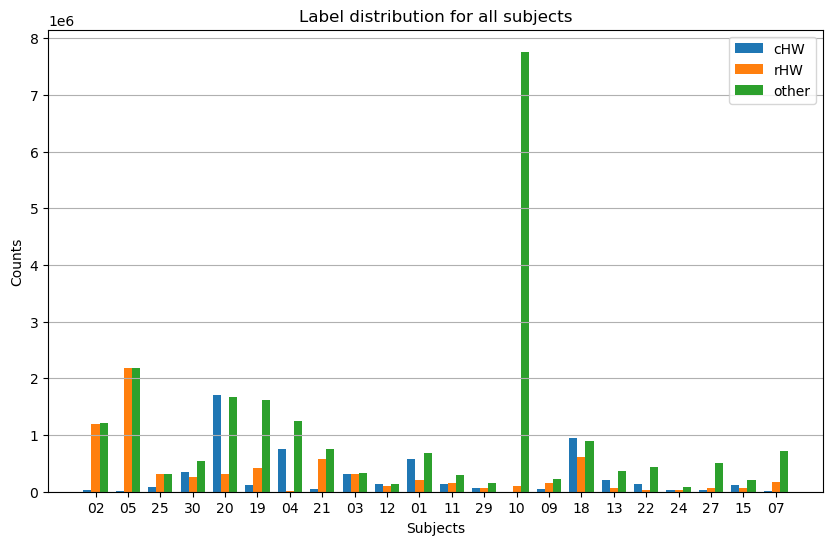

In [35]:
data = labels_distribution


# Plotting as a bar graph
labels = list(data.keys())
cHW_values = [data[key]['cHW'] for key in labels]
rHW_values = [data[key]['rHW'] for key in labels]
other_values = [data[key]['NULL'] for key in labels]

cHW_total = sum(cHW_values)
rHW_total = sum(rHW_values)
other_total = sum(other_values)

print(f"cHW_total:{cHW_total:,}\nrHW_total:{rHW_total:,}\nother_total:{other_total:,}")
x = range(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, cHW_values, width, label='cHW')
rects2 = ax.bar([val + width for val in x], rHW_values, width, label='rHW')
rects3 = ax.bar([val + 2*width for val in x], other_values, width, label='other')

ax.set_xlabel('Subjects')
ax.set_ylabel('Counts')
ax.set_title('Label distribution for all subjects')
ax.set_xticks([val + width for val in x])
ax.set_xticklabels(labels)
ax.legend()
plt.grid(axis='y')
plt.show()

cHW_total:2,722,248
rHW_total:2,509,258
other_total:462,730,723


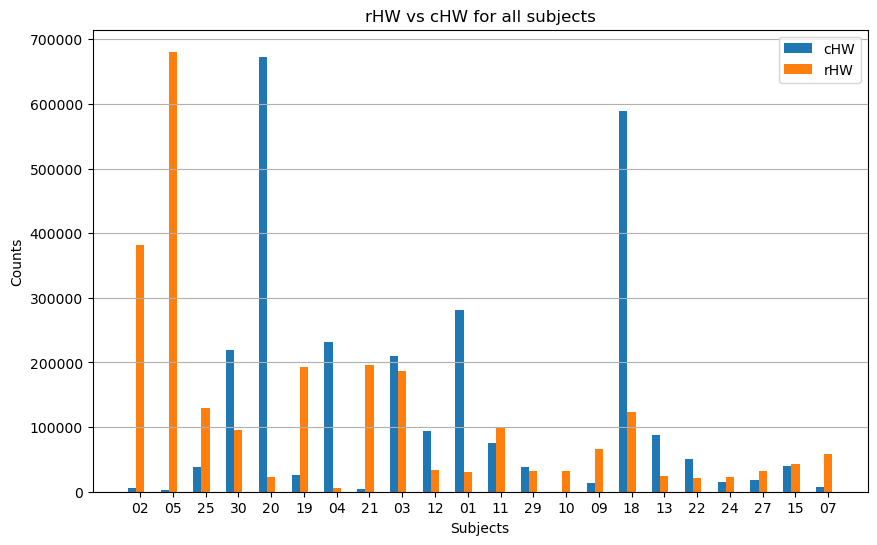

In [78]:
data = om.load_object("obj", "labels_dist.pt")


# Plotting as a bar graph
labels = sorted(list(data.keys()))
cHW_values = [data[key]['cHW'] for key in labels]
rHW_values = [data[key]['rHW'] for key in labels]
other_values = [data[key]['NULL'] for key in labels]

cHW_total = sum(cHW_values)
rHW_total = sum(rHW_values)
other_total = sum(other_values)

print(f"cHW_total:{cHW_total:,}\nrHW_total:{rHW_total:,}\nother_total:{other_total:,}")
x = range(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, cHW_values, width, label='cHW')
rects2 = ax.bar([val + width for val in x], rHW_values, width, label='rHW')
#rects3 = ax.bar([val + 2*width for val in x], other_values, width, label='other')

ax.set_xlabel('Subjects')
ax.set_ylabel('Counts')
ax.set_title('rHW vs cHW for all subjects')
ax.set_xticks([val + width for val in x])
ax.set_xticklabels(labels)
ax.legend()
plt.grid(axis='y')
plt.show()

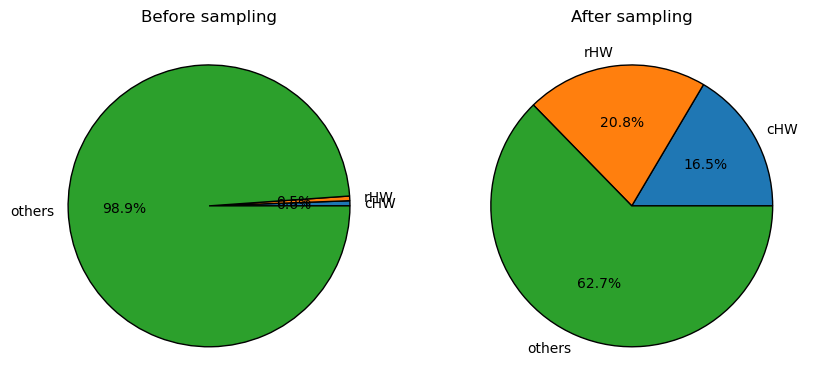

In [61]:
# Plotting as a pie chart
categories = ['cHW', 'rHW', 'others']
category_counts = [cHW_total, rHW_total, other_total]
xcategory_counts = [xcHW_total, xrHW_total, xother_total]

fig = plt.figure(figsize=(10,6))
fig.tight_layout(pad=5.0)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)



ax2.pie(category_counts, labels=categories, autopct='%1.1f%%',
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True}
       )

ax1.pie(xcategory_counts, labels=categories, autopct='%1.1f%%',
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True}
       )

ax2.title.set_text('After sampling')
ax1.title.set_text('Before sampling')

#fig.title('Distribution of Labels: rHW vs cHW vs Others')
plt.show()

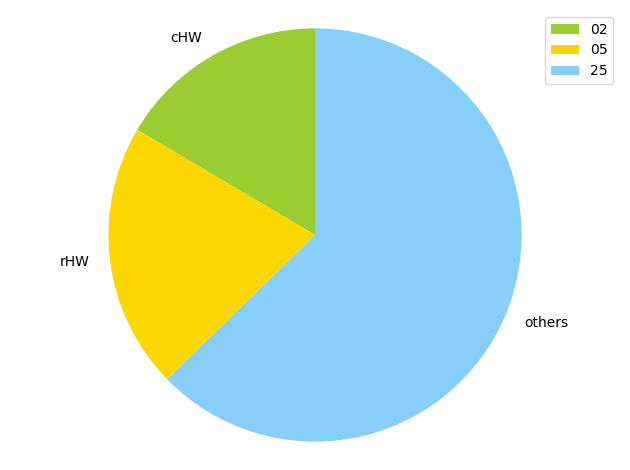

In [58]:

colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts = plt.pie(category_counts,labels=categories, colors=colors, startangle=90)

plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()


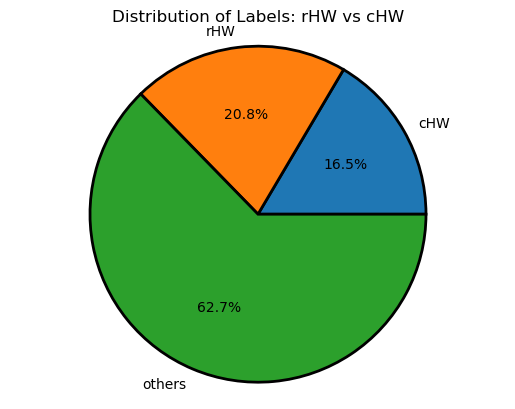

In [38]:
# Plotting as a pie chart
categories = ['cHW', 'rHW', 'others']
#colors = ['lightblue', 'lightgreen']

category_counts = [cHW_total, rHW_total, other_total]

plt.pie(category_counts, labels=categories, autopct='%1.1f%%',
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True}
       )

plt.title('Distribution of Labels: rHW vs cHW')
plt.axis('equal')

plt.show()

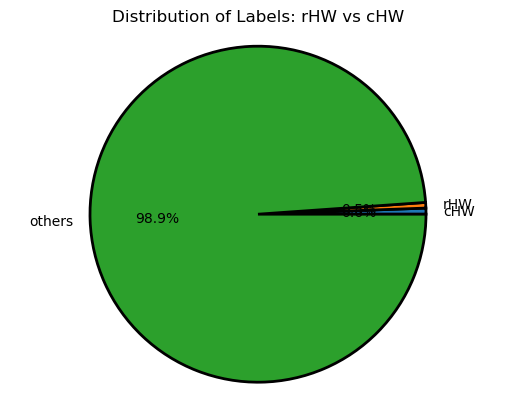

In [39]:
# Plotting as a pie chart
categories = ['cHW', 'rHW', 'others']
#colors = ['lightblue', 'lightgreen']

category_counts = [xcHW_total, xrHW_total, xother_total]

plt.pie(category_counts, labels=categories, autopct='%1.1f%%',
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True}
       )

plt.title('Distribution of Labels: rHW vs cHW')
plt.axis('equal')

plt.show()

In [81]:
total = cHW_total + rHW_total + other_total
cHW_percentage = (cHW_total/total)*100
rHW_percentage = (rHW_total/total)*100
other_percentage = (other_total/total)*100

print(f"cHW_percentage : {cHW_percentage:.2f}")
print(f"rHW_percentage : {rHW_percentage:.2f}")
print(f"other_percentage : {other_percentage:.2f}")

cHW_percentage : 0.58
rHW_percentage : 0.54
other_percentage : 98.88


In [55]:
ensemble[0].get_params()

{'alpha': 0.0001,
 'class_weight': None,
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': None,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [56]:
ensemble[0].coef_

array([[-5.70804968, -7.4181336 , -4.07183286],
       [-0.61761682,  0.67907076,  3.94676258],
       [-0.41666437,  0.29780258, -0.62646944]])

In [58]:
model = ensemble[0]
scores = []
inference = grouped_csv_files['15']
for index, file in enumerate(inference):
    x_test, y_test = dfm.load_data(file, data_folder, True, norm_method,features)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{index+1}/{len(inference)} : {file}: \n {f1}")
    scores.append(f1)

1/19 : OCDetect_15_recording_09_16012ea0-a5fd-4cf1-8525-c52b36de8f91.csv: 
 0.9566081495528919
2/19 : OCDetect_15_recording_06_379f8edc-3110-4652-9711-01080dd12da8.csv: 
 0.9707911346247086
3/19 : OCDetect_15_recording_17_ecbf1d93-1e6e-436b-9143-1d2c29300c25.csv: 
 0.9619621350974857
4/19 : OCDetect_15_recording_04_578d2f52-6407-4e73-846c-a756b95dfbc5.csv: 
 0.9681778889139556
5/19 : OCDetect_15_recording_00_679d38eb-957c-47da-8d46-7667e1129d39.csv: 
 0.983095247840858
6/19 : OCDetect_15_recording_11_69278649-4915-4af1-912c-cd0cb1164456.csv: 
 0.9547140387853755
7/19 : OCDetect_15_recording_01_e3acd37a-76ca-4b9f-9135-0eb06550c7a3.csv: 
 0.9770445180095021
8/19 : OCDetect_15_recording_08_976a4371-0312-4505-9541-0e1c3277163e.csv: 
 0.5398383177449111
9/19 : OCDetect_15_recording_13_958330c6-c8ba-4f40-b334-a1844a5535c9.csv: 
 0.9435896924547144
10/19 : OCDetect_15_recording_02_2cdf6e74-4377-40a1-8ff0-b9ca3a73df38.csv: 
 0.9680896941726947
11/19 : OCDetect_15_recording_10_72a78f61-4178-4c1

In [59]:
np.average(scores)

0.9445537081514893

In [118]:
model = ensemble[0]
scores = []
inference = grouped_csv_files['15']

for index, file in enumerate(inference):
    x_test, y_test = dfm.load_data(file, data_folder, True, norm_method,features) 
    print("")
    print(f"{index+1}/{len(inference)} : {file}")
    
    y_test_df = pd.DataFrame(y_test, columns=['relabeled'], dtype=int)
    
    # Actual Label counts 
    counts = y_test.groupby(y_test).size()
    
    # Predict
    y_pred_np = model.predict(x_test)
    
    # Predicted Label counts
    y_pred = pd.DataFrame(y_pred_np, columns=['relabeled'], dtype=int)
    y_pred_counts = y_pred.groupby('relabeled').size()

    print(f"cHW predicted: {y_pred_counts[2] if 2 in y_pred_counts else 0} , Actual: {counts[2] if 2 in counts else 0}")
    print(f"rHW predicted: {y_pred_counts[1] if 1 in y_pred_counts else 0} , Actual: {counts[1] if 1 in counts else 0}")
    print(f"other predicted: {y_pred_counts[0] if 0 in y_pred_counts else 0} , Actual: {counts[0] if 0 in counts else 0}")
    
    # Calculate scores
    f1 = f1_score(y_test, y_pred_np, average='weighted')
    print(f"F1-Score: {f1}")
    cfm = classification_report(y_test,y_pred_np)
    print(f"Classification Report: \n{cfm}")
    
    cHW_test_indices = set(y_test_df.index[y_test_df['relabeled']==2].tolist())
    cHW_pred_indices = set(y_pred.index[y_pred['relabeled']==2].tolist())
    
    rHW_test_indices = set(y_test_df.index[y_test_df['relabeled']==1].tolist())
    rHW_pred_indices = set(y_pred.index[y_pred['relabeled']==1].tolist())
    
    other_test_indices = set(y_test_df.index[y_test_df['relabeled']==0].tolist())
    other_pred_indices = set(y_pred.index[y_pred['relabeled']==0].tolist())

    # Find common indices
    cHW_true_total = len(cHW_test_indices & cHW_pred_indices)
    print(f"Total correctly predicted cHW: {cHW_true_total}")
    
    rHW_true_total = len(rHW_test_indices & rHW_pred_indices)
    print(f"Total correctly predicted rHW: {rHW_true_total}")
    
    other_true_total = len(other_test_indices & other_pred_indices)
    print(f"Total correctly predicted other: {other_true_total}")
    
    # Calculate the correctly predicted percentage 
    acc = ((cHW_true_total+rHW_true_total+other_true_total) / len(y_test)) * 100
    print(f"{acc:.2f}% correctly predicted.")
    
    print("--"*20)
    scores.append(f1)


1/19 : OCDetect_15_recording_09_16012ea0-a5fd-4cf1-8525-c52b36de8f91.csv
cHW predicted: 13678 , Actual: 3802
rHW predicted: 8487 , Actual: 5703
other predicted: 551711 , Actual: 564371
F1-Score: 0.9566081495528919
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    564371
           1       0.01      0.01      0.01      5703
           2       0.01      0.05      0.02      3802

    accuracy                           0.95    573876
   macro avg       0.34      0.34      0.33    573876
weighted avg       0.97      0.95      0.96    573876

Total correctly predicted cHW: 0
Total correctly predicted rHW: 11
Total correctly predicted other: 298741
52.06% correctly predicted.
----------------------------------------

2/19 : OCDetect_15_recording_06_379f8edc-3110-4652-9711-01080dd12da8.csv
cHW predicted: 32947 , Actual: 6603
rHW predicted: 16378 , Actual: 1901
other predicted: 1231229 , Actual: 1272050
F1-Score: 0.970

Total correctly predicted cHW: 52
Total correctly predicted rHW: 9
Total correctly predicted other: 818587
59.17% correctly predicted.
----------------------------------------

12/19 : OCDetect_15_recording_18_c074e940-abb4-40df-83b7-84d4e8b14bdf.csv
cHW predicted: 920 , Actual: 0
rHW predicted: 1186 , Actual: 0
other predicted: 104258 , Actual: 106364
F1-Score: 0.9900010445252632
Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    106364
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.98    106364
   macro avg       0.33      0.33      0.33    106364
weighted avg       1.00      0.98      0.99    106364

Total correctly predicted cHW: 0
Total correctly predicted rHW: 0
Total correctly predicted other: 60315
56.71% correctly predicted.
----------------------------------------

13/19 : OCDetect_15_recording_16_cd0

In [119]:
np.average(scores)

0.9445537081514893

In [120]:
scores

[0.9566081495528919,
 0.9707911346247086,
 0.9619621350974857,
 0.9681778889139556,
 0.983095247840858,
 0.9547140387853755,
 0.9770445180095021,
 0.5398383177449111,
 0.9435896924547144,
 0.9680896941726947,
 0.969777589034049,
 0.9900010445252632,
 0.9633728209645334,
 0.9422317120424453,
 0.9442615119990659,
 0.9804285125669551,
 0.9668891175434754,
 0.9681403719241757,
 0.9975069570812365]

In [17]:
df = dfm.read_csv_file(grouped_csv_files['02'][4])

In [28]:
df2 = dfm.read_csv_file(grouped_csv_files['02'][7])

In [53]:
df2.columns.tolist()

['timestamp',
 'datetime',
 'acc x',
 'acc y',
 'acc z',
 'gyro x',
 'gyro y',
 'gyro z',
 'user yes/no',
 'compulsive',
 'urge',
 'tense',
 'ignore',
 'relabeled']

In [55]:
usecols=[
'datetime',
'acc x',
'acc y',
'acc z',
'gyro x',
'gyro y',
'gyro z',
'ignore',
'relabeled']

In [60]:
df4 = pd.read_csv("/home/atm/Desktop/Thesis/code/data/OCDetect_Export/"+grouped_csv_files['02'][4],parse_dates=["datetime"])
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3391995 entries, 0 to 3391994
Data columns (total 14 columns):
 #   Column       Dtype         
---  ------       -----         
 0   timestamp    float64       
 1   datetime     datetime64[ns]
 2   acc x        float64       
 3   acc y        float64       
 4   acc z        float64       
 5   gyro x       float64       
 6   gyro y       float64       
 7   gyro z       float64       
 8   user yes/no  float64       
 9   compulsive   float64       
 10  urge         float64       
 11  tense        float64       
 12  ignore       int64         
 13  relabeled    int64         
dtypes: datetime64[ns](1), float64(11), int64(2)
memory usage: 362.3 MB


In [63]:
df3 = pd.read_csv("/home/atm/Desktop/Thesis/code/data/OCDetect_Export/"+grouped_csv_files['02'][4], usecols=usecols,parse_dates=["datetime"], dtype={'relabeled': 'uint8','ignore':'uint8'})

In [64]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3391995 entries, 0 to 3391994
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   acc x      float64       
 2   acc y      float64       
 3   acc z      float64       
 4   gyro x     float64       
 5   gyro y     float64       
 6   gyro z     float64       
 7   ignore     uint8         
 8   relabeled  uint8         
dtypes: datetime64[ns](1), float64(6), uint8(2)
memory usage: 187.6 MB


In [57]:
df3.head()

datetime     acc x     acc y     acc z    gyro x    gyro y  \
0 2022-02-12 18:28:03.000  2.193838 -0.071851  9.539363  0.004887 -0.002443   
1 2022-02-12 18:28:03.020  2.208208 -0.074246  9.532178  0.006109 -0.001222   
2 2022-02-12 18:28:03.040  2.220183 -0.076641  9.527389  0.006109 -0.001222   
3 2022-02-12 18:28:03.060  2.210603 -0.059875  9.534574  0.004887 -0.002443   
4 2022-02-12 18:28:03.080  2.205813 -0.074246  9.522598  0.006109 -0.002443   

     gyro z  ignore  relabeled  
0  0.000000       2          0  
1  0.000000       2          0  
2 -0.001222       2          0  
3 -0.001222       2          0  
4 -0.001222       2          0

In [44]:
time_diff = df3['datetime'].diff()
time_diff

0                            NaT
1         0 days 00:00:00.020000
2         0 days 00:00:00.020000
3         0 days 00:00:00.020000
4         0 days 00:00:00.020000
                   ...          
3391990   0 days 00:00:00.020000
3391991   0 days 00:00:00.020000
3391992   0 days 00:00:00.020000
3391993   0 days 00:00:00.020000
3391994   0 days 00:00:00.020000
Name: datetime, Length: 3391995, dtype: timedelta64[ns]

In [48]:
indices = time_diff[time_diff < pd.Timedelta(milliseconds=20)].index
indices

Int64Index([], dtype='int64')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3391995 entries, 0 to 3391994
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   timestamp    float64
 1   datetime     object 
 2   acc x        float64
 3   acc y        float64
 4   acc z        float64
 5   gyro x       float64
 6   gyro y       float64
 7   gyro z       float64
 8   user yes/no  float64
 9   compulsive   float64
 10  urge         float64
 11  tense        float64
 12  ignore       int64  
 13  relabeled    int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 362.3+ MB


In [20]:
df.head()

timestamp                 datetime     acc x     acc y     acc z  \
0         0.0  2022-02-12 18:28:03.000  2.193838 -0.071851  9.539363   
1  20000000.0  2022-02-12 18:28:03.020  2.208208 -0.074246  9.532178   
2  40000000.0  2022-02-12 18:28:03.040  2.220183 -0.076641  9.527389   
3  60000000.0  2022-02-12 18:28:03.060  2.210603 -0.059875  9.534574   
4  80000000.0  2022-02-12 18:28:03.080  2.205813 -0.074246  9.522598   

     gyro x    gyro y    gyro z  user yes/no  compulsive  urge  tense  ignore  \
0  0.004887 -0.002443  0.000000          NaN         NaN   NaN    NaN       2   
1  0.006109 -0.001222  0.000000          NaN         NaN   NaN    NaN       2   
2  0.006109 -0.001222 -0.001222          NaN         NaN   NaN    NaN       2   
3  0.004887 -0.002443 -0.001222          NaN         NaN   NaN    NaN       2   
4  0.006109 -0.002443 -0.001222          NaN         NaN   NaN    NaN       2   

   relabeled  
0          0  
1          0  
2          0  
3          0  
4          0

In [29]:
df['new_datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [39]:
time_diff = df['new_datetime'].diff()
indices = time_diff[time_diff == pd.Timedelta(milliseconds=200)].index
indices

Int64Index([], dtype='int64')

In [38]:
df.iloc[3391984: 3391995,:]

timestamp                 datetime     acc x     acc y      acc z  \
3391984  6.783968e+13  2022-02-13 13:18:42.680  0.993933 -0.828677  10.174044   
3391985  6.783970e+13  2022-02-13 13:18:42.700  1.753154  0.866997  10.078242   
3391986  6.783972e+13  2022-02-13 13:18:42.720  1.786685  1.195115  10.442286   
3391987  6.783974e+13  2022-02-13 13:18:42.740  1.777105 -0.433499  10.506951   
3391988  6.783976e+13  2022-02-13 13:18:42.760  2.838098 -0.522114   9.225615   
3391989  6.783978e+13  2022-02-13 13:18:42.780  2.402205 -0.014370   9.084310   
3391990  6.783980e+13  2022-02-13 13:18:42.800  1.856140  0.366438   7.489226   
3391991  6.783982e+13  2022-02-13 13:18:42.820  4.167334  4.358936   8.210127   
3391992  6.783984e+13  2022-02-13 13:18:42.840  1.932781 -1.784290  16.434626   
3391993  6.783986e+13  2022-02-13 13:18:42.860  2.900369  0.807122   8.892708   
3391994  6.783988e+13  2022-02-13 13:18:42.880  2.177073  1.580713   8.452024   

           gyro x    gyro y    gyro z  user yes/no  compulsive  urge  tense  \
3391984  2.846631 -4.549723  0.425162          NaN         NaN   NaN    NaN   
3391985  1.912008 -3.203376  0.250455          NaN         NaN   NaN    NaN   
3391986  0.415388 -0.384845 -0.054978          NaN         NaN   NaN    NaN   
3391987 -0.179594  1.353677 -0.298102          NaN         NaN   NaN    NaN   
3391988  0.851546  0.643852 -0.263894          NaN         NaN   NaN    NaN   
3391989  1.996307 -0.984714  0.013439          NaN         NaN   NaN    NaN   
3391990  2.907717 -2.190562  0.233350          NaN         NaN   NaN    NaN   
3391991  2.626720 -1.959655  0.228464          NaN         NaN   NaN    NaN   
3391992 -2.853961  0.139277  0.072082          NaN         NaN   NaN    NaN   
3391993  1.287703 -0.123395  0.074526          NaN         NaN   NaN    NaN   
3391994  0.682947 -0.041539  0.073304          NaN         NaN   NaN    NaN   

         ignore  relabeled            new_datetime  
3391984       0          0 2022-02-13 13:18:42.680  
3391985       0          0 2022-02-13 13:18:42.700  
3391986       0          0 2022-02-13 13:18:42.720  
3391987       0          0 2022-02-13 13:18:42.740  
3391988       0          0 2022-02-13 13:18:42.760  
3391989       0          0 2022-02-13 13:18:42.780  
3391990       0          0 2022-02-13 13:18:42.800  
3391991       0          0 2022-02-13 13:18:42.820  
3391992       0          0 2022-02-13 13:18:42.840  
3391993       0          0 2022-02-13 13:18:42.860  
3391994       0          0 2022-02-13 13:18:42.880

In [49]:
1/50

0.02

In [11]:
home = "/home/atm/Desktop/Thesis/code/data/OCDetect_Export/"
files = grouped_csv_files['02']
usecols=['datetime','acc x','acc y','acc z','gyro x','gyro y','gyro z','ignore','relabeled']

frame = pd.DataFrame(columns = usecols)

for i, f in enumerate(files):
    temp = pd.read_csv(home+f, usecols=usecols,parse_dates=["datetime"], dtype={'relabeled': 'uint8','ignore':'uint8'})
    print(i," : ", len(temp))
    frame = pd.concat([frame,temp])

0  :  816282
1  :  1488626
2  :  1249592
3  :  3204376
4  :  3391995
5  :  1317048
6  :  848322
7  :  4179400
8  :  878372
9  :  2042914
10  :  2954740
11  :  1173462
12  :  1224552
13  :  2784436
14  :  1500845
15  :  1788502
16  :  2245359
17  :  1896174
18  :  1451681
19  :  2216789
20  :  1399405
21  :  1226056
22  :  4860902
23  :  2393111
24  :  1588012
25  :  739536
26  :  2376894
27  :  573874
28  :  1839922
29  :  1852653
30  :  1456391
31  :  561343
32  :  15536
33  :  3706626
34  :  1941177


In [12]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65184905 entries, 0 to 1941176
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   acc x      float64       
 2   acc y      float64       
 3   acc z      float64       
 4   gyro x     float64       
 5   gyro y     float64       
 6   gyro z     float64       
 7   ignore     object        
 8   relabeled  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 4.9+ GB


In [13]:
frame

datetime     acc x     acc y     acc z    gyro x  \
0       2022-02-09 17:31:54.000  8.626861 -0.790356  1.398691 -0.310319   
1       2022-02-09 17:31:54.020  9.778865 -1.595083  2.670447 -1.839925   
2       2022-02-09 17:31:54.040  8.607700 -1.544788  1.877695 -2.700023   
3       2022-02-09 17:31:54.060  9.132210 -1.355581  2.569856 -2.907717   
4       2022-02-09 17:31:54.080  9.232800 -1.597478  3.273992 -2.452012   
...                         ...       ...       ...       ...       ...   
1941172 2022-03-08 18:49:57.440  0.323328 -0.201182  9.836346  0.003665   
1941173 2022-03-08 18:49:57.460  0.340093 -0.208367  9.829161  0.003665   
1941174 2022-03-08 18:49:57.480  0.342488 -0.201182  9.824370  0.002443   
1941175 2022-03-08 18:49:57.500  0.325723 -0.189207  9.812395  0.003665   
1941176 2022-03-08 18:49:57.520  0.349673 -0.196392  9.831555  0.002443   

           gyro y    gyro z ignore relabeled  
0       -0.926071 -1.040914      0         0  
1       -2.373822 -1.637118      0         0  
2       -4.166099 -1.907121      0         0  
3       -4.593705 -2.636493      0         0  
4       -4.448319 -2.488664      0         0  
...           ...       ...    ...       ...  
1941172 -0.001222  0.002443      0         0  
1941173 -0.001222  0.002443      0         0  
1941174 -0.001222  0.002443      0         0  
1941175  0.000000  0.002443      0         0  
1941176 -0.001222  0.002443      0         0  

[65184905 rows x 9 columns]

<Axes: title={'center': 'Before Scaling'}, xlabel='relabeled', ylabel='Density'>

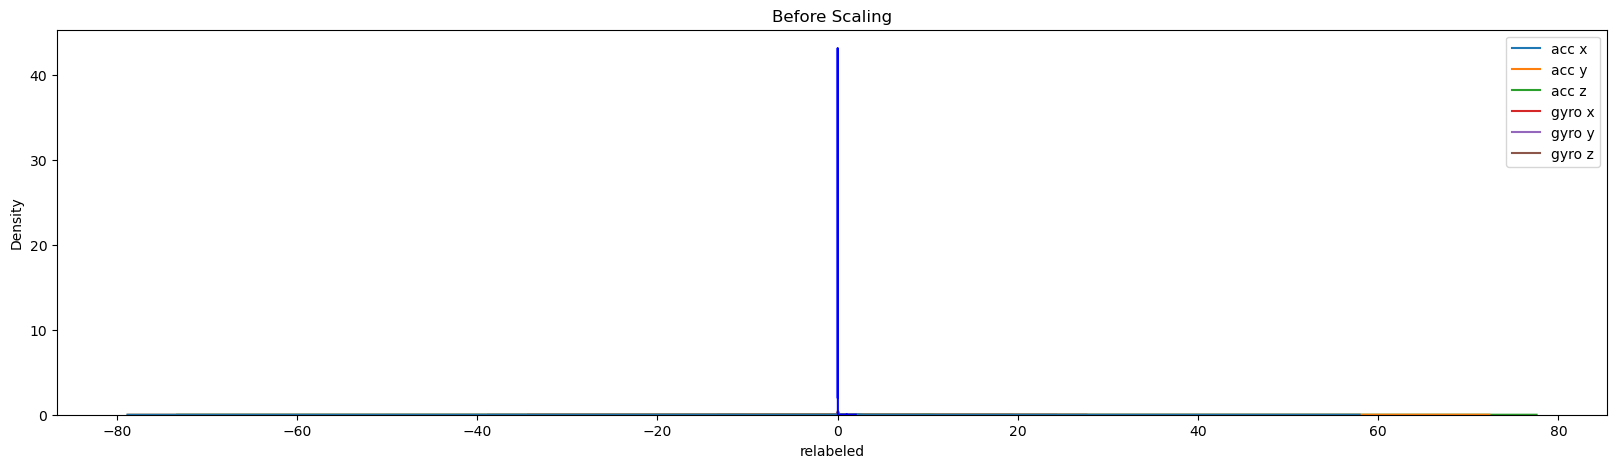

In [14]:
fig, ax1 = plt.subplots(ncols = 1, figsize =(20, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(frame.iloc[:,1:7], ax = ax1, color ='r')
sns.kdeplot(frame['relabeled'], ax = ax1, color ='b')


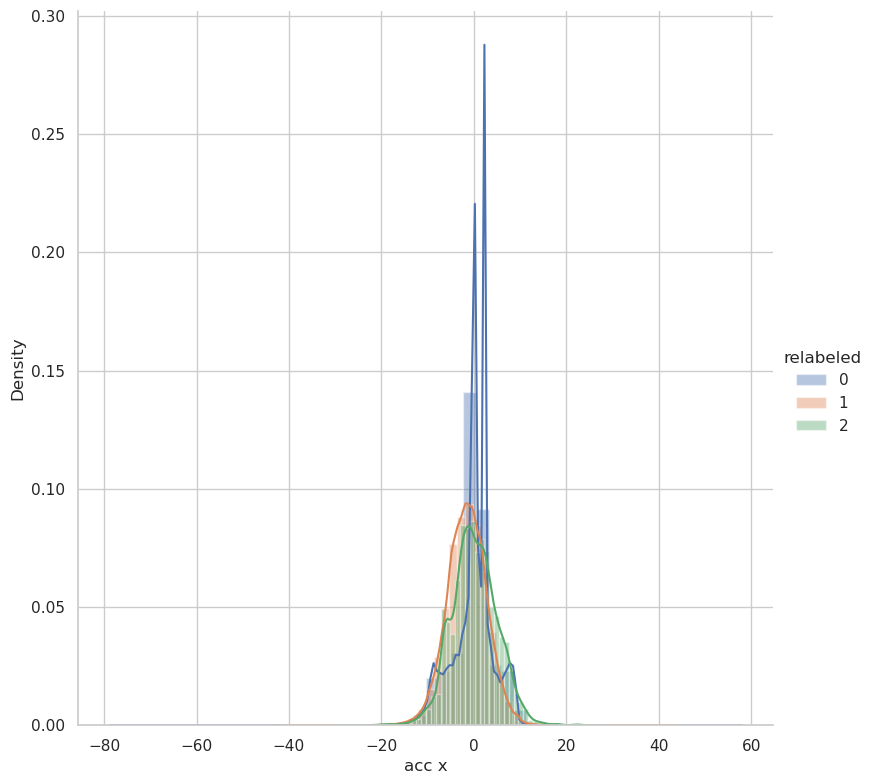

In [16]:
sns.set(style = 'whitegrid')
sns.FacetGrid(frame, hue = 'relabeled', height = 8).map(sns.distplot, 'acc x').add_legend()
plt.show()

In [17]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65184905 entries, 0 to 1941176
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   acc x      float64       
 2   acc y      float64       
 3   acc z      float64       
 4   gyro x     float64       
 5   gyro y     float64       
 6   gyro z     float64       
 7   ignore     object        
 8   relabeled  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 4.9+ GB


In [23]:
labels = ["NULL", "rHW", "cHW"]

def plot_activity(df, label):
    data = df[df['relabeled'] == label][['acc x', 'acc y', 'acc z']][:300]
    axis = data["acc x"].plot(subplots=True, color="b", fontsize = 12)
    axis = data["acc y"].plot(subplots=True, color="r", fontsize = 12)
    axis = data["acc z"].plot(subplots=True, color="g", fontsize = 12)
    for ax in axis:
        ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5), fontsize = 12)



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - NULL -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




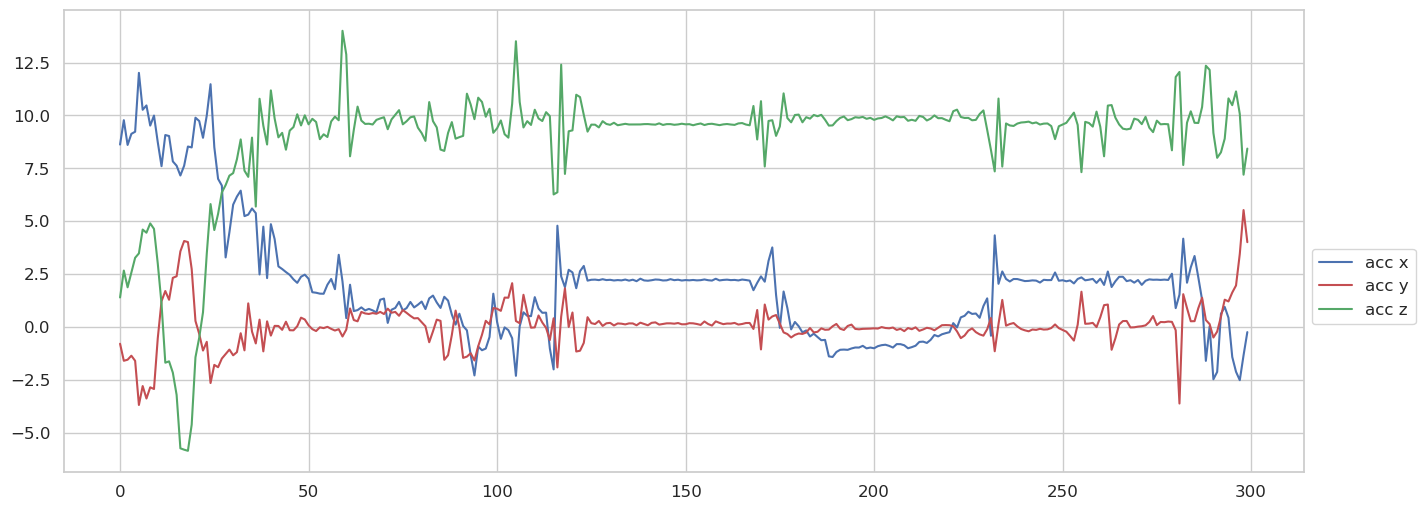



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - rHW -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




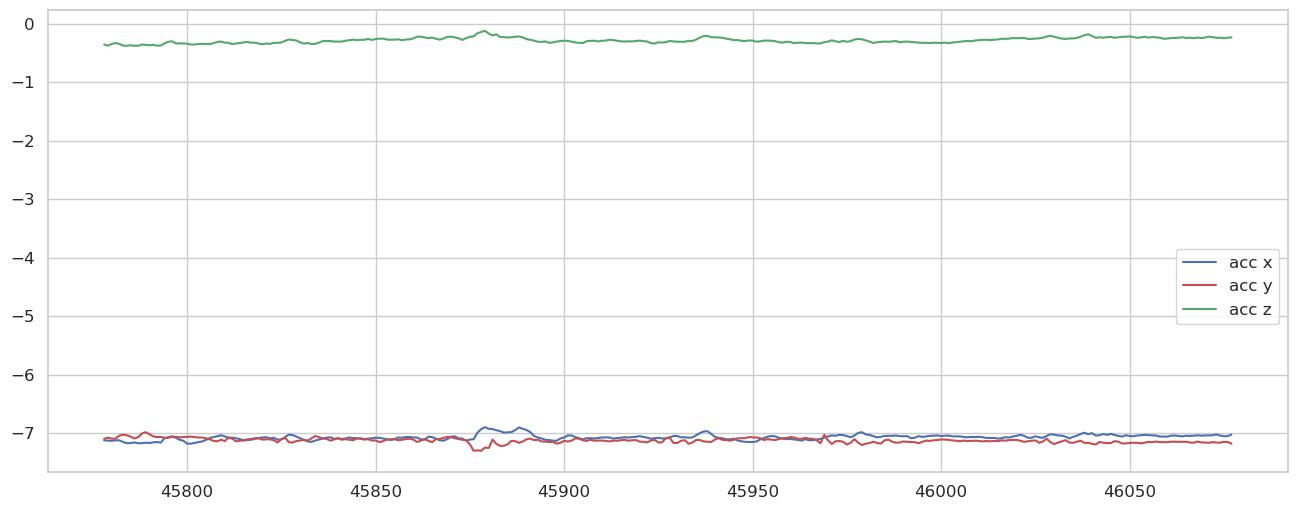



 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - cHW -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 




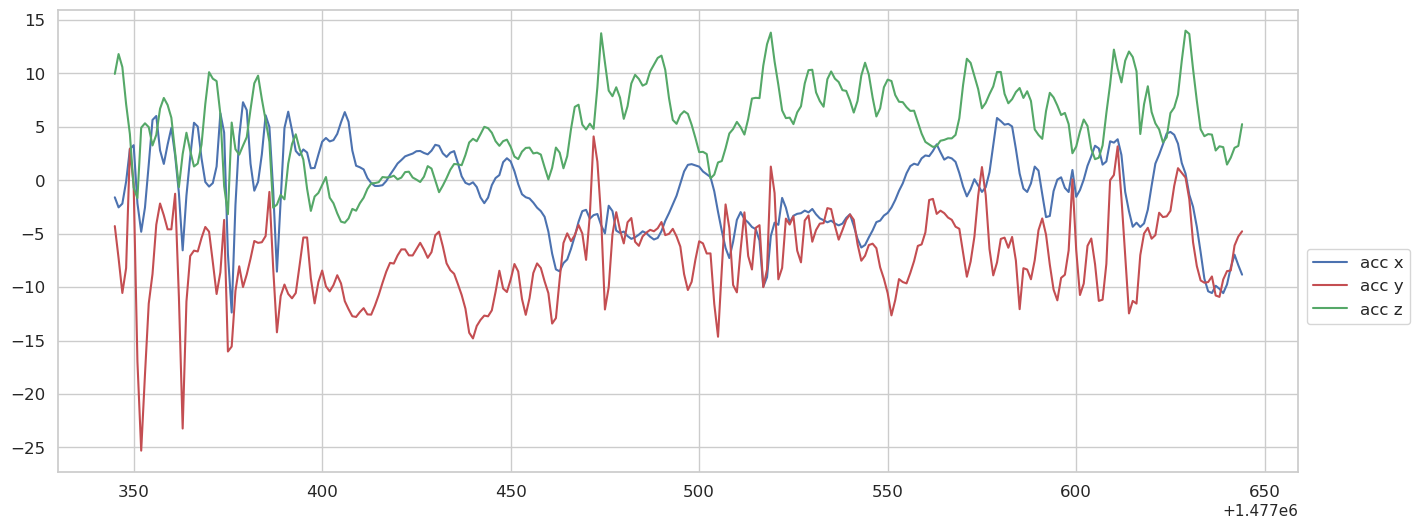

In [24]:
for i in [0,1,2]:
    plt.figure(figsize = (16, 6))
    print("\n")
    print(" - "*15 + labels[i] + " - "*15)
    print("\n")
    plot_activity(frame, i)
    plt.show()